# <center>Análise de cancelamento de vendas</center>
### <center>Proposta de solução</center>
___

### 1.0 Bibliotecas

In [1]:
#transformação
import pandas as pd
import numpy as np
from datetime import datetime
import warnings 
warnings.filterwarnings('ignore')

# visualização
import matplotlib.pyplot as plt
import seaborn as sns

#classificação
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, KFold
from catboost import CatBoostClassifier

#serializar modelo
import pickle

C:\Users\leticia\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\leticia\anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\leticia\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


### 2.0 Importar dados

In [2]:
#importar a base
base_varejo = pd.read_csv('online_retail_II.csv', sep = ';', decimal=',', header=0, encoding='latin1')

In [ ]:
#visualizar base
base_varejo

In [ ]:
#shape
base_varejo.shape

In [ ]:
#verificar tipo de dados
base_varejo.info()

In [ ]:
#resumo quantitativo
base_varejo.describe()

In [3]:
#verificar obs vazias
base_varejo.isna().sum()

#Descrição           4382
#ClienteID         243007

Fatura                 0
Código_Estoque         0
Descrição           4382
Quantidade             0
Data_Fatura            0
Hora_Fatura            0
Preço                  0
ClienteID         243007
País                   0
dtype: int64

In [4]:
#excluir as linhas com ClienteID vazias
base_varejo.dropna(subset=['ClienteID'], inplace=True)
base_varejo.reset_index(drop=True, inplace=True)

In [5]:
#Retirando da base código de estoque 'M', 'AMAZONFEE'
base_varejo = base_varejo[~base_varejo['Código_Estoque'].isin(['M', 'AMAZONFEE'])]
base_varejo.reset_index(drop=True, inplace=True)

In [7]:
#alterar tipo de variável
base_varejo['Data_Fatura'] = pd.to_datetime(base_varejo['Data_Fatura'], infer_datetime_format = True, format="%d/%m/%Y")
base_varejo['ClienteID'] = round(base_varejo['ClienteID'])
base_varejo['ClienteID'] = base_varejo['ClienteID'].astype('int') #arredondar valor
base_varejo['ClienteID'] = base_varejo['ClienteID'].astype('str')

In [8]:
#criar coluna de mês e ano
base_varejo['Mês'] = base_varejo['Data_Fatura'].dt.month
base_varejo['Ano'] = base_varejo['Data_Fatura'].dt.year

In [9]:
# Função para converter uma string em um objeto datetime
def converter_para_hora(hora_str):
    return datetime.strptime(hora_str, '%H:%M:%S')

# Aplicar a função à coluna 'Hora_Fatura' e criar uma nova coluna 'hora'
base_varejo['Hora_Fatura'] = base_varejo['Hora_Fatura'].apply(converter_para_hora)

In [10]:
#verificar obs vazias
base_varejo.isna().sum()

Fatura            0
Código_Estoque    0
Descrição         0
Quantidade        0
Data_Fatura       0
Hora_Fatura       0
Preço             0
ClienteID         0
País              0
Mês               0
Ano               0
dtype: int64

In [11]:
#verificar tipo de dados
base_varejo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823249 entries, 0 to 823248
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Fatura          823249 non-null  object        
 1   Código_Estoque  823249 non-null  object        
 2   Descrição       823249 non-null  object        
 3   Quantidade      823249 non-null  int64         
 4   Data_Fatura     823249 non-null  datetime64[ns]
 5   Hora_Fatura     823249 non-null  datetime64[ns]
 6   Preço           823249 non-null  float64       
 7   ClienteID       823249 non-null  object        
 8   País            823249 non-null  object        
 9   Mês             823249 non-null  int64         
 10  Ano             823249 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 69.1+ MB


In [12]:
#visualizar base
base_varejo

Fatura Código_Estoque                            Descrição  \
0       489434          85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS   
1       489434         79323P                   PINK CHERRY LIGHTS   
2       489434         79323W                  WHITE CHERRY LIGHTS   
3       489434          22041         RECORD FRAME 7" SINGLE SIZE    
4       489434          21232       STRAWBERRY CERAMIC TRINKET BOX   
...        ...            ...                                  ...   
823244  581587          22899         CHILDREN'S APRON DOLLY GIRL    
823245  581587          23254        CHILDRENS CUTLERY DOLLY GIRL    
823246  581587          23255      CHILDRENS CUTLERY CIRCUS PARADE   
823247  581587          22138        BAKING SET 9 PIECE RETROSPOT    
823248  581587           POST                              POSTAGE   

        Quantidade Data_Fatura         Hora_Fatura  Preço ClienteID  \
0               12  2009-12-01 1900-01-01 07:45:00   6.95     13085   
1               12  2009-12-01 1900-01-01 07:45:00   6.75     13085   
2               12  2009-12-01 1900-01-01 07:45:00   6.75     13085   
3               48  2009-12-01 1900-01-01 07:45:00   2.10     13085   
4               24  2009-12-01 1900-01-01 07:45:00   1.25     13085   
...            ...         ...                 ...    ...       ...   
823244           6  2011-12-09 1900-01-01 12:50:00   2.10     12680   
823245           4  2011-12-09 1900-01-01 12:50:00   4.15     12680   
823246           4  2011-12-09 1900-01-01 12:50:00   4.15     12680   
823247           3  2011-12-09 1900-01-01 12:50:00   4.95     12680   
823248           1  2011-12-09 1900-01-01 12:50:00  18.00     12680   

                  País  Mês   Ano  
0       United Kingdom   12  2009  
1       United Kingdom   12  2009  
2       United Kingdom   12  2009  
3       United Kingdom   12  2009  
4       United Kingdom   12  2009  
...                ...  ...   ...  
823244          France   12  2011  
823245          France   12  2011  
823246          France   12  2011  
823247          France   12  2011  
823248          France   12  2011  

[823249 rows x 11 columns]

### 3.0 EDA - Análise exploratória de dados

In [13]:
#identificando as transações canceladas
base_varejo['Canceladas'] = ['Sim' if  base_varejo['Fatura'][i][0] == 'C' else 'Não' for i in range(0, len(base_varejo))]

In [14]:
#Vendas
base_varejo['Vendas'] = base_varejo['Quantidade']*base_varejo['Preço']

In [15]:
#Vendas canceladas por País
df_vendas_pais = pd.DataFrame(base_varejo[base_varejo['Canceladas'] == 'Sim'].groupby('País')['Quantidade','Vendas'].sum()).reset_index().sort_values(by=['Vendas'])
df_vendas_pais["%"] = df_vendas_pais["Vendas"]/df_vendas_pais["Vendas"].sum() * 100
df_vendas_pais["%_Acc"] = df_vendas_pais["%"].cumsum()
df_vendas_pais = df_vendas_pais.reset_index(drop=True)
df_vendas_pais

País  Quantidade     Vendas          %       %_Acc
0         United Kingdom     -360599 -669007.71  88.301181   88.301181
1                   EIRE       -8555  -19722.31   2.603114   90.904295
2                 France      -90312  -18194.19   2.401420   93.305715
3                  Spain       -5646  -13401.44   1.768833   95.074548
4                Germany       -3411   -9611.49   1.268604   96.343152
5            Netherlands       -2184   -5323.43   0.702630   97.045783
6                Denmark       -2707   -4121.10   0.543937   97.589720
7                  Japan       -1500   -3277.14   0.432544   98.022264
8                 Sweden        -772   -2296.43   0.303102   98.325366
9        Channel Islands       -1006   -2238.52   0.295458   98.620824
10                   USA       -1564   -2080.32   0.274578   98.895402
11             Australia        -690   -1780.59   0.235017   99.130419
12           Switzerland        -507   -1282.53   0.169279   99.299698
13                 Italy        -190   -1205.71   0.159140   99.458837
14               Belgium        -179    -670.28   0.088469   99.547307
15              Portugal        -344    -643.41   0.084923   99.632229
16                Cyprus        -297    -496.70   0.065559   99.697788
17               Finland         -58    -411.09   0.054259   99.752047
18                Poland        -184    -374.36   0.049411   99.801458
19               Austria        -271    -305.41   0.040311   99.841768
20                Israel         -56    -227.44   0.030019   99.871788
21                 Malta         -26    -220.12   0.029053   99.900841
22                 Korea        -102    -168.69   0.022265   99.923106
23                Norway         -88    -161.68   0.021340   99.944446
24  United Arab Emirates        -118    -130.98   0.017288   99.961734
25        Czech Republic         -79    -119.02   0.015709   99.977443
26                Greece         -17    -100.70   0.013291   99.990734
27           Unspecified         -13     -46.95   0.006197   99.996931
28          Saudi Arabia          -5     -14.75   0.001947   99.998878
29    European Community          -2      -8.50   0.001122  100.000000

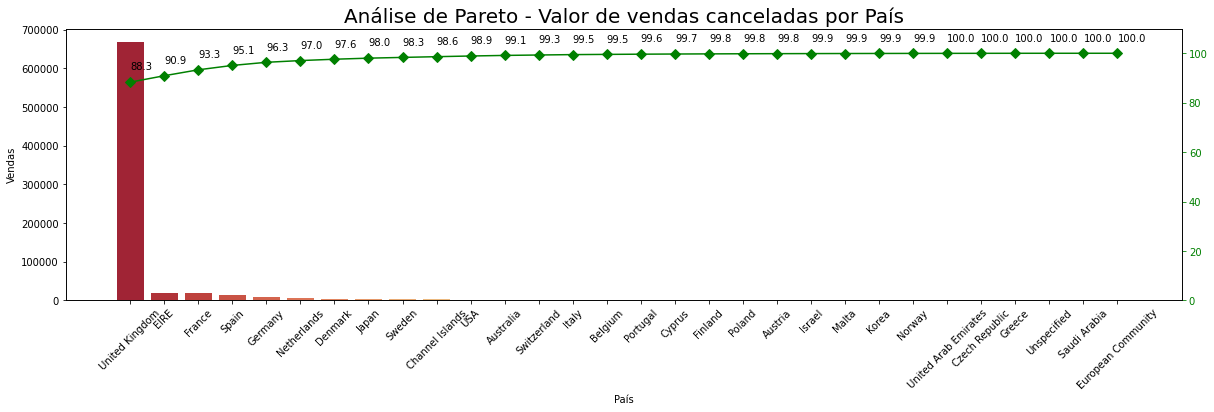

In [16]:
#cria um barplot, define os eixos e a paleta de cores usada para colorir as barras
plt.figure(figsize=(20,5))
ax = sns.barplot(x=df_vendas_pais["País"], y=abs(df_vendas_pais["Vendas"]), palette="RdYlBu")
ax.set_title("Análise de Pareto - Valor de vendas canceladas por País", fontsize = 20)
ax2 = ax.twinx()# Eixo secundário

# Cria a Curva de Pareto no eixo secundário
ax2.plot(df_vendas_pais["País"], df_vendas_pais["%_Acc"], color="g", marker="D", ms=7, label='Pareto')

# Configurações dos eixos 
ax2.tick_params(axis="y", colors="g")
ax2.set_ylim([0,110])

# Ajusta a inclinação dos labels do eixo x
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# Mostra os labels com a percentagem acumulada em cada ponto
gap = 5
for i in range(len(df_vendas_pais["%_Acc"])):
    ax2.annotate("%.1f" % df_vendas_pais["%_Acc"][i], (df_vendas_pais["País"][i], df_vendas_pais["%_Acc"][i] + gap))

In [17]:
print('Valor de cancelamentos de venda no UK: ' + str(-base_varejo['Vendas'][(base_varejo['Canceladas'] == 'Sim') & (base_varejo['País'] == 'United Kingdom')].sum())+ str(' Libras'))

Valor de cancelamentos de venda no UK: 669007.71 Libras


In [18]:
#Qtd canceladas por País
df_qtd_pais = pd.DataFrame(base_varejo[base_varejo['Canceladas'] == 'Sim'].groupby('País')['Quantidade'].sum()).reset_index().sort_values(by=['Quantidade'])
df_qtd_pais["%"] = df_qtd_pais["Quantidade"]/df_qtd_pais["Quantidade"].sum() * 100
df_qtd_pais["%_Acc"] = df_qtd_pais["%"].cumsum()
df_qtd_pais = df_qtd_pais.reset_index(drop=True)
df_qtd_pais

País  Quantidade          %       %_Acc
0         United Kingdom     -360599  74.893558   74.893558
1                 France      -90312  18.757087   93.650645
2                   EIRE       -8555   1.776806   95.427451
3                  Spain       -5646   1.172630   96.600081
4                Germany       -3411   0.708438   97.308518
5                Denmark       -2707   0.562222   97.870741
6            Netherlands       -2184   0.453600   98.324340
7                    USA       -1564   0.324830   98.649171
8                  Japan       -1500   0.311538   98.960709
9        Channel Islands       -1006   0.208938   99.169647
10                Sweden        -772   0.160338   99.329985
11             Australia        -690   0.143308   99.473293
12           Switzerland        -507   0.105300   99.578593
13              Portugal        -344   0.071446   99.650039
14                Cyprus        -297   0.061685   99.711723
15               Austria        -271   0.056285   99.768008
16                 Italy        -190   0.039461   99.807469
17                Poland        -184   0.038215   99.845685
18               Belgium        -179   0.037177   99.882862
19  United Arab Emirates        -118   0.024508   99.907369
20                 Korea        -102   0.021185   99.928554
21                Norway         -88   0.018277   99.946831
22        Czech Republic         -79   0.016408   99.963239
23               Finland         -58   0.012046   99.975285
24                Israel         -56   0.011631   99.986915
25                 Malta         -26   0.005400   99.992315
26                Greece         -17   0.003531   99.995846
27           Unspecified         -13   0.002700   99.998546
28          Saudi Arabia          -5   0.001038   99.999585
29    European Community          -2   0.000415  100.000000

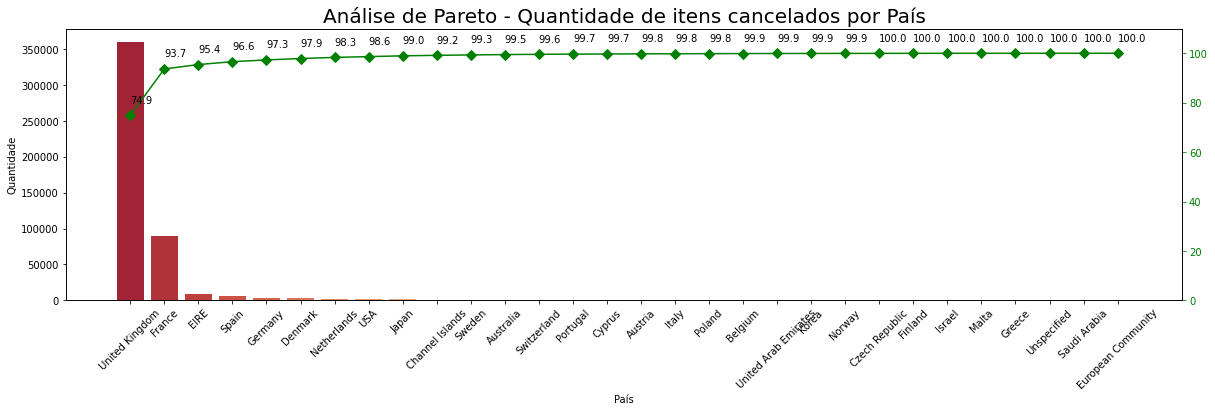

In [19]:
# Cria um barplot, define os eixos e a paleta de cores usada para colorir as barras
plt.figure(figsize=(20,5))
ax = sns.barplot(x=df_qtd_pais["País"], y=abs(df_qtd_pais["Quantidade"]), palette="RdYlBu")
ax.set_title("Análise de Pareto - Quantidade de itens cancelados por País", fontsize=20) # define e ajusta o tamanho da fonte do título

# Eixo secundário
ax2 = ax.twinx()

# Cria a Curva de Pareto no eixo secundário
ax2.plot(df_qtd_pais["País"], df_qtd_pais["%_Acc"], color="g", marker="D", ms=7, label='Pareto')

# Configurações dos eixos 
ax2.tick_params(axis="y", colors="g")
ax2.set_ylim([0,110])

# Ajusta a inclinação dos labels do eixo x
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# Mostra os labels com a percentagem acumulada em cada ponto
gap = 5
for i in range(len(df_qtd_pais["%_Acc"])):
    ax2.annotate("%.1f" % df_qtd_pais["%_Acc"][i], (df_qtd_pais["País"][i], df_qtd_pais["%_Acc"][i] + gap))

In [20]:
print('Qtd de cancelamentos de venda no UK: ' + str(-base_varejo['Quantidade'][(base_varejo['Canceladas'] == 'Sim') & (base_varejo['País'] == 'United Kingdom')].sum()))

Qtd de cancelamentos de venda no UK: 360599


### 4.0 United Kingdom - EDA

In [21]:
base_varejo_uk = base_varejo[base_varejo['País'] == 'United Kingdom']
base_varejo_uk = base_varejo_uk.reset_index(drop=True)

In [ ]:
base_varejo_uk 

In [ ]:
# análise dos dados com profile
profile_base = ProfileReport(base_varejo_uk)
profile_base

In [22]:
#métricas ipc 

#transações
total_transacoes_canceladas = base_varejo_uk['Fatura'][base_varejo_uk['Canceladas']=='Sim'].nunique()
total_transacoes = base_varejo_uk['Fatura'].nunique()
prop_transacoes_canceladas = (total_transacoes_canceladas/total_transacoes)*100

#itens
qtd_itens_cancelados = - base_varejo_uk['Quantidade'][base_varejo_uk['Canceladas']=='Sim'].sum()
qtd_itens_total = base_varejo_uk['Quantidade'].sum()
prop_qtd_cancelada = (qtd_itens_cancelados/qtd_itens_total)*100

#valor
valor_itens_cancelados = - base_varejo_uk['Vendas'][base_varejo_uk['Canceladas']=='Sim'].sum()
valor_itens_total = base_varejo_uk['Vendas'].sum()
prop_valor_cancelado = (valor_itens_cancelados/valor_itens_total)*100

# ticket médio (valor e qtd) e taket time (ritmo)
ticket_valor_transacao_cancelada = (valor_itens_cancelados)/total_transacoes_canceladas
ticket_qtd_transacao_cancelada = (qtd_itens_cancelados)/total_transacoes_canceladas
taket_time_valor_transacao_cancelada = (total_transacoes_canceladas/valor_itens_cancelados)
taket_time_qtd_transacao_cancelada = (total_transacoes_canceladas/qtd_itens_cancelados)

In [23]:
#métricas ipc 

df_clientes = abs(base_varejo_uk[base_varejo_uk['Canceladas'] == 'Sim'].groupby(['ClienteID']).agg({'Vendas': 'sum','Fatura': 'nunique','Quantidade':'sum','Código_Estoque':'nunique'}))
df_clientes = df_clientes.rename(columns={'Vendas': 'Valor de cancelamentos','Fatura': 'Qtd de cancelamentos','Quantidade':'Qtd de itens cancelados', 'Código_Estoque':'Qtd_Itens_Dist'})
df_clientes = pd.DataFrame(df_clientes)
df_clientes

Valor de cancelamentos  Qtd de cancelamentos  \
ClienteID                                                 
12346                    77292.60                     4   
12746                       23.70                     2   
12747                      111.95                     6   
12748                     2940.39                    23   
12749                      568.87                     7   
...                           ...                   ...   
18280                       15.70                     1   
18282                        1.45                     1   
18284                       25.00                     1   
18286                      108.00                     1   
18287                        5.10                     1   

           Qtd de itens cancelados  Qtd_Itens_Dist  
ClienteID                                           
12346                        74218               4  
12746                            6               3  
12747                           25               8  
12748                         2033              68  
12749                           89              57  
...                            ...             ...  
18280                            2               2  
18282                            5               1  
18284                            1               1  
18286                           16               3  
18287                            2               1  

[2246 rows x 4 columns]

In [24]:
print('Total de transações canceladas: ' + str(total_transacoes_canceladas))
print('\nProporção de transações canceladas: '+ str(prop_transacoes_canceladas))
print('\nQtd de itens cancelados: '+ str(qtd_itens_cancelados))
print('\nProporção de itens cancelados: '+ str(prop_qtd_cancelada))
print('\nValor de venda cancelado: '+ str(valor_itens_cancelados))
print('\nProporção do valor de venda de cancelado: '+ str(prop_valor_cancelado))
print('\nTicket médio em valor por transação cancelada: '+ str(ticket_valor_transacao_cancelada))
print('\nTicket médio em qtd por transação cancelada: '+ str(ticket_qtd_transacao_cancelada))
print('\nTaket time em valor por transação cancelada: '+ str(taket_time_valor_transacao_cancelada))
print('\nTaket time em qtd por transação cancelada: '+ str(taket_time_qtd_transacao_cancelada))
print('\nValor médio de cancelamentos para um cliente por transação: '+ str(df_clientes['Valor de cancelamentos'].mean()))
print('\nQuantidade média de cancelamentos para um cliente: '+ str(df_clientes['Qtd de cancelamentos'].mean()))
print('\nQuantidade média de itens cancelados para um cliente: '+ str(df_clientes['Qtd de itens cancelados'].mean()))
print('\nQuantidade média de itens distintos cancelados para um cliente: '+ str(df_clientes['Qtd_Itens_Dist'].mean()))

Total de transações canceladas: 6730

Proporção de transações canceladas: 16.753379303477633

Qtd de itens cancelados: 360599

Proporção de itens cancelados: 4.31932320353807

Valor de venda cancelado: 669007.71

Proporção do valor de venda de cancelado: 4.785299905952623

Ticket médio em valor por transação cancelada: 99.40679197622585

Ticket médio em qtd por transação cancelada: 53.58083209509658

Taket time em valor por transação cancelada: 0.010059674798067724

Taket time em qtd por transação cancelada: 0.018663390636135986

Valor médio de cancelamentos para um cliente por transação: 297.8663000890468

Quantidade média de cancelamentos para um cliente: 2.9964381121994657

Quantidade média de itens cancelados para um cliente: 160.55164737310776

Quantidade média de itens distintos cancelados para um cliente: 5.83659839715049


In [25]:
#extrair dia da semana
base_varejo_uk['Dia_Semana'] = base_varejo_uk['Data_Fatura'].dt.day_name()
base_varejo_uk['Dia_Semana'].unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

In [26]:
#transformar dia da semana
base_varejo_uk['Dia_Semana'] = base_varejo_uk['Dia_Semana'].replace('Monday', 'Segunda')
base_varejo_uk['Dia_Semana'] = base_varejo_uk['Dia_Semana'].replace('Tuesday', 'Terça')
base_varejo_uk['Dia_Semana'] = base_varejo_uk['Dia_Semana'].replace('Wednesday', 'Quarta')
base_varejo_uk['Dia_Semana'] = base_varejo_uk['Dia_Semana'].replace('Thursday', 'Quinta')
base_varejo_uk['Dia_Semana'] = base_varejo_uk['Dia_Semana'].replace('Friday', 'Sexta')
base_varejo_uk['Dia_Semana'] = base_varejo_uk['Dia_Semana'].replace('Saturday', 'Sábado')
base_varejo_uk['Dia_Semana'] = base_varejo_uk['Dia_Semana'].replace('Sunday', 'Domingo')

In [27]:
#Dia da semana com maior quantidade e valor de venda canceladas
#Sexta
pd.DataFrame(base_varejo_uk[base_varejo_uk['Canceladas'] == 'Sim'].groupby('Dia_Semana')['Quantidade','Vendas'].sum()).reset_index().sort_values(by=['Vendas'])

Dia_Semana  Quantidade     Vendas
4      Sexta     -102033 -230409.21
5      Terça     -118231 -168295.17
2     Quinta      -64034  -98985.05
3    Segunda      -41347  -90214.79
1     Quarta      -27894  -63312.19
0    Domingo       -7060  -17791.30

In [29]:
#criar faixa horária
def extrair_faixa_hora(x):
    if x.hour >= 6 and x.hour < 12:
        return 'Manhã'
    elif x.hour >= 12 and x.hour < 18:
        return 'Tarde'
    elif x.hour >= 18 and x.hour < 24:
        return 'Noite'
    elif x.hour >= 0 and x.hour < 6:
        return 'Madrugada'

In [30]:
base_varejo_uk['Faixa_Hora'] = [extrair_faixa_hora(base_varejo_uk['Hora_Fatura'][i]) for i in range(0, len(base_varejo_uk))]

In [31]:
base_varejo_uk

Fatura Código_Estoque                            Descrição  \
0       489434          85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS   
1       489434         79323P                   PINK CHERRY LIGHTS   
2       489434         79323W                  WHITE CHERRY LIGHTS   
3       489434          22041         RECORD FRAME 7" SINGLE SIZE    
4       489434          21232       STRAWBERRY CERAMIC TRINKET BOX   
...        ...            ...                                  ...   
740361  581585          22466       FAIRY TALE COTTAGE NIGHT LIGHT   
740362  581586          22061  LARGE CAKE STAND  HANGING STRAWBERY   
740363  581586          23275     SET OF 3 HANGING OWLS OLLIE BEAK   
740364  581586          21217        RED RETROSPOT ROUND CAKE TINS   
740365  581586          20685                DOORMAT RED RETROSPOT   

        Quantidade Data_Fatura         Hora_Fatura  Preço ClienteID  \
0               12  2009-12-01 1900-01-01 07:45:00   6.95     13085   
1               12  2009-12-01 1900-01-01 07:45:00   6.75     13085   
2               12  2009-12-01 1900-01-01 07:45:00   6.75     13085   
3               48  2009-12-01 1900-01-01 07:45:00   2.10     13085   
4               24  2009-12-01 1900-01-01 07:45:00   1.25     13085   
...            ...         ...                 ...    ...       ...   
740361          12  2011-12-09 1900-01-01 12:31:00   1.95     15804   
740362           8  2011-12-09 1900-01-01 12:49:00   2.95     13113   
740363          24  2011-12-09 1900-01-01 12:49:00   1.25     13113   
740364          24  2011-12-09 1900-01-01 12:49:00   8.95     13113   
740365          10  2011-12-09 1900-01-01 12:49:00   7.08     13113   

                  País  Mês   Ano Canceladas  Vendas Dia_Semana Faixa_Hora  
0       United Kingdom   12  2009        Não    83.4      Terça      Manhã  
1       United Kingdom   12  2009        Não    81.0      Terça      Manhã  
2       United Kingdom   12  2009        Não    81.0      Terça      Manhã  
3       United Kingdom   12  2009        Não   100.8      Terça      Manhã  
4       United Kingdom   12  2009        Não    30.0      Terça      Manhã  
...                ...  ...   ...        ...     ...        ...        ...  
740361  United Kingdom   12  2011        Não    23.4      Sexta      Tarde  
740362  United Kingdom   12  2011        Não    23.6      Sexta      Tarde  
740363  United Kingdom   12  2011        Não    30.0      Sexta      Tarde  
740364  United Kingdom   12  2011        Não   214.8      Sexta      Tarde  
740365  United Kingdom   12  2011        Não    70.8      Sexta      Tarde  

[740366 rows x 15 columns]

In [32]:
#Faixa horária com maior valor de venda e quantidade de itens de cancelados
#Manhã
pd.DataFrame(base_varejo_uk[base_varejo_uk['Canceladas'] == 'Sim'].groupby('Faixa_Hora')['Quantidade','Vendas'].sum()).reset_index().sort_values(by=['Vendas'])

Faixa_Hora  Quantidade     Vendas
0      Manhã     -218117 -389958.22
2      Tarde     -131431 -255610.19
1      Noite      -11051  -23439.30

### 5.0 Evolução dos cancelamentos

#### 5.1 Valor e quantidade de cancelamentos por ano

In [33]:
df_uk = abs(base_varejo_uk[base_varejo_uk['Canceladas'] == 'Sim'].groupby(['Data_Fatura']).agg({'Fatura': 'nunique','Vendas': 'sum',}))
df_uk = abs(df_uk.rename(columns={'Fatura': 'Qtd de cancelamentos', 'Vendas': 'Valor de cancelamentos'}))
df_uk

Qtd de cancelamentos  Valor de cancelamentos
Data_Fatura                                              
2009-12-01                     36                 1133.32
2009-12-02                      7                  105.70
2009-12-03                     10                 3541.12
2009-12-04                     10                  279.65
2009-12-06                     16                  296.44
...                           ...                     ...
2011-12-05                     12                 1314.78
2011-12-06                     28                 2331.26
2011-12-07                      9                  174.89
2011-12-08                     16                  685.06
2011-12-09                      4               168564.38

[595 rows x 2 columns]

In [34]:
# define frequência mensal
df_uk_mes = df_uk[['Valor de cancelamentos','Qtd de cancelamentos']].resample('M').sum()
df_uk_mes

Valor de cancelamentos  Qtd de cancelamentos
Data_Fatura                                              
2009-12-31                 17443.00                   338
2010-01-31                  6786.37                   233
2010-02-28                  8229.25                   195
2010-03-31                  8468.05                   316
2010-04-30                  9510.20                   240
2010-05-31                 36663.84                   355
2010-06-30                 25504.72                   294
2010-07-31                 14783.45                   284
2010-08-31                 12524.06                   222
2010-09-30                  9427.12                   280
2010-10-31                 20109.68                   373
2010-11-30                 27110.51                   485
2010-12-31                 21843.51                   280
2011-01-31                 90123.81                   215
2011-02-28                  5260.81                   168
2011-03-31                  9344.46                   258
2011-04-30                 32579.26                   201
2011-05-31                 16911.67                   254
2011-06-30                 12764.46                   281
2011-07-31                 10744.16                   220
2011-08-31                 17831.28                   215
2011-09-30                 17660.56                   273
2011-10-31                 38973.55                   276
2011-11-30                 24307.12                   353
2011-12-31                174102.81                   121

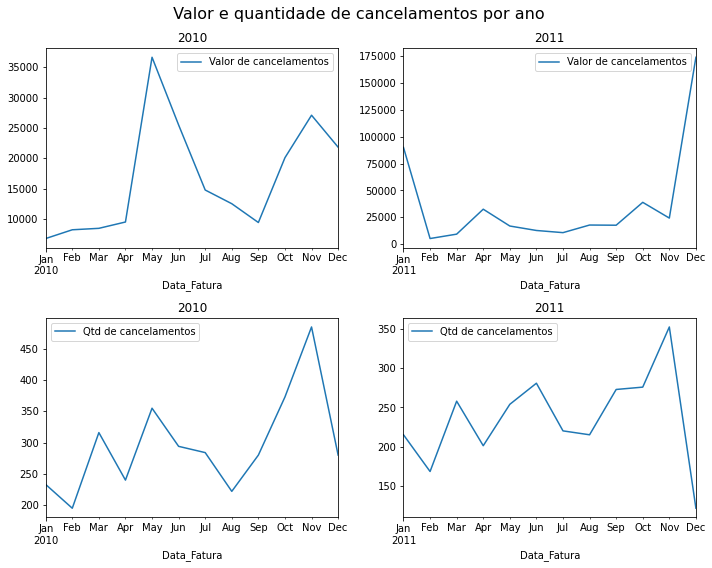

In [35]:
#Evolução dos cancelamentos
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
plt.suptitle(" Valor e quantidade de cancelamentos por ano", fontsize=16)

df_uk_mes[['Valor de cancelamentos']]['2010'].plot(ax=axs[0,0], title='2010')
df_uk_mes[['Valor de cancelamentos']]['2011'].plot(ax=axs[0,1], title='2011')
df_uk_mes[['Qtd de cancelamentos']]['2010'].plot(ax=axs[1,0], title='2010')
df_uk_mes[['Qtd de cancelamentos']]['2011'].plot(ax=axs[1,1], title='2011')


plt.tight_layout()
plt.show()

#### 5.2 Ticket_Medio_Valor e Ticket_Medio_Qtd_Itens por ano

In [36]:
df_uk2 = abs(base_varejo_uk[base_varejo_uk['Canceladas'] == 'Sim'].groupby(['Data_Fatura']).agg({'Vendas': 'sum','Fatura': 'nunique','Quantidade':'sum'}))
df_uk2 = df_uk2.rename(columns={'Vendas': 'Valor de cancelamentos','Fatura': 'Qtd de cancelamentos','Quantidade':'Qtd de itens cancelados'})
df_uk2

Valor de cancelamentos  Qtd de cancelamentos  \
Data_Fatura                                                 
2009-12-01                  1133.32                    36   
2009-12-02                   105.70                     7   
2009-12-03                  3541.12                    10   
2009-12-04                   279.65                    10   
2009-12-06                   296.44                    16   
...                             ...                   ...   
2011-12-05                  1314.78                    12   
2011-12-06                  2331.26                    28   
2011-12-07                   174.89                     9   
2011-12-08                   685.06                    16   
2011-12-09                168564.38                     4   

             Qtd de itens cancelados  
Data_Fatura                           
2009-12-01                       528  
2009-12-02                        14  
2009-12-03                      2191  
2009-12-04                        94  
2009-12-06                        62  
...                              ...  
2011-12-05                        77  
2011-12-06                      1029  
2011-12-07                        84  
2011-12-08                       416  
2011-12-09                     81029  

[595 rows x 3 columns]

In [37]:
df_uk2_mes = df_uk2[['Valor de cancelamentos','Qtd de cancelamentos','Qtd de itens cancelados']].resample('M').sum()
df_uk2_mes 

Valor de cancelamentos  Qtd de cancelamentos  \
Data_Fatura                                                 
2009-12-31                 17443.00                   338   
2010-01-31                  6786.37                   233   
2010-02-28                  8229.25                   195   
2010-03-31                  8468.05                   316   
2010-04-30                  9510.20                   240   
2010-05-31                 36663.84                   355   
2010-06-30                 25504.72                   294   
2010-07-31                 14783.45                   284   
2010-08-31                 12524.06                   222   
2010-09-30                  9427.12                   280   
2010-10-31                 20109.68                   373   
2010-11-30                 27110.51                   485   
2010-12-31                 21843.51                   280   
2011-01-31                 90123.81                   215   
2011-02-28                  5260.81                   168   
2011-03-31                  9344.46                   258   
2011-04-30                 32579.26                   201   
2011-05-31                 16911.67                   254   
2011-06-30                 12764.46                   281   
2011-07-31                 10744.16                   220   
2011-08-31                 17831.28                   215   
2011-09-30                 17660.56                   273   
2011-10-31                 38973.55                   276   
2011-11-30                 24307.12                   353   
2011-12-31                174102.81                   121   

             Qtd de itens cancelados  
Data_Fatura                           
2009-12-31                      8666  
2010-01-31                      2688  
2010-02-28                      3368  
2010-03-31                      3778  
2010-04-30                      5612  
2010-05-31                     15872  
2010-06-30                     15013  
2010-07-31                      4980  
2010-08-31                      6299  
2010-09-30                      4180  
2010-10-31                      8157  
2010-11-30                     12666  
2010-12-31                     26791  
2011-01-31                     79302  
2011-02-28                      1652  
2011-03-31                      3743  
2011-04-30                     12516  
2011-05-31                      4272  
2011-06-30                      6316  
2011-07-31                      5563  
2011-08-31                      8730  
2011-09-30                      6653  
2011-10-31                     20760  
2011-11-30                     10003  
2011-12-31                     83019

In [38]:
df_uk2_mes['Ticket_Media_Valor'] = df_uk2_mes['Valor de cancelamentos']/df_uk2_mes['Qtd de cancelamentos']
df_uk2_mes['Ticket_Media_Qtd_Itens'] = df_uk2_mes['Qtd de itens cancelados']/df_uk2_mes['Qtd de cancelamentos']

In [39]:
df_uk2_mes

Valor de cancelamentos  Qtd de cancelamentos  \
Data_Fatura                                                 
2009-12-31                 17443.00                   338   
2010-01-31                  6786.37                   233   
2010-02-28                  8229.25                   195   
2010-03-31                  8468.05                   316   
2010-04-30                  9510.20                   240   
2010-05-31                 36663.84                   355   
2010-06-30                 25504.72                   294   
2010-07-31                 14783.45                   284   
2010-08-31                 12524.06                   222   
2010-09-30                  9427.12                   280   
2010-10-31                 20109.68                   373   
2010-11-30                 27110.51                   485   
2010-12-31                 21843.51                   280   
2011-01-31                 90123.81                   215   
2011-02-28                  5260.81                   168   
2011-03-31                  9344.46                   258   
2011-04-30                 32579.26                   201   
2011-05-31                 16911.67                   254   
2011-06-30                 12764.46                   281   
2011-07-31                 10744.16                   220   
2011-08-31                 17831.28                   215   
2011-09-30                 17660.56                   273   
2011-10-31                 38973.55                   276   
2011-11-30                 24307.12                   353   
2011-12-31                174102.81                   121   

             Qtd de itens cancelados  Ticket_Media_Valor  \
Data_Fatura                                                
2009-12-31                      8666           51.606509   
2010-01-31                      2688           29.126052   
2010-02-28                      3368           42.201282   
2010-03-31                      3778           26.797627   
2010-04-30                      5612           39.625833   
2010-05-31                     15872          103.278423   
2010-06-30                     15013           86.750748   
2010-07-31                      4980           52.054401   
2010-08-31                      6299           56.414685   
2010-09-30                      4180           33.668286   
2010-10-31                      8157           53.913351   
2010-11-30                     12666           55.897959   
2010-12-31                     26791           78.012536   
2011-01-31                     79302          419.180512   
2011-02-28                      1652           31.314345   
2011-03-31                      3743           36.218837   
2011-04-30                     12516          162.085871   
2011-05-31                      4272           66.581378   
2011-06-30                      6316           45.425125   
2011-07-31                      5563           48.837091   
2011-08-31                      8730           82.936186   
2011-09-30                      6653           64.690696   
2011-10-31                     20760          141.208514   
2011-11-30                     10003           68.858697   
2011-12-31                     83019         1438.866198   

             Ticket_Media_Qtd_Itens  
Data_Fatura                          
2009-12-31                25.639053  
2010-01-31                11.536481  
2010-02-28                17.271795  
2010-03-31                11.955696  
2010-04-30                23.383333  
2010-05-31                44.709859  
2010-06-30                51.064626  
2010-07-31                17.535211  
2010-08-31                28.373874  
2010-09-30                14.928571  
2010-10-31                21.868633  
2010-11-30                26.115464  
2010-12-31                95.682143  
2011-01-31               368.846512  
2011-02-28                 9.833333  
2011-03-31                14.507752  
2011-04-30                62.268657  
2011-05-31            

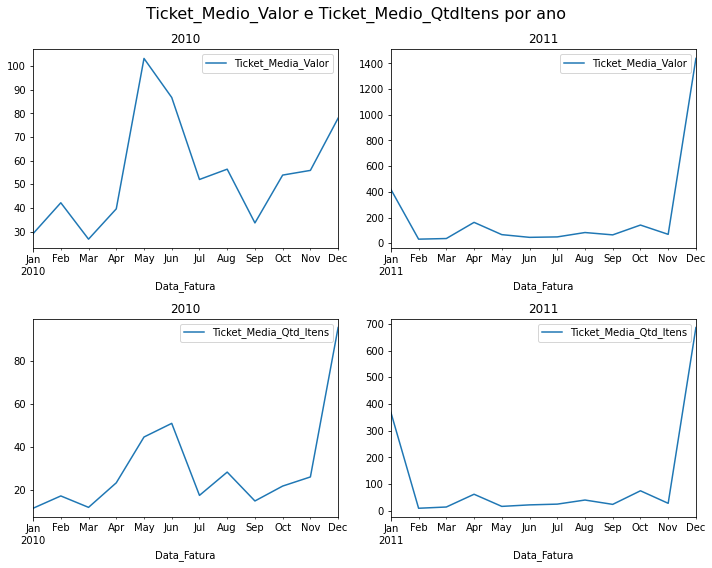

In [40]:
#Evolução dos cancelamentos
#Ticket_Medio_Valor e Ticket_Medio_Qtd_Itens por ano
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
plt.suptitle("Ticket_Medio_Valor e Ticket_Medio_QtdItens por ano", fontsize=16)

df_uk2_mes[['Ticket_Media_Valor']]['2010'].plot(ax=axs[0,0], title='2010')
df_uk2_mes[['Ticket_Media_Valor']]['2011'].plot(ax=axs[0,1], title='2011')
df_uk2_mes[['Ticket_Media_Qtd_Itens']]['2010'].plot(ax=axs[1,0], title='2010')
df_uk2_mes[['Ticket_Media_Qtd_Itens']]['2011'].plot(ax=axs[1,1], title='2011')


plt.tight_layout()
plt.show()

#### 5.3 Proporção de cancelamentos por ano

In [41]:
df_uk3 = abs(base_varejo_uk.groupby(['Data_Fatura']).agg({'Canceladas': lambda x: (x == "Sim").nunique(),'Fatura': 'nunique'}))
df_uk3['Proporção'] = df_uk3['Canceladas']/df_uk3['Fatura']
df_uk3_mes = df_uk3[['Proporção']].resample('M').sum()
df_uk3_mes

Proporção
Data_Fatura           
2009-12-31    0.678001
2010-01-31    1.089509
2010-02-28    1.017555
2010-03-31    0.911615
2010-04-30    0.784062
2010-05-31    0.761386
2010-06-30    0.928056
2010-07-31    0.990995
2010-08-31    1.021821
2010-09-30    0.828326
2010-10-31    0.619996
2010-11-30    0.513326
2010-12-31    0.785563
2011-01-31    1.149461
2011-02-28    1.157671
2011-03-31    1.125667
2011-04-30    0.785896
2011-05-31    0.854202
2011-06-30    0.937295
2011-07-31    1.036449
2011-08-31    1.079040
2011-09-30    0.798646
2011-10-31    0.767435
2011-11-30    0.514929
2011-12-31    0.188819

<AxesSubplot:title={'center':'2011'}, xlabel='Data_Fatura'>

<Figure size 432x288 with 0 Axes>

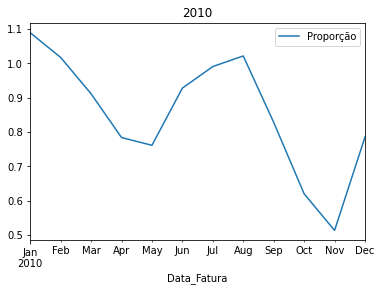

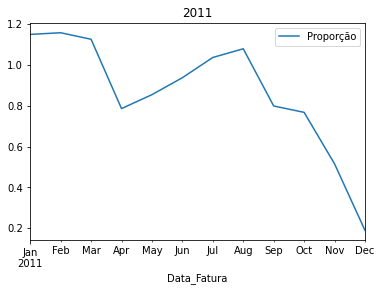

In [42]:
#Evolução de cancelamentos
#Proporção de cancelamentos por ano

plt.suptitle("Proporção de cancelamentos por ano", fontsize=16)

df_uk3_mes[['Proporção']]['2010'].plot(title='2010')
df_uk3_mes[['Proporção']]['2011'].plot(title='2011')

### 6.0 Produtos cancelados 

In [43]:
df_produtos = base_varejo_uk[(base_varejo_uk['Canceladas'] == 'Sim')].groupby(['Código_Estoque','Descrição']).agg({'Vendas': 'sum','Fatura': 'nunique','Quantidade':'sum'}).sort_values(by=['Vendas'])
df_produtos["%"] = df_produtos['Vendas']/df_produtos['Vendas'].sum() * 100
df_produtos["%_Acc"] = df_produtos["%"].cumsum()

In [44]:
df_produtos

Vendas  Fatura  \
Código_Estoque Descrição                                               
23843          PAPER CRAFT , LITTLE BIRDIE        -168469.60       1   
23166          MEDIUM CERAMIC TOP STORAGE JAR      -77446.31       6   
22423          REGENCY CAKESTAND 3 TIER            -13812.75     281   
D              Discount                            -11417.38     133   
POST           POSTAGE                             -10959.55     107   
...                                                      ...     ...   
20668          DISCO BALL CHRISTMAS DECORATION         -0.36       2   
23185          FRENCH STYLE STORAGE JAR JAM            -0.29       1   
21883          STARS GIFT TAPE                         -0.19       1   
35631B         BLUE GREEN CHRISTMAS HANGING BALL       -0.19       1   
85204          HANGING WOOD AND FELT FLOWER            -0.12       1   

                                                   Quantidade          %  \
Código_Estoque Descrição                                                   
23843          PAPER CRAFT , LITTLE BIRDIE             -80995  25.182012   
23166          MEDIUM CERAMIC TOP STORAGE JAR          -74467  11.576296   
22423          REGENCY CAKESTAND 3 TIER                 -1209   2.064662   
D              Discount                                 -3055   1.706614   
POST           POSTAGE                                   -110   1.638180   
...                                                       ...        ...   
20668          DISCO BALL CHRISTMAS DECORATION             -3   0.000054   
23185          FRENCH STYLE STORAGE JAR JAM                -1   0.000043   
21883          STARS GIFT TAPE                             -1   0.000028   
35631B         BLUE GREEN CHRISTMAS HANGING BALL           -1   0.000028   
85204          HANGING WOOD AND FELT FLOWER                -1   0.000018   

                                                        %_Acc  
Código_Estoque Descrição                                       
23843          PAPER CRAFT , LITTLE BIRDIE          25.182012  
23166          MEDIUM CERAMIC TOP STORAGE JAR       36.758307  
22423          REGENCY CAKESTAND 3 TIER             38.822970  
D              Discount                             40.529584  
POST           POSTAGE                              42.167764  
...                                                       ...  
20668          DISCO BALL CHRISTMAS DECORATION      99.999882  
23185          FRENCH STYLE STORAGE JAR JAM         99.999925  
21883          STARS GIFT TAPE                      99.999954  
35631B         BLUE GREEN CHRISTMAS HANGING BALL    99.999982  
85204          HANGING WOOD AND FELT FLOWER        100.000000  

[2819 rows x 5 columns]

In [45]:
lista_codigos = ['M','AMAZONFEE','BANK CHARGES','POST','D','CRUK','S']

In [46]:
df_produtos2 = base_varejo_uk[(base_varejo_uk['Canceladas'] == 'Sim') & (~base_varejo_uk['Código_Estoque'].isin(lista_codigos))].groupby(['Código_Estoque','Descrição']).agg({'Vendas': 'sum','Fatura': 'nunique','Quantidade':'sum'}).sort_values(by=['Vendas'])
df_produtos2["%"] = df_produtos2['Vendas']/df_produtos2['Vendas'].sum() * 100
df_produtos2["%_Acc"] = df_produtos2["%"].cumsum()

In [47]:
df_produtos2

Vendas  Fatura  \
Código_Estoque Descrição                                               
23843          PAPER CRAFT , LITTLE BIRDIE        -168469.60       1   
23166          MEDIUM CERAMIC TOP STORAGE JAR      -77446.31       6   
22423          REGENCY CAKESTAND 3 TIER            -13812.75     281   
85123A         WHITE HANGING HEART T-LIGHT HOLDER   -9193.00     129   
71477          COLOUR GLASS. STAR T-LIGHT HOLDER    -6949.01      57   
...                                                      ...     ...   
20668          DISCO BALL CHRISTMAS DECORATION         -0.36       2   
23185          FRENCH STYLE STORAGE JAR JAM            -0.29       1   
21883          STARS GIFT TAPE                         -0.19       1   
35631B         BLUE GREEN CHRISTMAS HANGING BALL       -0.19       1   
85204          HANGING WOOD AND FELT FLOWER            -0.12       1   

                                                   Quantidade          %  \
Código_Estoque Descrição                                                   
23843          PAPER CRAFT , LITTLE BIRDIE             -80995  26.382019   
23166          MEDIUM CERAMIC TOP STORAGE JAR          -74467  12.127945   
22423          REGENCY CAKESTAND 3 TIER                 -1209   2.163050   
85123A         WHITE HANGING HEART T-LIGHT HOLDER       -3567   1.439606   
71477          COLOUR GLASS. STAR T-LIGHT HOLDER        -2515   1.088202   
...                                                       ...        ...   
20668          DISCO BALL CHRISTMAS DECORATION             -3   0.000056   
23185          FRENCH STYLE STORAGE JAR JAM                -1   0.000045   
21883          STARS GIFT TAPE                             -1   0.000030   
35631B         BLUE GREEN CHRISTMAS HANGING BALL           -1   0.000030   
85204          HANGING WOOD AND FELT FLOWER                -1   0.000019   

                                                        %_Acc  
Código_Estoque Descrição                                       
23843          PAPER CRAFT , LITTLE BIRDIE          26.382019  
23166          MEDIUM CERAMIC TOP STORAGE JAR       38.509964  
22423          REGENCY CAKESTAND 3 TIER             40.673015  
85123A         WHITE HANGING HEART T-LIGHT HOLDER   42.112621  
71477          COLOUR GLASS. STAR T-LIGHT HOLDER    43.200823  
...                                                       ...  
20668          DISCO BALL CHRISTMAS DECORATION      99.999876  
23185          FRENCH STYLE STORAGE JAR JAM         99.999922  
21883          STARS GIFT TAPE                      99.999951  
35631B         BLUE GREEN CHRISTMAS HANGING BALL    99.999981  
85204          HANGING WOOD AND FELT FLOWER        100.000000  

[2814 rows x 5 columns]

### 7.0 Modelo

#### 7.1 Preparação da base de dados

In [ ]:
base_varejo_uk

In [48]:
base_modelo_aux = abs(base_varejo_uk.groupby(['Fatura','Dia_Semana','Faixa_Hora','Mês','ClienteID','Canceladas'])['Quantidade','Vendas','Preço','Código_Estoque'].agg({'Quantidade': 'sum','Vendas': 'sum','Preço':'mean','Código_Estoque':'nunique'}))
base_modelo_aux = base_modelo_aux.rename(columns={'Preço': 'Média_Preço','Código_Estoque':'Qtd_Itens_Distintos'})
base_modelo_aux = base_modelo_aux.reset_index()

In [49]:
base_modelo_aux

Fatura Dia_Semana Faixa_Hora  Mês ClienteID Canceladas  Quantidade  \
0       489434      Terça      Manhã   12     13085        Não         166   
1       489435      Terça      Manhã   12     13085        Não          60   
2       489436      Terça      Manhã   12     13078        Não         193   
3       489437      Terça      Manhã   12     15362        Não         145   
4       489438      Terça      Manhã   12     18102        Não         826   
...        ...        ...        ...  ...       ...        ...         ...   
40167  C581470     Quinta      Noite   12     17924        Sim           4   
40168  C581484      Sexta      Manhã   12     16446        Sim       80995   
40169  C581490      Sexta      Manhã   12     14397        Sim          23   
40170  C581568      Sexta      Manhã   12     15311        Sim           5   
40171  C581569      Sexta      Manhã   12     17315        Sim           6   

          Vendas  Média_Preço  Qtd_Itens_Distintos  
0         505.30     4.081250                    8  
1         145.80     2.625000                    4  
2         630.33     3.730526                   19  
3         310.75     3.628261                   23  
4        2286.24     2.591176                   17  
...          ...          ...                  ...  
40167       8.32     2.080000                    1  
40168  168469.60     2.080000                    1  
40169      32.53     1.390000                    2  
40170      54.75    10.950000                    1  
40171       7.50     1.250000                    2  

[40172 rows x 10 columns]

In [50]:
top50_percent_produtos = df_produtos2[df_produtos2['%_Acc']<= 50]
top50_percent_produtos = top50_percent_produtos.reset_index()
top50_percent_produtos

Código_Estoque                           Descrição     Vendas  Fatura  \
0           23843         PAPER CRAFT , LITTLE BIRDIE -168469.60       1   
1           23166      MEDIUM CERAMIC TOP STORAGE JAR  -77446.31       6   
2           22423            REGENCY CAKESTAND 3 TIER  -13812.75     281   
3          85123A  WHITE HANGING HEART T-LIGHT HOLDER   -9193.00     129   
4           71477   COLOUR GLASS. STAR T-LIGHT HOLDER   -6949.01      57   
5           21108  FAIRY CAKE FLANNEL ASSORTED COLOUR   -6614.37       4   
6          79323W                 WHITE CHERRY LIGHTS   -6297.55     117   
7          84078A    SET/4 WHITE RETRO STORAGE CUBES    -5007.90      18   
8           23113               PANTRY CHOPPING BOARD   -4803.06       6   
9           48185                  DOORMAT FAIRY CAKE   -4633.70       5   
10         47566B              TEA TIME PARTY BUNTING   -4490.50      11   
11          20971    PINK BLUE FELT CRAFT TRINKET BOX   -4111.83      11   
12         79323P                  PINK CHERRY LIGHTS   -4021.35      86   

    Quantidade          %      %_Acc  
0       -80995  26.382019  26.382019  
1       -74467  12.127945  38.509964  
2        -1209   2.163050  40.673015  
3        -3567   1.439606  42.112621  
4        -2515   1.088202  43.200823  
5        -3159   1.035798  44.236621  
6        -1067   0.986184  45.222805  
7         -142   0.784228  46.007033  
8         -946   0.752150  46.759183  
9         -686   0.725629  47.484811  
10       -1635   0.703204  48.188015  
11       -3866   0.643905  48.831920  
12        -693   0.629736  49.461656

In [51]:
lista_produtos = list(top50_percent_produtos['Código_Estoque'])
lista_produtos

['23843',
 '23166',
 '22423',
 '85123A',
 '71477',
 '21108',
 '79323W',
 '84078A',
 '23113',
 '48185',
 '47566B',
 '20971',
 '79323P']

In [52]:
pivot_table = abs(pd.pivot_table(base_varejo_uk[base_varejo_uk['Código_Estoque'].isin(lista_produtos)], values='Quantidade', index=['Fatura','Dia_Semana','Faixa_Hora','Mês','ClienteID','Canceladas'], columns='Código_Estoque', aggfunc='sum'))
pivot_table = pivot_table.fillna(0)
pivot_table = pivot_table.reset_index()

In [53]:
pivot_table 

Código_Estoque   Fatura Dia_Semana Faixa_Hora  Mês ClienteID Canceladas  \
0                489434      Terça      Manhã   12     13085        Não   
1                489437      Terça      Manhã   12     15362        Não   
2                489442      Terça      Manhã   12     13635        Não   
3                489446      Terça      Manhã   12     13758        Não   
4                489460      Terça      Manhã   12     16167        Não   
...                 ...        ...        ...  ...       ...        ...   
10372           C580805      Terça      Manhã   12     16764        Sim   
10373           C581228     Quinta      Manhã   12     16019        Sim   
10374           C581235     Quinta      Manhã   12     15950        Sim   
10375           C581464     Quinta      Noite   12     15951        Sim   
10376           C581484      Sexta      Manhã   12     16446        Sim   

Código_Estoque  20971  21108  22423  23113  23166    23843  47566B  48185  \
0                 0.0    0.0    0.0    0.0    0.0      0.0     0.0    0.0   
1                12.0    0.0    0.0    0.0    0.0      0.0     0.0    0.0   
2                 0.0    0.0    0.0    0.0    0.0      0.0     0.0    0.0   
3                 0.0    0.0    0.0    0.0    0.0      0.0     0.0    0.0   
4                 0.0    0.0    0.0    0.0    0.0      0.0     0.0    0.0   
...               ...    ...    ...    ...    ...      ...     ...    ...   
10372             0.0    0.0    0.0    0.0    0.0      0.0     0.0    0.0   
10373             0.0    0.0    6.0    0.0    0.0      0.0     0.0    0.0   
10374             0.0    0.0    1.0    0.0    0.0      0.0     0.0    0.0   
10375             0.0    0.0    0.0    0.0    0.0      0.0     0.0    0.0   
10376             0.0    0.0    0.0    0.0    0.0  80995.0     0.0    0.0   

Código_Estoque  71477  79323P  79323W  84078A  85123A  
0                 0.0    12.0    12.0     0.0     0.0  
1                 0.0     0.0     0.0     0.0     0.0  
2                 0.0     0.0     0.0     0.0     6.0  
3                 0.0     0.0     0.0     0.0    32.0  
4                 0.0     8.0     8.0     0.0     0.0  
...               ...     ...     ...     ...     ...  
10372             0.0     0.0     0.0     0.0     1.0  
10373             0.0     0.0     0.0     0.0     0.0  
10374             0.0     0.0     0.0     0.0     0.0  
10375             6.0     0.0     0.0     0.0     0.0  
10376             0.0     0.0     0.0     0.0     0.0  

[10377 rows x 19 columns]

In [58]:
base_modelo = pd.merge(base_modelo_aux, pivot_table , on = ['Fatura','Dia_Semana','Faixa_Hora','Mês','ClienteID','Canceladas'], how = 'left')
base_modelo = base_modelo.fillna(0)

In [75]:
#alterando tipo para int
base_modelo['20971'] = base_modelo['20971'].astype('int')
base_modelo['21108'] = base_modelo['21108'].astype('int')
base_modelo['22423'] = base_modelo['22423'].astype('int')
base_modelo['23113'] = base_modelo['23113'].astype('int')
base_modelo['23166'] = base_modelo['23166'].astype('int')
base_modelo['23843'] = base_modelo['23843'].astype('int')
base_modelo['47566B'] = base_modelo['47566B'].astype('int')
base_modelo['48185'] = base_modelo['48185'].astype('int')
base_modelo['71477'] = base_modelo['71477'].astype('int')
base_modelo['79323P'] = base_modelo['79323P'].astype('int')
base_modelo['79323W'] = base_modelo['79323W'].astype('int')
base_modelo['84078A'] = base_modelo['84078A'].astype('int')
base_modelo['85123A'] = base_modelo['85123A'].astype('int')

In [76]:
base_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40172 entries, 0 to 40171
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Fatura               40172 non-null  object 
 1   Dia_Semana           40172 non-null  object 
 2   Faixa_Hora           40172 non-null  object 
 3   Mês                  40172 non-null  int64  
 4   ClienteID            40172 non-null  object 
 5   Canceladas           40172 non-null  object 
 6   Quantidade           40172 non-null  int64  
 7   Vendas               40172 non-null  float64
 8   Média_Preço          40172 non-null  float64
 9   Qtd_Itens_Distintos  40172 non-null  int64  
 10  20971                40172 non-null  int32  
 11  21108                40172 non-null  int32  
 12  22423                40172 non-null  int32  
 13  23113                40172 non-null  int32  
 14  23166                40172 non-null  int32  
 15  23843                40172 non-null 

In [77]:
base_modelo

Fatura Dia_Semana Faixa_Hora  Mês ClienteID Canceladas  Quantidade  \
0       489434      Terça      Manhã   12     13085        Não         166   
1       489435      Terça      Manhã   12     13085        Não          60   
2       489436      Terça      Manhã   12     13078        Não         193   
3       489437      Terça      Manhã   12     15362        Não         145   
4       489438      Terça      Manhã   12     18102        Não         826   
...        ...        ...        ...  ...       ...        ...         ...   
40167  C581470     Quinta      Noite   12     17924        Sim           4   
40168  C581484      Sexta      Manhã   12     16446        Sim       80995   
40169  C581490      Sexta      Manhã   12     14397        Sim          23   
40170  C581568      Sexta      Manhã   12     15311        Sim           5   
40171  C581569      Sexta      Manhã   12     17315        Sim           6   

          Vendas  Média_Preço  Qtd_Itens_Distintos  ...  23113  23166  23843  \
0         505.30     4.081250                    8  ...      0      0      0   
1         145.80     2.625000                    4  ...      0      0      0   
2         630.33     3.730526                   19  ...      0      0      0   
3         310.75     3.628261                   23  ...      0      0      0   
4        2286.24     2.591176                   17  ...      0      0      0   
...          ...          ...                  ...  ...    ...    ...    ...   
40167       8.32     2.080000                    1  ...      0      0      0   
40168  168469.60     2.080000                    1  ...      0      0  80995   
40169      32.53     1.390000                    2  ...      0      0      0   
40170      54.75    10.950000                    1  ...      0      0      0   
40171       7.50     1.250000                    2  ...      0      0      0   

       47566B  48185  71477  79323P  79323W  84078A  85123A  
0           0      0      0      12      12       0       0  
1           0      0      0       0       0       0       0  
2           0      0      0       0       0       0       0  
3           0      0      0       0       0       0       0  
4           0      0      0       0       0       0       0  
...       ...    ...    ...     ...     ...     ...     ...  
40167       0      0      0       0       0       0       0  
40168       0      0      0       0       0       0       0  
40169       0      0      0       0       0       0       0  
40170       0      0      0       0       0       0       0  
40171       0      0      0       0       0       0       0  

[40172 rows x 23 columns]

#### 7.2 Treinamento do modelo

In [78]:
# Split X e Y
X = base_modelo.drop(['Canceladas','Fatura'],axis = 1)
y = base_modelo.Canceladas

#split treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [79]:
cat_features = ['Dia_Semana', 'Faixa_Hora','ClienteID']

In [80]:
# modelo
modelo = CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, cat_features=cat_features)

In [81]:
# Defina a grade de hiperparâmetros a serem testados
params = {
    'iterations': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 1],
    'depth': [4, 6, 8],
    }   

In [82]:
#Criar objeto KFold com StratifiedKFold para validação cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 1)

#Criar um objeto de grade de busca com GridSearchCV, a partir dos parâmetros que definimos
grid_search = GridSearchCV(modelo, param_grid = params, scoring = 'roc_auc',
                           cv = skf.split(X_train, y_train))

#Treinar o modelo com o grid search
grid_search.fit(X_train, y_train)

# Printar a melhor combinação de hiperparâmetros
print('Melhores hiperparâmetros:')
print(grid_search.best_params_)

0:	learn: 0.6786841	total: 17.3ms	remaining: 1.71s
1:	learn: 0.6636532	total: 35.1ms	remaining: 1.72s
2:	learn: 0.6506013	total: 53.3ms	remaining: 1.72s
3:	learn: 0.6364409	total: 71.7ms	remaining: 1.72s
4:	learn: 0.6230858	total: 92.3ms	remaining: 1.75s
5:	learn: 0.6105247	total: 113ms	remaining: 1.77s
6:	learn: 0.5996162	total: 126ms	remaining: 1.68s
7:	learn: 0.5867713	total: 144ms	remaining: 1.66s
8:	learn: 0.5754382	total: 162ms	remaining: 1.64s
9:	learn: 0.5658132	total: 180ms	remaining: 1.62s
10:	learn: 0.5557270	total: 198ms	remaining: 1.6s
11:	learn: 0.5437790	total: 219ms	remaining: 1.61s
12:	learn: 0.5334752	total: 238ms	remaining: 1.59s
13:	learn: 0.5236260	total: 253ms	remaining: 1.55s
14:	learn: 0.5134252	total: 271ms	remaining: 1.53s
15:	learn: 0.5040397	total: 288ms	remaining: 1.51s
16:	learn: 0.4946513	total: 307ms	remaining: 1.5s
17:	learn: 0.4856882	total: 325ms	remaining: 1.48s
18:	learn: 0.4768794	total: 342ms	remaining: 1.46s
19:	learn: 0.4685381	total: 359ms	rema

62:	learn: 0.2788744	total: 1.19s	remaining: 698ms
63:	learn: 0.2762205	total: 1.2s	remaining: 678ms
64:	learn: 0.2742068	total: 1.22s	remaining: 657ms
65:	learn: 0.2722219	total: 1.24s	remaining: 637ms
66:	learn: 0.2701064	total: 1.25s	remaining: 617ms
67:	learn: 0.2677160	total: 1.27s	remaining: 596ms
68:	learn: 0.2656769	total: 1.28s	remaining: 576ms
69:	learn: 0.2635826	total: 1.3s	remaining: 556ms
70:	learn: 0.2621548	total: 1.31s	remaining: 536ms
71:	learn: 0.2605613	total: 1.33s	remaining: 516ms
72:	learn: 0.2585773	total: 1.34s	remaining: 496ms
73:	learn: 0.2571141	total: 1.36s	remaining: 477ms
74:	learn: 0.2549519	total: 1.37s	remaining: 458ms
75:	learn: 0.2537060	total: 1.39s	remaining: 438ms
76:	learn: 0.2519928	total: 1.41s	remaining: 420ms
77:	learn: 0.2503957	total: 1.42s	remaining: 401ms
78:	learn: 0.2488642	total: 1.44s	remaining: 382ms
79:	learn: 0.2473914	total: 1.45s	remaining: 363ms
80:	learn: 0.2461724	total: 1.47s	remaining: 344ms
81:	learn: 0.2446298	total: 1.48s

29:	learn: 0.4032538	total: 634ms	remaining: 1.48s
30:	learn: 0.3972771	total: 650ms	remaining: 1.45s
31:	learn: 0.3911242	total: 667ms	remaining: 1.42s
32:	learn: 0.3850818	total: 683ms	remaining: 1.39s
33:	learn: 0.3801152	total: 699ms	remaining: 1.36s
34:	learn: 0.3754917	total: 715ms	remaining: 1.33s
35:	learn: 0.3706167	total: 731ms	remaining: 1.3s
36:	learn: 0.3654038	total: 747ms	remaining: 1.27s
37:	learn: 0.3611659	total: 763ms	remaining: 1.24s
38:	learn: 0.3567071	total: 778ms	remaining: 1.22s
39:	learn: 0.3527620	total: 794ms	remaining: 1.19s
40:	learn: 0.3481750	total: 812ms	remaining: 1.17s
41:	learn: 0.3439864	total: 830ms	remaining: 1.15s
42:	learn: 0.3401702	total: 846ms	remaining: 1.12s
43:	learn: 0.3365563	total: 859ms	remaining: 1.09s
44:	learn: 0.3318197	total: 875ms	remaining: 1.07s
45:	learn: 0.3282439	total: 891ms	remaining: 1.04s
46:	learn: 0.3243317	total: 906ms	remaining: 1.02s
47:	learn: 0.3206673	total: 922ms	remaining: 999ms
48:	learn: 0.3170407	total: 937m

96:	learn: 0.2280223	total: 1.73s	remaining: 53.5ms
97:	learn: 0.2271923	total: 1.75s	remaining: 35.7ms
98:	learn: 0.2264458	total: 1.77s	remaining: 17.8ms
99:	learn: 0.2254380	total: 1.78s	remaining: 0us
0:	learn: 0.5611384	total: 19.2ms	remaining: 1.9s
1:	learn: 0.4554621	total: 37.7ms	remaining: 1.84s
2:	learn: 0.3867307	total: 58.9ms	remaining: 1.9s
3:	learn: 0.3359571	total: 77.2ms	remaining: 1.85s
4:	learn: 0.3113758	total: 89.8ms	remaining: 1.71s
5:	learn: 0.2828656	total: 108ms	remaining: 1.7s
6:	learn: 0.2554185	total: 127ms	remaining: 1.68s
7:	learn: 0.2435750	total: 145ms	remaining: 1.67s
8:	learn: 0.2293095	total: 163ms	remaining: 1.65s
9:	learn: 0.2202650	total: 181ms	remaining: 1.63s
10:	learn: 0.2127323	total: 198ms	remaining: 1.6s
11:	learn: 0.2072543	total: 212ms	remaining: 1.56s
12:	learn: 0.2023550	total: 230ms	remaining: 1.54s
13:	learn: 0.1969052	total: 246ms	remaining: 1.51s
14:	learn: 0.1937201	total: 261ms	remaining: 1.48s
15:	learn: 0.1911384	total: 276ms	remai

60:	learn: 0.1696983	total: 1.21s	remaining: 773ms
61:	learn: 0.1696775	total: 1.23s	remaining: 753ms
62:	learn: 0.1696618	total: 1.25s	remaining: 731ms
63:	learn: 0.1693697	total: 1.26s	remaining: 710ms
64:	learn: 0.1693308	total: 1.28s	remaining: 689ms
65:	learn: 0.1693009	total: 1.3s	remaining: 668ms
66:	learn: 0.1692079	total: 1.31s	remaining: 647ms
67:	learn: 0.1691845	total: 1.33s	remaining: 627ms
68:	learn: 0.1691726	total: 1.35s	remaining: 606ms
69:	learn: 0.1691579	total: 1.37s	remaining: 586ms
70:	learn: 0.1690221	total: 1.38s	remaining: 565ms
71:	learn: 0.1688439	total: 1.4s	remaining: 544ms
72:	learn: 0.1688151	total: 1.42s	remaining: 524ms
73:	learn: 0.1685609	total: 1.43s	remaining: 503ms
74:	learn: 0.1684282	total: 1.45s	remaining: 483ms
75:	learn: 0.1681750	total: 1.47s	remaining: 463ms
76:	learn: 0.1680618	total: 1.49s	remaining: 444ms
77:	learn: 0.1680479	total: 1.5s	remaining: 424ms
78:	learn: 0.1680277	total: 1.52s	remaining: 405ms
79:	learn: 0.1677636	total: 1.54s	

25:	learn: 0.1777612	total: 399ms	remaining: 1.14s
26:	learn: 0.1768851	total: 415ms	remaining: 1.12s
27:	learn: 0.1763835	total: 430ms	remaining: 1.11s
28:	learn: 0.1759522	total: 446ms	remaining: 1.09s
29:	learn: 0.1756254	total: 461ms	remaining: 1.07s
30:	learn: 0.1753145	total: 476ms	remaining: 1.06s
31:	learn: 0.1748708	total: 492ms	remaining: 1.04s
32:	learn: 0.1742641	total: 506ms	remaining: 1.03s
33:	learn: 0.1738062	total: 521ms	remaining: 1.01s
34:	learn: 0.1733226	total: 536ms	remaining: 996ms
35:	learn: 0.1728466	total: 551ms	remaining: 980ms
36:	learn: 0.1726618	total: 566ms	remaining: 964ms
37:	learn: 0.1723733	total: 583ms	remaining: 952ms
38:	learn: 0.1722305	total: 599ms	remaining: 936ms
39:	learn: 0.1719925	total: 614ms	remaining: 921ms
40:	learn: 0.1714897	total: 629ms	remaining: 905ms
41:	learn: 0.1714425	total: 645ms	remaining: 891ms
42:	learn: 0.1713602	total: 660ms	remaining: 875ms
43:	learn: 0.1712955	total: 675ms	remaining: 859ms
44:	learn: 0.1710947	total: 690

91:	learn: 0.1667373	total: 1.53s	remaining: 133ms
92:	learn: 0.1667238	total: 1.55s	remaining: 117ms
93:	learn: 0.1667032	total: 1.56s	remaining: 99.8ms
94:	learn: 0.1666350	total: 1.58s	remaining: 83.1ms
95:	learn: 0.1666293	total: 1.59s	remaining: 66.3ms
96:	learn: 0.1665900	total: 1.6s	remaining: 49.6ms
97:	learn: 0.1665788	total: 1.62s	remaining: 33.1ms
98:	learn: 0.1664303	total: 1.63s	remaining: 16.5ms
99:	learn: 0.1663466	total: 1.65s	remaining: 0us
0:	learn: 0.2083428	total: 14.6ms	remaining: 1.44s
1:	learn: 0.1967920	total: 28.5ms	remaining: 1.4s
2:	learn: 0.1857060	total: 44.8ms	remaining: 1.45s
3:	learn: 0.1809425	total: 63.1ms	remaining: 1.51s
4:	learn: 0.1782581	total: 80.2ms	remaining: 1.52s
5:	learn: 0.1754018	total: 94.8ms	remaining: 1.48s
6:	learn: 0.1737221	total: 111ms	remaining: 1.48s
7:	learn: 0.1711734	total: 127ms	remaining: 1.46s
8:	learn: 0.1709225	total: 142ms	remaining: 1.44s
9:	learn: 0.1690465	total: 158ms	remaining: 1.42s
10:	learn: 0.1680932	total: 173ms

61:	learn: 0.1454400	total: 959ms	remaining: 588ms
62:	learn: 0.1453502	total: 975ms	remaining: 572ms
63:	learn: 0.1450368	total: 990ms	remaining: 557ms
64:	learn: 0.1447296	total: 1s	remaining: 541ms
65:	learn: 0.1443447	total: 1.02s	remaining: 525ms
66:	learn: 0.1442238	total: 1.03s	remaining: 510ms
67:	learn: 0.1438579	total: 1.05s	remaining: 494ms
68:	learn: 0.1434922	total: 1.06s	remaining: 478ms
69:	learn: 0.1434873	total: 1.08s	remaining: 463ms
70:	learn: 0.1433502	total: 1.09s	remaining: 447ms
71:	learn: 0.1430848	total: 1.11s	remaining: 432ms
72:	learn: 0.1426675	total: 1.13s	remaining: 416ms
73:	learn: 0.1423141	total: 1.14s	remaining: 401ms
74:	learn: 0.1420731	total: 1.16s	remaining: 386ms
75:	learn: 0.1418090	total: 1.17s	remaining: 371ms
76:	learn: 0.1417640	total: 1.19s	remaining: 355ms
77:	learn: 0.1412957	total: 1.21s	remaining: 340ms
78:	learn: 0.1412793	total: 1.22s	remaining: 325ms
79:	learn: 0.1406422	total: 1.24s	remaining: 309ms
80:	learn: 0.1405261	total: 1.25s	

26:	learn: 0.1595360	total: 413ms	remaining: 1.12s
27:	learn: 0.1594871	total: 429ms	remaining: 1.1s
28:	learn: 0.1589871	total: 444ms	remaining: 1.09s
29:	learn: 0.1583297	total: 459ms	remaining: 1.07s
30:	learn: 0.1579606	total: 474ms	remaining: 1.05s
31:	learn: 0.1578934	total: 489ms	remaining: 1.04s
32:	learn: 0.1574835	total: 504ms	remaining: 1.02s
33:	learn: 0.1571144	total: 519ms	remaining: 1.01s
34:	learn: 0.1567555	total: 534ms	remaining: 992ms
35:	learn: 0.1567058	total: 549ms	remaining: 977ms
36:	learn: 0.1564287	total: 564ms	remaining: 961ms
37:	learn: 0.1558552	total: 579ms	remaining: 945ms
38:	learn: 0.1553513	total: 597ms	remaining: 933ms
39:	learn: 0.1550892	total: 611ms	remaining: 917ms
40:	learn: 0.1545373	total: 627ms	remaining: 902ms
41:	learn: 0.1540882	total: 641ms	remaining: 885ms
42:	learn: 0.1540222	total: 656ms	remaining: 870ms
43:	learn: 0.1532865	total: 676ms	remaining: 860ms
44:	learn: 0.1529887	total: 695ms	remaining: 850ms
45:	learn: 0.1527722	total: 715m

97:	learn: 0.1392163	total: 1.51s	remaining: 30.9ms
98:	learn: 0.1388092	total: 1.53s	remaining: 15.5ms
99:	learn: 0.1384804	total: 1.54s	remaining: 0us
0:	learn: 0.6786955	total: 18.9ms	remaining: 3.76s
1:	learn: 0.6643450	total: 38ms	remaining: 3.76s
2:	learn: 0.6516908	total: 59.8ms	remaining: 3.92s
3:	learn: 0.6386980	total: 78.8ms	remaining: 3.86s
4:	learn: 0.6254219	total: 97.4ms	remaining: 3.8s
5:	learn: 0.6121216	total: 117ms	remaining: 3.79s
6:	learn: 0.6002338	total: 135ms	remaining: 3.73s
7:	learn: 0.5887443	total: 153ms	remaining: 3.68s
8:	learn: 0.5776605	total: 172ms	remaining: 3.64s
9:	learn: 0.5656339	total: 190ms	remaining: 3.6s
10:	learn: 0.5552877	total: 215ms	remaining: 3.69s
11:	learn: 0.5446233	total: 238ms	remaining: 3.73s
12:	learn: 0.5341699	total: 258ms	remaining: 3.71s
13:	learn: 0.5227610	total: 279ms	remaining: 3.71s
14:	learn: 0.5127983	total: 300ms	remaining: 3.7s
15:	learn: 0.5020323	total: 320ms	remaining: 3.68s
16:	learn: 0.4932777	total: 341ms	remaini

160:	learn: 0.1920405	total: 3.32s	remaining: 804ms
161:	learn: 0.1917149	total: 3.34s	remaining: 783ms
162:	learn: 0.1913439	total: 3.36s	remaining: 763ms
163:	learn: 0.1909041	total: 3.38s	remaining: 742ms
164:	learn: 0.1907894	total: 3.4s	remaining: 722ms
165:	learn: 0.1905270	total: 3.42s	remaining: 701ms
166:	learn: 0.1902965	total: 3.45s	remaining: 681ms
167:	learn: 0.1900413	total: 3.47s	remaining: 661ms
168:	learn: 0.1897718	total: 3.49s	remaining: 641ms
169:	learn: 0.1894727	total: 3.51s	remaining: 620ms
170:	learn: 0.1892245	total: 3.53s	remaining: 599ms
171:	learn: 0.1890403	total: 3.55s	remaining: 578ms
172:	learn: 0.1888337	total: 3.57s	remaining: 557ms
173:	learn: 0.1884958	total: 3.59s	remaining: 537ms
174:	learn: 0.1882285	total: 3.61s	remaining: 515ms
175:	learn: 0.1879559	total: 3.63s	remaining: 494ms
176:	learn: 0.1876971	total: 3.64s	remaining: 474ms
177:	learn: 0.1874507	total: 3.67s	remaining: 453ms
178:	learn: 0.1872177	total: 3.68s	remaining: 432ms
179:	learn: 0

127:	learn: 0.2063479	total: 2.36s	remaining: 1.32s
128:	learn: 0.2059282	total: 2.38s	remaining: 1.31s
129:	learn: 0.2054685	total: 2.39s	remaining: 1.29s
130:	learn: 0.2050710	total: 2.41s	remaining: 1.27s
131:	learn: 0.2047034	total: 2.43s	remaining: 1.25s
132:	learn: 0.2043377	total: 2.45s	remaining: 1.23s
133:	learn: 0.2040260	total: 2.46s	remaining: 1.21s
134:	learn: 0.2035810	total: 2.48s	remaining: 1.2s
135:	learn: 0.2031367	total: 2.5s	remaining: 1.18s
136:	learn: 0.2026390	total: 2.52s	remaining: 1.16s
137:	learn: 0.2021632	total: 2.54s	remaining: 1.14s
138:	learn: 0.2018247	total: 2.56s	remaining: 1.12s
139:	learn: 0.2013386	total: 2.57s	remaining: 1.1s
140:	learn: 0.2009071	total: 2.59s	remaining: 1.08s
141:	learn: 0.2004399	total: 2.61s	remaining: 1.06s
142:	learn: 0.2000187	total: 2.63s	remaining: 1.05s
143:	learn: 0.1996822	total: 2.64s	remaining: 1.03s
144:	learn: 0.1991913	total: 2.66s	remaining: 1.01s
145:	learn: 0.1988888	total: 2.68s	remaining: 991ms
146:	learn: 0.1

95:	learn: 0.2317647	total: 1.8s	remaining: 1.95s
96:	learn: 0.2306832	total: 1.82s	remaining: 1.93s
97:	learn: 0.2297859	total: 1.83s	remaining: 1.91s
98:	learn: 0.2286607	total: 1.85s	remaining: 1.89s
99:	learn: 0.2278088	total: 1.87s	remaining: 1.87s
100:	learn: 0.2270584	total: 1.89s	remaining: 1.85s
101:	learn: 0.2263864	total: 1.91s	remaining: 1.83s
102:	learn: 0.2254553	total: 1.93s	remaining: 1.82s
103:	learn: 0.2246160	total: 1.95s	remaining: 1.8s
104:	learn: 0.2238026	total: 1.97s	remaining: 1.78s
105:	learn: 0.2229467	total: 1.99s	remaining: 1.76s
106:	learn: 0.2223625	total: 2s	remaining: 1.74s
107:	learn: 0.2218494	total: 2.02s	remaining: 1.73s
108:	learn: 0.2209443	total: 2.04s	remaining: 1.71s
109:	learn: 0.2200513	total: 2.06s	remaining: 1.69s
110:	learn: 0.2192906	total: 2.08s	remaining: 1.67s
111:	learn: 0.2186923	total: 2.11s	remaining: 1.66s
112:	learn: 0.2179998	total: 2.13s	remaining: 1.64s
113:	learn: 0.2173225	total: 2.15s	remaining: 1.62s
114:	learn: 0.2166156	

65:	learn: 0.2719580	total: 1.18s	remaining: 2.4s
66:	learn: 0.2695714	total: 1.21s	remaining: 2.39s
67:	learn: 0.2678601	total: 1.23s	remaining: 2.38s
68:	learn: 0.2659711	total: 1.25s	remaining: 2.37s
69:	learn: 0.2639893	total: 1.27s	remaining: 2.36s
70:	learn: 0.2622051	total: 1.29s	remaining: 2.34s
71:	learn: 0.2603343	total: 1.31s	remaining: 2.32s
72:	learn: 0.2587511	total: 1.32s	remaining: 2.3s
73:	learn: 0.2568687	total: 1.34s	remaining: 2.29s
74:	learn: 0.2548787	total: 1.36s	remaining: 2.27s
75:	learn: 0.2528770	total: 1.38s	remaining: 2.25s
76:	learn: 0.2513760	total: 1.4s	remaining: 2.23s
77:	learn: 0.2496806	total: 1.42s	remaining: 2.22s
78:	learn: 0.2481468	total: 1.44s	remaining: 2.2s
79:	learn: 0.2469753	total: 1.45s	remaining: 2.18s
80:	learn: 0.2458152	total: 1.47s	remaining: 2.16s
81:	learn: 0.2446863	total: 1.49s	remaining: 2.14s
82:	learn: 0.2433204	total: 1.5s	remaining: 2.12s
83:	learn: 0.2420553	total: 1.52s	remaining: 2.1s
84:	learn: 0.2405026	total: 1.54s	rem

31:	learn: 0.3954948	total: 1.05s	remaining: 5.51s
32:	learn: 0.3895730	total: 1.07s	remaining: 5.44s
33:	learn: 0.3852402	total: 1.09s	remaining: 5.32s
34:	learn: 0.3798039	total: 1.11s	remaining: 5.24s
35:	learn: 0.3743807	total: 1.14s	remaining: 5.18s
36:	learn: 0.3694355	total: 1.16s	remaining: 5.13s
37:	learn: 0.3652501	total: 1.19s	remaining: 5.07s
38:	learn: 0.3596771	total: 1.22s	remaining: 5.02s
39:	learn: 0.3553189	total: 1.24s	remaining: 4.97s
40:	learn: 0.3511417	total: 1.27s	remaining: 4.93s
41:	learn: 0.3471643	total: 1.3s	remaining: 4.89s
42:	learn: 0.3430575	total: 1.32s	remaining: 4.83s
43:	learn: 0.3391732	total: 1.35s	remaining: 4.78s
44:	learn: 0.3346905	total: 1.37s	remaining: 4.72s
45:	learn: 0.3300438	total: 1.4s	remaining: 4.69s
46:	learn: 0.3254916	total: 1.43s	remaining: 4.64s
47:	learn: 0.3224290	total: 1.45s	remaining: 4.6s
48:	learn: 0.3194600	total: 1.48s	remaining: 4.56s
49:	learn: 0.3171607	total: 1.5s	remaining: 4.49s
50:	learn: 0.3146260	total: 1.52s	r

197:	learn: 0.1862081	total: 5.33s	remaining: 53.8ms
198:	learn: 0.1860513	total: 5.35s	remaining: 26.9ms
199:	learn: 0.1858600	total: 5.37s	remaining: 0us
0:	learn: 0.5612349	total: 18.6ms	remaining: 3.71s
1:	learn: 0.4637338	total: 38.9ms	remaining: 3.85s
2:	learn: 0.3997636	total: 58.1ms	remaining: 3.82s
3:	learn: 0.3395737	total: 77.2ms	remaining: 3.78s
4:	learn: 0.3112192	total: 99.8ms	remaining: 3.89s
5:	learn: 0.2815385	total: 121ms	remaining: 3.91s
6:	learn: 0.2628760	total: 141ms	remaining: 3.9s
7:	learn: 0.2476370	total: 163ms	remaining: 3.92s
8:	learn: 0.2324109	total: 184ms	remaining: 3.91s
9:	learn: 0.2212653	total: 205ms	remaining: 3.9s
10:	learn: 0.2151350	total: 227ms	remaining: 3.9s
11:	learn: 0.2096491	total: 249ms	remaining: 3.9s
12:	learn: 0.2029796	total: 270ms	remaining: 3.88s
13:	learn: 0.1990446	total: 293ms	remaining: 3.89s
14:	learn: 0.1944704	total: 315ms	remaining: 3.88s
15:	learn: 0.1909736	total: 335ms	remaining: 3.85s
16:	learn: 0.1881043	total: 357ms	rem

159:	learn: 0.1561731	total: 3.4s	remaining: 850ms
160:	learn: 0.1560992	total: 3.42s	remaining: 829ms
161:	learn: 0.1560852	total: 3.44s	remaining: 808ms
162:	learn: 0.1559654	total: 3.47s	remaining: 787ms
163:	learn: 0.1558838	total: 3.49s	remaining: 765ms
164:	learn: 0.1558292	total: 3.51s	remaining: 745ms
165:	learn: 0.1557403	total: 3.53s	remaining: 723ms
166:	learn: 0.1554648	total: 3.55s	remaining: 702ms
167:	learn: 0.1554572	total: 3.58s	remaining: 682ms
168:	learn: 0.1553488	total: 3.6s	remaining: 660ms
169:	learn: 0.1552347	total: 3.62s	remaining: 639ms
170:	learn: 0.1552267	total: 3.64s	remaining: 618ms
171:	learn: 0.1550812	total: 3.66s	remaining: 596ms
172:	learn: 0.1550668	total: 3.68s	remaining: 575ms
173:	learn: 0.1550289	total: 3.7s	remaining: 554ms
174:	learn: 0.1549475	total: 3.73s	remaining: 533ms
175:	learn: 0.1548924	total: 3.75s	remaining: 512ms
176:	learn: 0.1548467	total: 3.78s	remaining: 491ms
177:	learn: 0.1548432	total: 3.8s	remaining: 470ms
178:	learn: 0.15

126:	learn: 0.1602746	total: 2.73s	remaining: 1.57s
127:	learn: 0.1602487	total: 2.78s	remaining: 1.56s
128:	learn: 0.1602400	total: 2.8s	remaining: 1.54s
129:	learn: 0.1602080	total: 2.83s	remaining: 1.52s
130:	learn: 0.1600494	total: 2.86s	remaining: 1.5s
131:	learn: 0.1598110	total: 2.89s	remaining: 1.49s
132:	learn: 0.1598012	total: 2.92s	remaining: 1.47s
133:	learn: 0.1596888	total: 2.94s	remaining: 1.45s
134:	learn: 0.1596429	total: 2.96s	remaining: 1.43s
135:	learn: 0.1596314	total: 2.99s	remaining: 1.41s
136:	learn: 0.1596028	total: 3.01s	remaining: 1.39s
137:	learn: 0.1593555	total: 3.04s	remaining: 1.36s
138:	learn: 0.1592190	total: 3.06s	remaining: 1.34s
139:	learn: 0.1591056	total: 3.08s	remaining: 1.32s
140:	learn: 0.1590999	total: 3.1s	remaining: 1.3s
141:	learn: 0.1590693	total: 3.12s	remaining: 1.27s
142:	learn: 0.1589385	total: 3.15s	remaining: 1.25s
143:	learn: 0.1588888	total: 3.17s	remaining: 1.23s
144:	learn: 0.1588828	total: 3.19s	remaining: 1.21s
145:	learn: 0.15

92:	learn: 0.1641456	total: 1.71s	remaining: 1.97s
93:	learn: 0.1639342	total: 1.73s	remaining: 1.95s
94:	learn: 0.1637089	total: 1.75s	remaining: 1.93s
95:	learn: 0.1637016	total: 1.76s	remaining: 1.91s
96:	learn: 0.1636433	total: 1.78s	remaining: 1.89s
97:	learn: 0.1636235	total: 1.8s	remaining: 1.87s
98:	learn: 0.1634606	total: 1.81s	remaining: 1.85s
99:	learn: 0.1632471	total: 1.83s	remaining: 1.83s
100:	learn: 0.1631160	total: 1.85s	remaining: 1.82s
101:	learn: 0.1628813	total: 1.87s	remaining: 1.8s
102:	learn: 0.1627791	total: 1.89s	remaining: 1.78s
103:	learn: 0.1627628	total: 1.91s	remaining: 1.76s
104:	learn: 0.1627017	total: 1.93s	remaining: 1.75s
105:	learn: 0.1625343	total: 1.95s	remaining: 1.73s
106:	learn: 0.1624924	total: 1.97s	remaining: 1.71s
107:	learn: 0.1623495	total: 1.98s	remaining: 1.69s
108:	learn: 0.1622355	total: 2s	remaining: 1.67s
109:	learn: 0.1621127	total: 2.02s	remaining: 1.65s
110:	learn: 0.1620848	total: 2.04s	remaining: 1.64s
111:	learn: 0.1620282	tot

61:	learn: 0.1663558	total: 1.15s	remaining: 2.56s
62:	learn: 0.1663318	total: 1.17s	remaining: 2.54s
63:	learn: 0.1661780	total: 1.19s	remaining: 2.52s
64:	learn: 0.1660389	total: 1.2s	remaining: 2.5s
65:	learn: 0.1657057	total: 1.22s	remaining: 2.48s
66:	learn: 0.1656968	total: 1.24s	remaining: 2.45s
67:	learn: 0.1656118	total: 1.25s	remaining: 2.43s
68:	learn: 0.1655964	total: 1.27s	remaining: 2.41s
69:	learn: 0.1653059	total: 1.28s	remaining: 2.39s
70:	learn: 0.1653031	total: 1.3s	remaining: 2.37s
71:	learn: 0.1649820	total: 1.32s	remaining: 2.35s
72:	learn: 0.1647321	total: 1.34s	remaining: 2.33s
73:	learn: 0.1647249	total: 1.36s	remaining: 2.31s
74:	learn: 0.1646736	total: 1.38s	remaining: 2.29s
75:	learn: 0.1645911	total: 1.39s	remaining: 2.27s
76:	learn: 0.1643683	total: 1.41s	remaining: 2.26s
77:	learn: 0.1642537	total: 1.43s	remaining: 2.24s
78:	learn: 0.1641707	total: 1.45s	remaining: 2.22s
79:	learn: 0.1639748	total: 1.47s	remaining: 2.2s
80:	learn: 0.1637420	total: 1.48s	r

24:	learn: 0.1776332	total: 460ms	remaining: 3.22s
25:	learn: 0.1769821	total: 479ms	remaining: 3.21s
26:	learn: 0.1761784	total: 498ms	remaining: 3.19s
27:	learn: 0.1755768	total: 515ms	remaining: 3.17s
28:	learn: 0.1749838	total: 533ms	remaining: 3.15s
29:	learn: 0.1745247	total: 551ms	remaining: 3.12s
30:	learn: 0.1739643	total: 569ms	remaining: 3.1s
31:	learn: 0.1733356	total: 586ms	remaining: 3.08s
32:	learn: 0.1725607	total: 604ms	remaining: 3.06s
33:	learn: 0.1722558	total: 623ms	remaining: 3.04s
34:	learn: 0.1716737	total: 643ms	remaining: 3.03s
35:	learn: 0.1712699	total: 663ms	remaining: 3.02s
36:	learn: 0.1709829	total: 683ms	remaining: 3.01s
37:	learn: 0.1704975	total: 704ms	remaining: 3s
38:	learn: 0.1704721	total: 719ms	remaining: 2.97s
39:	learn: 0.1704533	total: 734ms	remaining: 2.93s
40:	learn: 0.1702430	total: 751ms	remaining: 2.91s
41:	learn: 0.1701279	total: 768ms	remaining: 2.89s
42:	learn: 0.1696891	total: 786ms	remaining: 2.87s
43:	learn: 0.1694467	total: 804ms	r

193:	learn: 0.1560743	total: 3.52s	remaining: 109ms
194:	learn: 0.1560602	total: 3.54s	remaining: 90.7ms
195:	learn: 0.1559685	total: 3.56s	remaining: 72.6ms
196:	learn: 0.1559652	total: 3.58s	remaining: 54.5ms
197:	learn: 0.1559374	total: 3.59s	remaining: 36.3ms
198:	learn: 0.1558699	total: 3.61s	remaining: 18.1ms
199:	learn: 0.1558132	total: 3.63s	remaining: 0us
0:	learn: 0.2085267	total: 18.4ms	remaining: 3.66s
1:	learn: 0.1963730	total: 38.5ms	remaining: 3.81s
2:	learn: 0.1866813	total: 56.9ms	remaining: 3.73s
3:	learn: 0.1800370	total: 75.4ms	remaining: 3.69s
4:	learn: 0.1760305	total: 93.7ms	remaining: 3.65s
5:	learn: 0.1757518	total: 114ms	remaining: 3.68s
6:	learn: 0.1721798	total: 137ms	remaining: 3.77s
7:	learn: 0.1709317	total: 157ms	remaining: 3.77s
8:	learn: 0.1697007	total: 174ms	remaining: 3.7s
9:	learn: 0.1694288	total: 192ms	remaining: 3.65s
10:	learn: 0.1670965	total: 209ms	remaining: 3.59s
11:	learn: 0.1664236	total: 229ms	remaining: 3.59s
12:	learn: 0.1643963	total:

154:	learn: 0.1246956	total: 2.83s	remaining: 823ms
155:	learn: 0.1246293	total: 2.85s	remaining: 805ms
156:	learn: 0.1245304	total: 2.87s	remaining: 786ms
157:	learn: 0.1243740	total: 2.89s	remaining: 768ms
158:	learn: 0.1243222	total: 2.91s	remaining: 750ms
159:	learn: 0.1241630	total: 2.93s	remaining: 732ms
160:	learn: 0.1240921	total: 2.94s	remaining: 713ms
161:	learn: 0.1239209	total: 2.96s	remaining: 695ms
162:	learn: 0.1238159	total: 2.98s	remaining: 677ms
163:	learn: 0.1237967	total: 3s	remaining: 660ms
164:	learn: 0.1236208	total: 3.03s	remaining: 642ms
165:	learn: 0.1233543	total: 3.04s	remaining: 623ms
166:	learn: 0.1233081	total: 3.06s	remaining: 605ms
167:	learn: 0.1232784	total: 3.08s	remaining: 587ms
168:	learn: 0.1231510	total: 3.1s	remaining: 569ms
169:	learn: 0.1231036	total: 3.12s	remaining: 550ms
170:	learn: 0.1228898	total: 3.14s	remaining: 532ms
171:	learn: 0.1222882	total: 3.15s	remaining: 513ms
172:	learn: 0.1221589	total: 3.17s	remaining: 495ms
173:	learn: 0.12

124:	learn: 0.1321869	total: 2.3s	remaining: 1.38s
125:	learn: 0.1319286	total: 2.32s	remaining: 1.36s
126:	learn: 0.1318387	total: 2.33s	remaining: 1.34s
127:	learn: 0.1316181	total: 2.35s	remaining: 1.32s
128:	learn: 0.1314876	total: 2.37s	remaining: 1.3s
129:	learn: 0.1314527	total: 2.39s	remaining: 1.29s
130:	learn: 0.1313303	total: 2.41s	remaining: 1.27s
131:	learn: 0.1308692	total: 2.42s	remaining: 1.25s
132:	learn: 0.1307944	total: 2.44s	remaining: 1.23s
133:	learn: 0.1305551	total: 2.46s	remaining: 1.21s
134:	learn: 0.1304887	total: 2.48s	remaining: 1.19s
135:	learn: 0.1303981	total: 2.5s	remaining: 1.18s
136:	learn: 0.1302458	total: 2.52s	remaining: 1.16s
137:	learn: 0.1299968	total: 2.53s	remaining: 1.14s
138:	learn: 0.1298495	total: 2.55s	remaining: 1.12s
139:	learn: 0.1297590	total: 2.57s	remaining: 1.1s
140:	learn: 0.1295013	total: 2.59s	remaining: 1.08s
141:	learn: 0.1294808	total: 2.61s	remaining: 1.06s
142:	learn: 0.1293308	total: 2.63s	remaining: 1.05s
143:	learn: 0.12

84:	learn: 0.1398803	total: 1.56s	remaining: 2.11s
85:	learn: 0.1397222	total: 1.58s	remaining: 2.1s
86:	learn: 0.1390983	total: 1.6s	remaining: 2.08s
87:	learn: 0.1388206	total: 1.62s	remaining: 2.06s
88:	learn: 0.1386515	total: 1.63s	remaining: 2.04s
89:	learn: 0.1384199	total: 1.65s	remaining: 2.02s
90:	learn: 0.1382179	total: 1.67s	remaining: 2s
91:	learn: 0.1381893	total: 1.69s	remaining: 1.98s
92:	learn: 0.1380365	total: 1.71s	remaining: 1.96s
93:	learn: 0.1379011	total: 1.72s	remaining: 1.94s
94:	learn: 0.1373989	total: 1.74s	remaining: 1.93s
95:	learn: 0.1370948	total: 1.76s	remaining: 1.91s
96:	learn: 0.1368221	total: 1.78s	remaining: 1.89s
97:	learn: 0.1366130	total: 1.8s	remaining: 1.87s
98:	learn: 0.1365259	total: 1.82s	remaining: 1.85s
99:	learn: 0.1360483	total: 1.84s	remaining: 1.84s
100:	learn: 0.1360318	total: 1.86s	remaining: 1.82s
101:	learn: 0.1355893	total: 1.88s	remaining: 1.8s
102:	learn: 0.1355830	total: 1.89s	remaining: 1.78s
103:	learn: 0.1355392	total: 1.91s	

51:	learn: 0.1475369	total: 974ms	remaining: 2.77s
52:	learn: 0.1471597	total: 993ms	remaining: 2.75s
53:	learn: 0.1468171	total: 1.01s	remaining: 2.73s
54:	learn: 0.1461567	total: 1.03s	remaining: 2.71s
55:	learn: 0.1457099	total: 1.05s	remaining: 2.69s
56:	learn: 0.1455816	total: 1.06s	remaining: 2.67s
57:	learn: 0.1454495	total: 1.08s	remaining: 2.65s
58:	learn: 0.1450933	total: 1.1s	remaining: 2.63s
59:	learn: 0.1449034	total: 1.12s	remaining: 2.62s
60:	learn: 0.1448496	total: 1.14s	remaining: 2.59s
61:	learn: 0.1444759	total: 1.16s	remaining: 2.58s
62:	learn: 0.1443581	total: 1.18s	remaining: 2.56s
63:	learn: 0.1442216	total: 1.2s	remaining: 2.54s
64:	learn: 0.1438818	total: 1.21s	remaining: 2.52s
65:	learn: 0.1436351	total: 1.23s	remaining: 2.5s
66:	learn: 0.1436262	total: 1.25s	remaining: 2.48s
67:	learn: 0.1430880	total: 1.27s	remaining: 2.46s
68:	learn: 0.1428630	total: 1.28s	remaining: 2.44s
69:	learn: 0.1426767	total: 1.3s	remaining: 2.42s
70:	learn: 0.1425515	total: 1.32s	r

12:	learn: 0.1693227	total: 243ms	remaining: 3.5s
13:	learn: 0.1691595	total: 261ms	remaining: 3.47s
14:	learn: 0.1675881	total: 282ms	remaining: 3.48s
15:	learn: 0.1665809	total: 299ms	remaining: 3.44s
16:	learn: 0.1665292	total: 316ms	remaining: 3.4s
17:	learn: 0.1663282	total: 334ms	remaining: 3.38s
18:	learn: 0.1663089	total: 351ms	remaining: 3.35s
19:	learn: 0.1653791	total: 370ms	remaining: 3.33s
20:	learn: 0.1645981	total: 387ms	remaining: 3.3s
21:	learn: 0.1639768	total: 406ms	remaining: 3.28s
22:	learn: 0.1628185	total: 425ms	remaining: 3.27s
23:	learn: 0.1614549	total: 442ms	remaining: 3.24s
24:	learn: 0.1610184	total: 459ms	remaining: 3.21s
25:	learn: 0.1603268	total: 476ms	remaining: 3.19s
26:	learn: 0.1593751	total: 495ms	remaining: 3.17s
27:	learn: 0.1585585	total: 512ms	remaining: 3.14s
28:	learn: 0.1580341	total: 529ms	remaining: 3.12s
29:	learn: 0.1577941	total: 549ms	remaining: 3.11s
30:	learn: 0.1577008	total: 567ms	remaining: 3.09s
31:	learn: 0.1572272	total: 585ms	

175:	learn: 0.1253044	total: 3.19s	remaining: 435ms
176:	learn: 0.1252318	total: 3.21s	remaining: 417ms
177:	learn: 0.1251187	total: 3.23s	remaining: 399ms
178:	learn: 0.1246706	total: 3.24s	remaining: 381ms
179:	learn: 0.1243917	total: 3.26s	remaining: 362ms
180:	learn: 0.1242212	total: 3.28s	remaining: 344ms
181:	learn: 0.1241570	total: 3.29s	remaining: 326ms
182:	learn: 0.1240001	total: 3.31s	remaining: 308ms
183:	learn: 0.1237271	total: 3.33s	remaining: 290ms
184:	learn: 0.1237263	total: 3.35s	remaining: 271ms
185:	learn: 0.1234528	total: 3.37s	remaining: 254ms
186:	learn: 0.1233363	total: 3.39s	remaining: 235ms
187:	learn: 0.1230210	total: 3.4s	remaining: 217ms
188:	learn: 0.1229381	total: 3.42s	remaining: 199ms
189:	learn: 0.1227642	total: 3.44s	remaining: 181ms
190:	learn: 0.1226430	total: 3.46s	remaining: 163ms
191:	learn: 0.1222622	total: 3.48s	remaining: 145ms
192:	learn: 0.1216841	total: 3.49s	remaining: 127ms
193:	learn: 0.1216071	total: 3.51s	remaining: 109ms
194:	learn: 0

145:	learn: 0.1973264	total: 2.67s	remaining: 2.82s
146:	learn: 0.1969405	total: 2.69s	remaining: 2.8s
147:	learn: 0.1965880	total: 2.71s	remaining: 2.79s
148:	learn: 0.1961448	total: 2.73s	remaining: 2.77s
149:	learn: 0.1958205	total: 2.75s	remaining: 2.75s
150:	learn: 0.1954553	total: 2.77s	remaining: 2.73s
151:	learn: 0.1951482	total: 2.79s	remaining: 2.71s
152:	learn: 0.1947455	total: 2.8s	remaining: 2.69s
153:	learn: 0.1944762	total: 2.82s	remaining: 2.67s
154:	learn: 0.1941630	total: 2.84s	remaining: 2.66s
155:	learn: 0.1938232	total: 2.86s	remaining: 2.64s
156:	learn: 0.1934331	total: 2.88s	remaining: 2.62s
157:	learn: 0.1929868	total: 2.9s	remaining: 2.6s
158:	learn: 0.1926651	total: 2.92s	remaining: 2.58s
159:	learn: 0.1923818	total: 2.93s	remaining: 2.57s
160:	learn: 0.1920405	total: 2.95s	remaining: 2.55s
161:	learn: 0.1917149	total: 2.97s	remaining: 2.53s
162:	learn: 0.1913439	total: 2.99s	remaining: 2.51s
163:	learn: 0.1909041	total: 3.01s	remaining: 2.49s
164:	learn: 0.19

12:	learn: 0.5384353	total: 239ms	remaining: 5.28s
13:	learn: 0.5282252	total: 258ms	remaining: 5.27s
14:	learn: 0.5189715	total: 276ms	remaining: 5.23s
15:	learn: 0.5097640	total: 294ms	remaining: 5.21s
16:	learn: 0.5013505	total: 311ms	remaining: 5.18s
17:	learn: 0.4924959	total: 329ms	remaining: 5.15s
18:	learn: 0.4838279	total: 346ms	remaining: 5.12s
19:	learn: 0.4752846	total: 363ms	remaining: 5.08s
20:	learn: 0.4685777	total: 382ms	remaining: 5.07s
21:	learn: 0.4612206	total: 401ms	remaining: 5.06s
22:	learn: 0.4543624	total: 421ms	remaining: 5.07s
23:	learn: 0.4467818	total: 439ms	remaining: 5.05s
24:	learn: 0.4407196	total: 458ms	remaining: 5.04s
25:	learn: 0.4332993	total: 475ms	remaining: 5.01s
26:	learn: 0.4265091	total: 493ms	remaining: 4.99s
27:	learn: 0.4196410	total: 511ms	remaining: 4.96s
28:	learn: 0.4129862	total: 528ms	remaining: 4.93s
29:	learn: 0.4058550	total: 546ms	remaining: 4.91s
30:	learn: 0.4000540	total: 563ms	remaining: 4.89s
31:	learn: 0.3938523	total: 581

175:	learn: 0.1892699	total: 3.21s	remaining: 2.26s
176:	learn: 0.1890315	total: 3.23s	remaining: 2.24s
177:	learn: 0.1887943	total: 3.24s	remaining: 2.22s
178:	learn: 0.1885544	total: 3.26s	remaining: 2.2s
179:	learn: 0.1883149	total: 3.28s	remaining: 2.19s
180:	learn: 0.1880793	total: 3.3s	remaining: 2.17s
181:	learn: 0.1878585	total: 3.31s	remaining: 2.15s
182:	learn: 0.1876339	total: 3.33s	remaining: 2.13s
183:	learn: 0.1874393	total: 3.35s	remaining: 2.11s
184:	learn: 0.1872239	total: 3.37s	remaining: 2.09s
185:	learn: 0.1869606	total: 3.38s	remaining: 2.07s
186:	learn: 0.1866897	total: 3.4s	remaining: 2.06s
187:	learn: 0.1864434	total: 3.42s	remaining: 2.04s
188:	learn: 0.1863168	total: 3.44s	remaining: 2.02s
189:	learn: 0.1860943	total: 3.46s	remaining: 2s
190:	learn: 0.1858282	total: 3.48s	remaining: 1.99s
191:	learn: 0.1857319	total: 3.5s	remaining: 1.97s
192:	learn: 0.1855575	total: 3.52s	remaining: 1.95s
193:	learn: 0.1853229	total: 3.54s	remaining: 1.93s
194:	learn: 0.18508

42:	learn: 0.3439205	total: 781ms	remaining: 4.67s
43:	learn: 0.3396540	total: 800ms	remaining: 4.66s
44:	learn: 0.3355929	total: 819ms	remaining: 4.64s
45:	learn: 0.3317509	total: 836ms	remaining: 4.61s
46:	learn: 0.3275843	total: 856ms	remaining: 4.61s
47:	learn: 0.3234356	total: 878ms	remaining: 4.61s
48:	learn: 0.3199495	total: 896ms	remaining: 4.59s
49:	learn: 0.3171394	total: 913ms	remaining: 4.57s
50:	learn: 0.3132064	total: 931ms	remaining: 4.54s
51:	learn: 0.3109401	total: 951ms	remaining: 4.53s
52:	learn: 0.3086134	total: 969ms	remaining: 4.52s
53:	learn: 0.3058940	total: 988ms	remaining: 4.5s
54:	learn: 0.3037443	total: 1000ms	remaining: 4.45s
55:	learn: 0.3009741	total: 1.02s	remaining: 4.45s
56:	learn: 0.2978999	total: 1.04s	remaining: 4.44s
57:	learn: 0.2952126	total: 1.06s	remaining: 4.43s
58:	learn: 0.2921402	total: 1.08s	remaining: 4.41s
59:	learn: 0.2896810	total: 1.1s	remaining: 4.39s
60:	learn: 0.2870225	total: 1.11s	remaining: 4.37s
61:	learn: 0.2849319	total: 1.13

205:	learn: 0.1860744	total: 3.75s	remaining: 1.71s
206:	learn: 0.1859233	total: 3.77s	remaining: 1.69s
207:	learn: 0.1858454	total: 3.79s	remaining: 1.67s
208:	learn: 0.1856446	total: 3.8s	remaining: 1.66s
209:	learn: 0.1854978	total: 3.82s	remaining: 1.64s
210:	learn: 0.1853073	total: 3.84s	remaining: 1.62s
211:	learn: 0.1850928	total: 3.85s	remaining: 1.6s
212:	learn: 0.1849009	total: 3.87s	remaining: 1.58s
213:	learn: 0.1848062	total: 3.89s	remaining: 1.56s
214:	learn: 0.1846590	total: 3.91s	remaining: 1.54s
215:	learn: 0.1844965	total: 3.93s	remaining: 1.53s
216:	learn: 0.1844122	total: 3.94s	remaining: 1.51s
217:	learn: 0.1842256	total: 3.96s	remaining: 1.49s
218:	learn: 0.1840716	total: 3.98s	remaining: 1.47s
219:	learn: 0.1839500	total: 4s	remaining: 1.45s
220:	learn: 0.1837097	total: 4.02s	remaining: 1.44s
221:	learn: 0.1835119	total: 4.04s	remaining: 1.42s
222:	learn: 0.1834488	total: 4.06s	remaining: 1.4s
223:	learn: 0.1832491	total: 4.08s	remaining: 1.38s
224:	learn: 0.1831

66:	learn: 0.2695714	total: 1.35s	remaining: 4.68s
67:	learn: 0.2678601	total: 1.37s	remaining: 4.67s
68:	learn: 0.2659711	total: 1.39s	remaining: 4.66s
69:	learn: 0.2639893	total: 1.41s	remaining: 4.64s
70:	learn: 0.2622051	total: 1.43s	remaining: 4.63s
71:	learn: 0.2603343	total: 1.46s	remaining: 4.61s
72:	learn: 0.2587511	total: 1.48s	remaining: 4.59s
73:	learn: 0.2568687	total: 1.5s	remaining: 4.57s
74:	learn: 0.2548787	total: 1.51s	remaining: 4.55s
75:	learn: 0.2528770	total: 1.53s	remaining: 4.53s
76:	learn: 0.2513760	total: 1.56s	remaining: 4.52s
77:	learn: 0.2496806	total: 1.58s	remaining: 4.5s
78:	learn: 0.2481468	total: 1.6s	remaining: 4.48s
79:	learn: 0.2469753	total: 1.62s	remaining: 4.46s
80:	learn: 0.2458152	total: 1.64s	remaining: 4.44s
81:	learn: 0.2446863	total: 1.66s	remaining: 4.41s
82:	learn: 0.2433204	total: 1.68s	remaining: 4.39s
83:	learn: 0.2420553	total: 1.7s	remaining: 4.37s
84:	learn: 0.2405026	total: 1.72s	remaining: 4.34s
85:	learn: 0.2392233	total: 1.74s	r

231:	learn: 0.1793483	total: 4.79s	remaining: 1.4s
232:	learn: 0.1791992	total: 4.81s	remaining: 1.38s
233:	learn: 0.1790823	total: 4.83s	remaining: 1.36s
234:	learn: 0.1789686	total: 4.85s	remaining: 1.34s
235:	learn: 0.1789037	total: 4.87s	remaining: 1.32s
236:	learn: 0.1787343	total: 4.9s	remaining: 1.3s
237:	learn: 0.1786207	total: 4.92s	remaining: 1.28s
238:	learn: 0.1785434	total: 4.94s	remaining: 1.26s
239:	learn: 0.1784330	total: 4.96s	remaining: 1.24s
240:	learn: 0.1783066	total: 4.98s	remaining: 1.22s
241:	learn: 0.1782683	total: 5.01s	remaining: 1.2s
242:	learn: 0.1781995	total: 5.03s	remaining: 1.18s
243:	learn: 0.1780252	total: 5.05s	remaining: 1.16s
244:	learn: 0.1779495	total: 5.07s	remaining: 1.14s
245:	learn: 0.1778579	total: 5.09s	remaining: 1.12s
246:	learn: 0.1777458	total: 5.12s	remaining: 1.1s
247:	learn: 0.1776235	total: 5.13s	remaining: 1.08s
248:	learn: 0.1775208	total: 5.16s	remaining: 1.05s
249:	learn: 0.1774429	total: 5.17s	remaining: 1.03s
250:	learn: 0.177

95:	learn: 0.2296888	total: 1.9s	remaining: 4.03s
96:	learn: 0.2286407	total: 1.92s	remaining: 4.01s
97:	learn: 0.2276883	total: 1.94s	remaining: 3.99s
98:	learn: 0.2267177	total: 1.95s	remaining: 3.96s
99:	learn: 0.2260733	total: 1.97s	remaining: 3.94s
100:	learn: 0.2252412	total: 1.99s	remaining: 3.92s
101:	learn: 0.2241033	total: 2.01s	remaining: 3.89s
102:	learn: 0.2234341	total: 2.02s	remaining: 3.87s
103:	learn: 0.2223988	total: 2.04s	remaining: 3.85s
104:	learn: 0.2216494	total: 2.06s	remaining: 3.82s
105:	learn: 0.2210338	total: 2.08s	remaining: 3.8s
106:	learn: 0.2204701	total: 2.09s	remaining: 3.77s
107:	learn: 0.2194874	total: 2.11s	remaining: 3.76s
108:	learn: 0.2186269	total: 2.13s	remaining: 3.74s
109:	learn: 0.2179975	total: 2.15s	remaining: 3.71s
110:	learn: 0.2171570	total: 2.17s	remaining: 3.69s
111:	learn: 0.2163222	total: 2.19s	remaining: 3.67s
112:	learn: 0.2156664	total: 2.2s	remaining: 3.65s
113:	learn: 0.2150354	total: 2.22s	remaining: 3.62s
114:	learn: 0.214441

260:	learn: 0.1779499	total: 4.9s	remaining: 733ms
261:	learn: 0.1778716	total: 4.92s	remaining: 714ms
262:	learn: 0.1777543	total: 4.94s	remaining: 695ms
263:	learn: 0.1776378	total: 4.96s	remaining: 676ms
264:	learn: 0.1775824	total: 4.97s	remaining: 657ms
265:	learn: 0.1774831	total: 4.99s	remaining: 638ms
266:	learn: 0.1773972	total: 5.01s	remaining: 619ms
267:	learn: 0.1773134	total: 5.03s	remaining: 600ms
268:	learn: 0.1772081	total: 5.04s	remaining: 581ms
269:	learn: 0.1771415	total: 5.06s	remaining: 562ms
270:	learn: 0.1770630	total: 5.08s	remaining: 543ms
271:	learn: 0.1769486	total: 5.1s	remaining: 525ms
272:	learn: 0.1768976	total: 5.12s	remaining: 506ms
273:	learn: 0.1768195	total: 5.14s	remaining: 488ms
274:	learn: 0.1767195	total: 5.16s	remaining: 469ms
275:	learn: 0.1766634	total: 5.17s	remaining: 450ms
276:	learn: 0.1765965	total: 5.19s	remaining: 431ms
277:	learn: 0.1765040	total: 5.21s	remaining: 412ms
278:	learn: 0.1764078	total: 5.23s	remaining: 393ms
279:	learn: 0.

122:	learn: 0.1596852	total: 2.26s	remaining: 3.25s
123:	learn: 0.1595344	total: 2.28s	remaining: 3.23s
124:	learn: 0.1594207	total: 2.3s	remaining: 3.21s
125:	learn: 0.1591621	total: 2.31s	remaining: 3.2s
126:	learn: 0.1591530	total: 2.33s	remaining: 3.18s
127:	learn: 0.1591432	total: 2.35s	remaining: 3.16s
128:	learn: 0.1590027	total: 2.37s	remaining: 3.14s
129:	learn: 0.1589570	total: 2.38s	remaining: 3.12s
130:	learn: 0.1588909	total: 2.4s	remaining: 3.1s
131:	learn: 0.1588802	total: 2.42s	remaining: 3.08s
132:	learn: 0.1587996	total: 2.44s	remaining: 3.06s
133:	learn: 0.1587886	total: 2.46s	remaining: 3.04s
134:	learn: 0.1587030	total: 2.48s	remaining: 3.02s
135:	learn: 0.1585867	total: 2.49s	remaining: 3s
136:	learn: 0.1584602	total: 2.51s	remaining: 2.98s
137:	learn: 0.1583422	total: 2.53s	remaining: 2.97s
138:	learn: 0.1583319	total: 2.54s	remaining: 2.95s
139:	learn: 0.1580972	total: 2.56s	remaining: 2.93s
140:	learn: 0.1579678	total: 2.58s	remaining: 2.91s
141:	learn: 0.15776

284:	learn: 0.1485965	total: 5.3s	remaining: 279ms
285:	learn: 0.1485441	total: 5.32s	remaining: 260ms
286:	learn: 0.1485192	total: 5.34s	remaining: 242ms
287:	learn: 0.1484904	total: 5.36s	remaining: 223ms
288:	learn: 0.1484887	total: 5.37s	remaining: 204ms
289:	learn: 0.1484869	total: 5.39s	remaining: 186ms
290:	learn: 0.1483631	total: 5.41s	remaining: 167ms
291:	learn: 0.1483255	total: 5.43s	remaining: 149ms
292:	learn: 0.1482856	total: 5.45s	remaining: 130ms
293:	learn: 0.1481959	total: 5.47s	remaining: 112ms
294:	learn: 0.1481757	total: 5.49s	remaining: 93ms
295:	learn: 0.1481374	total: 5.51s	remaining: 74.4ms
296:	learn: 0.1481357	total: 5.53s	remaining: 55.8ms
297:	learn: 0.1480823	total: 5.54s	remaining: 37.2ms
298:	learn: 0.1480493	total: 5.56s	remaining: 18.6ms
299:	learn: 0.1480485	total: 5.58s	remaining: 0us
0:	learn: 0.5614027	total: 19.1ms	remaining: 5.7s
1:	learn: 0.4638965	total: 37.4ms	remaining: 5.57s
2:	learn: 0.4065376	total: 58.6ms	remaining: 5.8s
3:	learn: 0.34508

145:	learn: 0.1588695	total: 2.64s	remaining: 2.79s
146:	learn: 0.1587211	total: 2.66s	remaining: 2.77s
147:	learn: 0.1587098	total: 2.68s	remaining: 2.75s
148:	learn: 0.1585905	total: 2.69s	remaining: 2.73s
149:	learn: 0.1585802	total: 2.71s	remaining: 2.71s
150:	learn: 0.1585715	total: 2.73s	remaining: 2.69s
151:	learn: 0.1584376	total: 2.75s	remaining: 2.68s
152:	learn: 0.1583494	total: 2.77s	remaining: 2.66s
153:	learn: 0.1582963	total: 2.78s	remaining: 2.64s
154:	learn: 0.1581980	total: 2.8s	remaining: 2.62s
155:	learn: 0.1581906	total: 2.82s	remaining: 2.6s
156:	learn: 0.1581794	total: 2.84s	remaining: 2.58s
157:	learn: 0.1581690	total: 2.85s	remaining: 2.56s
158:	learn: 0.1580982	total: 2.87s	remaining: 2.55s
159:	learn: 0.1580897	total: 2.89s	remaining: 2.53s
160:	learn: 0.1579632	total: 2.91s	remaining: 2.51s
161:	learn: 0.1578891	total: 2.92s	remaining: 2.49s
162:	learn: 0.1577799	total: 2.94s	remaining: 2.47s
163:	learn: 0.1577635	total: 2.96s	remaining: 2.45s
164:	learn: 0.

12:	learn: 0.2057483	total: 244ms	remaining: 5.39s
13:	learn: 0.2021369	total: 262ms	remaining: 5.34s
14:	learn: 0.1984110	total: 282ms	remaining: 5.36s
15:	learn: 0.1941270	total: 303ms	remaining: 5.38s
16:	learn: 0.1909764	total: 322ms	remaining: 5.37s
17:	learn: 0.1884128	total: 339ms	remaining: 5.32s
18:	learn: 0.1864534	total: 356ms	remaining: 5.26s
19:	learn: 0.1847304	total: 375ms	remaining: 5.25s
20:	learn: 0.1838358	total: 394ms	remaining: 5.23s
21:	learn: 0.1832899	total: 414ms	remaining: 5.22s
22:	learn: 0.1815801	total: 431ms	remaining: 5.2s
23:	learn: 0.1805757	total: 451ms	remaining: 5.18s
24:	learn: 0.1792729	total: 469ms	remaining: 5.16s
25:	learn: 0.1785538	total: 487ms	remaining: 5.13s
26:	learn: 0.1777387	total: 504ms	remaining: 5.1s
27:	learn: 0.1772001	total: 522ms	remaining: 5.07s
28:	learn: 0.1765205	total: 541ms	remaining: 5.05s
29:	learn: 0.1758753	total: 560ms	remaining: 5.04s
30:	learn: 0.1752903	total: 580ms	remaining: 5.03s
31:	learn: 0.1749601	total: 599ms

176:	learn: 0.1569471	total: 3.22s	remaining: 2.24s
177:	learn: 0.1569192	total: 3.24s	remaining: 2.22s
178:	learn: 0.1568381	total: 3.26s	remaining: 2.2s
179:	learn: 0.1567429	total: 3.27s	remaining: 2.18s
180:	learn: 0.1566391	total: 3.29s	remaining: 2.17s
181:	learn: 0.1565462	total: 3.31s	remaining: 2.15s
182:	learn: 0.1564911	total: 3.33s	remaining: 2.13s
183:	learn: 0.1564517	total: 3.35s	remaining: 2.11s
184:	learn: 0.1564349	total: 3.36s	remaining: 2.09s
185:	learn: 0.1563656	total: 3.38s	remaining: 2.07s
186:	learn: 0.1562136	total: 3.4s	remaining: 2.06s
187:	learn: 0.1561333	total: 3.42s	remaining: 2.04s
188:	learn: 0.1560752	total: 3.44s	remaining: 2.02s
189:	learn: 0.1559759	total: 3.46s	remaining: 2s
190:	learn: 0.1559462	total: 3.47s	remaining: 1.98s
191:	learn: 0.1559210	total: 3.49s	remaining: 1.96s
192:	learn: 0.1557491	total: 3.51s	remaining: 1.94s
193:	learn: 0.1557267	total: 3.52s	remaining: 1.93s
194:	learn: 0.1556534	total: 3.54s	remaining: 1.91s
195:	learn: 0.155

44:	learn: 0.1682800	total: 825ms	remaining: 4.67s
45:	learn: 0.1680522	total: 842ms	remaining: 4.65s
46:	learn: 0.1680214	total: 862ms	remaining: 4.64s
47:	learn: 0.1680033	total: 879ms	remaining: 4.61s
48:	learn: 0.1679667	total: 901ms	remaining: 4.61s
49:	learn: 0.1676044	total: 920ms	remaining: 4.6s
50:	learn: 0.1675575	total: 939ms	remaining: 4.58s
51:	learn: 0.1675288	total: 955ms	remaining: 4.56s
52:	learn: 0.1673715	total: 973ms	remaining: 4.53s
53:	learn: 0.1672016	total: 991ms	remaining: 4.51s
54:	learn: 0.1671866	total: 1.01s	remaining: 4.51s
55:	learn: 0.1668847	total: 1.03s	remaining: 4.49s
56:	learn: 0.1668261	total: 1.05s	remaining: 4.47s
57:	learn: 0.1667678	total: 1.06s	remaining: 4.44s
58:	learn: 0.1667438	total: 1.08s	remaining: 4.42s
59:	learn: 0.1667343	total: 1.1s	remaining: 4.39s
60:	learn: 0.1663901	total: 1.12s	remaining: 4.38s
61:	learn: 0.1663558	total: 1.14s	remaining: 4.36s
62:	learn: 0.1663318	total: 1.15s	remaining: 4.33s
63:	learn: 0.1661780	total: 1.17s

209:	learn: 0.1538226	total: 3.79s	remaining: 1.62s
210:	learn: 0.1537626	total: 3.81s	remaining: 1.61s
211:	learn: 0.1536876	total: 3.83s	remaining: 1.59s
212:	learn: 0.1536737	total: 3.85s	remaining: 1.57s
213:	learn: 0.1536120	total: 3.87s	remaining: 1.56s
214:	learn: 0.1535458	total: 3.9s	remaining: 1.54s
215:	learn: 0.1533859	total: 3.92s	remaining: 1.52s
216:	learn: 0.1533418	total: 3.94s	remaining: 1.51s
217:	learn: 0.1532521	total: 3.96s	remaining: 1.49s
218:	learn: 0.1532335	total: 3.99s	remaining: 1.48s
219:	learn: 0.1531838	total: 4s	remaining: 1.46s
220:	learn: 0.1531810	total: 4.02s	remaining: 1.44s
221:	learn: 0.1529709	total: 4.04s	remaining: 1.42s
222:	learn: 0.1529404	total: 4.06s	remaining: 1.4s
223:	learn: 0.1528269	total: 4.08s	remaining: 1.38s
224:	learn: 0.1527888	total: 4.09s	remaining: 1.36s
225:	learn: 0.1527020	total: 4.11s	remaining: 1.35s
226:	learn: 0.1526753	total: 4.13s	remaining: 1.33s
227:	learn: 0.1526461	total: 4.15s	remaining: 1.31s
228:	learn: 0.152

73:	learn: 0.1657019	total: 1.34s	remaining: 4.09s
74:	learn: 0.1656223	total: 1.36s	remaining: 4.08s
75:	learn: 0.1652390	total: 1.38s	remaining: 4.07s
76:	learn: 0.1651544	total: 1.4s	remaining: 4.04s
77:	learn: 0.1649560	total: 1.42s	remaining: 4.03s
78:	learn: 0.1647425	total: 1.43s	remaining: 4.01s
79:	learn: 0.1647192	total: 1.45s	remaining: 3.99s
80:	learn: 0.1645806	total: 1.47s	remaining: 3.97s
81:	learn: 0.1645634	total: 1.49s	remaining: 3.95s
82:	learn: 0.1644337	total: 1.5s	remaining: 3.94s
83:	learn: 0.1642472	total: 1.52s	remaining: 3.92s
84:	learn: 0.1640683	total: 1.54s	remaining: 3.9s
85:	learn: 0.1639791	total: 1.56s	remaining: 3.88s
86:	learn: 0.1639355	total: 1.58s	remaining: 3.86s
87:	learn: 0.1639129	total: 1.59s	remaining: 3.84s
88:	learn: 0.1637255	total: 1.61s	remaining: 3.82s
89:	learn: 0.1636824	total: 1.63s	remaining: 3.81s
90:	learn: 0.1635122	total: 1.65s	remaining: 3.79s
91:	learn: 0.1635024	total: 1.66s	remaining: 3.76s
92:	learn: 0.1633300	total: 1.68s	

240:	learn: 0.1536529	total: 4.37s	remaining: 1.07s
241:	learn: 0.1536082	total: 4.39s	remaining: 1.05s
242:	learn: 0.1535218	total: 4.41s	remaining: 1.03s
243:	learn: 0.1534475	total: 4.43s	remaining: 1.01s
244:	learn: 0.1533627	total: 4.44s	remaining: 998ms
245:	learn: 0.1533492	total: 4.46s	remaining: 979ms
246:	learn: 0.1532418	total: 4.48s	remaining: 961ms
247:	learn: 0.1531913	total: 4.5s	remaining: 943ms
248:	learn: 0.1531602	total: 4.52s	remaining: 925ms
249:	learn: 0.1531231	total: 4.54s	remaining: 907ms
250:	learn: 0.1530682	total: 4.55s	remaining: 889ms
251:	learn: 0.1530243	total: 4.57s	remaining: 871ms
252:	learn: 0.1528060	total: 4.59s	remaining: 853ms
253:	learn: 0.1527091	total: 4.61s	remaining: 835ms
254:	learn: 0.1526613	total: 4.62s	remaining: 816ms
255:	learn: 0.1526327	total: 4.64s	remaining: 797ms
256:	learn: 0.1526234	total: 4.66s	remaining: 779ms
257:	learn: 0.1525932	total: 4.68s	remaining: 761ms
258:	learn: 0.1525427	total: 4.7s	remaining: 743ms
259:	learn: 0.

103:	learn: 0.1352412	total: 1.9s	remaining: 3.58s
104:	learn: 0.1352269	total: 1.91s	remaining: 3.56s
105:	learn: 0.1351150	total: 1.93s	remaining: 3.54s
106:	learn: 0.1351065	total: 1.95s	remaining: 3.52s
107:	learn: 0.1345601	total: 1.97s	remaining: 3.5s
108:	learn: 0.1343331	total: 1.99s	remaining: 3.48s
109:	learn: 0.1342722	total: 2s	remaining: 3.46s
110:	learn: 0.1336798	total: 2.02s	remaining: 3.45s
111:	learn: 0.1334001	total: 2.04s	remaining: 3.43s
112:	learn: 0.1329688	total: 2.06s	remaining: 3.41s
113:	learn: 0.1327137	total: 2.08s	remaining: 3.4s
114:	learn: 0.1325225	total: 2.1s	remaining: 3.38s
115:	learn: 0.1324515	total: 2.12s	remaining: 3.36s
116:	learn: 0.1322216	total: 2.14s	remaining: 3.34s
117:	learn: 0.1320549	total: 2.15s	remaining: 3.32s
118:	learn: 0.1317765	total: 2.17s	remaining: 3.31s
119:	learn: 0.1315577	total: 2.19s	remaining: 3.29s
120:	learn: 0.1312710	total: 2.21s	remaining: 3.27s
121:	learn: 0.1308423	total: 2.23s	remaining: 3.25s
122:	learn: 0.13061

263:	learn: 0.1120797	total: 4.86s	remaining: 663ms
264:	learn: 0.1120290	total: 4.88s	remaining: 645ms
265:	learn: 0.1120247	total: 4.9s	remaining: 626ms
266:	learn: 0.1118201	total: 4.92s	remaining: 608ms
267:	learn: 0.1117411	total: 4.94s	remaining: 589ms
268:	learn: 0.1115979	total: 4.95s	remaining: 571ms
269:	learn: 0.1111881	total: 4.97s	remaining: 553ms
270:	learn: 0.1108441	total: 4.99s	remaining: 534ms
271:	learn: 0.1105678	total: 5.01s	remaining: 516ms
272:	learn: 0.1104329	total: 5.03s	remaining: 497ms
273:	learn: 0.1103915	total: 5.05s	remaining: 479ms
274:	learn: 0.1102373	total: 5.06s	remaining: 460ms
275:	learn: 0.1101123	total: 5.08s	remaining: 442ms
276:	learn: 0.1098527	total: 5.1s	remaining: 423ms
277:	learn: 0.1096792	total: 5.12s	remaining: 405ms
278:	learn: 0.1096098	total: 5.13s	remaining: 386ms
279:	learn: 0.1095531	total: 5.15s	remaining: 368ms
280:	learn: 0.1093856	total: 5.17s	remaining: 350ms
281:	learn: 0.1092940	total: 5.19s	remaining: 331ms
282:	learn: 0.

132:	learn: 0.1307944	total: 2.46s	remaining: 3.08s
133:	learn: 0.1305551	total: 2.47s	remaining: 3.06s
134:	learn: 0.1304887	total: 2.49s	remaining: 3.04s
135:	learn: 0.1303981	total: 2.51s	remaining: 3.03s
136:	learn: 0.1302458	total: 2.53s	remaining: 3.01s
137:	learn: 0.1299968	total: 2.54s	remaining: 2.99s
138:	learn: 0.1298495	total: 2.56s	remaining: 2.97s
139:	learn: 0.1297590	total: 2.58s	remaining: 2.95s
140:	learn: 0.1295013	total: 2.6s	remaining: 2.93s
141:	learn: 0.1294808	total: 2.62s	remaining: 2.91s
142:	learn: 0.1293308	total: 2.64s	remaining: 2.9s
143:	learn: 0.1293103	total: 2.65s	remaining: 2.88s
144:	learn: 0.1291961	total: 2.67s	remaining: 2.85s
145:	learn: 0.1291593	total: 2.69s	remaining: 2.84s
146:	learn: 0.1285339	total: 2.71s	remaining: 2.82s
147:	learn: 0.1283837	total: 2.73s	remaining: 2.8s
148:	learn: 0.1281468	total: 2.74s	remaining: 2.78s
149:	learn: 0.1276417	total: 2.76s	remaining: 2.76s
150:	learn: 0.1276315	total: 2.77s	remaining: 2.74s
151:	learn: 0.1

0:	learn: 0.2105574	total: 18.3ms	remaining: 5.48s
1:	learn: 0.2034150	total: 38.7ms	remaining: 5.77s
2:	learn: 0.1899773	total: 60ms	remaining: 5.94s
3:	learn: 0.1828918	total: 79.6ms	remaining: 5.89s
4:	learn: 0.1805513	total: 98.3ms	remaining: 5.8s
5:	learn: 0.1768968	total: 115ms	remaining: 5.66s
6:	learn: 0.1764878	total: 134ms	remaining: 5.59s
7:	learn: 0.1757607	total: 151ms	remaining: 5.51s
8:	learn: 0.1747307	total: 168ms	remaining: 5.42s
9:	learn: 0.1725849	total: 184ms	remaining: 5.35s
10:	learn: 0.1722596	total: 202ms	remaining: 5.3s
11:	learn: 0.1715405	total: 219ms	remaining: 5.25s
12:	learn: 0.1714456	total: 235ms	remaining: 5.2s
13:	learn: 0.1684096	total: 254ms	remaining: 5.19s
14:	learn: 0.1676433	total: 272ms	remaining: 5.17s
15:	learn: 0.1674242	total: 291ms	remaining: 5.16s
16:	learn: 0.1660657	total: 308ms	remaining: 5.13s
17:	learn: 0.1643951	total: 325ms	remaining: 5.09s
18:	learn: 0.1634595	total: 343ms	remaining: 5.07s
19:	learn: 0.1633517	total: 361ms	remaini

162:	learn: 0.1257143	total: 3.01s	remaining: 2.53s
163:	learn: 0.1256617	total: 3.03s	remaining: 2.51s
164:	learn: 0.1253656	total: 3.04s	remaining: 2.49s
165:	learn: 0.1249377	total: 3.06s	remaining: 2.47s
166:	learn: 0.1248213	total: 3.08s	remaining: 2.45s
167:	learn: 0.1247474	total: 3.1s	remaining: 2.43s
168:	learn: 0.1246561	total: 3.12s	remaining: 2.41s
169:	learn: 0.1243838	total: 3.13s	remaining: 2.4s
170:	learn: 0.1243613	total: 3.15s	remaining: 2.38s
171:	learn: 0.1242099	total: 3.17s	remaining: 2.36s
172:	learn: 0.1241002	total: 3.19s	remaining: 2.34s
173:	learn: 0.1238626	total: 3.2s	remaining: 2.32s
174:	learn: 0.1238458	total: 3.22s	remaining: 2.3s
175:	learn: 0.1238093	total: 3.24s	remaining: 2.28s
176:	learn: 0.1237633	total: 3.26s	remaining: 2.27s
177:	learn: 0.1237084	total: 3.28s	remaining: 2.25s
178:	learn: 0.1237082	total: 3.29s	remaining: 2.23s
179:	learn: 0.1235927	total: 3.31s	remaining: 2.21s
180:	learn: 0.1233041	total: 3.33s	remaining: 2.19s
181:	learn: 0.12

22:	learn: 0.1591619	total: 423ms	remaining: 5.1s
23:	learn: 0.1583338	total: 441ms	remaining: 5.07s
24:	learn: 0.1559075	total: 460ms	remaining: 5.06s
25:	learn: 0.1555080	total: 477ms	remaining: 5.03s
26:	learn: 0.1551360	total: 497ms	remaining: 5.02s
27:	learn: 0.1549727	total: 514ms	remaining: 5s
28:	learn: 0.1545252	total: 532ms	remaining: 4.97s
29:	learn: 0.1538225	total: 549ms	remaining: 4.95s
30:	learn: 0.1537605	total: 567ms	remaining: 4.92s
31:	learn: 0.1532706	total: 585ms	remaining: 4.9s
32:	learn: 0.1527625	total: 605ms	remaining: 4.89s
33:	learn: 0.1525133	total: 622ms	remaining: 4.86s
34:	learn: 0.1523049	total: 640ms	remaining: 4.84s
35:	learn: 0.1522563	total: 657ms	remaining: 4.82s
36:	learn: 0.1515277	total: 674ms	remaining: 4.79s
37:	learn: 0.1514057	total: 691ms	remaining: 4.76s
38:	learn: 0.1511466	total: 708ms	remaining: 4.74s
39:	learn: 0.1509221	total: 724ms	remaining: 4.71s
40:	learn: 0.1506355	total: 750ms	remaining: 4.74s
41:	learn: 0.1499896	total: 775ms	re

184:	learn: 0.1197790	total: 3.83s	remaining: 2.38s
185:	learn: 0.1197384	total: 3.85s	remaining: 2.36s
186:	learn: 0.1197329	total: 3.87s	remaining: 2.34s
187:	learn: 0.1196361	total: 3.9s	remaining: 2.32s
188:	learn: 0.1194824	total: 3.92s	remaining: 2.3s
189:	learn: 0.1194034	total: 3.94s	remaining: 2.28s
190:	learn: 0.1191158	total: 3.96s	remaining: 2.26s
191:	learn: 0.1190444	total: 3.98s	remaining: 2.24s
192:	learn: 0.1189876	total: 4s	remaining: 2.22s
193:	learn: 0.1186493	total: 4.02s	remaining: 2.2s
194:	learn: 0.1186026	total: 4.04s	remaining: 2.18s
195:	learn: 0.1185061	total: 4.06s	remaining: 2.15s
196:	learn: 0.1184140	total: 4.08s	remaining: 2.13s
197:	learn: 0.1182509	total: 4.1s	remaining: 2.11s
198:	learn: 0.1181690	total: 4.12s	remaining: 2.09s
199:	learn: 0.1179920	total: 4.14s	remaining: 2.07s
200:	learn: 0.1178887	total: 4.16s	remaining: 2.05s
201:	learn: 0.1177454	total: 4.18s	remaining: 2.03s
202:	learn: 0.1176683	total: 4.2s	remaining: 2.01s
203:	learn: 0.117665

46:	learn: 0.1518809	total: 983ms	remaining: 5.29s
47:	learn: 0.1518671	total: 1s	remaining: 5.27s
48:	learn: 0.1515181	total: 1.02s	remaining: 5.23s
49:	learn: 0.1514142	total: 1.04s	remaining: 5.2s
50:	learn: 0.1513064	total: 1.06s	remaining: 5.19s
51:	learn: 0.1512081	total: 1.08s	remaining: 5.15s
52:	learn: 0.1510428	total: 1.1s	remaining: 5.13s
53:	learn: 0.1506852	total: 1.12s	remaining: 5.1s
54:	learn: 0.1502151	total: 1.14s	remaining: 5.08s
55:	learn: 0.1495259	total: 1.16s	remaining: 5.07s
56:	learn: 0.1490217	total: 1.18s	remaining: 5.04s
57:	learn: 0.1487624	total: 1.2s	remaining: 5.03s
58:	learn: 0.1486222	total: 1.22s	remaining: 5s
59:	learn: 0.1480805	total: 1.25s	remaining: 4.98s
60:	learn: 0.1477480	total: 1.26s	remaining: 4.95s
61:	learn: 0.1474924	total: 1.28s	remaining: 4.93s
62:	learn: 0.1471289	total: 1.3s	remaining: 4.91s
63:	learn: 0.1468221	total: 1.32s	remaining: 4.88s
64:	learn: 0.1467703	total: 1.35s	remaining: 4.87s
65:	learn: 0.1464549	total: 1.37s	remainin

212:	learn: 0.1188310	total: 4.58s	remaining: 1.87s
213:	learn: 0.1187280	total: 4.6s	remaining: 1.85s
214:	learn: 0.1186615	total: 4.62s	remaining: 1.83s
215:	learn: 0.1180245	total: 4.64s	remaining: 1.8s
216:	learn: 0.1180180	total: 4.66s	remaining: 1.78s
217:	learn: 0.1179829	total: 4.68s	remaining: 1.76s
218:	learn: 0.1179800	total: 4.69s	remaining: 1.74s
219:	learn: 0.1179078	total: 4.71s	remaining: 1.71s
220:	learn: 0.1175228	total: 4.73s	remaining: 1.69s
221:	learn: 0.1173202	total: 4.76s	remaining: 1.67s
222:	learn: 0.1172945	total: 4.77s	remaining: 1.65s
223:	learn: 0.1172055	total: 4.79s	remaining: 1.63s
224:	learn: 0.1172033	total: 4.81s	remaining: 1.6s
225:	learn: 0.1169064	total: 4.83s	remaining: 1.58s
226:	learn: 0.1167144	total: 4.85s	remaining: 1.56s
227:	learn: 0.1165069	total: 4.87s	remaining: 1.54s
228:	learn: 0.1162693	total: 4.89s	remaining: 1.51s
229:	learn: 0.1161360	total: 4.9s	remaining: 1.49s
230:	learn: 0.1159930	total: 4.92s	remaining: 1.47s
231:	learn: 0.11

72:	learn: 0.2580822	total: 1.33s	remaining: 5.94s
73:	learn: 0.2565706	total: 1.34s	remaining: 5.92s
74:	learn: 0.2548374	total: 1.36s	remaining: 5.9s
75:	learn: 0.2530474	total: 1.38s	remaining: 5.88s
76:	learn: 0.2510487	total: 1.4s	remaining: 5.86s
77:	learn: 0.2495208	total: 1.42s	remaining: 5.84s
78:	learn: 0.2481007	total: 1.43s	remaining: 5.82s
79:	learn: 0.2466393	total: 1.45s	remaining: 5.81s
80:	learn: 0.2448310	total: 1.47s	remaining: 5.8s
81:	learn: 0.2431150	total: 1.49s	remaining: 5.78s
82:	learn: 0.2414427	total: 1.51s	remaining: 5.77s
83:	learn: 0.2399542	total: 1.53s	remaining: 5.75s
84:	learn: 0.2385006	total: 1.55s	remaining: 5.73s
85:	learn: 0.2374603	total: 1.56s	remaining: 5.72s
86:	learn: 0.2364413	total: 1.58s	remaining: 5.7s
87:	learn: 0.2354988	total: 1.6s	remaining: 5.68s
88:	learn: 0.2343855	total: 1.62s	remaining: 5.66s
89:	learn: 0.2330461	total: 1.64s	remaining: 5.64s
90:	learn: 0.2319773	total: 1.66s	remaining: 5.62s
91:	learn: 0.2307656	total: 1.67s	re

238:	learn: 0.1777868	total: 4.39s	remaining: 2.96s
239:	learn: 0.1777031	total: 4.4s	remaining: 2.94s
240:	learn: 0.1775840	total: 4.42s	remaining: 2.92s
241:	learn: 0.1774810	total: 4.44s	remaining: 2.9s
242:	learn: 0.1773870	total: 4.46s	remaining: 2.88s
243:	learn: 0.1772958	total: 4.47s	remaining: 2.86s
244:	learn: 0.1771919	total: 4.49s	remaining: 2.84s
245:	learn: 0.1771262	total: 4.51s	remaining: 2.82s
246:	learn: 0.1769867	total: 4.52s	remaining: 2.8s
247:	learn: 0.1768806	total: 4.54s	remaining: 2.78s
248:	learn: 0.1767850	total: 4.56s	remaining: 2.77s
249:	learn: 0.1766762	total: 4.58s	remaining: 2.75s
250:	learn: 0.1765978	total: 4.6s	remaining: 2.73s
251:	learn: 0.1764960	total: 4.62s	remaining: 2.71s
252:	learn: 0.1763652	total: 4.63s	remaining: 2.69s
253:	learn: 0.1762493	total: 4.65s	remaining: 2.67s
254:	learn: 0.1761200	total: 4.67s	remaining: 2.65s
255:	learn: 0.1760433	total: 4.69s	remaining: 2.64s
256:	learn: 0.1760101	total: 4.71s	remaining: 2.62s
257:	learn: 0.17

0:	learn: 0.6787174	total: 18.7ms	remaining: 7.47s
1:	learn: 0.6644292	total: 37.5ms	remaining: 7.47s
2:	learn: 0.6518005	total: 57.3ms	remaining: 7.58s
3:	learn: 0.6389236	total: 76.1ms	remaining: 7.53s
4:	learn: 0.6258208	total: 93.9ms	remaining: 7.41s
5:	learn: 0.6126317	total: 113ms	remaining: 7.42s
6:	learn: 0.6018404	total: 131ms	remaining: 7.35s
7:	learn: 0.5891751	total: 150ms	remaining: 7.33s
8:	learn: 0.5780486	total: 167ms	remaining: 7.25s
9:	learn: 0.5680299	total: 185ms	remaining: 7.21s
10:	learn: 0.5582378	total: 202ms	remaining: 7.15s
11:	learn: 0.5489136	total: 221ms	remaining: 7.16s
12:	learn: 0.5384353	total: 239ms	remaining: 7.12s
13:	learn: 0.5282252	total: 258ms	remaining: 7.11s
14:	learn: 0.5189715	total: 275ms	remaining: 7.06s
15:	learn: 0.5097640	total: 293ms	remaining: 7.04s
16:	learn: 0.5013505	total: 311ms	remaining: 7s
17:	learn: 0.4924959	total: 329ms	remaining: 6.97s
18:	learn: 0.4838279	total: 346ms	remaining: 6.94s
19:	learn: 0.4752846	total: 364ms	remai

167:	learn: 0.1914668	total: 3.05s	remaining: 4.21s
168:	learn: 0.1912022	total: 3.07s	remaining: 4.2s
169:	learn: 0.1909466	total: 3.09s	remaining: 4.18s
170:	learn: 0.1906238	total: 3.11s	remaining: 4.16s
171:	learn: 0.1904439	total: 3.13s	remaining: 4.14s
172:	learn: 0.1901415	total: 3.14s	remaining: 4.13s
173:	learn: 0.1898068	total: 3.16s	remaining: 4.11s
174:	learn: 0.1895428	total: 3.18s	remaining: 4.09s
175:	learn: 0.1892699	total: 3.2s	remaining: 4.07s
176:	learn: 0.1890315	total: 3.22s	remaining: 4.05s
177:	learn: 0.1887943	total: 3.24s	remaining: 4.04s
178:	learn: 0.1885544	total: 3.25s	remaining: 4.02s
179:	learn: 0.1883149	total: 3.27s	remaining: 4s
180:	learn: 0.1880793	total: 3.29s	remaining: 3.98s
181:	learn: 0.1878585	total: 3.31s	remaining: 3.96s
182:	learn: 0.1876339	total: 3.33s	remaining: 3.94s
183:	learn: 0.1874393	total: 3.35s	remaining: 3.93s
184:	learn: 0.1872239	total: 3.36s	remaining: 3.9s
185:	learn: 0.1869606	total: 3.38s	remaining: 3.89s
186:	learn: 0.1866

326:	learn: 0.1720278	total: 6.04s	remaining: 1.35s
327:	learn: 0.1719314	total: 6.06s	remaining: 1.33s
328:	learn: 0.1718910	total: 6.08s	remaining: 1.31s
329:	learn: 0.1718425	total: 6.1s	remaining: 1.29s
330:	learn: 0.1718109	total: 6.11s	remaining: 1.27s
331:	learn: 0.1717798	total: 6.13s	remaining: 1.26s
332:	learn: 0.1717388	total: 6.15s	remaining: 1.24s
333:	learn: 0.1716854	total: 6.17s	remaining: 1.22s
334:	learn: 0.1716829	total: 6.18s	remaining: 1.2s
335:	learn: 0.1716773	total: 6.2s	remaining: 1.18s
336:	learn: 0.1716331	total: 6.22s	remaining: 1.16s
337:	learn: 0.1716319	total: 6.24s	remaining: 1.14s
338:	learn: 0.1715967	total: 6.25s	remaining: 1.13s
339:	learn: 0.1715752	total: 6.27s	remaining: 1.11s
340:	learn: 0.1715303	total: 6.29s	remaining: 1.09s
341:	learn: 0.1715265	total: 6.31s	remaining: 1.07s
342:	learn: 0.1714913	total: 6.32s	remaining: 1.05s
343:	learn: 0.1714451	total: 6.34s	remaining: 1.03s
344:	learn: 0.1714138	total: 6.36s	remaining: 1.01s
345:	learn: 0.1

96:	learn: 0.2306832	total: 1.75s	remaining: 5.46s
97:	learn: 0.2297859	total: 1.77s	remaining: 5.45s
98:	learn: 0.2286607	total: 1.79s	remaining: 5.43s
99:	learn: 0.2278088	total: 1.8s	remaining: 5.42s
100:	learn: 0.2270584	total: 1.82s	remaining: 5.4s
101:	learn: 0.2263864	total: 1.84s	remaining: 5.38s
102:	learn: 0.2254553	total: 1.86s	remaining: 5.36s
103:	learn: 0.2246160	total: 1.88s	remaining: 5.34s
104:	learn: 0.2238026	total: 1.89s	remaining: 5.32s
105:	learn: 0.2229467	total: 1.91s	remaining: 5.3s
106:	learn: 0.2223625	total: 1.93s	remaining: 5.3s
107:	learn: 0.2218494	total: 1.95s	remaining: 5.29s
108:	learn: 0.2209443	total: 1.97s	remaining: 5.27s
109:	learn: 0.2200513	total: 1.99s	remaining: 5.25s
110:	learn: 0.2192906	total: 2.01s	remaining: 5.23s
111:	learn: 0.2186923	total: 2.03s	remaining: 5.21s
112:	learn: 0.2179998	total: 2.04s	remaining: 5.2s
113:	learn: 0.2173225	total: 2.06s	remaining: 5.18s
114:	learn: 0.2166156	total: 2.08s	remaining: 5.16s
115:	learn: 0.2158776

262:	learn: 0.1790882	total: 4.77s	remaining: 2.48s
263:	learn: 0.1789797	total: 4.78s	remaining: 2.46s
264:	learn: 0.1789320	total: 4.8s	remaining: 2.45s
265:	learn: 0.1787933	total: 4.82s	remaining: 2.43s
266:	learn: 0.1787002	total: 4.84s	remaining: 2.41s
267:	learn: 0.1786194	total: 4.86s	remaining: 2.39s
268:	learn: 0.1785675	total: 4.87s	remaining: 2.37s
269:	learn: 0.1784685	total: 4.89s	remaining: 2.35s
270:	learn: 0.1783908	total: 4.91s	remaining: 2.34s
271:	learn: 0.1782808	total: 4.93s	remaining: 2.32s
272:	learn: 0.1781969	total: 4.95s	remaining: 2.3s
273:	learn: 0.1781048	total: 4.97s	remaining: 2.28s
274:	learn: 0.1779766	total: 4.99s	remaining: 2.27s
275:	learn: 0.1779086	total: 5s	remaining: 2.25s
276:	learn: 0.1777671	total: 5.02s	remaining: 2.23s
277:	learn: 0.1776761	total: 5.04s	remaining: 2.21s
278:	learn: 0.1775964	total: 5.06s	remaining: 2.19s
279:	learn: 0.1775117	total: 5.08s	remaining: 2.17s
280:	learn: 0.1774566	total: 5.09s	remaining: 2.16s
281:	learn: 0.177

23:	learn: 0.4419124	total: 431ms	remaining: 6.76s
24:	learn: 0.4346100	total: 451ms	remaining: 6.77s
25:	learn: 0.4279399	total: 470ms	remaining: 6.77s
26:	learn: 0.4212631	total: 488ms	remaining: 6.74s
27:	learn: 0.4146677	total: 504ms	remaining: 6.7s
28:	learn: 0.4089351	total: 522ms	remaining: 6.67s
29:	learn: 0.4024554	total: 539ms	remaining: 6.65s
30:	learn: 0.3972497	total: 558ms	remaining: 6.64s
31:	learn: 0.3911571	total: 575ms	remaining: 6.62s
32:	learn: 0.3857175	total: 593ms	remaining: 6.6s
33:	learn: 0.3802659	total: 607ms	remaining: 6.53s
34:	learn: 0.3747957	total: 624ms	remaining: 6.51s
35:	learn: 0.3696567	total: 646ms	remaining: 6.53s
36:	learn: 0.3651765	total: 665ms	remaining: 6.53s
37:	learn: 0.3615707	total: 681ms	remaining: 6.49s
38:	learn: 0.3571569	total: 699ms	remaining: 6.47s
39:	learn: 0.3527977	total: 717ms	remaining: 6.46s
40:	learn: 0.3488863	total: 735ms	remaining: 6.43s
41:	learn: 0.3445367	total: 749ms	remaining: 6.38s
42:	learn: 0.3406927	total: 767ms

190:	learn: 0.1855081	total: 3.46s	remaining: 3.79s
191:	learn: 0.1853261	total: 3.48s	remaining: 3.77s
192:	learn: 0.1852394	total: 3.5s	remaining: 3.75s
193:	learn: 0.1850707	total: 3.52s	remaining: 3.73s
194:	learn: 0.1849417	total: 3.53s	remaining: 3.71s
195:	learn: 0.1847353	total: 3.55s	remaining: 3.7s
196:	learn: 0.1845936	total: 3.57s	remaining: 3.68s
197:	learn: 0.1843779	total: 3.59s	remaining: 3.66s
198:	learn: 0.1842829	total: 3.61s	remaining: 3.64s
199:	learn: 0.1841194	total: 3.63s	remaining: 3.63s
200:	learn: 0.1839017	total: 3.64s	remaining: 3.61s
201:	learn: 0.1837121	total: 3.67s	remaining: 3.59s
202:	learn: 0.1835223	total: 3.68s	remaining: 3.58s
203:	learn: 0.1833934	total: 3.7s	remaining: 3.56s
204:	learn: 0.1832652	total: 3.72s	remaining: 3.54s
205:	learn: 0.1830127	total: 3.74s	remaining: 3.52s
206:	learn: 0.1828397	total: 3.76s	remaining: 3.5s
207:	learn: 0.1826669	total: 3.78s	remaining: 3.49s
208:	learn: 0.1825633	total: 3.79s	remaining: 3.47s
209:	learn: 0.18

351:	learn: 0.1704846	total: 6.67s	remaining: 910ms
352:	learn: 0.1704702	total: 6.7s	remaining: 892ms
353:	learn: 0.1703817	total: 6.72s	remaining: 873ms
354:	learn: 0.1703193	total: 6.74s	remaining: 854ms
355:	learn: 0.1702941	total: 6.76s	remaining: 835ms
356:	learn: 0.1702712	total: 6.78s	remaining: 816ms
357:	learn: 0.1702326	total: 6.79s	remaining: 797ms
358:	learn: 0.1701619	total: 6.81s	remaining: 778ms
359:	learn: 0.1701116	total: 6.83s	remaining: 759ms
360:	learn: 0.1700514	total: 6.85s	remaining: 740ms
361:	learn: 0.1700253	total: 6.87s	remaining: 721ms
362:	learn: 0.1700023	total: 6.89s	remaining: 702ms
363:	learn: 0.1699802	total: 6.91s	remaining: 683ms
364:	learn: 0.1699196	total: 6.93s	remaining: 664ms
365:	learn: 0.1698484	total: 6.94s	remaining: 645ms
366:	learn: 0.1697927	total: 6.96s	remaining: 626ms
367:	learn: 0.1697668	total: 6.98s	remaining: 607ms
368:	learn: 0.1697294	total: 7s	remaining: 588ms
369:	learn: 0.1696949	total: 7.01s	remaining: 569ms
370:	learn: 0.16

112:	learn: 0.2156664	total: 2.07s	remaining: 5.26s
113:	learn: 0.2150354	total: 2.09s	remaining: 5.24s
114:	learn: 0.2144410	total: 2.11s	remaining: 5.23s
115:	learn: 0.2139174	total: 2.13s	remaining: 5.22s
116:	learn: 0.2134193	total: 2.15s	remaining: 5.2s
117:	learn: 0.2129830	total: 2.17s	remaining: 5.19s
118:	learn: 0.2122060	total: 2.19s	remaining: 5.17s
119:	learn: 0.2117490	total: 2.21s	remaining: 5.16s
120:	learn: 0.2112007	total: 2.23s	remaining: 5.14s
121:	learn: 0.2106500	total: 2.25s	remaining: 5.13s
122:	learn: 0.2101032	total: 2.27s	remaining: 5.11s
123:	learn: 0.2094822	total: 2.29s	remaining: 5.09s
124:	learn: 0.2090445	total: 2.31s	remaining: 5.08s
125:	learn: 0.2085025	total: 2.33s	remaining: 5.06s
126:	learn: 0.2080968	total: 2.35s	remaining: 5.05s
127:	learn: 0.2075413	total: 2.37s	remaining: 5.04s
128:	learn: 0.2072287	total: 2.38s	remaining: 5.01s
129:	learn: 0.2067785	total: 2.4s	remaining: 4.99s
130:	learn: 0.2064021	total: 2.42s	remaining: 4.98s
131:	learn: 0.

279:	learn: 0.1762896	total: 5.2s	remaining: 2.23s
280:	learn: 0.1762003	total: 5.22s	remaining: 2.21s
281:	learn: 0.1761311	total: 5.24s	remaining: 2.19s
282:	learn: 0.1760819	total: 5.26s	remaining: 2.17s
283:	learn: 0.1760207	total: 5.27s	remaining: 2.15s
284:	learn: 0.1759466	total: 5.29s	remaining: 2.13s
285:	learn: 0.1759019	total: 5.31s	remaining: 2.12s
286:	learn: 0.1758012	total: 5.33s	remaining: 2.1s
287:	learn: 0.1757604	total: 5.34s	remaining: 2.08s
288:	learn: 0.1757199	total: 5.36s	remaining: 2.06s
289:	learn: 0.1756379	total: 5.38s	remaining: 2.04s
290:	learn: 0.1755759	total: 5.4s	remaining: 2.02s
291:	learn: 0.1754855	total: 5.41s	remaining: 2s
292:	learn: 0.1754019	total: 5.43s	remaining: 1.98s
293:	learn: 0.1753319	total: 5.45s	remaining: 1.97s
294:	learn: 0.1752773	total: 5.47s	remaining: 1.95s
295:	learn: 0.1752393	total: 5.49s	remaining: 1.93s
296:	learn: 0.1751530	total: 5.5s	remaining: 1.91s
297:	learn: 0.1750922	total: 5.52s	remaining: 1.89s
298:	learn: 0.17504

41:	learn: 0.1685153	total: 780ms	remaining: 6.64s
42:	learn: 0.1684744	total: 798ms	remaining: 6.62s
43:	learn: 0.1684247	total: 816ms	remaining: 6.6s
44:	learn: 0.1681521	total: 833ms	remaining: 6.57s
45:	learn: 0.1680420	total: 853ms	remaining: 6.57s
46:	learn: 0.1679735	total: 875ms	remaining: 6.57s
47:	learn: 0.1677510	total: 896ms	remaining: 6.57s
48:	learn: 0.1672853	total: 913ms	remaining: 6.54s
49:	learn: 0.1672640	total: 930ms	remaining: 6.51s
50:	learn: 0.1671408	total: 947ms	remaining: 6.48s
51:	learn: 0.1670250	total: 966ms	remaining: 6.46s
52:	learn: 0.1666970	total: 985ms	remaining: 6.45s
53:	learn: 0.1666088	total: 1s	remaining: 6.43s
54:	learn: 0.1663088	total: 1.02s	remaining: 6.4s
55:	learn: 0.1662698	total: 1.04s	remaining: 6.38s
56:	learn: 0.1662399	total: 1.06s	remaining: 6.36s
57:	learn: 0.1657793	total: 1.07s	remaining: 6.33s
58:	learn: 0.1656507	total: 1.09s	remaining: 6.3s
59:	learn: 0.1656413	total: 1.1s	remaining: 6.25s
60:	learn: 0.1656169	total: 1.12s	rema

208:	learn: 0.1525931	total: 3.79s	remaining: 3.47s
209:	learn: 0.1524662	total: 3.81s	remaining: 3.45s
210:	learn: 0.1524601	total: 3.83s	remaining: 3.43s
211:	learn: 0.1524313	total: 3.85s	remaining: 3.41s
212:	learn: 0.1523277	total: 3.87s	remaining: 3.39s
213:	learn: 0.1523083	total: 3.88s	remaining: 3.38s
214:	learn: 0.1522525	total: 3.9s	remaining: 3.36s
215:	learn: 0.1522465	total: 3.92s	remaining: 3.34s
216:	learn: 0.1521993	total: 3.94s	remaining: 3.32s
217:	learn: 0.1521689	total: 3.96s	remaining: 3.3s
218:	learn: 0.1520865	total: 3.97s	remaining: 3.28s
219:	learn: 0.1520185	total: 3.99s	remaining: 3.27s
220:	learn: 0.1520076	total: 4.01s	remaining: 3.25s
221:	learn: 0.1520023	total: 4.03s	remaining: 3.23s
222:	learn: 0.1518766	total: 4.05s	remaining: 3.21s
223:	learn: 0.1518225	total: 4.07s	remaining: 3.19s
224:	learn: 0.1517375	total: 4.08s	remaining: 3.18s
225:	learn: 0.1517332	total: 4.1s	remaining: 3.16s
226:	learn: 0.1516650	total: 4.12s	remaining: 3.14s
227:	learn: 0.1

369:	learn: 0.1455621	total: 6.75s	remaining: 547ms
370:	learn: 0.1455610	total: 6.76s	remaining: 529ms
371:	learn: 0.1454825	total: 6.78s	remaining: 511ms
372:	learn: 0.1454624	total: 6.8s	remaining: 492ms
373:	learn: 0.1454313	total: 6.82s	remaining: 474ms
374:	learn: 0.1453935	total: 6.83s	remaining: 456ms
375:	learn: 0.1453754	total: 6.85s	remaining: 437ms
376:	learn: 0.1453356	total: 6.87s	remaining: 419ms
377:	learn: 0.1453076	total: 6.88s	remaining: 401ms
378:	learn: 0.1452843	total: 6.9s	remaining: 382ms
379:	learn: 0.1452464	total: 6.92s	remaining: 364ms
380:	learn: 0.1452238	total: 6.94s	remaining: 346ms
381:	learn: 0.1451438	total: 6.96s	remaining: 328ms
382:	learn: 0.1451129	total: 6.97s	remaining: 310ms
383:	learn: 0.1450557	total: 6.99s	remaining: 291ms
384:	learn: 0.1450473	total: 7.01s	remaining: 273ms
385:	learn: 0.1450227	total: 7.03s	remaining: 255ms
386:	learn: 0.1450045	total: 7.05s	remaining: 237ms
387:	learn: 0.1449919	total: 7.06s	remaining: 218ms
388:	learn: 0.

136:	learn: 0.1596028	total: 2.49s	remaining: 4.79s
137:	learn: 0.1593555	total: 2.52s	remaining: 4.78s
138:	learn: 0.1592190	total: 2.54s	remaining: 4.77s
139:	learn: 0.1591056	total: 2.57s	remaining: 4.77s
140:	learn: 0.1590999	total: 2.59s	remaining: 4.76s
141:	learn: 0.1590693	total: 2.61s	remaining: 4.75s
142:	learn: 0.1589385	total: 2.64s	remaining: 4.74s
143:	learn: 0.1588888	total: 2.66s	remaining: 4.73s
144:	learn: 0.1588828	total: 2.69s	remaining: 4.73s
145:	learn: 0.1588695	total: 2.71s	remaining: 4.72s
146:	learn: 0.1587211	total: 2.73s	remaining: 4.71s
147:	learn: 0.1587098	total: 2.76s	remaining: 4.7s
148:	learn: 0.1585905	total: 2.78s	remaining: 4.68s
149:	learn: 0.1585802	total: 2.8s	remaining: 4.67s
150:	learn: 0.1585715	total: 2.82s	remaining: 4.65s
151:	learn: 0.1584376	total: 2.84s	remaining: 4.63s
152:	learn: 0.1583494	total: 2.86s	remaining: 4.61s
153:	learn: 0.1582963	total: 2.88s	remaining: 4.6s
154:	learn: 0.1581980	total: 2.9s	remaining: 4.58s
155:	learn: 0.15

301:	learn: 0.1504137	total: 5.92s	remaining: 1.92s
302:	learn: 0.1503854	total: 5.94s	remaining: 1.9s
303:	learn: 0.1503825	total: 5.96s	remaining: 1.88s
304:	learn: 0.1503652	total: 5.98s	remaining: 1.86s
305:	learn: 0.1503422	total: 6s	remaining: 1.84s
306:	learn: 0.1502986	total: 6.02s	remaining: 1.82s
307:	learn: 0.1501802	total: 6.04s	remaining: 1.8s
308:	learn: 0.1501375	total: 6.06s	remaining: 1.78s
309:	learn: 0.1500995	total: 6.08s	remaining: 1.76s
310:	learn: 0.1500400	total: 6.1s	remaining: 1.74s
311:	learn: 0.1500145	total: 6.12s	remaining: 1.73s
312:	learn: 0.1500078	total: 6.14s	remaining: 1.71s
313:	learn: 0.1499793	total: 6.16s	remaining: 1.69s
314:	learn: 0.1499116	total: 6.18s	remaining: 1.67s
315:	learn: 0.1498973	total: 6.2s	remaining: 1.65s
316:	learn: 0.1498263	total: 6.21s	remaining: 1.63s
317:	learn: 0.1498094	total: 6.23s	remaining: 1.61s
318:	learn: 0.1496644	total: 6.25s	remaining: 1.59s
319:	learn: 0.1495788	total: 6.27s	remaining: 1.57s
320:	learn: 0.14953

63:	learn: 0.1678316	total: 1.38s	remaining: 7.25s
64:	learn: 0.1678266	total: 1.4s	remaining: 7.2s
65:	learn: 0.1677309	total: 1.41s	remaining: 7.16s
66:	learn: 0.1676329	total: 1.43s	remaining: 7.13s
67:	learn: 0.1673766	total: 1.45s	remaining: 7.09s
68:	learn: 0.1672842	total: 1.47s	remaining: 7.07s
69:	learn: 0.1671283	total: 1.49s	remaining: 7.04s
70:	learn: 0.1668183	total: 1.51s	remaining: 7.01s
71:	learn: 0.1665760	total: 1.53s	remaining: 6.98s
72:	learn: 0.1663060	total: 1.55s	remaining: 6.97s
73:	learn: 0.1662863	total: 1.58s	remaining: 6.95s
74:	learn: 0.1660825	total: 1.6s	remaining: 6.92s
75:	learn: 0.1657400	total: 1.62s	remaining: 6.89s
76:	learn: 0.1656979	total: 1.64s	remaining: 6.87s
77:	learn: 0.1656462	total: 1.66s	remaining: 6.85s
78:	learn: 0.1655798	total: 1.68s	remaining: 6.82s
79:	learn: 0.1655126	total: 1.7s	remaining: 6.8s
80:	learn: 0.1654782	total: 1.72s	remaining: 6.78s
81:	learn: 0.1654530	total: 1.74s	remaining: 6.76s
82:	learn: 0.1652786	total: 1.76s	re

226:	learn: 0.1538701	total: 4.64s	remaining: 3.53s
227:	learn: 0.1538158	total: 4.65s	remaining: 3.51s
228:	learn: 0.1536860	total: 4.67s	remaining: 3.49s
229:	learn: 0.1536761	total: 4.69s	remaining: 3.46s
230:	learn: 0.1534768	total: 4.71s	remaining: 3.44s
231:	learn: 0.1534138	total: 4.72s	remaining: 3.42s
232:	learn: 0.1534063	total: 4.74s	remaining: 3.4s
233:	learn: 0.1533453	total: 4.76s	remaining: 3.38s
234:	learn: 0.1533159	total: 4.78s	remaining: 3.35s
235:	learn: 0.1532287	total: 4.79s	remaining: 3.33s
236:	learn: 0.1531315	total: 4.81s	remaining: 3.31s
237:	learn: 0.1530661	total: 4.83s	remaining: 3.29s
238:	learn: 0.1530057	total: 4.85s	remaining: 3.27s
239:	learn: 0.1528677	total: 4.87s	remaining: 3.25s
240:	learn: 0.1528373	total: 4.89s	remaining: 3.22s
241:	learn: 0.1527546	total: 4.9s	remaining: 3.2s
242:	learn: 0.1527440	total: 4.92s	remaining: 3.18s
243:	learn: 0.1526693	total: 4.94s	remaining: 3.16s
244:	learn: 0.1526578	total: 4.95s	remaining: 3.13s
245:	learn: 0.1

393:	learn: 0.1466641	total: 7.65s	remaining: 116ms
394:	learn: 0.1466134	total: 7.66s	remaining: 97ms
395:	learn: 0.1465973	total: 7.68s	remaining: 77.6ms
396:	learn: 0.1465723	total: 7.7s	remaining: 58.2ms
397:	learn: 0.1465232	total: 7.72s	remaining: 38.8ms
398:	learn: 0.1464364	total: 7.74s	remaining: 19.4ms
399:	learn: 0.1463410	total: 7.75s	remaining: 0us
0:	learn: 0.5598843	total: 18.5ms	remaining: 7.39s
1:	learn: 0.4619940	total: 37.2ms	remaining: 7.39s
2:	learn: 0.3986581	total: 55.6ms	remaining: 7.35s
3:	learn: 0.3394340	total: 74.3ms	remaining: 7.35s
4:	learn: 0.3031930	total: 93.3ms	remaining: 7.37s
5:	learn: 0.2754102	total: 112ms	remaining: 7.35s
6:	learn: 0.2581279	total: 129ms	remaining: 7.22s
7:	learn: 0.2456819	total: 146ms	remaining: 7.15s
8:	learn: 0.2322870	total: 163ms	remaining: 7.1s
9:	learn: 0.2213679	total: 181ms	remaining: 7.06s
10:	learn: 0.2136227	total: 198ms	remaining: 7.01s
11:	learn: 0.2066902	total: 218ms	remaining: 7.05s
12:	learn: 0.2022991	total: 23

162:	learn: 0.1567122	total: 3.05s	remaining: 4.43s
163:	learn: 0.1566757	total: 3.07s	remaining: 4.42s
164:	learn: 0.1565887	total: 3.09s	remaining: 4.4s
165:	learn: 0.1564824	total: 3.1s	remaining: 4.38s
166:	learn: 0.1564777	total: 3.12s	remaining: 4.35s
167:	learn: 0.1564225	total: 3.14s	remaining: 4.33s
168:	learn: 0.1561771	total: 3.15s	remaining: 4.31s
169:	learn: 0.1561242	total: 3.17s	remaining: 4.29s
170:	learn: 0.1561207	total: 3.19s	remaining: 4.27s
171:	learn: 0.1560382	total: 3.21s	remaining: 4.25s
172:	learn: 0.1560311	total: 3.23s	remaining: 4.24s
173:	learn: 0.1560145	total: 3.25s	remaining: 4.22s
174:	learn: 0.1559606	total: 3.27s	remaining: 4.2s
175:	learn: 0.1558368	total: 3.28s	remaining: 4.18s
176:	learn: 0.1558129	total: 3.3s	remaining: 4.16s
177:	learn: 0.1557860	total: 3.32s	remaining: 4.14s
178:	learn: 0.1555571	total: 3.34s	remaining: 4.12s
179:	learn: 0.1555175	total: 3.35s	remaining: 4.1s
180:	learn: 0.1555124	total: 3.37s	remaining: 4.08s
181:	learn: 0.155

326:	learn: 0.1474751	total: 6.03s	remaining: 1.34s
327:	learn: 0.1474119	total: 6.04s	remaining: 1.33s
328:	learn: 0.1473941	total: 6.06s	remaining: 1.31s
329:	learn: 0.1472649	total: 6.07s	remaining: 1.29s
330:	learn: 0.1472522	total: 6.09s	remaining: 1.27s
331:	learn: 0.1472006	total: 6.11s	remaining: 1.25s
332:	learn: 0.1471120	total: 6.13s	remaining: 1.23s
333:	learn: 0.1470160	total: 6.14s	remaining: 1.21s
334:	learn: 0.1470127	total: 6.16s	remaining: 1.2s
335:	learn: 0.1469691	total: 6.18s	remaining: 1.18s
336:	learn: 0.1469668	total: 6.2s	remaining: 1.16s
337:	learn: 0.1469640	total: 6.22s	remaining: 1.14s
338:	learn: 0.1469520	total: 6.23s	remaining: 1.12s
339:	learn: 0.1468498	total: 6.25s	remaining: 1.1s
340:	learn: 0.1467926	total: 6.27s	remaining: 1.08s
341:	learn: 0.1467847	total: 6.28s	remaining: 1.06s
342:	learn: 0.1467627	total: 6.3s	remaining: 1.05s
343:	learn: 0.1467597	total: 6.32s	remaining: 1.03s
344:	learn: 0.1466415	total: 6.34s	remaining: 1.01s
345:	learn: 0.14

95:	learn: 0.1632240	total: 1.73s	remaining: 5.47s
96:	learn: 0.1631929	total: 1.75s	remaining: 5.45s
97:	learn: 0.1630491	total: 1.76s	remaining: 5.44s
98:	learn: 0.1628593	total: 1.78s	remaining: 5.42s
99:	learn: 0.1627785	total: 1.8s	remaining: 5.39s
100:	learn: 0.1627502	total: 1.81s	remaining: 5.37s
101:	learn: 0.1625426	total: 1.83s	remaining: 5.34s
102:	learn: 0.1625208	total: 1.85s	remaining: 5.33s
103:	learn: 0.1625126	total: 1.86s	remaining: 5.31s
104:	learn: 0.1624992	total: 1.88s	remaining: 5.29s
105:	learn: 0.1623645	total: 1.9s	remaining: 5.28s
106:	learn: 0.1622889	total: 1.92s	remaining: 5.26s
107:	learn: 0.1622612	total: 1.94s	remaining: 5.24s
108:	learn: 0.1622080	total: 1.96s	remaining: 5.22s
109:	learn: 0.1622005	total: 1.97s	remaining: 5.19s
110:	learn: 0.1621283	total: 1.99s	remaining: 5.18s
111:	learn: 0.1621244	total: 2s	remaining: 5.14s
112:	learn: 0.1620832	total: 2.02s	remaining: 5.13s
113:	learn: 0.1619462	total: 2.04s	remaining: 5.11s
114:	learn: 0.1617051	

261:	learn: 0.1523176	total: 4.71s	remaining: 2.48s
262:	learn: 0.1523038	total: 4.72s	remaining: 2.46s
263:	learn: 0.1522319	total: 4.74s	remaining: 2.44s
264:	learn: 0.1522265	total: 4.76s	remaining: 2.42s
265:	learn: 0.1521226	total: 4.78s	remaining: 2.41s
266:	learn: 0.1520643	total: 4.79s	remaining: 2.39s
267:	learn: 0.1520480	total: 4.81s	remaining: 2.37s
268:	learn: 0.1520174	total: 4.83s	remaining: 2.35s
269:	learn: 0.1519786	total: 4.85s	remaining: 2.33s
270:	learn: 0.1518258	total: 4.87s	remaining: 2.32s
271:	learn: 0.1517944	total: 4.88s	remaining: 2.3s
272:	learn: 0.1517342	total: 4.9s	remaining: 2.28s
273:	learn: 0.1517279	total: 4.92s	remaining: 2.26s
274:	learn: 0.1516852	total: 4.93s	remaining: 2.24s
275:	learn: 0.1516654	total: 4.95s	remaining: 2.22s
276:	learn: 0.1516568	total: 4.97s	remaining: 2.21s
277:	learn: 0.1516051	total: 4.98s	remaining: 2.19s
278:	learn: 0.1515961	total: 5s	remaining: 2.17s
279:	learn: 0.1515285	total: 5.02s	remaining: 2.15s
280:	learn: 0.151

23:	learn: 0.1561510	total: 432ms	remaining: 6.76s
24:	learn: 0.1561035	total: 450ms	remaining: 6.75s
25:	learn: 0.1554916	total: 468ms	remaining: 6.73s
26:	learn: 0.1547111	total: 485ms	remaining: 6.7s
27:	learn: 0.1540040	total: 502ms	remaining: 6.67s
28:	learn: 0.1538299	total: 519ms	remaining: 6.64s
29:	learn: 0.1536837	total: 535ms	remaining: 6.6s
30:	learn: 0.1528006	total: 553ms	remaining: 6.58s
31:	learn: 0.1525500	total: 569ms	remaining: 6.54s
32:	learn: 0.1518005	total: 586ms	remaining: 6.51s
33:	learn: 0.1512611	total: 605ms	remaining: 6.51s
34:	learn: 0.1510253	total: 624ms	remaining: 6.5s
35:	learn: 0.1509247	total: 640ms	remaining: 6.47s
36:	learn: 0.1506326	total: 658ms	remaining: 6.46s
37:	learn: 0.1505294	total: 675ms	remaining: 6.43s
38:	learn: 0.1500972	total: 691ms	remaining: 6.4s
39:	learn: 0.1499384	total: 708ms	remaining: 6.37s
40:	learn: 0.1495675	total: 724ms	remaining: 6.34s
41:	learn: 0.1491257	total: 740ms	remaining: 6.31s
42:	learn: 0.1488388	total: 757ms	r

186:	learn: 0.1200288	total: 3.38s	remaining: 3.85s
187:	learn: 0.1198489	total: 3.4s	remaining: 3.84s
188:	learn: 0.1198122	total: 3.42s	remaining: 3.82s
189:	learn: 0.1196909	total: 3.44s	remaining: 3.8s
190:	learn: 0.1194125	total: 3.46s	remaining: 3.78s
191:	learn: 0.1192983	total: 3.48s	remaining: 3.76s
192:	learn: 0.1191782	total: 3.49s	remaining: 3.75s
193:	learn: 0.1191660	total: 3.51s	remaining: 3.73s
194:	learn: 0.1189901	total: 3.53s	remaining: 3.71s
195:	learn: 0.1188194	total: 3.55s	remaining: 3.69s
196:	learn: 0.1187133	total: 3.57s	remaining: 3.67s
197:	learn: 0.1186390	total: 3.58s	remaining: 3.66s
198:	learn: 0.1185706	total: 3.6s	remaining: 3.64s
199:	learn: 0.1184039	total: 3.62s	remaining: 3.62s
200:	learn: 0.1183584	total: 3.64s	remaining: 3.6s
201:	learn: 0.1183393	total: 3.66s	remaining: 3.59s
202:	learn: 0.1183314	total: 3.67s	remaining: 3.57s
203:	learn: 0.1182683	total: 3.69s	remaining: 3.55s
204:	learn: 0.1181713	total: 3.71s	remaining: 3.53s
205:	learn: 0.11

352:	learn: 0.1001889	total: 6.4s	remaining: 853ms
353:	learn: 0.1000545	total: 6.42s	remaining: 834ms
354:	learn: 0.0999337	total: 6.44s	remaining: 816ms
355:	learn: 0.0997682	total: 6.46s	remaining: 798ms
356:	learn: 0.0996586	total: 6.47s	remaining: 780ms
357:	learn: 0.0996301	total: 6.49s	remaining: 762ms
358:	learn: 0.0995566	total: 6.51s	remaining: 744ms
359:	learn: 0.0993093	total: 6.53s	remaining: 725ms
360:	learn: 0.0990796	total: 6.54s	remaining: 707ms
361:	learn: 0.0989754	total: 6.56s	remaining: 689ms
362:	learn: 0.0987719	total: 6.58s	remaining: 671ms
363:	learn: 0.0985019	total: 6.6s	remaining: 653ms
364:	learn: 0.0983748	total: 6.62s	remaining: 635ms
365:	learn: 0.0983710	total: 6.64s	remaining: 617ms
366:	learn: 0.0983659	total: 6.65s	remaining: 598ms
367:	learn: 0.0982910	total: 6.67s	remaining: 580ms
368:	learn: 0.0982690	total: 6.69s	remaining: 562ms
369:	learn: 0.0982687	total: 6.71s	remaining: 544ms
370:	learn: 0.0980376	total: 6.73s	remaining: 526ms
371:	learn: 0.

122:	learn: 0.1322924	total: 2.27s	remaining: 5.12s
123:	learn: 0.1322380	total: 2.29s	remaining: 5.11s
124:	learn: 0.1321869	total: 2.31s	remaining: 5.09s
125:	learn: 0.1319286	total: 2.33s	remaining: 5.07s
126:	learn: 0.1318387	total: 2.35s	remaining: 5.05s
127:	learn: 0.1316181	total: 2.37s	remaining: 5.03s
128:	learn: 0.1314876	total: 2.38s	remaining: 5.01s
129:	learn: 0.1314527	total: 2.4s	remaining: 4.99s
130:	learn: 0.1313303	total: 2.42s	remaining: 4.97s
131:	learn: 0.1308692	total: 2.44s	remaining: 4.95s
132:	learn: 0.1307944	total: 2.46s	remaining: 4.93s
133:	learn: 0.1305551	total: 2.47s	remaining: 4.91s
134:	learn: 0.1304887	total: 2.49s	remaining: 4.89s
135:	learn: 0.1303981	total: 2.51s	remaining: 4.88s
136:	learn: 0.1302458	total: 2.53s	remaining: 4.86s
137:	learn: 0.1299968	total: 2.55s	remaining: 4.84s
138:	learn: 0.1298495	total: 2.57s	remaining: 4.83s
139:	learn: 0.1297590	total: 2.59s	remaining: 4.81s
140:	learn: 0.1295013	total: 2.61s	remaining: 4.79s
141:	learn: 0

283:	learn: 0.1067465	total: 5.19s	remaining: 2.12s
284:	learn: 0.1066526	total: 5.21s	remaining: 2.1s
285:	learn: 0.1065572	total: 5.23s	remaining: 2.08s
286:	learn: 0.1065310	total: 5.25s	remaining: 2.07s
287:	learn: 0.1065119	total: 5.26s	remaining: 2.05s
288:	learn: 0.1064633	total: 5.28s	remaining: 2.03s
289:	learn: 0.1063010	total: 5.3s	remaining: 2.01s
290:	learn: 0.1060547	total: 5.32s	remaining: 1.99s
291:	learn: 0.1060152	total: 5.33s	remaining: 1.97s
292:	learn: 0.1059022	total: 5.35s	remaining: 1.95s
293:	learn: 0.1057793	total: 5.37s	remaining: 1.94s
294:	learn: 0.1057152	total: 5.39s	remaining: 1.92s
295:	learn: 0.1055919	total: 5.41s	remaining: 1.9s
296:	learn: 0.1054522	total: 5.42s	remaining: 1.88s
297:	learn: 0.1053192	total: 5.44s	remaining: 1.86s
298:	learn: 0.1052020	total: 5.46s	remaining: 1.84s
299:	learn: 0.1050561	total: 5.48s	remaining: 1.82s
300:	learn: 0.1049968	total: 5.5s	remaining: 1.81s
301:	learn: 0.1048396	total: 5.52s	remaining: 1.79s
302:	learn: 0.10

43:	learn: 0.1517052	total: 795ms	remaining: 6.43s
44:	learn: 0.1513326	total: 813ms	remaining: 6.41s
45:	learn: 0.1509774	total: 832ms	remaining: 6.41s
46:	learn: 0.1502291	total: 852ms	remaining: 6.4s
47:	learn: 0.1500219	total: 875ms	remaining: 6.42s
48:	learn: 0.1492034	total: 897ms	remaining: 6.42s
49:	learn: 0.1487429	total: 918ms	remaining: 6.42s
50:	learn: 0.1487138	total: 936ms	remaining: 6.41s
51:	learn: 0.1485191	total: 952ms	remaining: 6.37s
52:	learn: 0.1480974	total: 971ms	remaining: 6.36s
53:	learn: 0.1465253	total: 991ms	remaining: 6.35s
54:	learn: 0.1459935	total: 1.01s	remaining: 6.32s
55:	learn: 0.1459839	total: 1.02s	remaining: 6.3s
56:	learn: 0.1458136	total: 1.04s	remaining: 6.28s
57:	learn: 0.1455522	total: 1.06s	remaining: 6.25s
58:	learn: 0.1451704	total: 1.08s	remaining: 6.22s
59:	learn: 0.1449919	total: 1.09s	remaining: 6.2s
60:	learn: 0.1448459	total: 1.11s	remaining: 6.18s
61:	learn: 0.1445631	total: 1.14s	remaining: 6.2s
62:	learn: 0.1444502	total: 1.16s	r

208:	learn: 0.1195597	total: 3.81s	remaining: 3.48s
209:	learn: 0.1192714	total: 3.83s	remaining: 3.46s
210:	learn: 0.1192436	total: 3.85s	remaining: 3.45s
211:	learn: 0.1190812	total: 3.87s	remaining: 3.43s
212:	learn: 0.1188975	total: 3.88s	remaining: 3.41s
213:	learn: 0.1188415	total: 3.9s	remaining: 3.39s
214:	learn: 0.1185805	total: 3.92s	remaining: 3.37s
215:	learn: 0.1181657	total: 3.94s	remaining: 3.35s
216:	learn: 0.1176209	total: 3.95s	remaining: 3.33s
217:	learn: 0.1174062	total: 3.97s	remaining: 3.32s
218:	learn: 0.1174013	total: 3.99s	remaining: 3.3s
219:	learn: 0.1174011	total: 4.01s	remaining: 3.28s
220:	learn: 0.1172301	total: 4.03s	remaining: 3.26s
221:	learn: 0.1169815	total: 4.04s	remaining: 3.24s
222:	learn: 0.1168332	total: 4.06s	remaining: 3.23s
223:	learn: 0.1166923	total: 4.08s	remaining: 3.21s
224:	learn: 0.1166784	total: 4.1s	remaining: 3.19s
225:	learn: 0.1164911	total: 4.11s	remaining: 3.17s
226:	learn: 0.1162452	total: 4.13s	remaining: 3.15s
227:	learn: 0.1

374:	learn: 0.0973316	total: 6.82s	remaining: 455ms
375:	learn: 0.0972013	total: 6.84s	remaining: 437ms
376:	learn: 0.0971875	total: 6.86s	remaining: 419ms
377:	learn: 0.0970597	total: 6.88s	remaining: 400ms
378:	learn: 0.0969617	total: 6.89s	remaining: 382ms
379:	learn: 0.0969532	total: 6.91s	remaining: 364ms
380:	learn: 0.0967182	total: 6.93s	remaining: 346ms
381:	learn: 0.0966171	total: 6.95s	remaining: 327ms
382:	learn: 0.0965685	total: 6.97s	remaining: 309ms
383:	learn: 0.0965136	total: 6.98s	remaining: 291ms
384:	learn: 0.0964493	total: 7s	remaining: 273ms
385:	learn: 0.0963765	total: 7.02s	remaining: 255ms
386:	learn: 0.0963684	total: 7.04s	remaining: 237ms
387:	learn: 0.0963193	total: 7.06s	remaining: 218ms
388:	learn: 0.0962080	total: 7.08s	remaining: 200ms
389:	learn: 0.0961547	total: 7.1s	remaining: 182ms
390:	learn: 0.0959995	total: 7.11s	remaining: 164ms
391:	learn: 0.0959188	total: 7.13s	remaining: 146ms
392:	learn: 0.0958349	total: 7.15s	remaining: 127ms
393:	learn: 0.09

135:	learn: 0.1272215	total: 2.46s	remaining: 4.79s
136:	learn: 0.1267833	total: 2.48s	remaining: 4.77s
137:	learn: 0.1265859	total: 2.5s	remaining: 4.75s
138:	learn: 0.1263389	total: 2.52s	remaining: 4.73s
139:	learn: 0.1263155	total: 2.54s	remaining: 4.71s
140:	learn: 0.1261321	total: 2.56s	remaining: 4.7s
141:	learn: 0.1259235	total: 2.57s	remaining: 4.68s
142:	learn: 0.1257309	total: 2.59s	remaining: 4.66s
143:	learn: 0.1251445	total: 2.61s	remaining: 4.64s
144:	learn: 0.1251211	total: 2.63s	remaining: 4.62s
145:	learn: 0.1250679	total: 2.65s	remaining: 4.61s
146:	learn: 0.1247077	total: 2.66s	remaining: 4.58s
147:	learn: 0.1245745	total: 2.68s	remaining: 4.56s
148:	learn: 0.1244702	total: 2.7s	remaining: 4.55s
149:	learn: 0.1242061	total: 2.72s	remaining: 4.53s
150:	learn: 0.1240624	total: 2.74s	remaining: 4.51s
151:	learn: 0.1237395	total: 2.75s	remaining: 4.49s
152:	learn: 0.1237268	total: 2.77s	remaining: 4.47s
153:	learn: 0.1235655	total: 2.79s	remaining: 4.46s
154:	learn: 0.1

301:	learn: 0.1037176	total: 5.49s	remaining: 1.78s
302:	learn: 0.1037088	total: 5.5s	remaining: 1.76s
303:	learn: 0.1036637	total: 5.52s	remaining: 1.74s
304:	learn: 0.1035592	total: 5.54s	remaining: 1.73s
305:	learn: 0.1034438	total: 5.56s	remaining: 1.71s
306:	learn: 0.1033936	total: 5.58s	remaining: 1.69s
307:	learn: 0.1033798	total: 5.59s	remaining: 1.67s
308:	learn: 0.1032550	total: 5.61s	remaining: 1.65s
309:	learn: 0.1030207	total: 5.63s	remaining: 1.63s
310:	learn: 0.1029595	total: 5.65s	remaining: 1.62s
311:	learn: 0.1028923	total: 5.67s	remaining: 1.6s
312:	learn: 0.1027459	total: 5.69s	remaining: 1.58s
313:	learn: 0.1025751	total: 5.71s	remaining: 1.56s
314:	learn: 0.1025297	total: 5.73s	remaining: 1.54s
315:	learn: 0.1022964	total: 5.74s	remaining: 1.53s
316:	learn: 0.1022582	total: 5.76s	remaining: 1.51s
317:	learn: 0.1021283	total: 5.78s	remaining: 1.49s
318:	learn: 0.1020081	total: 5.8s	remaining: 1.47s
319:	learn: 0.1016752	total: 5.82s	remaining: 1.45s
320:	learn: 0.1

64:	learn: 0.1467703	total: 1.17s	remaining: 6.01s
65:	learn: 0.1464549	total: 1.18s	remaining: 5.98s
66:	learn: 0.1462965	total: 1.2s	remaining: 5.97s
67:	learn: 0.1462859	total: 1.22s	remaining: 5.94s
68:	learn: 0.1454090	total: 1.23s	remaining: 5.92s
69:	learn: 0.1450859	total: 1.25s	remaining: 5.9s
70:	learn: 0.1447899	total: 1.27s	remaining: 5.88s
71:	learn: 0.1446431	total: 1.29s	remaining: 5.86s
72:	learn: 0.1440696	total: 1.3s	remaining: 5.84s
73:	learn: 0.1439050	total: 1.33s	remaining: 5.84s
74:	learn: 0.1437657	total: 1.35s	remaining: 5.86s
75:	learn: 0.1436330	total: 1.38s	remaining: 5.87s
76:	learn: 0.1434602	total: 1.4s	remaining: 5.89s
77:	learn: 0.1432844	total: 1.43s	remaining: 5.9s
78:	learn: 0.1432307	total: 1.45s	remaining: 5.91s
79:	learn: 0.1430222	total: 1.48s	remaining: 5.91s
80:	learn: 0.1427246	total: 1.5s	remaining: 5.92s
81:	learn: 0.1427079	total: 1.53s	remaining: 5.93s
82:	learn: 0.1425961	total: 1.55s	remaining: 5.93s
83:	learn: 0.1422618	total: 1.58s	rem

226:	learn: 0.1167144	total: 4.57s	remaining: 3.48s
227:	learn: 0.1165069	total: 4.59s	remaining: 3.46s
228:	learn: 0.1162693	total: 4.62s	remaining: 3.45s
229:	learn: 0.1161360	total: 4.64s	remaining: 3.43s
230:	learn: 0.1159930	total: 4.66s	remaining: 3.41s
231:	learn: 0.1158675	total: 4.68s	remaining: 3.39s
232:	learn: 0.1157201	total: 4.71s	remaining: 3.37s
233:	learn: 0.1153765	total: 4.72s	remaining: 3.35s
234:	learn: 0.1151727	total: 4.75s	remaining: 3.33s
235:	learn: 0.1151337	total: 4.77s	remaining: 3.31s
236:	learn: 0.1150377	total: 4.79s	remaining: 3.29s
237:	learn: 0.1149731	total: 4.81s	remaining: 3.27s
238:	learn: 0.1149138	total: 4.83s	remaining: 3.25s
239:	learn: 0.1147404	total: 4.84s	remaining: 3.23s
240:	learn: 0.1143554	total: 4.86s	remaining: 3.21s
241:	learn: 0.1142222	total: 4.88s	remaining: 3.19s
242:	learn: 0.1140750	total: 4.9s	remaining: 3.17s
243:	learn: 0.1139714	total: 4.92s	remaining: 3.15s
244:	learn: 0.1139135	total: 4.97s	remaining: 3.14s
245:	learn: 0

385:	learn: 0.0945611	total: 7.8s	remaining: 283ms
386:	learn: 0.0944512	total: 7.82s	remaining: 263ms
387:	learn: 0.0943263	total: 7.83s	remaining: 242ms
388:	learn: 0.0941971	total: 7.86s	remaining: 222ms
389:	learn: 0.0940989	total: 7.88s	remaining: 202ms
390:	learn: 0.0940173	total: 7.9s	remaining: 182ms
391:	learn: 0.0938292	total: 7.91s	remaining: 162ms
392:	learn: 0.0937187	total: 7.93s	remaining: 141ms
393:	learn: 0.0937167	total: 7.95s	remaining: 121ms
394:	learn: 0.0936810	total: 7.97s	remaining: 101ms
395:	learn: 0.0934600	total: 8s	remaining: 80.8ms
396:	learn: 0.0934283	total: 8.02s	remaining: 60.6ms
397:	learn: 0.0933178	total: 8.04s	remaining: 40.4ms
398:	learn: 0.0931499	total: 8.06s	remaining: 20.2ms
399:	learn: 0.0930662	total: 8.07s	remaining: 0us
0:	learn: 0.6786955	total: 21.1ms	remaining: 10.5s
1:	learn: 0.6643450	total: 42ms	remaining: 10.5s
2:	learn: 0.6516908	total: 63.3ms	remaining: 10.5s
3:	learn: 0.6386980	total: 84.6ms	remaining: 10.5s
4:	learn: 0.6254219	t

149:	learn: 0.1958205	total: 3.05s	remaining: 7.12s
150:	learn: 0.1954553	total: 3.07s	remaining: 7.09s
151:	learn: 0.1951482	total: 3.09s	remaining: 7.07s
152:	learn: 0.1947455	total: 3.1s	remaining: 7.04s
153:	learn: 0.1944762	total: 3.12s	remaining: 7.01s
154:	learn: 0.1941630	total: 3.14s	remaining: 6.99s
155:	learn: 0.1938232	total: 3.16s	remaining: 6.97s
156:	learn: 0.1934331	total: 3.18s	remaining: 6.94s
157:	learn: 0.1929868	total: 3.19s	remaining: 6.91s
158:	learn: 0.1926651	total: 3.21s	remaining: 6.89s
159:	learn: 0.1923818	total: 3.23s	remaining: 6.87s
160:	learn: 0.1920405	total: 3.25s	remaining: 6.84s
161:	learn: 0.1917149	total: 3.27s	remaining: 6.82s
162:	learn: 0.1913439	total: 3.29s	remaining: 6.8s
163:	learn: 0.1909041	total: 3.31s	remaining: 6.77s
164:	learn: 0.1907894	total: 3.32s	remaining: 6.75s
165:	learn: 0.1905270	total: 3.34s	remaining: 6.72s
166:	learn: 0.1902965	total: 3.36s	remaining: 6.7s
167:	learn: 0.1900413	total: 3.38s	remaining: 6.68s
168:	learn: 0.1

311:	learn: 0.1723377	total: 6.25s	remaining: 3.76s
312:	learn: 0.1722321	total: 6.27s	remaining: 3.74s
313:	learn: 0.1721963	total: 6.29s	remaining: 3.73s
314:	learn: 0.1721405	total: 6.31s	remaining: 3.71s
315:	learn: 0.1721180	total: 6.34s	remaining: 3.69s
316:	learn: 0.1720949	total: 6.36s	remaining: 3.67s
317:	learn: 0.1720700	total: 6.38s	remaining: 3.65s
318:	learn: 0.1720341	total: 6.4s	remaining: 3.63s
319:	learn: 0.1719744	total: 6.42s	remaining: 3.61s
320:	learn: 0.1719126	total: 6.44s	remaining: 3.59s
321:	learn: 0.1718516	total: 6.46s	remaining: 3.57s
322:	learn: 0.1718414	total: 6.48s	remaining: 3.55s
323:	learn: 0.1717906	total: 6.49s	remaining: 3.53s
324:	learn: 0.1717351	total: 6.51s	remaining: 3.51s
325:	learn: 0.1716821	total: 6.53s	remaining: 3.48s
326:	learn: 0.1716457	total: 6.55s	remaining: 3.46s
327:	learn: 0.1715938	total: 6.57s	remaining: 3.44s
328:	learn: 0.1715653	total: 6.59s	remaining: 3.43s
329:	learn: 0.1714697	total: 6.62s	remaining: 3.41s
330:	learn: 0

473:	learn: 0.1677804	total: 9.44s	remaining: 518ms
474:	learn: 0.1677612	total: 9.46s	remaining: 498ms
475:	learn: 0.1677558	total: 9.47s	remaining: 478ms
476:	learn: 0.1677521	total: 9.49s	remaining: 458ms
477:	learn: 0.1676973	total: 9.51s	remaining: 438ms
478:	learn: 0.1676676	total: 9.53s	remaining: 418ms
479:	learn: 0.1676452	total: 9.55s	remaining: 398ms
480:	learn: 0.1676015	total: 9.57s	remaining: 378ms
481:	learn: 0.1675594	total: 9.58s	remaining: 358ms
482:	learn: 0.1675420	total: 9.6s	remaining: 338ms
483:	learn: 0.1675397	total: 9.62s	remaining: 318ms
484:	learn: 0.1675357	total: 9.64s	remaining: 298ms
485:	learn: 0.1675330	total: 9.66s	remaining: 278ms
486:	learn: 0.1675118	total: 9.68s	remaining: 258ms
487:	learn: 0.1674914	total: 9.7s	remaining: 238ms
488:	learn: 0.1674749	total: 9.71s	remaining: 218ms
489:	learn: 0.1674728	total: 9.73s	remaining: 199ms
490:	learn: 0.1674692	total: 9.74s	remaining: 179ms
491:	learn: 0.1674533	total: 9.76s	remaining: 159ms
492:	learn: 0.

137:	learn: 0.2021632	total: 2.52s	remaining: 6.61s
138:	learn: 0.2018247	total: 2.54s	remaining: 6.59s
139:	learn: 0.2013386	total: 2.56s	remaining: 6.57s
140:	learn: 0.2009071	total: 2.57s	remaining: 6.56s
141:	learn: 0.2004399	total: 2.59s	remaining: 6.54s
142:	learn: 0.2000187	total: 2.61s	remaining: 6.52s
143:	learn: 0.1996822	total: 2.63s	remaining: 6.51s
144:	learn: 0.1991913	total: 2.65s	remaining: 6.49s
145:	learn: 0.1988888	total: 2.67s	remaining: 6.48s
146:	learn: 0.1985812	total: 2.69s	remaining: 6.46s
147:	learn: 0.1981653	total: 2.71s	remaining: 6.45s
148:	learn: 0.1977820	total: 2.73s	remaining: 6.43s
149:	learn: 0.1973270	total: 2.75s	remaining: 6.41s
150:	learn: 0.1969254	total: 2.77s	remaining: 6.39s
151:	learn: 0.1965774	total: 2.78s	remaining: 6.37s
152:	learn: 0.1961841	total: 2.8s	remaining: 6.36s
153:	learn: 0.1958566	total: 2.82s	remaining: 6.34s
154:	learn: 0.1954596	total: 2.84s	remaining: 6.33s
155:	learn: 0.1951446	total: 2.86s	remaining: 6.31s
156:	learn: 0

304:	learn: 0.1731380	total: 5.68s	remaining: 3.63s
305:	learn: 0.1730926	total: 5.7s	remaining: 3.61s
306:	learn: 0.1730521	total: 5.71s	remaining: 3.59s
307:	learn: 0.1730286	total: 5.73s	remaining: 3.57s
308:	learn: 0.1729608	total: 5.75s	remaining: 3.56s
309:	learn: 0.1728962	total: 5.77s	remaining: 3.54s
310:	learn: 0.1728577	total: 5.79s	remaining: 3.52s
311:	learn: 0.1728113	total: 5.8s	remaining: 3.5s
312:	learn: 0.1727751	total: 5.82s	remaining: 3.48s
313:	learn: 0.1726522	total: 5.84s	remaining: 3.46s
314:	learn: 0.1725584	total: 5.86s	remaining: 3.44s
315:	learn: 0.1725292	total: 5.88s	remaining: 3.42s
316:	learn: 0.1724839	total: 5.89s	remaining: 3.4s
317:	learn: 0.1724441	total: 5.91s	remaining: 3.38s
318:	learn: 0.1724063	total: 5.93s	remaining: 3.37s
319:	learn: 0.1723753	total: 5.95s	remaining: 3.35s
320:	learn: 0.1723385	total: 5.97s	remaining: 3.33s
321:	learn: 0.1722886	total: 5.99s	remaining: 3.31s
322:	learn: 0.1722248	total: 6.01s	remaining: 3.29s
323:	learn: 0.17

467:	learn: 0.1681971	total: 8.63s	remaining: 590ms
468:	learn: 0.1681958	total: 8.65s	remaining: 572ms
469:	learn: 0.1681742	total: 8.67s	remaining: 554ms
470:	learn: 0.1681606	total: 8.7s	remaining: 535ms
471:	learn: 0.1681596	total: 8.71s	remaining: 517ms
472:	learn: 0.1681363	total: 8.73s	remaining: 498ms
473:	learn: 0.1681238	total: 8.75s	remaining: 480ms
474:	learn: 0.1681214	total: 8.76s	remaining: 461ms
475:	learn: 0.1680948	total: 8.78s	remaining: 443ms
476:	learn: 0.1680901	total: 8.8s	remaining: 424ms
477:	learn: 0.1680871	total: 8.82s	remaining: 406ms
478:	learn: 0.1680820	total: 8.84s	remaining: 387ms
479:	learn: 0.1680689	total: 8.86s	remaining: 369ms
480:	learn: 0.1680556	total: 8.87s	remaining: 351ms
481:	learn: 0.1680378	total: 8.89s	remaining: 332ms
482:	learn: 0.1679760	total: 8.91s	remaining: 314ms
483:	learn: 0.1679738	total: 8.93s	remaining: 295ms
484:	learn: 0.1679528	total: 8.95s	remaining: 277ms
485:	learn: 0.1679317	total: 8.96s	remaining: 258ms
486:	learn: 0.

135:	learn: 0.2052627	total: 2.51s	remaining: 6.72s
136:	learn: 0.2047714	total: 2.53s	remaining: 6.71s
137:	learn: 0.2043997	total: 2.55s	remaining: 6.69s
138:	learn: 0.2039683	total: 2.57s	remaining: 6.67s
139:	learn: 0.2035759	total: 2.58s	remaining: 6.65s
140:	learn: 0.2032028	total: 2.6s	remaining: 6.63s
141:	learn: 0.2027771	total: 2.63s	remaining: 6.62s
142:	learn: 0.2024119	total: 2.64s	remaining: 6.6s
143:	learn: 0.2020169	total: 2.66s	remaining: 6.58s
144:	learn: 0.2016038	total: 2.68s	remaining: 6.57s
145:	learn: 0.2012119	total: 2.7s	remaining: 6.55s
146:	learn: 0.2008938	total: 2.72s	remaining: 6.54s
147:	learn: 0.2005056	total: 2.74s	remaining: 6.51s
148:	learn: 0.2001848	total: 2.76s	remaining: 6.49s
149:	learn: 0.1998508	total: 2.77s	remaining: 6.48s
150:	learn: 0.1994608	total: 2.79s	remaining: 6.46s
151:	learn: 0.1991848	total: 2.81s	remaining: 6.44s
152:	learn: 0.1988765	total: 2.83s	remaining: 6.42s
153:	learn: 0.1985714	total: 2.85s	remaining: 6.4s
154:	learn: 0.19

296:	learn: 0.1763225	total: 5.49s	remaining: 3.75s
297:	learn: 0.1762541	total: 5.51s	remaining: 3.73s
298:	learn: 0.1762004	total: 5.53s	remaining: 3.72s
299:	learn: 0.1760877	total: 5.55s	remaining: 3.7s
300:	learn: 0.1760318	total: 5.56s	remaining: 3.68s
301:	learn: 0.1760039	total: 5.58s	remaining: 3.66s
302:	learn: 0.1759471	total: 5.6s	remaining: 3.64s
303:	learn: 0.1758337	total: 5.62s	remaining: 3.62s
304:	learn: 0.1757680	total: 5.64s	remaining: 3.6s
305:	learn: 0.1757171	total: 5.65s	remaining: 3.58s
306:	learn: 0.1756585	total: 5.67s	remaining: 3.57s
307:	learn: 0.1755899	total: 5.69s	remaining: 3.55s
308:	learn: 0.1755082	total: 5.71s	remaining: 3.53s
309:	learn: 0.1754763	total: 5.72s	remaining: 3.51s
310:	learn: 0.1753975	total: 5.74s	remaining: 3.49s
311:	learn: 0.1753318	total: 5.76s	remaining: 3.47s
312:	learn: 0.1752550	total: 5.79s	remaining: 3.46s
313:	learn: 0.1752200	total: 5.8s	remaining: 3.44s
314:	learn: 0.1751559	total: 5.82s	remaining: 3.42s
315:	learn: 0.17

461:	learn: 0.1705254	total: 8.46s	remaining: 696ms
462:	learn: 0.1705211	total: 8.48s	remaining: 678ms
463:	learn: 0.1704895	total: 8.5s	remaining: 659ms
464:	learn: 0.1704668	total: 8.52s	remaining: 641ms
465:	learn: 0.1704624	total: 8.53s	remaining: 623ms
466:	learn: 0.1704430	total: 8.55s	remaining: 604ms
467:	learn: 0.1704303	total: 8.57s	remaining: 586ms
468:	learn: 0.1704229	total: 8.59s	remaining: 568ms
469:	learn: 0.1704148	total: 8.61s	remaining: 550ms
470:	learn: 0.1703817	total: 8.63s	remaining: 531ms
471:	learn: 0.1703795	total: 8.65s	remaining: 513ms
472:	learn: 0.1703682	total: 8.67s	remaining: 495ms
473:	learn: 0.1703464	total: 8.69s	remaining: 477ms
474:	learn: 0.1703373	total: 8.71s	remaining: 458ms
475:	learn: 0.1703132	total: 8.72s	remaining: 440ms
476:	learn: 0.1702817	total: 8.74s	remaining: 421ms
477:	learn: 0.1702430	total: 8.76s	remaining: 403ms
478:	learn: 0.1702169	total: 8.78s	remaining: 385ms
479:	learn: 0.1702091	total: 8.79s	remaining: 366ms
480:	learn: 0

128:	learn: 0.2048558	total: 2.34s	remaining: 6.73s
129:	learn: 0.2044883	total: 2.36s	remaining: 6.71s
130:	learn: 0.2039439	total: 2.38s	remaining: 6.69s
131:	learn: 0.2036957	total: 2.4s	remaining: 6.68s
132:	learn: 0.2032882	total: 2.42s	remaining: 6.67s
133:	learn: 0.2028313	total: 2.43s	remaining: 6.65s
134:	learn: 0.2023401	total: 2.45s	remaining: 6.63s
135:	learn: 0.2019608	total: 2.47s	remaining: 6.61s
136:	learn: 0.2014728	total: 2.49s	remaining: 6.59s
137:	learn: 0.2010783	total: 2.51s	remaining: 6.57s
138:	learn: 0.2007740	total: 2.53s	remaining: 6.56s
139:	learn: 0.2004144	total: 2.55s	remaining: 6.55s
140:	learn: 0.2002003	total: 2.56s	remaining: 6.53s
141:	learn: 0.1998170	total: 2.58s	remaining: 6.51s
142:	learn: 0.1993905	total: 2.6s	remaining: 6.5s
143:	learn: 0.1989150	total: 2.62s	remaining: 6.48s
144:	learn: 0.1984782	total: 2.64s	remaining: 6.46s
145:	learn: 0.1980775	total: 2.66s	remaining: 6.44s
146:	learn: 0.1977193	total: 2.67s	remaining: 6.42s
147:	learn: 0.1

289:	learn: 0.1740024	total: 5.34s	remaining: 3.87s
290:	learn: 0.1739206	total: 5.36s	remaining: 3.85s
291:	learn: 0.1738477	total: 5.38s	remaining: 3.83s
292:	learn: 0.1737970	total: 5.4s	remaining: 3.81s
293:	learn: 0.1737263	total: 5.42s	remaining: 3.79s
294:	learn: 0.1736769	total: 5.43s	remaining: 3.77s
295:	learn: 0.1736097	total: 5.45s	remaining: 3.76s
296:	learn: 0.1735609	total: 5.47s	remaining: 3.74s
297:	learn: 0.1734866	total: 5.49s	remaining: 3.72s
298:	learn: 0.1734360	total: 5.5s	remaining: 3.7s
299:	learn: 0.1733594	total: 5.53s	remaining: 3.68s
300:	learn: 0.1732444	total: 5.54s	remaining: 3.67s
301:	learn: 0.1732199	total: 5.56s	remaining: 3.65s
302:	learn: 0.1731024	total: 5.58s	remaining: 3.63s
303:	learn: 0.1729896	total: 5.6s	remaining: 3.61s
304:	learn: 0.1729124	total: 5.62s	remaining: 3.59s
305:	learn: 0.1728901	total: 5.64s	remaining: 3.57s
306:	learn: 0.1727762	total: 5.65s	remaining: 3.55s
307:	learn: 0.1727271	total: 5.67s	remaining: 3.54s
308:	learn: 0.17

453:	learn: 0.1678443	total: 8.32s	remaining: 843ms
454:	learn: 0.1678353	total: 8.34s	remaining: 824ms
455:	learn: 0.1678117	total: 8.35s	remaining: 806ms
456:	learn: 0.1678032	total: 8.37s	remaining: 788ms
457:	learn: 0.1677983	total: 8.39s	remaining: 769ms
458:	learn: 0.1677801	total: 8.41s	remaining: 751ms
459:	learn: 0.1677665	total: 8.42s	remaining: 733ms
460:	learn: 0.1677656	total: 8.44s	remaining: 714ms
461:	learn: 0.1677309	total: 8.46s	remaining: 695ms
462:	learn: 0.1677248	total: 8.47s	remaining: 677ms
463:	learn: 0.1677034	total: 8.49s	remaining: 659ms
464:	learn: 0.1676761	total: 8.51s	remaining: 640ms
465:	learn: 0.1676380	total: 8.52s	remaining: 622ms
466:	learn: 0.1676078	total: 8.54s	remaining: 604ms
467:	learn: 0.1675621	total: 8.56s	remaining: 585ms
468:	learn: 0.1675495	total: 8.57s	remaining: 567ms
469:	learn: 0.1675171	total: 8.59s	remaining: 549ms
470:	learn: 0.1675156	total: 8.61s	remaining: 530ms
471:	learn: 0.1674993	total: 8.63s	remaining: 512ms
472:	learn: 

122:	learn: 0.2101032	total: 2.25s	remaining: 6.88s
123:	learn: 0.2094822	total: 2.26s	remaining: 6.86s
124:	learn: 0.2090445	total: 2.28s	remaining: 6.84s
125:	learn: 0.2085025	total: 2.3s	remaining: 6.82s
126:	learn: 0.2080968	total: 2.32s	remaining: 6.8s
127:	learn: 0.2075413	total: 2.33s	remaining: 6.79s
128:	learn: 0.2072287	total: 2.35s	remaining: 6.75s
129:	learn: 0.2067785	total: 2.36s	remaining: 6.73s
130:	learn: 0.2064021	total: 2.38s	remaining: 6.71s
131:	learn: 0.2058816	total: 2.4s	remaining: 6.69s
132:	learn: 0.2054313	total: 2.42s	remaining: 6.67s
133:	learn: 0.2049725	total: 2.44s	remaining: 6.66s
134:	learn: 0.2044704	total: 2.46s	remaining: 6.64s
135:	learn: 0.2039682	total: 2.48s	remaining: 6.63s
136:	learn: 0.2033987	total: 2.49s	remaining: 6.61s
137:	learn: 0.2029547	total: 2.51s	remaining: 6.59s
138:	learn: 0.2025506	total: 2.53s	remaining: 6.58s
139:	learn: 0.2020893	total: 2.55s	remaining: 6.56s
140:	learn: 0.2016204	total: 2.57s	remaining: 6.55s
141:	learn: 0.2

288:	learn: 0.1757199	total: 5.29s	remaining: 3.86s
289:	learn: 0.1756379	total: 5.31s	remaining: 3.84s
290:	learn: 0.1755759	total: 5.33s	remaining: 3.83s
291:	learn: 0.1754855	total: 5.34s	remaining: 3.81s
292:	learn: 0.1754019	total: 5.36s	remaining: 3.79s
293:	learn: 0.1753319	total: 5.38s	remaining: 3.77s
294:	learn: 0.1752773	total: 5.4s	remaining: 3.75s
295:	learn: 0.1752393	total: 5.41s	remaining: 3.73s
296:	learn: 0.1751530	total: 5.43s	remaining: 3.71s
297:	learn: 0.1750922	total: 5.45s	remaining: 3.69s
298:	learn: 0.1750469	total: 5.47s	remaining: 3.68s
299:	learn: 0.1750035	total: 5.49s	remaining: 3.66s
300:	learn: 0.1749716	total: 5.5s	remaining: 3.64s
301:	learn: 0.1749024	total: 5.52s	remaining: 3.62s
302:	learn: 0.1747653	total: 5.54s	remaining: 3.6s
303:	learn: 0.1747097	total: 5.56s	remaining: 3.58s
304:	learn: 0.1746570	total: 5.57s	remaining: 3.56s
305:	learn: 0.1745779	total: 5.59s	remaining: 3.54s
306:	learn: 0.1745393	total: 5.61s	remaining: 3.53s
307:	learn: 0.1

452:	learn: 0.1694784	total: 8.3s	remaining: 861ms
453:	learn: 0.1694633	total: 8.32s	remaining: 843ms
454:	learn: 0.1694190	total: 8.34s	remaining: 825ms
455:	learn: 0.1693687	total: 8.36s	remaining: 806ms
456:	learn: 0.1693434	total: 8.37s	remaining: 788ms
457:	learn: 0.1693373	total: 8.39s	remaining: 770ms
458:	learn: 0.1693273	total: 8.41s	remaining: 751ms
459:	learn: 0.1693209	total: 8.43s	remaining: 733ms
460:	learn: 0.1693075	total: 8.45s	remaining: 715ms
461:	learn: 0.1692881	total: 8.47s	remaining: 696ms
462:	learn: 0.1692792	total: 8.48s	remaining: 678ms
463:	learn: 0.1692666	total: 8.5s	remaining: 660ms
464:	learn: 0.1692489	total: 8.52s	remaining: 641ms
465:	learn: 0.1692022	total: 8.54s	remaining: 623ms
466:	learn: 0.1692011	total: 8.55s	remaining: 605ms
467:	learn: 0.1691928	total: 8.57s	remaining: 586ms
468:	learn: 0.1691754	total: 8.59s	remaining: 568ms
469:	learn: 0.1691641	total: 8.61s	remaining: 549ms
470:	learn: 0.1691162	total: 8.63s	remaining: 531ms
471:	learn: 0.

113:	learn: 0.1604252	total: 2.1s	remaining: 7.11s
114:	learn: 0.1603540	total: 2.12s	remaining: 7.09s
115:	learn: 0.1601831	total: 2.13s	remaining: 7.07s
116:	learn: 0.1601737	total: 2.15s	remaining: 7.05s
117:	learn: 0.1599626	total: 2.17s	remaining: 7.03s
118:	learn: 0.1599464	total: 2.19s	remaining: 7.01s
119:	learn: 0.1599319	total: 2.21s	remaining: 6.99s
120:	learn: 0.1598592	total: 2.23s	remaining: 6.97s
121:	learn: 0.1597000	total: 2.25s	remaining: 6.96s
122:	learn: 0.1596852	total: 2.27s	remaining: 6.94s
123:	learn: 0.1595344	total: 2.29s	remaining: 6.93s
124:	learn: 0.1594207	total: 2.31s	remaining: 6.92s
125:	learn: 0.1591621	total: 2.32s	remaining: 6.9s
126:	learn: 0.1591530	total: 2.34s	remaining: 6.88s
127:	learn: 0.1591432	total: 2.36s	remaining: 6.86s
128:	learn: 0.1590027	total: 2.38s	remaining: 6.83s
129:	learn: 0.1589570	total: 2.39s	remaining: 6.81s
130:	learn: 0.1588909	total: 2.41s	remaining: 6.79s
131:	learn: 0.1588802	total: 2.43s	remaining: 6.77s
132:	learn: 0.

276:	learn: 0.1489852	total: 5.06s	remaining: 4.08s
277:	learn: 0.1489837	total: 5.08s	remaining: 4.06s
278:	learn: 0.1488853	total: 5.1s	remaining: 4.04s
279:	learn: 0.1488681	total: 5.12s	remaining: 4.02s
280:	learn: 0.1488007	total: 5.14s	remaining: 4s
281:	learn: 0.1487555	total: 5.16s	remaining: 3.99s
282:	learn: 0.1487163	total: 5.17s	remaining: 3.97s
283:	learn: 0.1486714	total: 5.19s	remaining: 3.95s
284:	learn: 0.1485965	total: 5.21s	remaining: 3.93s
285:	learn: 0.1485441	total: 5.23s	remaining: 3.91s
286:	learn: 0.1485192	total: 5.25s	remaining: 3.9s
287:	learn: 0.1484904	total: 5.27s	remaining: 3.88s
288:	learn: 0.1484887	total: 5.29s	remaining: 3.86s
289:	learn: 0.1484869	total: 5.3s	remaining: 3.84s
290:	learn: 0.1483631	total: 5.32s	remaining: 3.82s
291:	learn: 0.1483255	total: 5.34s	remaining: 3.8s
292:	learn: 0.1482856	total: 5.36s	remaining: 3.78s
293:	learn: 0.1481959	total: 5.37s	remaining: 3.77s
294:	learn: 0.1481757	total: 5.39s	remaining: 3.75s
295:	learn: 0.14813

438:	learn: 0.1431233	total: 8.02s	remaining: 1.11s
439:	learn: 0.1431180	total: 8.04s	remaining: 1.1s
440:	learn: 0.1430999	total: 8.06s	remaining: 1.08s
441:	learn: 0.1430645	total: 8.07s	remaining: 1.06s
442:	learn: 0.1430539	total: 8.09s	remaining: 1.04s
443:	learn: 0.1430395	total: 8.11s	remaining: 1.02s
444:	learn: 0.1430055	total: 8.13s	remaining: 1s
445:	learn: 0.1429834	total: 8.15s	remaining: 987ms
446:	learn: 0.1429790	total: 8.16s	remaining: 968ms
447:	learn: 0.1429626	total: 8.18s	remaining: 950ms
448:	learn: 0.1429413	total: 8.2s	remaining: 932ms
449:	learn: 0.1428860	total: 8.22s	remaining: 914ms
450:	learn: 0.1427984	total: 8.24s	remaining: 895ms
451:	learn: 0.1426904	total: 8.26s	remaining: 877ms
452:	learn: 0.1426896	total: 8.28s	remaining: 859ms
453:	learn: 0.1426535	total: 8.3s	remaining: 841ms
454:	learn: 0.1426492	total: 8.32s	remaining: 823ms
455:	learn: 0.1426074	total: 8.34s	remaining: 804ms
456:	learn: 0.1426067	total: 8.35s	remaining: 786ms
457:	learn: 0.1425

106:	learn: 0.1616617	total: 1.94s	remaining: 7.13s
107:	learn: 0.1616519	total: 1.96s	remaining: 7.11s
108:	learn: 0.1615539	total: 1.98s	remaining: 7.09s
109:	learn: 0.1614874	total: 1.99s	remaining: 7.07s
110:	learn: 0.1613455	total: 2.02s	remaining: 7.08s
111:	learn: 0.1612311	total: 2.04s	remaining: 7.05s
112:	learn: 0.1611239	total: 2.05s	remaining: 7.03s
113:	learn: 0.1609912	total: 2.07s	remaining: 7s
114:	learn: 0.1609705	total: 2.09s	remaining: 6.98s
115:	learn: 0.1609556	total: 2.1s	remaining: 6.96s
116:	learn: 0.1609504	total: 2.12s	remaining: 6.95s
117:	learn: 0.1608142	total: 2.14s	remaining: 6.93s
118:	learn: 0.1607968	total: 2.16s	remaining: 6.92s
119:	learn: 0.1607751	total: 2.18s	remaining: 6.9s
120:	learn: 0.1607173	total: 2.2s	remaining: 6.88s
121:	learn: 0.1605712	total: 2.21s	remaining: 6.86s
122:	learn: 0.1605593	total: 2.23s	remaining: 6.84s
123:	learn: 0.1604089	total: 2.25s	remaining: 6.83s
124:	learn: 0.1603495	total: 2.27s	remaining: 6.81s
125:	learn: 0.1603

269:	learn: 0.1517862	total: 4.91s	remaining: 4.18s
270:	learn: 0.1517804	total: 4.92s	remaining: 4.16s
271:	learn: 0.1517331	total: 4.94s	remaining: 4.14s
272:	learn: 0.1517099	total: 4.96s	remaining: 4.13s
273:	learn: 0.1516807	total: 4.98s	remaining: 4.11s
274:	learn: 0.1516213	total: 5s	remaining: 4.09s
275:	learn: 0.1515278	total: 5.01s	remaining: 4.07s
276:	learn: 0.1514939	total: 5.03s	remaining: 4.05s
277:	learn: 0.1513986	total: 5.05s	remaining: 4.03s
278:	learn: 0.1513697	total: 5.06s	remaining: 4.01s
279:	learn: 0.1513298	total: 5.08s	remaining: 3.99s
280:	learn: 0.1512570	total: 5.1s	remaining: 3.98s
281:	learn: 0.1512542	total: 5.12s	remaining: 3.96s
282:	learn: 0.1512153	total: 5.14s	remaining: 3.94s
283:	learn: 0.1511708	total: 5.16s	remaining: 3.92s
284:	learn: 0.1511638	total: 5.18s	remaining: 3.9s
285:	learn: 0.1511600	total: 5.19s	remaining: 3.89s
286:	learn: 0.1511154	total: 5.21s	remaining: 3.87s
287:	learn: 0.1510701	total: 5.23s	remaining: 3.85s
288:	learn: 0.151

432:	learn: 0.1448180	total: 7.89s	remaining: 1.22s
433:	learn: 0.1447832	total: 7.9s	remaining: 1.2s
434:	learn: 0.1447816	total: 7.92s	remaining: 1.18s
435:	learn: 0.1447095	total: 7.94s	remaining: 1.17s
436:	learn: 0.1446610	total: 7.96s	remaining: 1.15s
437:	learn: 0.1446389	total: 7.98s	remaining: 1.13s
438:	learn: 0.1446188	total: 8s	remaining: 1.11s
439:	learn: 0.1446112	total: 8.02s	remaining: 1.09s
440:	learn: 0.1445521	total: 8.03s	remaining: 1.07s
441:	learn: 0.1445107	total: 8.05s	remaining: 1.06s
442:	learn: 0.1444439	total: 8.07s	remaining: 1.04s
443:	learn: 0.1444423	total: 8.09s	remaining: 1.02s
444:	learn: 0.1444356	total: 8.11s	remaining: 1s
445:	learn: 0.1444335	total: 8.13s	remaining: 984ms
446:	learn: 0.1444025	total: 8.14s	remaining: 966ms
447:	learn: 0.1443988	total: 8.16s	remaining: 947ms
448:	learn: 0.1442837	total: 8.18s	remaining: 929ms
449:	learn: 0.1442802	total: 8.2s	remaining: 911ms
450:	learn: 0.1442247	total: 8.21s	remaining: 893ms
451:	learn: 0.1441986

93:	learn: 0.1639342	total: 1.97s	remaining: 8.5s
94:	learn: 0.1637089	total: 1.99s	remaining: 8.47s
95:	learn: 0.1637016	total: 2s	remaining: 8.42s
96:	learn: 0.1636433	total: 2.02s	remaining: 8.39s
97:	learn: 0.1636235	total: 2.04s	remaining: 8.36s
98:	learn: 0.1634606	total: 2.06s	remaining: 8.33s
99:	learn: 0.1632471	total: 2.07s	remaining: 8.29s
100:	learn: 0.1631160	total: 2.09s	remaining: 8.26s
101:	learn: 0.1628813	total: 2.11s	remaining: 8.23s
102:	learn: 0.1627791	total: 2.13s	remaining: 8.2s
103:	learn: 0.1627628	total: 2.15s	remaining: 8.18s
104:	learn: 0.1627017	total: 2.17s	remaining: 8.15s
105:	learn: 0.1625343	total: 2.19s	remaining: 8.12s
106:	learn: 0.1624924	total: 2.2s	remaining: 8.09s
107:	learn: 0.1623495	total: 2.22s	remaining: 8.06s
108:	learn: 0.1622355	total: 2.24s	remaining: 8.04s
109:	learn: 0.1621127	total: 2.26s	remaining: 8.01s
110:	learn: 0.1620848	total: 2.28s	remaining: 7.98s
111:	learn: 0.1620282	total: 2.29s	remaining: 7.95s
112:	learn: 0.1618912	tot

255:	learn: 0.1521985	total: 4.96s	remaining: 4.72s
256:	learn: 0.1521212	total: 4.98s	remaining: 4.71s
257:	learn: 0.1520559	total: 5s	remaining: 4.68s
258:	learn: 0.1520522	total: 5.01s	remaining: 4.66s
259:	learn: 0.1519341	total: 5.03s	remaining: 4.64s
260:	learn: 0.1519054	total: 5.05s	remaining: 4.62s
261:	learn: 0.1518937	total: 5.06s	remaining: 4.6s
262:	learn: 0.1518812	total: 5.08s	remaining: 4.58s
263:	learn: 0.1518356	total: 5.1s	remaining: 4.56s
264:	learn: 0.1518228	total: 5.12s	remaining: 4.54s
265:	learn: 0.1517879	total: 5.14s	remaining: 4.52s
266:	learn: 0.1517369	total: 5.16s	remaining: 4.5s
267:	learn: 0.1517306	total: 5.18s	remaining: 4.48s
268:	learn: 0.1515409	total: 5.2s	remaining: 4.46s
269:	learn: 0.1514820	total: 5.22s	remaining: 4.44s
270:	learn: 0.1514048	total: 5.23s	remaining: 4.42s
271:	learn: 0.1513741	total: 5.25s	remaining: 4.4s
272:	learn: 0.1513662	total: 5.27s	remaining: 4.38s
273:	learn: 0.1513220	total: 5.29s	remaining: 4.36s
274:	learn: 0.151238

418:	learn: 0.1456300	total: 7.93s	remaining: 1.53s
419:	learn: 0.1456066	total: 7.95s	remaining: 1.51s
420:	learn: 0.1455493	total: 7.96s	remaining: 1.49s
421:	learn: 0.1455205	total: 7.98s	remaining: 1.48s
422:	learn: 0.1454834	total: 8s	remaining: 1.46s
423:	learn: 0.1454196	total: 8.02s	remaining: 1.44s
424:	learn: 0.1454096	total: 8.04s	remaining: 1.42s
425:	learn: 0.1453708	total: 8.06s	remaining: 1.4s
426:	learn: 0.1453490	total: 8.07s	remaining: 1.38s
427:	learn: 0.1453226	total: 8.09s	remaining: 1.36s
428:	learn: 0.1453169	total: 8.11s	remaining: 1.34s
429:	learn: 0.1452662	total: 8.13s	remaining: 1.32s
430:	learn: 0.1452655	total: 8.15s	remaining: 1.3s
431:	learn: 0.1452584	total: 8.17s	remaining: 1.28s
432:	learn: 0.1451655	total: 8.19s	remaining: 1.27s
433:	learn: 0.1451655	total: 8.2s	remaining: 1.25s
434:	learn: 0.1451481	total: 8.22s	remaining: 1.23s
435:	learn: 0.1451236	total: 8.23s	remaining: 1.21s
436:	learn: 0.1451078	total: 8.25s	remaining: 1.19s
437:	learn: 0.1450

85:	learn: 0.1629750	total: 1.57s	remaining: 7.55s
86:	learn: 0.1628833	total: 1.58s	remaining: 7.53s
87:	learn: 0.1627770	total: 1.6s	remaining: 7.51s
88:	learn: 0.1624645	total: 1.62s	remaining: 7.48s
89:	learn: 0.1624347	total: 1.64s	remaining: 7.46s
90:	learn: 0.1624221	total: 1.66s	remaining: 7.44s
91:	learn: 0.1623453	total: 1.67s	remaining: 7.42s
92:	learn: 0.1621878	total: 1.69s	remaining: 7.41s
93:	learn: 0.1621316	total: 1.71s	remaining: 7.38s
94:	learn: 0.1620555	total: 1.72s	remaining: 7.35s
95:	learn: 0.1619254	total: 1.74s	remaining: 7.34s
96:	learn: 0.1617744	total: 1.76s	remaining: 7.32s
97:	learn: 0.1617711	total: 1.77s	remaining: 7.28s
98:	learn: 0.1617644	total: 1.79s	remaining: 7.26s
99:	learn: 0.1617581	total: 1.81s	remaining: 7.25s
100:	learn: 0.1616543	total: 1.83s	remaining: 7.23s
101:	learn: 0.1615334	total: 1.85s	remaining: 7.21s
102:	learn: 0.1613609	total: 1.86s	remaining: 7.18s
103:	learn: 0.1613163	total: 1.88s	remaining: 7.17s
104:	learn: 0.1613097	total:

251:	learn: 0.1513264	total: 4.69s	remaining: 4.62s
252:	learn: 0.1512807	total: 4.71s	remaining: 4.6s
253:	learn: 0.1512705	total: 4.73s	remaining: 4.58s
254:	learn: 0.1511459	total: 4.75s	remaining: 4.56s
255:	learn: 0.1510939	total: 4.76s	remaining: 4.54s
256:	learn: 0.1510562	total: 4.78s	remaining: 4.52s
257:	learn: 0.1509424	total: 4.8s	remaining: 4.5s
258:	learn: 0.1509169	total: 4.82s	remaining: 4.49s
259:	learn: 0.1509007	total: 4.84s	remaining: 4.47s
260:	learn: 0.1508902	total: 4.86s	remaining: 4.45s
261:	learn: 0.1508871	total: 4.88s	remaining: 4.43s
262:	learn: 0.1508225	total: 4.9s	remaining: 4.41s
263:	learn: 0.1507906	total: 4.92s	remaining: 4.39s
264:	learn: 0.1507111	total: 4.94s	remaining: 4.38s
265:	learn: 0.1506328	total: 4.95s	remaining: 4.36s
266:	learn: 0.1506313	total: 4.97s	remaining: 4.34s
267:	learn: 0.1506166	total: 4.99s	remaining: 4.32s
268:	learn: 0.1506118	total: 5.01s	remaining: 4.3s
269:	learn: 0.1504721	total: 5.03s	remaining: 4.28s
270:	learn: 0.150

413:	learn: 0.1439494	total: 7.68s	remaining: 1.59s
414:	learn: 0.1439215	total: 7.7s	remaining: 1.58s
415:	learn: 0.1439030	total: 7.72s	remaining: 1.56s
416:	learn: 0.1438725	total: 7.74s	remaining: 1.54s
417:	learn: 0.1438488	total: 7.76s	remaining: 1.52s
418:	learn: 0.1437920	total: 7.78s	remaining: 1.5s
419:	learn: 0.1437616	total: 7.79s	remaining: 1.48s
420:	learn: 0.1436638	total: 7.81s	remaining: 1.47s
421:	learn: 0.1436309	total: 7.83s	remaining: 1.45s
422:	learn: 0.1436222	total: 7.85s	remaining: 1.43s
423:	learn: 0.1436186	total: 7.87s	remaining: 1.41s
424:	learn: 0.1435917	total: 7.88s	remaining: 1.39s
425:	learn: 0.1435200	total: 7.9s	remaining: 1.37s
426:	learn: 0.1434472	total: 7.92s	remaining: 1.35s
427:	learn: 0.1434456	total: 7.94s	remaining: 1.33s
428:	learn: 0.1434405	total: 7.96s	remaining: 1.32s
429:	learn: 0.1433403	total: 7.97s	remaining: 1.3s
430:	learn: 0.1433155	total: 7.99s	remaining: 1.28s
431:	learn: 0.1432744	total: 8.01s	remaining: 1.26s
432:	learn: 0.14

82:	learn: 0.1644337	total: 1.54s	remaining: 7.75s
83:	learn: 0.1642472	total: 1.56s	remaining: 7.72s
84:	learn: 0.1640683	total: 1.58s	remaining: 7.7s
85:	learn: 0.1639791	total: 1.59s	remaining: 7.68s
86:	learn: 0.1639355	total: 1.61s	remaining: 7.66s
87:	learn: 0.1639129	total: 1.63s	remaining: 7.64s
88:	learn: 0.1637255	total: 1.65s	remaining: 7.62s
89:	learn: 0.1636824	total: 1.67s	remaining: 7.6s
90:	learn: 0.1635122	total: 1.69s	remaining: 7.58s
91:	learn: 0.1635024	total: 1.7s	remaining: 7.55s
92:	learn: 0.1633300	total: 1.72s	remaining: 7.53s
93:	learn: 0.1632510	total: 1.74s	remaining: 7.51s
94:	learn: 0.1632352	total: 1.76s	remaining: 7.5s
95:	learn: 0.1632240	total: 1.78s	remaining: 7.48s
96:	learn: 0.1631929	total: 1.79s	remaining: 7.46s
97:	learn: 0.1630491	total: 1.81s	remaining: 7.44s
98:	learn: 0.1628593	total: 1.83s	remaining: 7.42s
99:	learn: 0.1627785	total: 1.85s	remaining: 7.39s
100:	learn: 0.1627502	total: 1.87s	remaining: 7.37s
101:	learn: 0.1625426	total: 1.88s

242:	learn: 0.1535218	total: 4.5s	remaining: 4.76s
243:	learn: 0.1534475	total: 4.52s	remaining: 4.74s
244:	learn: 0.1533627	total: 4.54s	remaining: 4.72s
245:	learn: 0.1533492	total: 4.55s	remaining: 4.7s
246:	learn: 0.1532418	total: 4.57s	remaining: 4.68s
247:	learn: 0.1531913	total: 4.59s	remaining: 4.66s
248:	learn: 0.1531602	total: 4.61s	remaining: 4.64s
249:	learn: 0.1531231	total: 4.63s	remaining: 4.63s
250:	learn: 0.1530682	total: 4.64s	remaining: 4.61s
251:	learn: 0.1530243	total: 4.66s	remaining: 4.59s
252:	learn: 0.1528060	total: 4.68s	remaining: 4.57s
253:	learn: 0.1527091	total: 4.7s	remaining: 4.55s
254:	learn: 0.1526613	total: 4.72s	remaining: 4.53s
255:	learn: 0.1526327	total: 4.73s	remaining: 4.51s
256:	learn: 0.1526234	total: 4.75s	remaining: 4.5s
257:	learn: 0.1525932	total: 4.78s	remaining: 4.48s
258:	learn: 0.1525427	total: 4.79s	remaining: 4.46s
259:	learn: 0.1524303	total: 4.81s	remaining: 4.44s
260:	learn: 0.1524002	total: 4.83s	remaining: 4.42s
261:	learn: 0.15

406:	learn: 0.1462300	total: 7.47s	remaining: 1.71s
407:	learn: 0.1462122	total: 7.49s	remaining: 1.69s
408:	learn: 0.1461565	total: 7.51s	remaining: 1.67s
409:	learn: 0.1461281	total: 7.53s	remaining: 1.65s
410:	learn: 0.1460457	total: 7.55s	remaining: 1.63s
411:	learn: 0.1460098	total: 7.57s	remaining: 1.62s
412:	learn: 0.1459472	total: 7.58s	remaining: 1.6s
413:	learn: 0.1458978	total: 7.6s	remaining: 1.58s
414:	learn: 0.1458798	total: 7.62s	remaining: 1.56s
415:	learn: 0.1457319	total: 7.64s	remaining: 1.54s
416:	learn: 0.1456751	total: 7.66s	remaining: 1.52s
417:	learn: 0.1456639	total: 7.68s	remaining: 1.51s
418:	learn: 0.1456051	total: 7.7s	remaining: 1.49s
419:	learn: 0.1455865	total: 7.71s	remaining: 1.47s
420:	learn: 0.1455377	total: 7.75s	remaining: 1.45s
421:	learn: 0.1455036	total: 7.77s	remaining: 1.44s
422:	learn: 0.1454881	total: 7.79s	remaining: 1.42s
423:	learn: 0.1454012	total: 7.8s	remaining: 1.4s
424:	learn: 0.1454002	total: 7.82s	remaining: 1.38s
425:	learn: 0.145

74:	learn: 0.1404588	total: 1.38s	remaining: 7.8s
75:	learn: 0.1402628	total: 1.4s	remaining: 7.79s
76:	learn: 0.1401797	total: 1.42s	remaining: 7.77s
77:	learn: 0.1400823	total: 1.43s	remaining: 7.75s
78:	learn: 0.1400085	total: 1.45s	remaining: 7.74s
79:	learn: 0.1393878	total: 1.47s	remaining: 7.74s
80:	learn: 0.1393808	total: 1.49s	remaining: 7.73s
81:	learn: 0.1390528	total: 1.51s	remaining: 7.71s
82:	learn: 0.1388051	total: 1.53s	remaining: 7.7s
83:	learn: 0.1385907	total: 1.55s	remaining: 7.68s
84:	learn: 0.1383611	total: 1.57s	remaining: 7.66s
85:	learn: 0.1383122	total: 1.58s	remaining: 7.63s
86:	learn: 0.1381829	total: 1.6s	remaining: 7.62s
87:	learn: 0.1378256	total: 1.62s	remaining: 7.6s
88:	learn: 0.1376275	total: 1.64s	remaining: 7.58s
89:	learn: 0.1374828	total: 1.66s	remaining: 7.56s
90:	learn: 0.1374442	total: 1.68s	remaining: 7.54s
91:	learn: 0.1373627	total: 1.7s	remaining: 7.52s
92:	learn: 0.1369462	total: 1.71s	remaining: 7.5s
93:	learn: 0.1369275	total: 1.73s	rema

235:	learn: 0.1150352	total: 4.35s	remaining: 4.86s
236:	learn: 0.1150307	total: 4.37s	remaining: 4.84s
237:	learn: 0.1147790	total: 4.38s	remaining: 4.83s
238:	learn: 0.1147245	total: 4.4s	remaining: 4.81s
239:	learn: 0.1146876	total: 4.42s	remaining: 4.79s
240:	learn: 0.1145317	total: 4.44s	remaining: 4.77s
241:	learn: 0.1142922	total: 4.46s	remaining: 4.75s
242:	learn: 0.1142883	total: 4.48s	remaining: 4.74s
243:	learn: 0.1140409	total: 4.5s	remaining: 4.72s
244:	learn: 0.1139423	total: 4.51s	remaining: 4.7s
245:	learn: 0.1136959	total: 4.53s	remaining: 4.68s
246:	learn: 0.1136556	total: 4.55s	remaining: 4.66s
247:	learn: 0.1136537	total: 4.57s	remaining: 4.64s
248:	learn: 0.1136113	total: 4.59s	remaining: 4.63s
249:	learn: 0.1135387	total: 4.61s	remaining: 4.61s
250:	learn: 0.1134755	total: 4.63s	remaining: 4.59s
251:	learn: 0.1132641	total: 4.64s	remaining: 4.57s
252:	learn: 0.1130293	total: 4.66s	remaining: 4.55s
253:	learn: 0.1130094	total: 4.68s	remaining: 4.53s
254:	learn: 0.1

399:	learn: 0.0951914	total: 7.39s	remaining: 1.85s
400:	learn: 0.0951717	total: 7.41s	remaining: 1.83s
401:	learn: 0.0949687	total: 7.43s	remaining: 1.81s
402:	learn: 0.0949461	total: 7.44s	remaining: 1.79s
403:	learn: 0.0949057	total: 7.46s	remaining: 1.77s
404:	learn: 0.0948616	total: 7.48s	remaining: 1.75s
405:	learn: 0.0946829	total: 7.5s	remaining: 1.74s
406:	learn: 0.0946503	total: 7.52s	remaining: 1.72s
407:	learn: 0.0946004	total: 7.54s	remaining: 1.7s
408:	learn: 0.0944758	total: 7.56s	remaining: 1.68s
409:	learn: 0.0943134	total: 7.58s	remaining: 1.66s
410:	learn: 0.0943132	total: 7.6s	remaining: 1.65s
411:	learn: 0.0942785	total: 7.62s	remaining: 1.63s
412:	learn: 0.0941993	total: 7.63s	remaining: 1.61s
413:	learn: 0.0940779	total: 7.65s	remaining: 1.59s
414:	learn: 0.0940742	total: 7.67s	remaining: 1.57s
415:	learn: 0.0939723	total: 7.69s	remaining: 1.55s
416:	learn: 0.0938945	total: 7.71s	remaining: 1.53s
417:	learn: 0.0938904	total: 7.72s	remaining: 1.51s
418:	learn: 0.0

64:	learn: 0.1455756	total: 1.2s	remaining: 8.02s
65:	learn: 0.1454356	total: 1.21s	remaining: 7.98s
66:	learn: 0.1449373	total: 1.23s	remaining: 7.97s
67:	learn: 0.1448116	total: 1.25s	remaining: 7.93s
68:	learn: 0.1446044	total: 1.27s	remaining: 7.92s
69:	learn: 0.1444561	total: 1.28s	remaining: 7.89s
70:	learn: 0.1443180	total: 1.3s	remaining: 7.87s
71:	learn: 0.1438772	total: 1.32s	remaining: 7.85s
72:	learn: 0.1437838	total: 1.34s	remaining: 7.83s
73:	learn: 0.1432567	total: 1.36s	remaining: 7.83s
74:	learn: 0.1427087	total: 1.38s	remaining: 7.83s
75:	learn: 0.1424618	total: 1.4s	remaining: 7.81s
76:	learn: 0.1422436	total: 1.42s	remaining: 7.8s
77:	learn: 0.1421003	total: 1.44s	remaining: 7.78s
78:	learn: 0.1419986	total: 1.46s	remaining: 7.75s
79:	learn: 0.1417606	total: 1.47s	remaining: 7.73s
80:	learn: 0.1412478	total: 1.49s	remaining: 7.71s
81:	learn: 0.1408077	total: 1.51s	remaining: 7.68s
82:	learn: 0.1405347	total: 1.52s	remaining: 7.66s
83:	learn: 0.1404665	total: 1.54s	r

223:	learn: 0.1156526	total: 4.15s	remaining: 5.12s
224:	learn: 0.1155211	total: 4.17s	remaining: 5.09s
225:	learn: 0.1153722	total: 4.19s	remaining: 5.08s
226:	learn: 0.1153586	total: 4.21s	remaining: 5.06s
227:	learn: 0.1151644	total: 4.22s	remaining: 5.04s
228:	learn: 0.1149573	total: 4.24s	remaining: 5.02s
229:	learn: 0.1148076	total: 4.26s	remaining: 5s
230:	learn: 0.1146063	total: 4.28s	remaining: 4.98s
231:	learn: 0.1144798	total: 4.29s	remaining: 4.96s
232:	learn: 0.1142758	total: 4.31s	remaining: 4.94s
233:	learn: 0.1141691	total: 4.33s	remaining: 4.92s
234:	learn: 0.1141376	total: 4.35s	remaining: 4.9s
235:	learn: 0.1138719	total: 4.37s	remaining: 4.88s
236:	learn: 0.1137603	total: 4.38s	remaining: 4.86s
237:	learn: 0.1136912	total: 4.4s	remaining: 4.84s
238:	learn: 0.1135793	total: 4.42s	remaining: 4.83s
239:	learn: 0.1135546	total: 4.44s	remaining: 4.81s
240:	learn: 0.1133299	total: 4.45s	remaining: 4.79s
241:	learn: 0.1132653	total: 4.47s	remaining: 4.77s
242:	learn: 0.113

386:	learn: 0.0956409	total: 7.11s	remaining: 2.08s
387:	learn: 0.0956404	total: 7.13s	remaining: 2.06s
388:	learn: 0.0955476	total: 7.15s	remaining: 2.04s
389:	learn: 0.0952663	total: 7.17s	remaining: 2.02s
390:	learn: 0.0952143	total: 7.19s	remaining: 2s
391:	learn: 0.0952121	total: 7.21s	remaining: 1.99s
392:	learn: 0.0950498	total: 7.22s	remaining: 1.97s
393:	learn: 0.0949438	total: 7.24s	remaining: 1.95s
394:	learn: 0.0949024	total: 7.26s	remaining: 1.93s
395:	learn: 0.0947596	total: 7.28s	remaining: 1.91s
396:	learn: 0.0946426	total: 7.29s	remaining: 1.89s
397:	learn: 0.0943380	total: 7.32s	remaining: 1.87s
398:	learn: 0.0943222	total: 7.33s	remaining: 1.86s
399:	learn: 0.0940366	total: 7.35s	remaining: 1.84s
400:	learn: 0.0938952	total: 7.37s	remaining: 1.82s
401:	learn: 0.0938385	total: 7.39s	remaining: 1.8s
402:	learn: 0.0936763	total: 7.4s	remaining: 1.78s
403:	learn: 0.0934623	total: 7.42s	remaining: 1.76s
404:	learn: 0.0933531	total: 7.44s	remaining: 1.74s
405:	learn: 0.093

53:	learn: 0.1465253	total: 1s	remaining: 8.29s
54:	learn: 0.1459935	total: 1.02s	remaining: 8.27s
55:	learn: 0.1459839	total: 1.04s	remaining: 8.25s
56:	learn: 0.1458136	total: 1.06s	remaining: 8.22s
57:	learn: 0.1455522	total: 1.07s	remaining: 8.2s
58:	learn: 0.1451704	total: 1.09s	remaining: 8.17s
59:	learn: 0.1449919	total: 1.11s	remaining: 8.14s
60:	learn: 0.1448459	total: 1.13s	remaining: 8.12s
61:	learn: 0.1445631	total: 1.15s	remaining: 8.1s
62:	learn: 0.1444502	total: 1.16s	remaining: 8.07s
63:	learn: 0.1438442	total: 1.19s	remaining: 8.07s
64:	learn: 0.1438405	total: 1.2s	remaining: 8.05s
65:	learn: 0.1437729	total: 1.22s	remaining: 8.02s
66:	learn: 0.1436722	total: 1.24s	remaining: 7.99s
67:	learn: 0.1435008	total: 1.25s	remaining: 7.96s
68:	learn: 0.1433602	total: 1.27s	remaining: 7.94s
69:	learn: 0.1428572	total: 1.29s	remaining: 7.92s
70:	learn: 0.1427930	total: 1.31s	remaining: 7.89s
71:	learn: 0.1423325	total: 1.32s	remaining: 7.88s
72:	learn: 0.1418787	total: 1.34s	rem

215:	learn: 0.1181657	total: 3.99s	remaining: 5.25s
216:	learn: 0.1176209	total: 4.01s	remaining: 5.23s
217:	learn: 0.1174062	total: 4.03s	remaining: 5.21s
218:	learn: 0.1174013	total: 4.05s	remaining: 5.19s
219:	learn: 0.1174011	total: 4.06s	remaining: 5.17s
220:	learn: 0.1172301	total: 4.08s	remaining: 5.15s
221:	learn: 0.1169815	total: 4.1s	remaining: 5.13s
222:	learn: 0.1168332	total: 4.12s	remaining: 5.12s
223:	learn: 0.1166923	total: 4.13s	remaining: 5.09s
224:	learn: 0.1166784	total: 4.15s	remaining: 5.08s
225:	learn: 0.1164911	total: 4.17s	remaining: 5.05s
226:	learn: 0.1162452	total: 4.19s	remaining: 5.04s
227:	learn: 0.1161982	total: 4.21s	remaining: 5.02s
228:	learn: 0.1159725	total: 4.22s	remaining: 5s
229:	learn: 0.1155478	total: 4.24s	remaining: 4.98s
230:	learn: 0.1152230	total: 4.26s	remaining: 4.96s
231:	learn: 0.1150888	total: 4.28s	remaining: 4.94s
232:	learn: 0.1149850	total: 4.3s	remaining: 4.92s
233:	learn: 0.1149676	total: 4.31s	remaining: 4.9s
234:	learn: 0.1147

381:	learn: 0.0966171	total: 7.04s	remaining: 2.17s
382:	learn: 0.0965685	total: 7.06s	remaining: 2.16s
383:	learn: 0.0965136	total: 7.08s	remaining: 2.14s
384:	learn: 0.0964493	total: 7.1s	remaining: 2.12s
385:	learn: 0.0963765	total: 7.12s	remaining: 2.1s
386:	learn: 0.0963684	total: 7.14s	remaining: 2.08s
387:	learn: 0.0963193	total: 7.16s	remaining: 2.07s
388:	learn: 0.0962080	total: 7.17s	remaining: 2.05s
389:	learn: 0.0961547	total: 7.19s	remaining: 2.03s
390:	learn: 0.0959995	total: 7.21s	remaining: 2.01s
391:	learn: 0.0959188	total: 7.23s	remaining: 1.99s
392:	learn: 0.0958349	total: 7.25s	remaining: 1.97s
393:	learn: 0.0957784	total: 7.27s	remaining: 1.96s
394:	learn: 0.0956002	total: 7.29s	remaining: 1.94s
395:	learn: 0.0955345	total: 7.31s	remaining: 1.92s
396:	learn: 0.0954014	total: 7.33s	remaining: 1.9s
397:	learn: 0.0952160	total: 7.35s	remaining: 1.88s
398:	learn: 0.0949629	total: 7.37s	remaining: 1.86s
399:	learn: 0.0948751	total: 7.39s	remaining: 1.85s
400:	learn: 0.0

40:	learn: 0.1506355	total: 751ms	remaining: 8.41s
41:	learn: 0.1499896	total: 771ms	remaining: 8.41s
42:	learn: 0.1498046	total: 790ms	remaining: 8.39s
43:	learn: 0.1495801	total: 809ms	remaining: 8.38s
44:	learn: 0.1493097	total: 830ms	remaining: 8.39s
45:	learn: 0.1490011	total: 852ms	remaining: 8.41s
46:	learn: 0.1486487	total: 874ms	remaining: 8.43s
47:	learn: 0.1485869	total: 893ms	remaining: 8.41s
48:	learn: 0.1477341	total: 911ms	remaining: 8.38s
49:	learn: 0.1476993	total: 928ms	remaining: 8.36s
50:	learn: 0.1476756	total: 946ms	remaining: 8.33s
51:	learn: 0.1475369	total: 965ms	remaining: 8.31s
52:	learn: 0.1471597	total: 985ms	remaining: 8.31s
53:	learn: 0.1468171	total: 1s	remaining: 8.3s
54:	learn: 0.1461567	total: 1.02s	remaining: 8.28s
55:	learn: 0.1457099	total: 1.04s	remaining: 8.26s
56:	learn: 0.1455816	total: 1.06s	remaining: 8.24s
57:	learn: 0.1454495	total: 1.08s	remaining: 8.22s
58:	learn: 0.1450933	total: 1.1s	remaining: 8.2s
59:	learn: 0.1449034	total: 1.11s	rem

205:	learn: 0.1173577	total: 3.94s	remaining: 5.63s
206:	learn: 0.1172047	total: 3.96s	remaining: 5.61s
207:	learn: 0.1171309	total: 3.98s	remaining: 5.59s
208:	learn: 0.1169976	total: 4s	remaining: 5.57s
209:	learn: 0.1168900	total: 4.02s	remaining: 5.55s
210:	learn: 0.1168517	total: 4.04s	remaining: 5.53s
211:	learn: 0.1166895	total: 4.05s	remaining: 5.51s
212:	learn: 0.1166538	total: 4.07s	remaining: 5.49s
213:	learn: 0.1163196	total: 4.09s	remaining: 5.47s
214:	learn: 0.1163150	total: 4.11s	remaining: 5.45s
215:	learn: 0.1163064	total: 4.13s	remaining: 5.43s
216:	learn: 0.1161663	total: 4.15s	remaining: 5.41s
217:	learn: 0.1160577	total: 4.17s	remaining: 5.39s
218:	learn: 0.1157786	total: 4.19s	remaining: 5.37s
219:	learn: 0.1156805	total: 4.2s	remaining: 5.35s
220:	learn: 0.1156300	total: 4.22s	remaining: 5.33s
221:	learn: 0.1154443	total: 4.24s	remaining: 5.31s
222:	learn: 0.1152700	total: 4.26s	remaining: 5.29s
223:	learn: 0.1151676	total: 4.28s	remaining: 5.27s
224:	learn: 0.11

368:	learn: 0.0952413	total: 6.95s	remaining: 2.47s
369:	learn: 0.0951688	total: 6.97s	remaining: 2.45s
370:	learn: 0.0950558	total: 6.99s	remaining: 2.43s
371:	learn: 0.0950239	total: 7s	remaining: 2.41s
372:	learn: 0.0946717	total: 7.02s	remaining: 2.39s
373:	learn: 0.0946713	total: 7.04s	remaining: 2.37s
374:	learn: 0.0946413	total: 7.06s	remaining: 2.35s
375:	learn: 0.0946413	total: 7.07s	remaining: 2.33s
376:	learn: 0.0944466	total: 7.09s	remaining: 2.31s
377:	learn: 0.0942654	total: 7.11s	remaining: 2.29s
378:	learn: 0.0941762	total: 7.13s	remaining: 2.28s
379:	learn: 0.0940654	total: 7.15s	remaining: 2.26s
380:	learn: 0.0940257	total: 7.17s	remaining: 2.24s
381:	learn: 0.0940255	total: 7.18s	remaining: 2.22s
382:	learn: 0.0940190	total: 7.2s	remaining: 2.2s
383:	learn: 0.0939096	total: 7.22s	remaining: 2.18s
384:	learn: 0.0938137	total: 7.24s	remaining: 2.16s
385:	learn: 0.0937695	total: 7.26s	remaining: 2.14s
386:	learn: 0.0937346	total: 7.27s	remaining: 2.12s
387:	learn: 0.093

32:	learn: 0.1571263	total: 608ms	remaining: 8.6s
33:	learn: 0.1570178	total: 625ms	remaining: 8.56s
34:	learn: 0.1568553	total: 642ms	remaining: 8.53s
35:	learn: 0.1562426	total: 659ms	remaining: 8.5s
36:	learn: 0.1560479	total: 677ms	remaining: 8.47s
37:	learn: 0.1554377	total: 695ms	remaining: 8.45s
38:	learn: 0.1553480	total: 710ms	remaining: 8.39s
39:	learn: 0.1550479	total: 727ms	remaining: 8.37s
40:	learn: 0.1544633	total: 747ms	remaining: 8.36s
41:	learn: 0.1544376	total: 764ms	remaining: 8.33s
42:	learn: 0.1541443	total: 783ms	remaining: 8.32s
43:	learn: 0.1533403	total: 800ms	remaining: 8.29s
44:	learn: 0.1528945	total: 818ms	remaining: 8.27s
45:	learn: 0.1521555	total: 839ms	remaining: 8.28s
46:	learn: 0.1518809	total: 860ms	remaining: 8.29s
47:	learn: 0.1518671	total: 881ms	remaining: 8.29s
48:	learn: 0.1515181	total: 896ms	remaining: 8.25s
49:	learn: 0.1514142	total: 913ms	remaining: 8.22s
50:	learn: 0.1513064	total: 932ms	remaining: 8.21s
51:	learn: 0.1512081	total: 947ms

196:	learn: 0.1210902	total: 3.61s	remaining: 5.55s
197:	learn: 0.1210629	total: 3.63s	remaining: 5.53s
198:	learn: 0.1209299	total: 3.65s	remaining: 5.51s
199:	learn: 0.1206048	total: 3.66s	remaining: 5.49s
200:	learn: 0.1203921	total: 3.68s	remaining: 5.47s
201:	learn: 0.1202907	total: 3.7s	remaining: 5.45s
202:	learn: 0.1201862	total: 3.71s	remaining: 5.44s
203:	learn: 0.1201643	total: 3.73s	remaining: 5.42s
204:	learn: 0.1200874	total: 3.75s	remaining: 5.4s
205:	learn: 0.1199532	total: 3.77s	remaining: 5.38s
206:	learn: 0.1198204	total: 3.79s	remaining: 5.37s
207:	learn: 0.1198087	total: 3.81s	remaining: 5.35s
208:	learn: 0.1197204	total: 3.83s	remaining: 5.33s
209:	learn: 0.1196296	total: 3.85s	remaining: 5.32s
210:	learn: 0.1195301	total: 3.87s	remaining: 5.3s
211:	learn: 0.1193186	total: 3.88s	remaining: 5.28s
212:	learn: 0.1188310	total: 3.9s	remaining: 5.26s
213:	learn: 0.1187280	total: 3.92s	remaining: 5.24s
214:	learn: 0.1186615	total: 3.94s	remaining: 5.22s
215:	learn: 0.11

359:	learn: 0.0975209	total: 6.6s	remaining: 2.57s
360:	learn: 0.0972109	total: 6.62s	remaining: 2.55s
361:	learn: 0.0971291	total: 6.63s	remaining: 2.53s
362:	learn: 0.0969432	total: 6.65s	remaining: 2.51s
363:	learn: 0.0969072	total: 6.67s	remaining: 2.49s
364:	learn: 0.0966977	total: 6.69s	remaining: 2.47s
365:	learn: 0.0966270	total: 6.7s	remaining: 2.45s
366:	learn: 0.0965141	total: 6.72s	remaining: 2.44s
367:	learn: 0.0963961	total: 6.74s	remaining: 2.42s
368:	learn: 0.0963192	total: 6.76s	remaining: 2.4s
369:	learn: 0.0961194	total: 6.78s	remaining: 2.38s
370:	learn: 0.0960283	total: 6.8s	remaining: 2.36s
371:	learn: 0.0959857	total: 6.82s	remaining: 2.35s
372:	learn: 0.0958754	total: 6.83s	remaining: 2.33s
373:	learn: 0.0957937	total: 6.85s	remaining: 2.31s
374:	learn: 0.0957136	total: 6.87s	remaining: 2.29s
375:	learn: 0.0956261	total: 6.88s	remaining: 2.27s
376:	learn: 0.0953858	total: 6.9s	remaining: 2.25s
377:	learn: 0.0952529	total: 6.92s	remaining: 2.23s
378:	learn: 0.095

23:	learn: 0.4328064	total: 465ms	remaining: 1.47s
24:	learn: 0.4255200	total: 485ms	remaining: 1.46s
25:	learn: 0.4183024	total: 506ms	remaining: 1.44s
26:	learn: 0.4116006	total: 526ms	remaining: 1.42s
27:	learn: 0.4056251	total: 546ms	remaining: 1.4s
28:	learn: 0.3996776	total: 567ms	remaining: 1.39s
29:	learn: 0.3932061	total: 580ms	remaining: 1.35s
30:	learn: 0.3876764	total: 600ms	remaining: 1.33s
31:	learn: 0.3824779	total: 620ms	remaining: 1.32s
32:	learn: 0.3772757	total: 643ms	remaining: 1.3s
33:	learn: 0.3717812	total: 660ms	remaining: 1.28s
34:	learn: 0.3662648	total: 674ms	remaining: 1.25s
35:	learn: 0.3605834	total: 694ms	remaining: 1.23s
36:	learn: 0.3558231	total: 728ms	remaining: 1.24s
37:	learn: 0.3513810	total: 747ms	remaining: 1.22s
38:	learn: 0.3466060	total: 767ms	remaining: 1.2s
39:	learn: 0.3425957	total: 782ms	remaining: 1.17s
40:	learn: 0.3378258	total: 802ms	remaining: 1.15s
41:	learn: 0.3332965	total: 825ms	remaining: 1.14s
42:	learn: 0.3290785	total: 850ms	

92:	learn: 0.2272734	total: 2.02s	remaining: 152ms
93:	learn: 0.2265180	total: 2.04s	remaining: 130ms
94:	learn: 0.2252399	total: 2.06s	remaining: 109ms
95:	learn: 0.2243393	total: 2.08s	remaining: 86.9ms
96:	learn: 0.2233343	total: 2.1s	remaining: 65.1ms
97:	learn: 0.2226134	total: 2.12s	remaining: 43.3ms
98:	learn: 0.2221216	total: 2.13s	remaining: 21.5ms
99:	learn: 0.2210731	total: 2.15s	remaining: 0us
0:	learn: 0.6788124	total: 21.5ms	remaining: 2.13s
1:	learn: 0.6651724	total: 35.3ms	remaining: 1.73s
2:	learn: 0.6516526	total: 53.2ms	remaining: 1.72s
3:	learn: 0.6367802	total: 74ms	remaining: 1.78s
4:	learn: 0.6235207	total: 94.4ms	remaining: 1.79s
5:	learn: 0.6103977	total: 115ms	remaining: 1.8s
6:	learn: 0.5977473	total: 135ms	remaining: 1.79s
7:	learn: 0.5855001	total: 154ms	remaining: 1.78s
8:	learn: 0.5757906	total: 165ms	remaining: 1.67s
9:	learn: 0.5658396	total: 185ms	remaining: 1.67s
10:	learn: 0.5562133	total: 205ms	remaining: 1.66s
11:	learn: 0.5451431	total: 227ms	rema

59:	learn: 0.2797693	total: 1.18s	remaining: 788ms
60:	learn: 0.2773103	total: 1.2s	remaining: 769ms
61:	learn: 0.2743681	total: 1.22s	remaining: 750ms
62:	learn: 0.2715984	total: 1.24s	remaining: 730ms
63:	learn: 0.2689715	total: 1.26s	remaining: 711ms
64:	learn: 0.2672865	total: 1.28s	remaining: 692ms
65:	learn: 0.2653106	total: 1.3s	remaining: 672ms
66:	learn: 0.2635883	total: 1.33s	remaining: 657ms
67:	learn: 0.2615347	total: 1.4s	remaining: 660ms
68:	learn: 0.2592779	total: 1.44s	remaining: 647ms
69:	learn: 0.2576708	total: 1.48s	remaining: 634ms
70:	learn: 0.2557628	total: 1.5s	remaining: 615ms
71:	learn: 0.2539952	total: 1.53s	remaining: 595ms
72:	learn: 0.2518833	total: 1.55s	remaining: 575ms
73:	learn: 0.2502755	total: 1.57s	remaining: 553ms
74:	learn: 0.2490413	total: 1.59s	remaining: 532ms
75:	learn: 0.2480146	total: 1.61s	remaining: 509ms
76:	learn: 0.2463328	total: 1.63s	remaining: 487ms
77:	learn: 0.2450768	total: 1.65s	remaining: 466ms
78:	learn: 0.2441499	total: 1.67s	r

28:	learn: 0.1707334	total: 583ms	remaining: 1.43s
29:	learn: 0.1697298	total: 606ms	remaining: 1.41s
30:	learn: 0.1688127	total: 627ms	remaining: 1.4s
31:	learn: 0.1684995	total: 647ms	remaining: 1.38s
32:	learn: 0.1680045	total: 670ms	remaining: 1.36s
33:	learn: 0.1675203	total: 693ms	remaining: 1.34s
34:	learn: 0.1670933	total: 713ms	remaining: 1.32s
35:	learn: 0.1670648	total: 724ms	remaining: 1.29s
36:	learn: 0.1669949	total: 744ms	remaining: 1.27s
37:	learn: 0.1669544	total: 763ms	remaining: 1.25s
38:	learn: 0.1667568	total: 783ms	remaining: 1.23s
39:	learn: 0.1662032	total: 807ms	remaining: 1.21s
40:	learn: 0.1657537	total: 827ms	remaining: 1.19s
41:	learn: 0.1655971	total: 848ms	remaining: 1.17s
42:	learn: 0.1653417	total: 868ms	remaining: 1.15s
43:	learn: 0.1652378	total: 887ms	remaining: 1.13s
44:	learn: 0.1648427	total: 908ms	remaining: 1.11s
45:	learn: 0.1647753	total: 928ms	remaining: 1.09s
46:	learn: 0.1644576	total: 948ms	remaining: 1.07s
47:	learn: 0.1642746	total: 968m

93:	learn: 0.1588019	total: 1.94s	remaining: 124ms
94:	learn: 0.1587893	total: 1.96s	remaining: 103ms
95:	learn: 0.1587760	total: 1.98s	remaining: 82.5ms
96:	learn: 0.1587635	total: 2s	remaining: 62ms
97:	learn: 0.1587160	total: 2.03s	remaining: 41.4ms
98:	learn: 0.1587097	total: 2.04s	remaining: 20.6ms
99:	learn: 0.1584859	total: 2.06s	remaining: 0us
0:	learn: 0.5622491	total: 24.2ms	remaining: 2.4s
1:	learn: 0.4585221	total: 48.1ms	remaining: 2.36s
2:	learn: 0.3893119	total: 72.5ms	remaining: 2.34s
3:	learn: 0.3439200	total: 96ms	remaining: 2.31s
4:	learn: 0.3080221	total: 121ms	remaining: 2.29s
5:	learn: 0.2736001	total: 147ms	remaining: 2.31s
6:	learn: 0.2518414	total: 175ms	remaining: 2.32s
7:	learn: 0.2376244	total: 199ms	remaining: 2.29s
8:	learn: 0.2268249	total: 222ms	remaining: 2.25s
9:	learn: 0.2186921	total: 250ms	remaining: 2.25s
10:	learn: 0.2115622	total: 273ms	remaining: 2.21s
11:	learn: 0.2051224	total: 295ms	remaining: 2.17s
12:	learn: 0.2003736	total: 319ms	remaining

60:	learn: 0.1622208	total: 1.71s	remaining: 1.09s
61:	learn: 0.1620669	total: 1.74s	remaining: 1.06s
62:	learn: 0.1620298	total: 1.76s	remaining: 1.03s
63:	learn: 0.1614510	total: 1.79s	remaining: 1s
64:	learn: 0.1612513	total: 1.81s	remaining: 976ms
65:	learn: 0.1612223	total: 1.83s	remaining: 944ms
66:	learn: 0.1612109	total: 1.86s	remaining: 914ms
67:	learn: 0.1610194	total: 1.88s	remaining: 886ms
68:	learn: 0.1610081	total: 1.91s	remaining: 858ms
69:	learn: 0.1609690	total: 1.93s	remaining: 828ms
70:	learn: 0.1608077	total: 1.96s	remaining: 800ms
71:	learn: 0.1606094	total: 1.98s	remaining: 771ms
72:	learn: 0.1606030	total: 2s	remaining: 740ms
73:	learn: 0.1604474	total: 2.02s	remaining: 712ms
74:	learn: 0.1604151	total: 2.05s	remaining: 684ms
75:	learn: 0.1603084	total: 2.08s	remaining: 657ms
76:	learn: 0.1601571	total: 2.11s	remaining: 629ms
77:	learn: 0.1601178	total: 2.13s	remaining: 601ms
78:	learn: 0.1599215	total: 2.15s	remaining: 573ms
79:	learn: 0.1597031	total: 2.18s	rem

24:	learn: 0.1494079	total: 644ms	remaining: 1.93s
25:	learn: 0.1489872	total: 669ms	remaining: 1.9s
26:	learn: 0.1476604	total: 694ms	remaining: 1.88s
27:	learn: 0.1463849	total: 720ms	remaining: 1.85s
28:	learn: 0.1462844	total: 744ms	remaining: 1.82s
29:	learn: 0.1450575	total: 770ms	remaining: 1.8s
30:	learn: 0.1442742	total: 796ms	remaining: 1.77s
31:	learn: 0.1432309	total: 824ms	remaining: 1.75s
32:	learn: 0.1432139	total: 853ms	remaining: 1.73s
33:	learn: 0.1425358	total: 879ms	remaining: 1.71s
34:	learn: 0.1424596	total: 903ms	remaining: 1.68s
35:	learn: 0.1422037	total: 928ms	remaining: 1.65s
36:	learn: 0.1421870	total: 952ms	remaining: 1.62s
37:	learn: 0.1412295	total: 979ms	remaining: 1.6s
38:	learn: 0.1400485	total: 1.01s	remaining: 1.57s
39:	learn: 0.1391673	total: 1.03s	remaining: 1.55s
40:	learn: 0.1391562	total: 1.06s	remaining: 1.52s
41:	learn: 0.1380376	total: 1.08s	remaining: 1.49s
42:	learn: 0.1374242	total: 1.11s	remaining: 1.47s
43:	learn: 0.1364985	total: 1.13s	

91:	learn: 0.1114889	total: 1.95s	remaining: 170ms
92:	learn: 0.1111697	total: 1.97s	remaining: 148ms
93:	learn: 0.1106457	total: 1.99s	remaining: 127ms
94:	learn: 0.1099663	total: 2.01s	remaining: 106ms
95:	learn: 0.1099528	total: 2.03s	remaining: 84.6ms
96:	learn: 0.1091939	total: 2.05s	remaining: 63.4ms
97:	learn: 0.1087117	total: 2.07s	remaining: 42.3ms
98:	learn: 0.1080507	total: 2.09s	remaining: 21.1ms
99:	learn: 0.1080143	total: 2.11s	remaining: 0us
0:	learn: 0.2106692	total: 20.8ms	remaining: 2.06s
1:	learn: 0.1930462	total: 42.7ms	remaining: 2.09s
2:	learn: 0.1847878	total: 64.6ms	remaining: 2.09s
3:	learn: 0.1807654	total: 85.6ms	remaining: 2.06s
4:	learn: 0.1805507	total: 100ms	remaining: 1.9s
5:	learn: 0.1761966	total: 122ms	remaining: 1.91s
6:	learn: 0.1714506	total: 144ms	remaining: 1.91s
7:	learn: 0.1710273	total: 165ms	remaining: 1.89s
8:	learn: 0.1681626	total: 185ms	remaining: 1.87s
9:	learn: 0.1665766	total: 206ms	remaining: 1.86s
10:	learn: 0.1663447	total: 227ms	re

54:	learn: 0.1280193	total: 1.19s	remaining: 977ms
55:	learn: 0.1269794	total: 1.21s	remaining: 955ms
56:	learn: 0.1260407	total: 1.24s	remaining: 932ms
57:	learn: 0.1250405	total: 1.26s	remaining: 910ms
58:	learn: 0.1250204	total: 1.28s	remaining: 890ms
59:	learn: 0.1245356	total: 1.31s	remaining: 871ms
60:	learn: 0.1238304	total: 1.33s	remaining: 853ms
61:	learn: 0.1231073	total: 1.36s	remaining: 835ms
62:	learn: 0.1219667	total: 1.39s	remaining: 817ms
63:	learn: 0.1219379	total: 1.41s	remaining: 794ms
64:	learn: 0.1214933	total: 1.43s	remaining: 771ms
65:	learn: 0.1206912	total: 1.45s	remaining: 748ms
66:	learn: 0.1203632	total: 1.47s	remaining: 725ms
67:	learn: 0.1203560	total: 1.49s	remaining: 702ms
68:	learn: 0.1199996	total: 1.51s	remaining: 679ms
69:	learn: 0.1193674	total: 1.53s	remaining: 657ms
70:	learn: 0.1191605	total: 1.55s	remaining: 635ms
71:	learn: 0.1186667	total: 1.57s	remaining: 612ms
72:	learn: 0.1181962	total: 1.59s	remaining: 590ms
73:	learn: 0.1177471	total: 1.6

16:	learn: 0.4884295	total: 443ms	remaining: 4.77s
17:	learn: 0.4800084	total: 478ms	remaining: 4.83s
18:	learn: 0.4725026	total: 503ms	remaining: 4.79s
19:	learn: 0.4641141	total: 535ms	remaining: 4.82s
20:	learn: 0.4579347	total: 553ms	remaining: 4.72s
21:	learn: 0.4503678	total: 583ms	remaining: 4.72s
22:	learn: 0.4436019	total: 613ms	remaining: 4.72s
23:	learn: 0.4354560	total: 648ms	remaining: 4.75s
24:	learn: 0.4285599	total: 677ms	remaining: 4.74s
25:	learn: 0.4214135	total: 711ms	remaining: 4.76s
26:	learn: 0.4142134	total: 733ms	remaining: 4.7s
27:	learn: 0.4084166	total: 765ms	remaining: 4.7s
28:	learn: 0.4018219	total: 793ms	remaining: 4.67s
29:	learn: 0.3949748	total: 826ms	remaining: 4.68s
30:	learn: 0.3896426	total: 861ms	remaining: 4.69s
31:	learn: 0.3842168	total: 895ms	remaining: 4.7s
32:	learn: 0.3792665	total: 925ms	remaining: 4.68s
33:	learn: 0.3744777	total: 942ms	remaining: 4.6s
34:	learn: 0.3696868	total: 967ms	remaining: 4.56s
35:	learn: 0.3637674	total: 992ms	r

180:	learn: 0.1821897	total: 4.62s	remaining: 485ms
181:	learn: 0.1819097	total: 4.65s	remaining: 460ms
182:	learn: 0.1818202	total: 4.66s	remaining: 433ms
183:	learn: 0.1815833	total: 4.69s	remaining: 408ms
184:	learn: 0.1814142	total: 4.71s	remaining: 382ms
185:	learn: 0.1812893	total: 4.74s	remaining: 357ms
186:	learn: 0.1810470	total: 4.77s	remaining: 332ms
187:	learn: 0.1808068	total: 4.8s	remaining: 306ms
188:	learn: 0.1805584	total: 4.83s	remaining: 281ms
189:	learn: 0.1804149	total: 4.85s	remaining: 255ms
190:	learn: 0.1801907	total: 4.88s	remaining: 230ms
191:	learn: 0.1800037	total: 4.9s	remaining: 204ms
192:	learn: 0.1797822	total: 4.93s	remaining: 179ms
193:	learn: 0.1795990	total: 4.95s	remaining: 153ms
194:	learn: 0.1793672	total: 4.98s	remaining: 128ms
195:	learn: 0.1791729	total: 5s	remaining: 102ms
196:	learn: 0.1789420	total: 5.03s	remaining: 76.6ms
197:	learn: 0.1786879	total: 5.05s	remaining: 51.1ms
198:	learn: 0.1785818	total: 5.08s	remaining: 25.5ms
199:	learn: 0.

147:	learn: 0.1942066	total: 3.77s	remaining: 1.33s
148:	learn: 0.1937828	total: 3.8s	remaining: 1.3s
149:	learn: 0.1934346	total: 3.83s	remaining: 1.27s
150:	learn: 0.1930089	total: 3.88s	remaining: 1.26s
151:	learn: 0.1925873	total: 3.92s	remaining: 1.24s
152:	learn: 0.1921543	total: 3.94s	remaining: 1.21s
153:	learn: 0.1917159	total: 3.98s	remaining: 1.19s
154:	learn: 0.1913758	total: 4s	remaining: 1.16s
155:	learn: 0.1910014	total: 4.03s	remaining: 1.14s
156:	learn: 0.1907330	total: 4.06s	remaining: 1.11s
157:	learn: 0.1903961	total: 4.08s	remaining: 1.08s
158:	learn: 0.1900614	total: 4.11s	remaining: 1.06s
159:	learn: 0.1896916	total: 4.14s	remaining: 1.03s
160:	learn: 0.1892861	total: 4.17s	remaining: 1.01s
161:	learn: 0.1889107	total: 4.19s	remaining: 983ms
162:	learn: 0.1885869	total: 4.22s	remaining: 957ms
163:	learn: 0.1882944	total: 4.25s	remaining: 932ms
164:	learn: 0.1880305	total: 4.27s	remaining: 906ms
165:	learn: 0.1876223	total: 4.29s	remaining: 879ms
166:	learn: 0.187

114:	learn: 0.2124430	total: 2.88s	remaining: 2.13s
115:	learn: 0.2117726	total: 2.91s	remaining: 2.11s
116:	learn: 0.2112613	total: 2.94s	remaining: 2.08s
117:	learn: 0.2105903	total: 2.96s	remaining: 2.06s
118:	learn: 0.2099361	total: 2.99s	remaining: 2.03s
119:	learn: 0.2093490	total: 3.02s	remaining: 2.01s
120:	learn: 0.2088767	total: 3.04s	remaining: 1.99s
121:	learn: 0.2082808	total: 3.06s	remaining: 1.96s
122:	learn: 0.2076848	total: 3.09s	remaining: 1.93s
123:	learn: 0.2071544	total: 3.12s	remaining: 1.91s
124:	learn: 0.2065309	total: 3.14s	remaining: 1.89s
125:	learn: 0.2057601	total: 3.17s	remaining: 1.86s
126:	learn: 0.2052195	total: 3.2s	remaining: 1.84s
127:	learn: 0.2047480	total: 3.22s	remaining: 1.81s
128:	learn: 0.2042737	total: 3.25s	remaining: 1.79s
129:	learn: 0.2040370	total: 3.26s	remaining: 1.75s
130:	learn: 0.2034694	total: 3.29s	remaining: 1.73s
131:	learn: 0.2029689	total: 3.31s	remaining: 1.71s
132:	learn: 0.2024124	total: 3.34s	remaining: 1.68s
133:	learn: 0

81:	learn: 0.2399102	total: 1.95s	remaining: 2.8s
82:	learn: 0.2382040	total: 1.97s	remaining: 2.78s
83:	learn: 0.2368072	total: 2s	remaining: 2.76s
84:	learn: 0.2355294	total: 2.03s	remaining: 2.74s
85:	learn: 0.2347988	total: 2.04s	remaining: 2.7s
86:	learn: 0.2334701	total: 2.06s	remaining: 2.68s
87:	learn: 0.2321386	total: 2.08s	remaining: 2.65s
88:	learn: 0.2312027	total: 2.11s	remaining: 2.63s
89:	learn: 0.2301937	total: 2.14s	remaining: 2.61s
90:	learn: 0.2292206	total: 2.17s	remaining: 2.59s
91:	learn: 0.2279903	total: 2.19s	remaining: 2.57s
92:	learn: 0.2271195	total: 2.21s	remaining: 2.55s
93:	learn: 0.2262049	total: 2.24s	remaining: 2.52s
94:	learn: 0.2252756	total: 2.26s	remaining: 2.5s
95:	learn: 0.2241938	total: 2.29s	remaining: 2.48s
96:	learn: 0.2233343	total: 2.31s	remaining: 2.46s
97:	learn: 0.2226344	total: 2.36s	remaining: 2.46s
98:	learn: 0.2216600	total: 2.39s	remaining: 2.44s
99:	learn: 0.2205908	total: 2.41s	remaining: 2.41s
100:	learn: 0.2195696	total: 2.44s	re

42:	learn: 0.3368077	total: 1.06s	remaining: 3.87s
43:	learn: 0.3323731	total: 1.09s	remaining: 3.85s
44:	learn: 0.3284842	total: 1.11s	remaining: 3.83s
45:	learn: 0.3251687	total: 1.13s	remaining: 3.79s
46:	learn: 0.3222314	total: 1.15s	remaining: 3.74s
47:	learn: 0.3180536	total: 1.17s	remaining: 3.71s
48:	learn: 0.3144831	total: 1.2s	remaining: 3.69s
49:	learn: 0.3112044	total: 1.22s	remaining: 3.67s
50:	learn: 0.3080094	total: 1.25s	remaining: 3.66s
51:	learn: 0.3046073	total: 1.28s	remaining: 3.64s
52:	learn: 0.3011947	total: 1.3s	remaining: 3.61s
53:	learn: 0.2979076	total: 1.33s	remaining: 3.59s
54:	learn: 0.2948852	total: 1.35s	remaining: 3.56s
55:	learn: 0.2922883	total: 1.38s	remaining: 3.54s
56:	learn: 0.2896237	total: 1.4s	remaining: 3.51s
57:	learn: 0.2874124	total: 1.43s	remaining: 3.5s
58:	learn: 0.2852404	total: 1.45s	remaining: 3.48s
59:	learn: 0.2825369	total: 1.48s	remaining: 3.45s
60:	learn: 0.2805743	total: 1.5s	remaining: 3.42s
61:	learn: 0.2781579	total: 1.53s	re

9:	learn: 0.2149979	total: 239ms	remaining: 4.55s
10:	learn: 0.2079143	total: 265ms	remaining: 4.56s
11:	learn: 0.2016023	total: 290ms	remaining: 4.55s
12:	learn: 0.1966767	total: 316ms	remaining: 4.54s
13:	learn: 0.1932432	total: 342ms	remaining: 4.54s
14:	learn: 0.1898065	total: 366ms	remaining: 4.51s
15:	learn: 0.1863591	total: 391ms	remaining: 4.5s
16:	learn: 0.1844551	total: 428ms	remaining: 4.61s
17:	learn: 0.1822127	total: 457ms	remaining: 4.62s
18:	learn: 0.1815382	total: 482ms	remaining: 4.59s
19:	learn: 0.1792397	total: 509ms	remaining: 4.58s
20:	learn: 0.1774012	total: 536ms	remaining: 4.57s
21:	learn: 0.1755321	total: 562ms	remaining: 4.55s
22:	learn: 0.1743918	total: 587ms	remaining: 4.51s
23:	learn: 0.1738192	total: 612ms	remaining: 4.49s
24:	learn: 0.1726247	total: 640ms	remaining: 4.48s
25:	learn: 0.1717630	total: 666ms	remaining: 4.46s
26:	learn: 0.1709134	total: 691ms	remaining: 4.42s
27:	learn: 0.1699290	total: 716ms	remaining: 4.4s
28:	learn: 0.1687957	total: 741ms	

171:	learn: 0.1478336	total: 4.26s	remaining: 693ms
172:	learn: 0.1478273	total: 4.28s	remaining: 668ms
173:	learn: 0.1478056	total: 4.3s	remaining: 643ms
174:	learn: 0.1476032	total: 4.33s	remaining: 619ms
175:	learn: 0.1475005	total: 4.35s	remaining: 594ms
176:	learn: 0.1471349	total: 4.38s	remaining: 569ms
177:	learn: 0.1469802	total: 4.41s	remaining: 545ms
178:	learn: 0.1468449	total: 4.43s	remaining: 520ms
179:	learn: 0.1467901	total: 4.46s	remaining: 496ms
180:	learn: 0.1467022	total: 4.49s	remaining: 471ms
181:	learn: 0.1465793	total: 4.51s	remaining: 446ms
182:	learn: 0.1464604	total: 4.54s	remaining: 421ms
183:	learn: 0.1463882	total: 4.56s	remaining: 397ms
184:	learn: 0.1463342	total: 4.59s	remaining: 372ms
185:	learn: 0.1461923	total: 4.61s	remaining: 347ms
186:	learn: 0.1461439	total: 4.64s	remaining: 323ms
187:	learn: 0.1458934	total: 4.67s	remaining: 298ms
188:	learn: 0.1458206	total: 4.69s	remaining: 273ms
189:	learn: 0.1456206	total: 4.72s	remaining: 248ms
190:	learn: 0

134:	learn: 0.1531328	total: 3.31s	remaining: 1.59s
135:	learn: 0.1531260	total: 3.33s	remaining: 1.57s
136:	learn: 0.1529404	total: 3.35s	remaining: 1.54s
137:	learn: 0.1528180	total: 3.38s	remaining: 1.52s
138:	learn: 0.1525918	total: 3.4s	remaining: 1.49s
139:	learn: 0.1523533	total: 3.43s	remaining: 1.47s
140:	learn: 0.1522981	total: 3.45s	remaining: 1.45s
141:	learn: 0.1520964	total: 3.48s	remaining: 1.42s
142:	learn: 0.1519902	total: 3.5s	remaining: 1.4s
143:	learn: 0.1519013	total: 3.53s	remaining: 1.37s
144:	learn: 0.1517132	total: 3.56s	remaining: 1.35s
145:	learn: 0.1515647	total: 3.58s	remaining: 1.32s
146:	learn: 0.1514911	total: 3.6s	remaining: 1.3s
147:	learn: 0.1514805	total: 3.63s	remaining: 1.27s
148:	learn: 0.1514069	total: 3.65s	remaining: 1.25s
149:	learn: 0.1513913	total: 3.68s	remaining: 1.23s
150:	learn: 0.1511067	total: 3.7s	remaining: 1.2s
151:	learn: 0.1510668	total: 3.73s	remaining: 1.18s
152:	learn: 0.1508250	total: 3.75s	remaining: 1.15s
153:	learn: 0.15077

95:	learn: 0.1583958	total: 2.5s	remaining: 2.71s
96:	learn: 0.1582437	total: 2.53s	remaining: 2.68s
97:	learn: 0.1580261	total: 2.55s	remaining: 2.66s
98:	learn: 0.1580079	total: 2.58s	remaining: 2.63s
99:	learn: 0.1579385	total: 2.6s	remaining: 2.6s
100:	learn: 0.1579363	total: 2.61s	remaining: 2.56s
101:	learn: 0.1578222	total: 2.64s	remaining: 2.53s
102:	learn: 0.1576645	total: 2.66s	remaining: 2.5s
103:	learn: 0.1576504	total: 2.68s	remaining: 2.48s
104:	learn: 0.1574543	total: 2.71s	remaining: 2.45s
105:	learn: 0.1571135	total: 2.74s	remaining: 2.43s
106:	learn: 0.1570064	total: 2.76s	remaining: 2.4s
107:	learn: 0.1568998	total: 2.79s	remaining: 2.37s
108:	learn: 0.1566911	total: 2.81s	remaining: 2.35s
109:	learn: 0.1565855	total: 2.84s	remaining: 2.32s
110:	learn: 0.1565181	total: 2.86s	remaining: 2.3s
111:	learn: 0.1562545	total: 2.89s	remaining: 2.27s
112:	learn: 0.1560299	total: 2.92s	remaining: 2.25s
113:	learn: 0.1557561	total: 2.94s	remaining: 2.22s
114:	learn: 0.1556413	t

56:	learn: 0.1617649	total: 1.4s	remaining: 3.52s
57:	learn: 0.1614914	total: 1.43s	remaining: 3.49s
58:	learn: 0.1614609	total: 1.45s	remaining: 3.47s
59:	learn: 0.1614546	total: 1.46s	remaining: 3.41s
60:	learn: 0.1612107	total: 1.49s	remaining: 3.39s
61:	learn: 0.1610100	total: 1.51s	remaining: 3.36s
62:	learn: 0.1608178	total: 1.53s	remaining: 3.34s
63:	learn: 0.1602935	total: 1.56s	remaining: 3.31s
64:	learn: 0.1600862	total: 1.59s	remaining: 3.3s
65:	learn: 0.1599355	total: 1.61s	remaining: 3.27s
66:	learn: 0.1596200	total: 1.64s	remaining: 3.25s
67:	learn: 0.1596113	total: 1.66s	remaining: 3.22s
68:	learn: 0.1592274	total: 1.68s	remaining: 3.19s
69:	learn: 0.1592185	total: 1.7s	remaining: 3.16s
70:	learn: 0.1590915	total: 1.72s	remaining: 3.12s
71:	learn: 0.1590638	total: 1.74s	remaining: 3.09s
72:	learn: 0.1589138	total: 1.77s	remaining: 3.08s
73:	learn: 0.1588822	total: 1.79s	remaining: 3.05s
74:	learn: 0.1587707	total: 1.81s	remaining: 3.02s
75:	learn: 0.1584536	total: 1.84s	

23:	learn: 0.1743061	total: 627ms	remaining: 4.6s
24:	learn: 0.1732845	total: 652ms	remaining: 4.57s
25:	learn: 0.1725717	total: 681ms	remaining: 4.56s
26:	learn: 0.1714794	total: 710ms	remaining: 4.55s
27:	learn: 0.1709117	total: 735ms	remaining: 4.51s
28:	learn: 0.1704217	total: 760ms	remaining: 4.48s
29:	learn: 0.1697955	total: 785ms	remaining: 4.45s
30:	learn: 0.1697345	total: 812ms	remaining: 4.43s
31:	learn: 0.1690339	total: 840ms	remaining: 4.41s
32:	learn: 0.1685171	total: 873ms	remaining: 4.42s
33:	learn: 0.1682277	total: 909ms	remaining: 4.44s
34:	learn: 0.1677810	total: 939ms	remaining: 4.43s
35:	learn: 0.1674160	total: 967ms	remaining: 4.4s
36:	learn: 0.1671216	total: 995ms	remaining: 4.38s
37:	learn: 0.1668078	total: 1.03s	remaining: 4.38s
38:	learn: 0.1667986	total: 1.05s	remaining: 4.32s
39:	learn: 0.1664125	total: 1.07s	remaining: 4.29s
40:	learn: 0.1660767	total: 1.1s	remaining: 4.25s
41:	learn: 0.1657668	total: 1.12s	remaining: 4.22s
42:	learn: 0.1655407	total: 1.15s	

185:	learn: 0.1456060	total: 4.82s	remaining: 363ms
186:	learn: 0.1454895	total: 4.85s	remaining: 337ms
187:	learn: 0.1454851	total: 4.88s	remaining: 311ms
188:	learn: 0.1453102	total: 4.9s	remaining: 285ms
189:	learn: 0.1452424	total: 4.93s	remaining: 259ms
190:	learn: 0.1451078	total: 4.95s	remaining: 233ms
191:	learn: 0.1449292	total: 4.98s	remaining: 207ms
192:	learn: 0.1446892	total: 5s	remaining: 181ms
193:	learn: 0.1446200	total: 5.03s	remaining: 156ms
194:	learn: 0.1444532	total: 5.05s	remaining: 130ms
195:	learn: 0.1442888	total: 5.08s	remaining: 104ms
196:	learn: 0.1442456	total: 5.1s	remaining: 77.6ms
197:	learn: 0.1442447	total: 5.12s	remaining: 51.7ms
198:	learn: 0.1441071	total: 5.15s	remaining: 25.9ms
199:	learn: 0.1440104	total: 5.17s	remaining: 0us
0:	learn: 0.2085267	total: 17.7ms	remaining: 3.53s
1:	learn: 0.1912284	total: 45.6ms	remaining: 4.51s
2:	learn: 0.1802629	total: 74.8ms	remaining: 4.91s
3:	learn: 0.1754293	total: 102ms	remaining: 4.99s
4:	learn: 0.1697658	t

153:	learn: 0.0905549	total: 3.96s	remaining: 1.18s
154:	learn: 0.0902523	total: 3.98s	remaining: 1.16s
155:	learn: 0.0899390	total: 4.01s	remaining: 1.13s
156:	learn: 0.0897496	total: 4.04s	remaining: 1.11s
157:	learn: 0.0897431	total: 4.06s	remaining: 1.08s
158:	learn: 0.0894311	total: 4.09s	remaining: 1.05s
159:	learn: 0.0892457	total: 4.11s	remaining: 1.03s
160:	learn: 0.0887018	total: 4.14s	remaining: 1s
161:	learn: 0.0883705	total: 4.16s	remaining: 977ms
162:	learn: 0.0878115	total: 4.19s	remaining: 950ms
163:	learn: 0.0875661	total: 4.21s	remaining: 924ms
164:	learn: 0.0869050	total: 4.24s	remaining: 898ms
165:	learn: 0.0865658	total: 4.26s	remaining: 872ms
166:	learn: 0.0863466	total: 4.29s	remaining: 847ms
167:	learn: 0.0860526	total: 4.31s	remaining: 821ms
168:	learn: 0.0855843	total: 4.34s	remaining: 796ms
169:	learn: 0.0854829	total: 4.37s	remaining: 770ms
170:	learn: 0.0853096	total: 4.39s	remaining: 744ms
171:	learn: 0.0851812	total: 4.41s	remaining: 719ms
172:	learn: 0.0

119:	learn: 0.1011092	total: 3.12s	remaining: 2.08s
120:	learn: 0.1007953	total: 3.15s	remaining: 2.05s
121:	learn: 0.1003523	total: 3.17s	remaining: 2.03s
122:	learn: 0.1000372	total: 3.2s	remaining: 2s
123:	learn: 0.0997485	total: 3.22s	remaining: 1.98s
124:	learn: 0.0994447	total: 3.25s	remaining: 1.95s
125:	learn: 0.0991563	total: 3.27s	remaining: 1.92s
126:	learn: 0.0986932	total: 3.3s	remaining: 1.9s
127:	learn: 0.0986154	total: 3.33s	remaining: 1.87s
128:	learn: 0.0980757	total: 3.35s	remaining: 1.84s
129:	learn: 0.0976872	total: 3.38s	remaining: 1.82s
130:	learn: 0.0973883	total: 3.4s	remaining: 1.79s
131:	learn: 0.0972418	total: 3.43s	remaining: 1.77s
132:	learn: 0.0967957	total: 3.45s	remaining: 1.74s
133:	learn: 0.0966889	total: 3.48s	remaining: 1.71s
134:	learn: 0.0961742	total: 3.5s	remaining: 1.69s
135:	learn: 0.0958493	total: 3.53s	remaining: 1.66s
136:	learn: 0.0954154	total: 3.56s	remaining: 1.64s
137:	learn: 0.0952814	total: 3.58s	remaining: 1.61s
138:	learn: 0.095138

84:	learn: 0.1137950	total: 2.18s	remaining: 2.95s
85:	learn: 0.1132384	total: 2.2s	remaining: 2.92s
86:	learn: 0.1129521	total: 2.23s	remaining: 2.9s
87:	learn: 0.1123587	total: 2.25s	remaining: 2.87s
88:	learn: 0.1122474	total: 2.28s	remaining: 2.84s
89:	learn: 0.1118978	total: 2.31s	remaining: 2.82s
90:	learn: 0.1112278	total: 2.33s	remaining: 2.79s
91:	learn: 0.1105187	total: 2.36s	remaining: 2.77s
92:	learn: 0.1104286	total: 2.38s	remaining: 2.74s
93:	learn: 0.1100837	total: 2.41s	remaining: 2.72s
94:	learn: 0.1098478	total: 2.43s	remaining: 2.69s
95:	learn: 0.1091001	total: 2.46s	remaining: 2.66s
96:	learn: 0.1083713	total: 2.48s	remaining: 2.64s
97:	learn: 0.1082648	total: 2.51s	remaining: 2.61s
98:	learn: 0.1075800	total: 2.53s	remaining: 2.58s
99:	learn: 0.1073924	total: 2.55s	remaining: 2.55s
100:	learn: 0.1067657	total: 2.58s	remaining: 2.53s
101:	learn: 0.1063359	total: 2.61s	remaining: 2.51s
102:	learn: 0.1058940	total: 2.63s	remaining: 2.48s
103:	learn: 0.1057540	total: 2

46:	learn: 0.1314554	total: 1.26s	remaining: 4.1s
47:	learn: 0.1312526	total: 1.28s	remaining: 4.07s
48:	learn: 0.1303120	total: 1.31s	remaining: 4.04s
49:	learn: 0.1295529	total: 1.33s	remaining: 4s
50:	learn: 0.1289218	total: 1.36s	remaining: 3.97s
51:	learn: 0.1285967	total: 1.38s	remaining: 3.94s
52:	learn: 0.1278442	total: 1.41s	remaining: 3.92s
53:	learn: 0.1270987	total: 1.44s	remaining: 3.9s
54:	learn: 0.1262693	total: 1.47s	remaining: 3.87s
55:	learn: 0.1255998	total: 1.49s	remaining: 3.84s
56:	learn: 0.1252618	total: 1.52s	remaining: 3.81s
57:	learn: 0.1245076	total: 1.54s	remaining: 3.77s
58:	learn: 0.1244775	total: 1.56s	remaining: 3.74s
59:	learn: 0.1238573	total: 1.59s	remaining: 3.71s
60:	learn: 0.1233139	total: 1.62s	remaining: 3.69s
61:	learn: 0.1229144	total: 1.65s	remaining: 3.67s
62:	learn: 0.1224620	total: 1.67s	remaining: 3.64s
63:	learn: 0.1219768	total: 1.7s	remaining: 3.61s
64:	learn: 0.1212263	total: 1.72s	remaining: 3.57s
65:	learn: 0.1208594	total: 1.75s	rem

9:	learn: 0.1643793	total: 258ms	remaining: 4.9s
10:	learn: 0.1627795	total: 285ms	remaining: 4.89s
11:	learn: 0.1604994	total: 310ms	remaining: 4.86s
12:	learn: 0.1579971	total: 336ms	remaining: 4.83s
13:	learn: 0.1572060	total: 361ms	remaining: 4.79s
14:	learn: 0.1566238	total: 395ms	remaining: 4.87s
15:	learn: 0.1564517	total: 423ms	remaining: 4.86s
16:	learn: 0.1562427	total: 449ms	remaining: 4.83s
17:	learn: 0.1555858	total: 475ms	remaining: 4.81s
18:	learn: 0.1540104	total: 502ms	remaining: 4.78s
19:	learn: 0.1527760	total: 531ms	remaining: 4.78s
20:	learn: 0.1525412	total: 555ms	remaining: 4.73s
21:	learn: 0.1518307	total: 580ms	remaining: 4.69s
22:	learn: 0.1505297	total: 604ms	remaining: 4.65s
23:	learn: 0.1494976	total: 630ms	remaining: 4.62s
24:	learn: 0.1484905	total: 657ms	remaining: 4.6s
25:	learn: 0.1472905	total: 682ms	remaining: 4.56s
26:	learn: 0.1469729	total: 706ms	remaining: 4.53s
27:	learn: 0.1465191	total: 731ms	remaining: 4.49s
28:	learn: 0.1465058	total: 755ms	

173:	learn: 0.0828847	total: 4.56s	remaining: 682ms
174:	learn: 0.0828560	total: 4.59s	remaining: 655ms
175:	learn: 0.0826887	total: 4.61s	remaining: 629ms
176:	learn: 0.0825918	total: 4.64s	remaining: 603ms
177:	learn: 0.0822193	total: 4.66s	remaining: 576ms
178:	learn: 0.0817384	total: 4.69s	remaining: 550ms
179:	learn: 0.0812507	total: 4.71s	remaining: 524ms
180:	learn: 0.0808710	total: 4.75s	remaining: 498ms
181:	learn: 0.0803820	total: 4.77s	remaining: 472ms
182:	learn: 0.0803466	total: 4.8s	remaining: 446ms
183:	learn: 0.0800810	total: 4.82s	remaining: 419ms
184:	learn: 0.0797310	total: 4.85s	remaining: 393ms
185:	learn: 0.0797221	total: 4.87s	remaining: 367ms
186:	learn: 0.0794682	total: 4.9s	remaining: 341ms
187:	learn: 0.0793840	total: 4.92s	remaining: 314ms
188:	learn: 0.0786075	total: 4.95s	remaining: 288ms
189:	learn: 0.0780959	total: 4.97s	remaining: 262ms
190:	learn: 0.0779936	total: 5s	remaining: 235ms
191:	learn: 0.0779918	total: 5.02s	remaining: 209ms
192:	learn: 0.077

138:	learn: 0.1964259	total: 3.37s	remaining: 3.9s
139:	learn: 0.1959769	total: 3.4s	remaining: 3.88s
140:	learn: 0.1956627	total: 3.42s	remaining: 3.86s
141:	learn: 0.1953393	total: 3.45s	remaining: 3.83s
142:	learn: 0.1948534	total: 3.47s	remaining: 3.81s
143:	learn: 0.1944393	total: 3.5s	remaining: 3.79s
144:	learn: 0.1939144	total: 3.52s	remaining: 3.77s
145:	learn: 0.1934081	total: 3.55s	remaining: 3.75s
146:	learn: 0.1928953	total: 3.58s	remaining: 3.73s
147:	learn: 0.1924217	total: 3.61s	remaining: 3.71s
148:	learn: 0.1919360	total: 3.64s	remaining: 3.69s
149:	learn: 0.1915515	total: 3.67s	remaining: 3.67s
150:	learn: 0.1910750	total: 3.7s	remaining: 3.65s
151:	learn: 0.1906609	total: 3.72s	remaining: 3.63s
152:	learn: 0.1904960	total: 3.74s	remaining: 3.59s
153:	learn: 0.1900968	total: 3.77s	remaining: 3.57s
154:	learn: 0.1897377	total: 3.79s	remaining: 3.55s
155:	learn: 0.1893974	total: 3.82s	remaining: 3.52s
156:	learn: 0.1891776	total: 3.84s	remaining: 3.5s
157:	learn: 0.188

298:	learn: 0.1677229	total: 7.53s	remaining: 25.2ms
299:	learn: 0.1676399	total: 7.56s	remaining: 0us
0:	learn: 0.6780849	total: 28.5ms	remaining: 8.51s
1:	learn: 0.6642647	total: 56.8ms	remaining: 8.46s
2:	learn: 0.6499543	total: 83.9ms	remaining: 8.3s
3:	learn: 0.6360069	total: 109ms	remaining: 8.08s
4:	learn: 0.6232780	total: 135ms	remaining: 7.95s
5:	learn: 0.6119116	total: 147ms	remaining: 7.19s
6:	learn: 0.5997652	total: 170ms	remaining: 7.13s
7:	learn: 0.5875146	total: 196ms	remaining: 7.16s
8:	learn: 0.5759795	total: 219ms	remaining: 7.09s
9:	learn: 0.5625796	total: 245ms	remaining: 7.12s
10:	learn: 0.5514667	total: 268ms	remaining: 7.04s
11:	learn: 0.5396900	total: 285ms	remaining: 6.85s
12:	learn: 0.5288951	total: 309ms	remaining: 6.83s
13:	learn: 0.5179156	total: 335ms	remaining: 6.84s
14:	learn: 0.5080593	total: 359ms	remaining: 6.83s
15:	learn: 0.4983231	total: 383ms	remaining: 6.8s
16:	learn: 0.4892993	total: 409ms	remaining: 6.8s
17:	learn: 0.4797841	total: 435ms	remain

159:	learn: 0.1896916	total: 4.03s	remaining: 3.52s
160:	learn: 0.1892861	total: 4.05s	remaining: 3.5s
161:	learn: 0.1889107	total: 4.08s	remaining: 3.48s
162:	learn: 0.1885869	total: 4.11s	remaining: 3.45s
163:	learn: 0.1882944	total: 4.13s	remaining: 3.43s
164:	learn: 0.1880305	total: 4.16s	remaining: 3.4s
165:	learn: 0.1876223	total: 4.18s	remaining: 3.38s
166:	learn: 0.1873076	total: 4.21s	remaining: 3.35s
167:	learn: 0.1870215	total: 4.24s	remaining: 3.33s
168:	learn: 0.1867116	total: 4.26s	remaining: 3.31s
169:	learn: 0.1864033	total: 4.29s	remaining: 3.28s
170:	learn: 0.1861757	total: 4.32s	remaining: 3.26s
171:	learn: 0.1858473	total: 4.34s	remaining: 3.23s
172:	learn: 0.1855218	total: 4.37s	remaining: 3.21s
173:	learn: 0.1852681	total: 4.4s	remaining: 3.18s
174:	learn: 0.1850168	total: 4.42s	remaining: 3.16s
175:	learn: 0.1847438	total: 4.45s	remaining: 3.13s
176:	learn: 0.1844595	total: 4.48s	remaining: 3.11s
177:	learn: 0.1841266	total: 4.5s	remaining: 3.09s
178:	learn: 0.18

24:	learn: 0.4363315	total: 613ms	remaining: 6.75s
25:	learn: 0.4290708	total: 639ms	remaining: 6.73s
26:	learn: 0.4229196	total: 663ms	remaining: 6.71s
27:	learn: 0.4167649	total: 681ms	remaining: 6.62s
28:	learn: 0.4110887	total: 695ms	remaining: 6.49s
29:	learn: 0.4049741	total: 719ms	remaining: 6.47s
30:	learn: 0.3980495	total: 744ms	remaining: 6.45s
31:	learn: 0.3915101	total: 768ms	remaining: 6.43s
32:	learn: 0.3860749	total: 791ms	remaining: 6.4s
33:	learn: 0.3801223	total: 817ms	remaining: 6.39s
34:	learn: 0.3746124	total: 850ms	remaining: 6.43s
35:	learn: 0.3689810	total: 869ms	remaining: 6.38s
36:	learn: 0.3642867	total: 897ms	remaining: 6.37s
37:	learn: 0.3598088	total: 923ms	remaining: 6.36s
38:	learn: 0.3552367	total: 948ms	remaining: 6.34s
39:	learn: 0.3512700	total: 969ms	remaining: 6.3s
40:	learn: 0.3477207	total: 980ms	remaining: 6.19s
41:	learn: 0.3433349	total: 1s	remaining: 6.18s
42:	learn: 0.3390859	total: 1.03s	remaining: 6.18s
43:	learn: 0.3353610	total: 1.06s	re

185:	learn: 0.1850510	total: 4.55s	remaining: 2.79s
186:	learn: 0.1849025	total: 4.58s	remaining: 2.77s
187:	learn: 0.1847786	total: 4.6s	remaining: 2.74s
188:	learn: 0.1844846	total: 4.63s	remaining: 2.72s
189:	learn: 0.1843188	total: 4.65s	remaining: 2.69s
190:	learn: 0.1841250	total: 4.67s	remaining: 2.67s
191:	learn: 0.1839889	total: 4.7s	remaining: 2.64s
192:	learn: 0.1838611	total: 4.72s	remaining: 2.62s
193:	learn: 0.1836053	total: 4.75s	remaining: 2.59s
194:	learn: 0.1834203	total: 4.77s	remaining: 2.57s
195:	learn: 0.1832420	total: 4.8s	remaining: 2.54s
196:	learn: 0.1829799	total: 4.82s	remaining: 2.52s
197:	learn: 0.1827305	total: 4.85s	remaining: 2.5s
198:	learn: 0.1824699	total: 4.87s	remaining: 2.47s
199:	learn: 0.1822417	total: 4.9s	remaining: 2.45s
200:	learn: 0.1821322	total: 4.93s	remaining: 2.43s
201:	learn: 0.1819064	total: 4.96s	remaining: 2.4s
202:	learn: 0.1816786	total: 4.98s	remaining: 2.38s
203:	learn: 0.1815044	total: 5.01s	remaining: 2.36s
204:	learn: 0.1813

48:	learn: 0.3106196	total: 1.16s	remaining: 5.93s
49:	learn: 0.3071079	total: 1.18s	remaining: 5.91s
50:	learn: 0.3032123	total: 1.21s	remaining: 5.89s
51:	learn: 0.3003400	total: 1.23s	remaining: 5.87s
52:	learn: 0.2976412	total: 1.25s	remaining: 5.82s
53:	learn: 0.2949197	total: 1.27s	remaining: 5.81s
54:	learn: 0.2920040	total: 1.3s	remaining: 5.79s
55:	learn: 0.2890997	total: 1.32s	remaining: 5.77s
56:	learn: 0.2868493	total: 1.35s	remaining: 5.76s
57:	learn: 0.2843257	total: 1.38s	remaining: 5.74s
58:	learn: 0.2818096	total: 1.4s	remaining: 5.72s
59:	learn: 0.2788897	total: 1.43s	remaining: 5.71s
60:	learn: 0.2764457	total: 1.45s	remaining: 5.67s
61:	learn: 0.2746244	total: 1.47s	remaining: 5.65s
62:	learn: 0.2724114	total: 1.5s	remaining: 5.63s
63:	learn: 0.2703949	total: 1.52s	remaining: 5.62s
64:	learn: 0.2686821	total: 1.55s	remaining: 5.6s
65:	learn: 0.2665180	total: 1.57s	remaining: 5.58s
66:	learn: 0.2641878	total: 1.6s	remaining: 5.56s
67:	learn: 0.2626281	total: 1.62s	re

208:	learn: 0.1772759	total: 5.19s	remaining: 2.26s
209:	learn: 0.1770641	total: 5.22s	remaining: 2.24s
210:	learn: 0.1769264	total: 5.25s	remaining: 2.21s
211:	learn: 0.1767243	total: 5.27s	remaining: 2.19s
212:	learn: 0.1766131	total: 5.3s	remaining: 2.16s
213:	learn: 0.1764180	total: 5.33s	remaining: 2.14s
214:	learn: 0.1763013	total: 5.35s	remaining: 2.12s
215:	learn: 0.1761424	total: 5.38s	remaining: 2.09s
216:	learn: 0.1760428	total: 5.4s	remaining: 2.07s
217:	learn: 0.1759200	total: 5.43s	remaining: 2.04s
218:	learn: 0.1757038	total: 5.45s	remaining: 2.02s
219:	learn: 0.1755542	total: 5.48s	remaining: 1.99s
220:	learn: 0.1753899	total: 5.51s	remaining: 1.97s
221:	learn: 0.1752028	total: 5.53s	remaining: 1.94s
222:	learn: 0.1750150	total: 5.56s	remaining: 1.92s
223:	learn: 0.1748410	total: 5.59s	remaining: 1.9s
224:	learn: 0.1747654	total: 5.62s	remaining: 1.87s
225:	learn: 0.1746715	total: 5.64s	remaining: 1.85s
226:	learn: 0.1745531	total: 5.67s	remaining: 1.82s
227:	learn: 0.1

73:	learn: 0.2550606	total: 1.83s	remaining: 5.6s
74:	learn: 0.2533033	total: 1.86s	remaining: 5.57s
75:	learn: 0.2515348	total: 1.88s	remaining: 5.55s
76:	learn: 0.2501995	total: 1.91s	remaining: 5.52s
77:	learn: 0.2486587	total: 1.93s	remaining: 5.49s
78:	learn: 0.2472007	total: 1.96s	remaining: 5.47s
79:	learn: 0.2453890	total: 1.98s	remaining: 5.45s
80:	learn: 0.2436535	total: 2.01s	remaining: 5.43s
81:	learn: 0.2422853	total: 2.03s	remaining: 5.41s
82:	learn: 0.2409993	total: 2.06s	remaining: 5.38s
83:	learn: 0.2400937	total: 2.08s	remaining: 5.34s
84:	learn: 0.2389895	total: 2.1s	remaining: 5.31s
85:	learn: 0.2378250	total: 2.13s	remaining: 5.29s
86:	learn: 0.2365659	total: 2.15s	remaining: 5.27s
87:	learn: 0.2351289	total: 2.18s	remaining: 5.25s
88:	learn: 0.2338400	total: 2.21s	remaining: 5.23s
89:	learn: 0.2326177	total: 2.23s	remaining: 5.2s
90:	learn: 0.2312761	total: 2.25s	remaining: 5.17s
91:	learn: 0.2302036	total: 2.28s	remaining: 5.15s
92:	learn: 0.2291213	total: 2.3s	r

237:	learn: 0.1756886	total: 5.86s	remaining: 1.52s
238:	learn: 0.1755739	total: 5.88s	remaining: 1.5s
239:	learn: 0.1754085	total: 5.91s	remaining: 1.48s
240:	learn: 0.1752036	total: 5.93s	remaining: 1.45s
241:	learn: 0.1751069	total: 5.96s	remaining: 1.43s
242:	learn: 0.1750235	total: 5.98s	remaining: 1.4s
243:	learn: 0.1749606	total: 6.01s	remaining: 1.38s
244:	learn: 0.1748206	total: 6.04s	remaining: 1.35s
245:	learn: 0.1747170	total: 6.06s	remaining: 1.33s
246:	learn: 0.1745976	total: 6.09s	remaining: 1.31s
247:	learn: 0.1744850	total: 6.11s	remaining: 1.28s
248:	learn: 0.1743676	total: 6.14s	remaining: 1.26s
249:	learn: 0.1743100	total: 6.16s	remaining: 1.23s
250:	learn: 0.1741771	total: 6.18s	remaining: 1.21s
251:	learn: 0.1740810	total: 6.2s	remaining: 1.18s
252:	learn: 0.1739342	total: 6.23s	remaining: 1.16s
253:	learn: 0.1738545	total: 6.25s	remaining: 1.13s
254:	learn: 0.1736876	total: 6.28s	remaining: 1.11s
255:	learn: 0.1736079	total: 6.3s	remaining: 1.08s
256:	learn: 0.17

102:	learn: 0.1564251	total: 2.5s	remaining: 4.78s
103:	learn: 0.1563670	total: 2.52s	remaining: 4.76s
104:	learn: 0.1563556	total: 2.54s	remaining: 4.72s
105:	learn: 0.1563392	total: 2.57s	remaining: 4.7s
106:	learn: 0.1561379	total: 2.59s	remaining: 4.68s
107:	learn: 0.1558728	total: 2.62s	remaining: 4.65s
108:	learn: 0.1555179	total: 2.64s	remaining: 4.63s
109:	learn: 0.1554341	total: 2.67s	remaining: 4.61s
110:	learn: 0.1552307	total: 2.7s	remaining: 4.59s
111:	learn: 0.1552193	total: 2.72s	remaining: 4.57s
112:	learn: 0.1550056	total: 2.75s	remaining: 4.55s
113:	learn: 0.1548770	total: 2.77s	remaining: 4.52s
114:	learn: 0.1548581	total: 2.79s	remaining: 4.49s
115:	learn: 0.1548426	total: 2.82s	remaining: 4.47s
116:	learn: 0.1547411	total: 2.84s	remaining: 4.45s
117:	learn: 0.1544473	total: 2.87s	remaining: 4.43s
118:	learn: 0.1543043	total: 2.9s	remaining: 4.4s
119:	learn: 0.1542128	total: 2.92s	remaining: 4.38s
120:	learn: 0.1540817	total: 2.95s	remaining: 4.36s
121:	learn: 0.153

262:	learn: 0.1385081	total: 6.58s	remaining: 925ms
263:	learn: 0.1382763	total: 6.6s	remaining: 900ms
264:	learn: 0.1381223	total: 6.62s	remaining: 875ms
265:	learn: 0.1381130	total: 6.65s	remaining: 850ms
266:	learn: 0.1380775	total: 6.67s	remaining: 825ms
267:	learn: 0.1379231	total: 6.7s	remaining: 800ms
268:	learn: 0.1378528	total: 6.72s	remaining: 775ms
269:	learn: 0.1378484	total: 6.75s	remaining: 750ms
270:	learn: 0.1377048	total: 6.78s	remaining: 725ms
271:	learn: 0.1376091	total: 6.8s	remaining: 700ms
272:	learn: 0.1374603	total: 6.83s	remaining: 675ms
273:	learn: 0.1372534	total: 6.85s	remaining: 650ms
274:	learn: 0.1372422	total: 6.88s	remaining: 625ms
275:	learn: 0.1370197	total: 6.9s	remaining: 600ms
276:	learn: 0.1370168	total: 6.93s	remaining: 575ms
277:	learn: 0.1369643	total: 6.95s	remaining: 550ms
278:	learn: 0.1369347	total: 6.98s	remaining: 525ms
279:	learn: 0.1369251	total: 7s	remaining: 500ms
280:	learn: 0.1368131	total: 7.03s	remaining: 475ms
281:	learn: 0.13680

126:	learn: 0.1537111	total: 3.2s	remaining: 4.36s
127:	learn: 0.1535524	total: 3.23s	remaining: 4.34s
128:	learn: 0.1535426	total: 3.26s	remaining: 4.32s
129:	learn: 0.1535307	total: 3.29s	remaining: 4.3s
130:	learn: 0.1534596	total: 3.31s	remaining: 4.27s
131:	learn: 0.1534117	total: 3.34s	remaining: 4.25s
132:	learn: 0.1532842	total: 3.36s	remaining: 4.22s
133:	learn: 0.1531523	total: 3.39s	remaining: 4.2s
134:	learn: 0.1531328	total: 3.41s	remaining: 4.17s
135:	learn: 0.1531260	total: 3.44s	remaining: 4.15s
136:	learn: 0.1529404	total: 3.46s	remaining: 4.12s
137:	learn: 0.1528180	total: 3.49s	remaining: 4.09s
138:	learn: 0.1525918	total: 3.51s	remaining: 4.07s
139:	learn: 0.1523533	total: 3.54s	remaining: 4.04s
140:	learn: 0.1522981	total: 3.56s	remaining: 4.02s
141:	learn: 0.1520964	total: 3.59s	remaining: 3.99s
142:	learn: 0.1519902	total: 3.61s	remaining: 3.96s
143:	learn: 0.1519013	total: 3.64s	remaining: 3.94s
144:	learn: 0.1517132	total: 3.67s	remaining: 3.92s
145:	learn: 0.1

290:	learn: 0.1375355	total: 7.46s	remaining: 231ms
291:	learn: 0.1372722	total: 7.49s	remaining: 205ms
292:	learn: 0.1371070	total: 7.52s	remaining: 180ms
293:	learn: 0.1370235	total: 7.54s	remaining: 154ms
294:	learn: 0.1369886	total: 7.56s	remaining: 128ms
295:	learn: 0.1369385	total: 7.59s	remaining: 103ms
296:	learn: 0.1368932	total: 7.61s	remaining: 76.9ms
297:	learn: 0.1368692	total: 7.64s	remaining: 51.3ms
298:	learn: 0.1368515	total: 7.67s	remaining: 25.7ms
299:	learn: 0.1368175	total: 7.7s	remaining: 0us
0:	learn: 0.5575463	total: 26.5ms	remaining: 7.91s
1:	learn: 0.4719920	total: 55.2ms	remaining: 8.22s
2:	learn: 0.3969656	total: 82.1ms	remaining: 8.13s
3:	learn: 0.3441735	total: 108ms	remaining: 7.99s
4:	learn: 0.3079625	total: 134ms	remaining: 7.88s
5:	learn: 0.2827233	total: 159ms	remaining: 7.77s
6:	learn: 0.2572101	total: 184ms	remaining: 7.7s
7:	learn: 0.2385868	total: 211ms	remaining: 7.7s
8:	learn: 0.2278013	total: 238ms	remaining: 7.71s
9:	learn: 0.2200657	total: 25

155:	learn: 0.1493973	total: 3.9s	remaining: 3.6s
156:	learn: 0.1492402	total: 3.93s	remaining: 3.58s
157:	learn: 0.1491553	total: 3.96s	remaining: 3.56s
158:	learn: 0.1489809	total: 3.98s	remaining: 3.53s
159:	learn: 0.1489757	total: 4s	remaining: 3.5s
160:	learn: 0.1488793	total: 4.03s	remaining: 3.48s
161:	learn: 0.1488695	total: 4.05s	remaining: 3.45s
162:	learn: 0.1488209	total: 4.08s	remaining: 3.43s
163:	learn: 0.1488036	total: 4.1s	remaining: 3.4s
164:	learn: 0.1486180	total: 4.13s	remaining: 3.38s
165:	learn: 0.1485547	total: 4.15s	remaining: 3.35s
166:	learn: 0.1485485	total: 4.18s	remaining: 3.33s
167:	learn: 0.1483448	total: 4.2s	remaining: 3.3s
168:	learn: 0.1481660	total: 4.23s	remaining: 3.28s
169:	learn: 0.1481232	total: 4.25s	remaining: 3.25s
170:	learn: 0.1480028	total: 4.28s	remaining: 3.23s
171:	learn: 0.1479711	total: 4.3s	remaining: 3.2s
172:	learn: 0.1479515	total: 4.33s	remaining: 3.18s
173:	learn: 0.1478661	total: 4.35s	remaining: 3.15s
174:	learn: 0.1478355	to

18:	learn: 0.1804543	total: 493ms	remaining: 7.29s
19:	learn: 0.1778546	total: 519ms	remaining: 7.26s
20:	learn: 0.1761920	total: 545ms	remaining: 7.24s
21:	learn: 0.1754956	total: 573ms	remaining: 7.24s
22:	learn: 0.1750555	total: 599ms	remaining: 7.21s
23:	learn: 0.1739100	total: 625ms	remaining: 7.19s
24:	learn: 0.1730264	total: 651ms	remaining: 7.16s
25:	learn: 0.1717688	total: 678ms	remaining: 7.14s
26:	learn: 0.1706209	total: 705ms	remaining: 7.13s
27:	learn: 0.1702747	total: 727ms	remaining: 7.06s
28:	learn: 0.1690787	total: 752ms	remaining: 7.02s
29:	learn: 0.1680736	total: 776ms	remaining: 6.99s
30:	learn: 0.1673575	total: 801ms	remaining: 6.95s
31:	learn: 0.1670571	total: 826ms	remaining: 6.92s
32:	learn: 0.1668262	total: 857ms	remaining: 6.93s
33:	learn: 0.1660565	total: 888ms	remaining: 6.95s
34:	learn: 0.1656047	total: 915ms	remaining: 6.93s
35:	learn: 0.1652767	total: 940ms	remaining: 6.89s
36:	learn: 0.1650925	total: 966ms	remaining: 6.86s
37:	learn: 0.1649304	total: 989

180:	learn: 0.1460439	total: 4.43s	remaining: 2.92s
181:	learn: 0.1459985	total: 4.46s	remaining: 2.89s
182:	learn: 0.1459842	total: 4.49s	remaining: 2.87s
183:	learn: 0.1458811	total: 4.51s	remaining: 2.84s
184:	learn: 0.1456357	total: 4.53s	remaining: 2.82s
185:	learn: 0.1455628	total: 4.56s	remaining: 2.79s
186:	learn: 0.1455567	total: 4.58s	remaining: 2.77s
187:	learn: 0.1454436	total: 4.61s	remaining: 2.74s
188:	learn: 0.1454067	total: 4.63s	remaining: 2.72s
189:	learn: 0.1453586	total: 4.66s	remaining: 2.7s
190:	learn: 0.1451802	total: 4.68s	remaining: 2.67s
191:	learn: 0.1451063	total: 4.71s	remaining: 2.65s
192:	learn: 0.1450881	total: 4.73s	remaining: 2.62s
193:	learn: 0.1449232	total: 4.76s	remaining: 2.6s
194:	learn: 0.1449124	total: 4.78s	remaining: 2.58s
195:	learn: 0.1448493	total: 4.81s	remaining: 2.55s
196:	learn: 0.1447126	total: 4.83s	remaining: 2.52s
197:	learn: 0.1446455	total: 4.85s	remaining: 2.5s
198:	learn: 0.1445559	total: 4.88s	remaining: 2.48s
199:	learn: 0.1

46:	learn: 0.1643218	total: 1.19s	remaining: 6.43s
47:	learn: 0.1634909	total: 1.22s	remaining: 6.42s
48:	learn: 0.1632762	total: 1.25s	remaining: 6.39s
49:	learn: 0.1630351	total: 1.27s	remaining: 6.35s
50:	learn: 0.1628179	total: 1.29s	remaining: 6.32s
51:	learn: 0.1628108	total: 1.31s	remaining: 6.23s
52:	learn: 0.1627454	total: 1.33s	remaining: 6.19s
53:	learn: 0.1627374	total: 1.34s	remaining: 6.12s
54:	learn: 0.1625891	total: 1.37s	remaining: 6.09s
55:	learn: 0.1622745	total: 1.4s	remaining: 6.08s
56:	learn: 0.1619891	total: 1.42s	remaining: 6.06s
57:	learn: 0.1619167	total: 1.44s	remaining: 6s
58:	learn: 0.1617269	total: 1.46s	remaining: 5.97s
59:	learn: 0.1616571	total: 1.49s	remaining: 5.95s
60:	learn: 0.1612963	total: 1.51s	remaining: 5.93s
61:	learn: 0.1612848	total: 1.53s	remaining: 5.88s
62:	learn: 0.1611275	total: 1.56s	remaining: 5.87s
63:	learn: 0.1610870	total: 1.58s	remaining: 5.84s
64:	learn: 0.1610096	total: 1.61s	remaining: 5.83s
65:	learn: 0.1607933	total: 1.64s	r

208:	learn: 0.1434559	total: 5.24s	remaining: 2.28s
209:	learn: 0.1434009	total: 5.27s	remaining: 2.26s
210:	learn: 0.1432771	total: 5.29s	remaining: 2.23s
211:	learn: 0.1432015	total: 5.32s	remaining: 2.21s
212:	learn: 0.1431124	total: 5.34s	remaining: 2.18s
213:	learn: 0.1429219	total: 5.37s	remaining: 2.16s
214:	learn: 0.1428856	total: 5.39s	remaining: 2.13s
215:	learn: 0.1427939	total: 5.42s	remaining: 2.11s
216:	learn: 0.1426202	total: 5.45s	remaining: 2.08s
217:	learn: 0.1425628	total: 5.47s	remaining: 2.06s
218:	learn: 0.1424950	total: 5.49s	remaining: 2.03s
219:	learn: 0.1424029	total: 5.52s	remaining: 2.01s
220:	learn: 0.1422306	total: 5.54s	remaining: 1.98s
221:	learn: 0.1421621	total: 5.57s	remaining: 1.96s
222:	learn: 0.1419910	total: 5.59s	remaining: 1.93s
223:	learn: 0.1419382	total: 5.62s	remaining: 1.91s
224:	learn: 0.1418530	total: 5.65s	remaining: 1.88s
225:	learn: 0.1417867	total: 5.67s	remaining: 1.86s
226:	learn: 0.1416795	total: 5.7s	remaining: 1.83s
227:	learn: 0

68:	learn: 0.1197062	total: 1.79s	remaining: 5.99s
69:	learn: 0.1194524	total: 1.81s	remaining: 5.96s
70:	learn: 0.1191509	total: 1.84s	remaining: 5.93s
71:	learn: 0.1182449	total: 1.86s	remaining: 5.91s
72:	learn: 0.1181229	total: 1.89s	remaining: 5.88s
73:	learn: 0.1170867	total: 1.92s	remaining: 5.85s
74:	learn: 0.1170492	total: 1.94s	remaining: 5.82s
75:	learn: 0.1166224	total: 1.97s	remaining: 5.8s
76:	learn: 0.1163620	total: 1.99s	remaining: 5.77s
77:	learn: 0.1162527	total: 2.02s	remaining: 5.74s
78:	learn: 0.1161672	total: 2.04s	remaining: 5.7s
79:	learn: 0.1158816	total: 2.06s	remaining: 5.67s
80:	learn: 0.1151432	total: 2.08s	remaining: 5.64s
81:	learn: 0.1146633	total: 2.11s	remaining: 5.61s
82:	learn: 0.1145607	total: 2.13s	remaining: 5.58s
83:	learn: 0.1143270	total: 2.16s	remaining: 5.56s
84:	learn: 0.1134733	total: 2.19s	remaining: 5.53s
85:	learn: 0.1132121	total: 2.21s	remaining: 5.5s
86:	learn: 0.1123535	total: 2.24s	remaining: 5.48s
87:	learn: 0.1118645	total: 2.26s	

227:	learn: 0.0728336	total: 5.82s	remaining: 1.84s
228:	learn: 0.0724879	total: 5.84s	remaining: 1.81s
229:	learn: 0.0724141	total: 5.87s	remaining: 1.78s
230:	learn: 0.0721681	total: 5.89s	remaining: 1.76s
231:	learn: 0.0719121	total: 5.92s	remaining: 1.73s
232:	learn: 0.0719090	total: 5.94s	remaining: 1.71s
233:	learn: 0.0716393	total: 5.97s	remaining: 1.68s
234:	learn: 0.0715261	total: 5.99s	remaining: 1.66s
235:	learn: 0.0713928	total: 6.02s	remaining: 1.63s
236:	learn: 0.0712216	total: 6.04s	remaining: 1.61s
237:	learn: 0.0706587	total: 6.07s	remaining: 1.58s
238:	learn: 0.0703957	total: 6.09s	remaining: 1.55s
239:	learn: 0.0698451	total: 6.12s	remaining: 1.53s
240:	learn: 0.0695650	total: 6.14s	remaining: 1.5s
241:	learn: 0.0694439	total: 6.17s	remaining: 1.48s
242:	learn: 0.0691203	total: 6.2s	remaining: 1.45s
243:	learn: 0.0690119	total: 6.22s	remaining: 1.43s
244:	learn: 0.0685047	total: 6.24s	remaining: 1.4s
245:	learn: 0.0683883	total: 6.27s	remaining: 1.38s
246:	learn: 0.0

92:	learn: 0.1124858	total: 2.35s	remaining: 5.22s
93:	learn: 0.1112464	total: 2.37s	remaining: 5.2s
94:	learn: 0.1107263	total: 2.4s	remaining: 5.17s
95:	learn: 0.1104476	total: 2.42s	remaining: 5.15s
96:	learn: 0.1104159	total: 2.45s	remaining: 5.12s
97:	learn: 0.1100562	total: 2.47s	remaining: 5.1s
98:	learn: 0.1096769	total: 2.5s	remaining: 5.08s
99:	learn: 0.1090056	total: 2.52s	remaining: 5.05s
100:	learn: 0.1088174	total: 2.55s	remaining: 5.02s
101:	learn: 0.1086457	total: 2.57s	remaining: 5s
102:	learn: 0.1085365	total: 2.6s	remaining: 4.97s
103:	learn: 0.1084238	total: 2.63s	remaining: 4.95s
104:	learn: 0.1078562	total: 2.65s	remaining: 4.92s
105:	learn: 0.1074815	total: 2.67s	remaining: 4.89s
106:	learn: 0.1071610	total: 2.7s	remaining: 4.87s
107:	learn: 0.1069176	total: 2.73s	remaining: 4.84s
108:	learn: 0.1067003	total: 2.75s	remaining: 4.82s
109:	learn: 0.1061697	total: 2.77s	remaining: 4.79s
110:	learn: 0.1051345	total: 2.8s	remaining: 4.76s
111:	learn: 0.1044697	total: 2

257:	learn: 0.0629691	total: 6.58s	remaining: 1.07s
258:	learn: 0.0626870	total: 6.61s	remaining: 1.04s
259:	learn: 0.0624478	total: 6.63s	remaining: 1.02s
260:	learn: 0.0622097	total: 6.66s	remaining: 995ms
261:	learn: 0.0621043	total: 6.68s	remaining: 969ms
262:	learn: 0.0618316	total: 6.71s	remaining: 944ms
263:	learn: 0.0618025	total: 6.73s	remaining: 918ms
264:	learn: 0.0614809	total: 6.76s	remaining: 893ms
265:	learn: 0.0613128	total: 6.79s	remaining: 867ms
266:	learn: 0.0607713	total: 6.81s	remaining: 842ms
267:	learn: 0.0601512	total: 6.84s	remaining: 816ms
268:	learn: 0.0600653	total: 6.86s	remaining: 791ms
269:	learn: 0.0599381	total: 6.89s	remaining: 765ms
270:	learn: 0.0597162	total: 6.91s	remaining: 739ms
271:	learn: 0.0596465	total: 6.93s	remaining: 714ms
272:	learn: 0.0593158	total: 6.96s	remaining: 688ms
273:	learn: 0.0592589	total: 6.99s	remaining: 663ms
274:	learn: 0.0590349	total: 7.01s	remaining: 638ms
275:	learn: 0.0589824	total: 7.04s	remaining: 612ms
276:	learn: 

120:	learn: 0.1008039	total: 3.13s	remaining: 4.63s
121:	learn: 0.1006555	total: 3.16s	remaining: 4.61s
122:	learn: 0.1004119	total: 3.19s	remaining: 4.58s
123:	learn: 0.1000644	total: 3.21s	remaining: 4.56s
124:	learn: 0.0998155	total: 3.24s	remaining: 4.53s
125:	learn: 0.0995494	total: 3.26s	remaining: 4.5s
126:	learn: 0.0992878	total: 3.28s	remaining: 4.47s
127:	learn: 0.0988401	total: 3.31s	remaining: 4.44s
128:	learn: 0.0981803	total: 3.33s	remaining: 4.41s
129:	learn: 0.0979869	total: 3.36s	remaining: 4.39s
130:	learn: 0.0976731	total: 3.38s	remaining: 4.37s
131:	learn: 0.0972378	total: 3.41s	remaining: 4.34s
132:	learn: 0.0971321	total: 3.43s	remaining: 4.31s
133:	learn: 0.0969573	total: 3.46s	remaining: 4.28s
134:	learn: 0.0965084	total: 3.48s	remaining: 4.25s
135:	learn: 0.0960765	total: 3.51s	remaining: 4.23s
136:	learn: 0.0956877	total: 3.53s	remaining: 4.21s
137:	learn: 0.0947964	total: 3.56s	remaining: 4.18s
138:	learn: 0.0947930	total: 3.58s	remaining: 4.15s
139:	learn: 0

281:	learn: 0.0565071	total: 7.25s	remaining: 463ms
282:	learn: 0.0562200	total: 7.28s	remaining: 437ms
283:	learn: 0.0561137	total: 7.3s	remaining: 411ms
284:	learn: 0.0560459	total: 7.33s	remaining: 386ms
285:	learn: 0.0558429	total: 7.35s	remaining: 360ms
286:	learn: 0.0556496	total: 7.38s	remaining: 334ms
287:	learn: 0.0554538	total: 7.4s	remaining: 309ms
288:	learn: 0.0553781	total: 7.43s	remaining: 283ms
289:	learn: 0.0553016	total: 7.46s	remaining: 257ms
290:	learn: 0.0550834	total: 7.49s	remaining: 232ms
291:	learn: 0.0549641	total: 7.51s	remaining: 206ms
292:	learn: 0.0548266	total: 7.54s	remaining: 180ms
293:	learn: 0.0545611	total: 7.56s	remaining: 154ms
294:	learn: 0.0545260	total: 7.59s	remaining: 129ms
295:	learn: 0.0540580	total: 7.62s	remaining: 103ms
296:	learn: 0.0539710	total: 7.64s	remaining: 77.2ms
297:	learn: 0.0537947	total: 7.67s	remaining: 51.5ms
298:	learn: 0.0536666	total: 7.69s	remaining: 25.7ms
299:	learn: 0.0536666	total: 7.71s	remaining: 0us
0:	learn: 0.2

147:	learn: 0.0922917	total: 3.73s	remaining: 3.83s
148:	learn: 0.0918890	total: 3.76s	remaining: 3.81s
149:	learn: 0.0917226	total: 3.78s	remaining: 3.78s
150:	learn: 0.0915676	total: 3.81s	remaining: 3.76s
151:	learn: 0.0911770	total: 3.83s	remaining: 3.73s
152:	learn: 0.0908408	total: 3.86s	remaining: 3.71s
153:	learn: 0.0904433	total: 3.88s	remaining: 3.68s
154:	learn: 0.0899910	total: 3.91s	remaining: 3.66s
155:	learn: 0.0897630	total: 3.94s	remaining: 3.63s
156:	learn: 0.0895409	total: 3.96s	remaining: 3.61s
157:	learn: 0.0893872	total: 3.99s	remaining: 3.58s
158:	learn: 0.0890181	total: 4.01s	remaining: 3.56s
159:	learn: 0.0889299	total: 4.04s	remaining: 3.53s
160:	learn: 0.0884185	total: 4.06s	remaining: 3.51s
161:	learn: 0.0881724	total: 4.09s	remaining: 3.48s
162:	learn: 0.0878288	total: 4.11s	remaining: 3.46s
163:	learn: 0.0874348	total: 4.14s	remaining: 3.43s
164:	learn: 0.0870143	total: 4.16s	remaining: 3.41s
165:	learn: 0.0864326	total: 4.19s	remaining: 3.38s
166:	learn: 

9:	learn: 0.1643793	total: 254ms	remaining: 7.35s
10:	learn: 0.1627795	total: 280ms	remaining: 7.36s
11:	learn: 0.1604994	total: 305ms	remaining: 7.33s
12:	learn: 0.1579971	total: 331ms	remaining: 7.31s
13:	learn: 0.1572060	total: 355ms	remaining: 7.26s
14:	learn: 0.1566238	total: 381ms	remaining: 7.23s
15:	learn: 0.1564517	total: 404ms	remaining: 7.18s
16:	learn: 0.1562427	total: 430ms	remaining: 7.15s
17:	learn: 0.1555858	total: 454ms	remaining: 7.11s
18:	learn: 0.1540104	total: 485ms	remaining: 7.18s
19:	learn: 0.1527760	total: 512ms	remaining: 7.17s
20:	learn: 0.1525412	total: 536ms	remaining: 7.12s
21:	learn: 0.1518307	total: 563ms	remaining: 7.12s
22:	learn: 0.1505297	total: 592ms	remaining: 7.13s
23:	learn: 0.1494976	total: 617ms	remaining: 7.09s
24:	learn: 0.1484905	total: 643ms	remaining: 7.07s
25:	learn: 0.1472905	total: 669ms	remaining: 7.05s
26:	learn: 0.1469729	total: 696ms	remaining: 7.04s
27:	learn: 0.1465191	total: 721ms	remaining: 7s
28:	learn: 0.1465058	total: 746ms	r

176:	learn: 0.0825918	total: 4.69s	remaining: 3.26s
177:	learn: 0.0822193	total: 4.72s	remaining: 3.23s
178:	learn: 0.0817384	total: 4.75s	remaining: 3.21s
179:	learn: 0.0812507	total: 4.77s	remaining: 3.18s
180:	learn: 0.0808710	total: 4.8s	remaining: 3.15s
181:	learn: 0.0803820	total: 4.82s	remaining: 3.13s
182:	learn: 0.0803466	total: 4.85s	remaining: 3.1s
183:	learn: 0.0800810	total: 4.88s	remaining: 3.07s
184:	learn: 0.0797310	total: 4.9s	remaining: 3.05s
185:	learn: 0.0797221	total: 4.93s	remaining: 3.02s
186:	learn: 0.0794682	total: 4.95s	remaining: 2.99s
187:	learn: 0.0793840	total: 4.97s	remaining: 2.96s
188:	learn: 0.0786075	total: 5s	remaining: 2.94s
189:	learn: 0.0780959	total: 5.02s	remaining: 2.91s
190:	learn: 0.0779936	total: 5.05s	remaining: 2.88s
191:	learn: 0.0779918	total: 5.08s	remaining: 2.85s
192:	learn: 0.0777135	total: 5.1s	remaining: 2.83s
193:	learn: 0.0772789	total: 5.13s	remaining: 2.8s
194:	learn: 0.0769707	total: 5.15s	remaining: 2.77s
195:	learn: 0.076669

42:	learn: 0.3344199	total: 1.01s	remaining: 8.38s
43:	learn: 0.3305606	total: 1.02s	remaining: 8.29s
44:	learn: 0.3258294	total: 1.05s	remaining: 8.28s
45:	learn: 0.3216956	total: 1.07s	remaining: 8.27s
46:	learn: 0.3180805	total: 1.09s	remaining: 8.23s
47:	learn: 0.3146574	total: 1.12s	remaining: 8.22s
48:	learn: 0.3112968	total: 1.14s	remaining: 8.19s
49:	learn: 0.3081507	total: 1.17s	remaining: 8.19s
50:	learn: 0.3055271	total: 1.2s	remaining: 8.18s
51:	learn: 0.3032929	total: 1.21s	remaining: 8.07s
52:	learn: 0.2998928	total: 1.23s	remaining: 8.06s
53:	learn: 0.2972757	total: 1.26s	remaining: 8.05s
54:	learn: 0.2941775	total: 1.28s	remaining: 8.05s
55:	learn: 0.2913994	total: 1.31s	remaining: 8.04s
56:	learn: 0.2891087	total: 1.33s	remaining: 8.03s
57:	learn: 0.2860138	total: 1.36s	remaining: 8.02s
58:	learn: 0.2836171	total: 1.39s	remaining: 8.03s
59:	learn: 0.2806255	total: 1.42s	remaining: 8.02s
60:	learn: 0.2782292	total: 1.44s	remaining: 8s
61:	learn: 0.2760730	total: 1.46s	r

208:	learn: 0.1770574	total: 5.18s	remaining: 4.74s
209:	learn: 0.1769268	total: 5.21s	remaining: 4.71s
210:	learn: 0.1767284	total: 5.24s	remaining: 4.69s
211:	learn: 0.1765431	total: 5.26s	remaining: 4.67s
212:	learn: 0.1763778	total: 5.29s	remaining: 4.64s
213:	learn: 0.1762678	total: 5.31s	remaining: 4.62s
214:	learn: 0.1761263	total: 5.34s	remaining: 4.59s
215:	learn: 0.1760063	total: 5.37s	remaining: 4.57s
216:	learn: 0.1758366	total: 5.39s	remaining: 4.55s
217:	learn: 0.1756583	total: 5.42s	remaining: 4.52s
218:	learn: 0.1755731	total: 5.44s	remaining: 4.5s
219:	learn: 0.1753980	total: 5.47s	remaining: 4.47s
220:	learn: 0.1752961	total: 5.49s	remaining: 4.45s
221:	learn: 0.1750877	total: 5.52s	remaining: 4.42s
222:	learn: 0.1749769	total: 5.55s	remaining: 4.4s
223:	learn: 0.1748304	total: 5.57s	remaining: 4.38s
224:	learn: 0.1746239	total: 5.6s	remaining: 4.35s
225:	learn: 0.1745210	total: 5.62s	remaining: 4.33s
226:	learn: 0.1743883	total: 5.65s	remaining: 4.3s
227:	learn: 0.17

372:	learn: 0.1647981	total: 9.32s	remaining: 675ms
373:	learn: 0.1647934	total: 9.35s	remaining: 650ms
374:	learn: 0.1647624	total: 9.37s	remaining: 625ms
375:	learn: 0.1647561	total: 9.4s	remaining: 600ms
376:	learn: 0.1647236	total: 9.43s	remaining: 576ms
377:	learn: 0.1646797	total: 9.46s	remaining: 551ms
378:	learn: 0.1646260	total: 9.48s	remaining: 526ms
379:	learn: 0.1645948	total: 9.51s	remaining: 501ms
380:	learn: 0.1645919	total: 9.53s	remaining: 475ms
381:	learn: 0.1645850	total: 9.55s	remaining: 450ms
382:	learn: 0.1645826	total: 9.58s	remaining: 425ms
383:	learn: 0.1645718	total: 9.6s	remaining: 400ms
384:	learn: 0.1645709	total: 9.62s	remaining: 375ms
385:	learn: 0.1645664	total: 9.64s	remaining: 350ms
386:	learn: 0.1645648	total: 9.66s	remaining: 324ms
387:	learn: 0.1645627	total: 9.68s	remaining: 299ms
388:	learn: 0.1645564	total: 9.7s	remaining: 274ms
389:	learn: 0.1645345	total: 9.73s	remaining: 249ms
390:	learn: 0.1645313	total: 9.75s	remaining: 224ms
391:	learn: 0.1

138:	learn: 0.1979775	total: 3.55s	remaining: 6.67s
139:	learn: 0.1974631	total: 3.58s	remaining: 6.66s
140:	learn: 0.1971016	total: 3.61s	remaining: 6.63s
141:	learn: 0.1965843	total: 3.63s	remaining: 6.61s
142:	learn: 0.1964275	total: 3.65s	remaining: 6.55s
143:	learn: 0.1960313	total: 3.67s	remaining: 6.53s
144:	learn: 0.1954929	total: 3.7s	remaining: 6.5s
145:	learn: 0.1950430	total: 3.73s	remaining: 6.48s
146:	learn: 0.1946660	total: 3.75s	remaining: 6.46s
147:	learn: 0.1942066	total: 3.78s	remaining: 6.44s
148:	learn: 0.1937828	total: 3.81s	remaining: 6.41s
149:	learn: 0.1934346	total: 3.83s	remaining: 6.38s
150:	learn: 0.1930089	total: 3.85s	remaining: 6.36s
151:	learn: 0.1925873	total: 3.88s	remaining: 6.33s
152:	learn: 0.1921543	total: 3.91s	remaining: 6.3s
153:	learn: 0.1917159	total: 3.93s	remaining: 6.28s
154:	learn: 0.1913758	total: 3.96s	remaining: 6.25s
155:	learn: 0.1910014	total: 3.99s	remaining: 6.24s
156:	learn: 0.1907330	total: 4.01s	remaining: 6.21s
157:	learn: 0.1

303:	learn: 0.1682146	total: 7.8s	remaining: 2.46s
304:	learn: 0.1681219	total: 7.82s	remaining: 2.44s
305:	learn: 0.1680429	total: 7.85s	remaining: 2.41s
306:	learn: 0.1679880	total: 7.87s	remaining: 2.38s
307:	learn: 0.1679364	total: 7.89s	remaining: 2.36s
308:	learn: 0.1678750	total: 7.92s	remaining: 2.33s
309:	learn: 0.1678601	total: 7.94s	remaining: 2.31s
310:	learn: 0.1678159	total: 7.97s	remaining: 2.28s
311:	learn: 0.1677327	total: 8s	remaining: 2.25s
312:	learn: 0.1676546	total: 8.02s	remaining: 2.23s
313:	learn: 0.1676091	total: 8.05s	remaining: 2.2s
314:	learn: 0.1675839	total: 8.07s	remaining: 2.18s
315:	learn: 0.1675672	total: 8.1s	remaining: 2.15s
316:	learn: 0.1675225	total: 8.12s	remaining: 2.13s
317:	learn: 0.1674598	total: 8.15s	remaining: 2.1s
318:	learn: 0.1674186	total: 8.18s	remaining: 2.08s
319:	learn: 0.1674014	total: 8.21s	remaining: 2.05s
320:	learn: 0.1672952	total: 8.23s	remaining: 2.03s
321:	learn: 0.1672441	total: 8.26s	remaining: 2s
322:	learn: 0.1671738	

63:	learn: 0.2743826	total: 1.59s	remaining: 8.38s
64:	learn: 0.2721306	total: 1.62s	remaining: 8.36s
65:	learn: 0.2701604	total: 1.65s	remaining: 8.32s
66:	learn: 0.2682123	total: 1.67s	remaining: 8.3s
67:	learn: 0.2658036	total: 1.7s	remaining: 8.28s
68:	learn: 0.2639410	total: 1.72s	remaining: 8.25s
69:	learn: 0.2617929	total: 1.74s	remaining: 8.22s
70:	learn: 0.2598211	total: 1.77s	remaining: 8.21s
71:	learn: 0.2580724	total: 1.8s	remaining: 8.19s
72:	learn: 0.2561903	total: 1.82s	remaining: 8.16s
73:	learn: 0.2547509	total: 1.85s	remaining: 8.14s
74:	learn: 0.2533618	total: 1.87s	remaining: 8.11s
75:	learn: 0.2514627	total: 1.9s	remaining: 8.09s
76:	learn: 0.2500435	total: 1.92s	remaining: 8.04s
77:	learn: 0.2485743	total: 1.94s	remaining: 8.02s
78:	learn: 0.2469122	total: 1.97s	remaining: 8.01s
79:	learn: 0.2454126	total: 2s	remaining: 7.99s
80:	learn: 0.2441278	total: 2.02s	remaining: 7.97s
81:	learn: 0.2426152	total: 2.05s	remaining: 7.94s
82:	learn: 0.2411805	total: 2.07s	rema

225:	learn: 0.1777662	total: 5.68s	remaining: 4.37s
226:	learn: 0.1776422	total: 5.71s	remaining: 4.35s
227:	learn: 0.1775127	total: 5.73s	remaining: 4.32s
228:	learn: 0.1773825	total: 5.76s	remaining: 4.3s
229:	learn: 0.1772620	total: 5.78s	remaining: 4.27s
230:	learn: 0.1770933	total: 5.8s	remaining: 4.25s
231:	learn: 0.1768983	total: 5.83s	remaining: 4.22s
232:	learn: 0.1767957	total: 5.86s	remaining: 4.2s
233:	learn: 0.1767327	total: 5.88s	remaining: 4.17s
234:	learn: 0.1766079	total: 5.91s	remaining: 4.15s
235:	learn: 0.1765444	total: 5.93s	remaining: 4.12s
236:	learn: 0.1763707	total: 5.96s	remaining: 4.09s
237:	learn: 0.1761881	total: 5.98s	remaining: 4.07s
238:	learn: 0.1760340	total: 6.01s	remaining: 4.04s
239:	learn: 0.1759183	total: 6.03s	remaining: 4.02s
240:	learn: 0.1757535	total: 6.06s	remaining: 4s
241:	learn: 0.1756569	total: 6.08s	remaining: 3.97s
242:	learn: 0.1755433	total: 6.11s	remaining: 3.95s
243:	learn: 0.1754073	total: 6.13s	remaining: 3.92s
244:	learn: 0.1753

392:	learn: 0.1672111	total: 9.89s	remaining: 176ms
393:	learn: 0.1672029	total: 9.92s	remaining: 151ms
394:	learn: 0.1671944	total: 9.95s	remaining: 126ms
395:	learn: 0.1671844	total: 9.97s	remaining: 101ms
396:	learn: 0.1671197	total: 9.99s	remaining: 75.5ms
397:	learn: 0.1670965	total: 10s	remaining: 50.3ms
398:	learn: 0.1670602	total: 10s	remaining: 25.2ms
399:	learn: 0.1670204	total: 10.1s	remaining: 0us
0:	learn: 0.6785208	total: 26.8ms	remaining: 10.7s
1:	learn: 0.6642951	total: 48.7ms	remaining: 9.69s
2:	learn: 0.6495276	total: 75.8ms	remaining: 10s
3:	learn: 0.6377422	total: 90.7ms	remaining: 8.98s
4:	learn: 0.6238983	total: 115ms	remaining: 9.09s
5:	learn: 0.6095443	total: 140ms	remaining: 9.17s
6:	learn: 0.5974535	total: 157ms	remaining: 8.83s
7:	learn: 0.5856065	total: 174ms	remaining: 8.51s
8:	learn: 0.5757837	total: 187ms	remaining: 8.14s
9:	learn: 0.5639340	total: 212ms	remaining: 8.26s
10:	learn: 0.5516368	total: 235ms	remaining: 8.32s
11:	learn: 0.5423461	total: 251ms	

155:	learn: 0.1893760	total: 3.85s	remaining: 6.02s
156:	learn: 0.1890667	total: 3.87s	remaining: 5.99s
157:	learn: 0.1887744	total: 3.9s	remaining: 5.97s
158:	learn: 0.1884451	total: 3.92s	remaining: 5.95s
159:	learn: 0.1881079	total: 3.95s	remaining: 5.92s
160:	learn: 0.1877548	total: 3.97s	remaining: 5.9s
161:	learn: 0.1874513	total: 4s	remaining: 5.88s
162:	learn: 0.1870817	total: 4.02s	remaining: 5.85s
163:	learn: 0.1867182	total: 4.05s	remaining: 5.83s
164:	learn: 0.1864436	total: 4.07s	remaining: 5.8s
165:	learn: 0.1860837	total: 4.1s	remaining: 5.78s
166:	learn: 0.1857800	total: 4.13s	remaining: 5.76s
167:	learn: 0.1855695	total: 4.15s	remaining: 5.73s
168:	learn: 0.1852352	total: 4.19s	remaining: 5.73s
169:	learn: 0.1848925	total: 4.22s	remaining: 5.71s
170:	learn: 0.1845898	total: 4.24s	remaining: 5.68s
171:	learn: 0.1843877	total: 4.27s	remaining: 5.66s
172:	learn: 0.1841922	total: 4.29s	remaining: 5.63s
173:	learn: 0.1839960	total: 4.32s	remaining: 5.61s
174:	learn: 0.18377

320:	learn: 0.1665758	total: 8.07s	remaining: 1.99s
321:	learn: 0.1665177	total: 8.09s	remaining: 1.96s
322:	learn: 0.1664457	total: 8.12s	remaining: 1.94s
323:	learn: 0.1663864	total: 8.14s	remaining: 1.91s
324:	learn: 0.1663574	total: 8.16s	remaining: 1.88s
325:	learn: 0.1662650	total: 8.19s	remaining: 1.86s
326:	learn: 0.1661927	total: 8.21s	remaining: 1.83s
327:	learn: 0.1661464	total: 8.24s	remaining: 1.81s
328:	learn: 0.1660931	total: 8.26s	remaining: 1.78s
329:	learn: 0.1660420	total: 8.29s	remaining: 1.76s
330:	learn: 0.1660174	total: 8.31s	remaining: 1.73s
331:	learn: 0.1660007	total: 8.34s	remaining: 1.71s
332:	learn: 0.1659372	total: 8.36s	remaining: 1.68s
333:	learn: 0.1659100	total: 8.39s	remaining: 1.66s
334:	learn: 0.1658186	total: 8.41s	remaining: 1.63s
335:	learn: 0.1658175	total: 8.43s	remaining: 1.6s
336:	learn: 0.1657750	total: 8.45s	remaining: 1.58s
337:	learn: 0.1657216	total: 8.48s	remaining: 1.56s
338:	learn: 0.1656649	total: 8.51s	remaining: 1.53s
339:	learn: 0

87:	learn: 0.2351289	total: 2.22s	remaining: 7.86s
88:	learn: 0.2338400	total: 2.24s	remaining: 7.84s
89:	learn: 0.2326177	total: 2.27s	remaining: 7.81s
90:	learn: 0.2312761	total: 2.29s	remaining: 7.78s
91:	learn: 0.2302036	total: 2.32s	remaining: 7.76s
92:	learn: 0.2291213	total: 2.34s	remaining: 7.74s
93:	learn: 0.2279578	total: 2.37s	remaining: 7.72s
94:	learn: 0.2269716	total: 2.39s	remaining: 7.69s
95:	learn: 0.2260524	total: 2.42s	remaining: 7.67s
96:	learn: 0.2249988	total: 2.45s	remaining: 7.65s
97:	learn: 0.2241875	total: 2.47s	remaining: 7.62s
98:	learn: 0.2233314	total: 2.5s	remaining: 7.6s
99:	learn: 0.2225698	total: 2.52s	remaining: 7.57s
100:	learn: 0.2218541	total: 2.54s	remaining: 7.54s
101:	learn: 0.2213075	total: 2.56s	remaining: 7.47s
102:	learn: 0.2202818	total: 2.58s	remaining: 7.45s
103:	learn: 0.2196130	total: 2.61s	remaining: 7.43s
104:	learn: 0.2188088	total: 2.64s	remaining: 7.42s
105:	learn: 0.2180964	total: 2.67s	remaining: 7.4s
106:	learn: 0.2176234	total:

248:	learn: 0.1743676	total: 6.25s	remaining: 3.79s
249:	learn: 0.1743100	total: 6.27s	remaining: 3.76s
250:	learn: 0.1741771	total: 6.3s	remaining: 3.74s
251:	learn: 0.1740810	total: 6.32s	remaining: 3.71s
252:	learn: 0.1739342	total: 6.34s	remaining: 3.68s
253:	learn: 0.1738545	total: 6.36s	remaining: 3.66s
254:	learn: 0.1736876	total: 6.39s	remaining: 3.63s
255:	learn: 0.1736079	total: 6.41s	remaining: 3.61s
256:	learn: 0.1735484	total: 6.44s	remaining: 3.58s
257:	learn: 0.1734635	total: 6.47s	remaining: 3.56s
258:	learn: 0.1733802	total: 6.49s	remaining: 3.53s
259:	learn: 0.1733005	total: 6.51s	remaining: 3.51s
260:	learn: 0.1732027	total: 6.54s	remaining: 3.48s
261:	learn: 0.1731703	total: 6.56s	remaining: 3.46s
262:	learn: 0.1730672	total: 6.59s	remaining: 3.43s
263:	learn: 0.1729569	total: 6.61s	remaining: 3.4s
264:	learn: 0.1728924	total: 6.63s	remaining: 3.38s
265:	learn: 0.1728265	total: 6.66s	remaining: 3.35s
266:	learn: 0.1727039	total: 6.69s	remaining: 3.33s
267:	learn: 0.

9:	learn: 0.2149979	total: 252ms	remaining: 9.81s
10:	learn: 0.2079143	total: 402ms	remaining: 14.2s
11:	learn: 0.2016023	total: 458ms	remaining: 14.8s
12:	learn: 0.1966767	total: 501ms	remaining: 14.9s
13:	learn: 0.1932432	total: 539ms	remaining: 14.9s
14:	learn: 0.1898065	total: 571ms	remaining: 14.7s
15:	learn: 0.1863591	total: 600ms	remaining: 14.4s
16:	learn: 0.1844551	total: 626ms	remaining: 14.1s
17:	learn: 0.1822127	total: 654ms	remaining: 13.9s
18:	learn: 0.1815382	total: 683ms	remaining: 13.7s
19:	learn: 0.1792397	total: 710ms	remaining: 13.5s
20:	learn: 0.1774012	total: 736ms	remaining: 13.3s
21:	learn: 0.1755321	total: 763ms	remaining: 13.1s
22:	learn: 0.1743918	total: 790ms	remaining: 13s
23:	learn: 0.1738192	total: 816ms	remaining: 12.8s
24:	learn: 0.1726247	total: 843ms	remaining: 12.6s
25:	learn: 0.1717630	total: 871ms	remaining: 12.5s
26:	learn: 0.1709134	total: 896ms	remaining: 12.4s
27:	learn: 0.1699290	total: 921ms	remaining: 12.2s
28:	learn: 0.1687957	total: 947ms	

176:	learn: 0.1471349	total: 4.63s	remaining: 5.83s
177:	learn: 0.1469802	total: 4.66s	remaining: 5.81s
178:	learn: 0.1468449	total: 4.68s	remaining: 5.78s
179:	learn: 0.1467901	total: 4.71s	remaining: 5.76s
180:	learn: 0.1467022	total: 4.73s	remaining: 5.72s
181:	learn: 0.1465793	total: 4.76s	remaining: 5.7s
182:	learn: 0.1464604	total: 4.78s	remaining: 5.67s
183:	learn: 0.1463882	total: 4.8s	remaining: 5.64s
184:	learn: 0.1463342	total: 4.83s	remaining: 5.61s
185:	learn: 0.1461923	total: 4.86s	remaining: 5.59s
186:	learn: 0.1461439	total: 4.88s	remaining: 5.57s
187:	learn: 0.1458934	total: 4.91s	remaining: 5.54s
188:	learn: 0.1458206	total: 4.94s	remaining: 5.51s
189:	learn: 0.1456206	total: 4.96s	remaining: 5.48s
190:	learn: 0.1454816	total: 4.99s	remaining: 5.46s
191:	learn: 0.1454769	total: 5.01s	remaining: 5.43s
192:	learn: 0.1454712	total: 5.04s	remaining: 5.41s
193:	learn: 0.1454589	total: 5.06s	remaining: 5.38s
194:	learn: 0.1454238	total: 5.09s	remaining: 5.35s
195:	learn: 0.

335:	learn: 0.1327174	total: 8.73s	remaining: 1.66s
336:	learn: 0.1326322	total: 8.76s	remaining: 1.64s
337:	learn: 0.1325800	total: 8.78s	remaining: 1.61s
338:	learn: 0.1325160	total: 8.8s	remaining: 1.58s
339:	learn: 0.1323946	total: 8.83s	remaining: 1.56s
340:	learn: 0.1323817	total: 8.85s	remaining: 1.53s
341:	learn: 0.1322549	total: 8.88s	remaining: 1.51s
342:	learn: 0.1322403	total: 8.91s	remaining: 1.48s
343:	learn: 0.1321307	total: 8.94s	remaining: 1.45s
344:	learn: 0.1319779	total: 8.96s	remaining: 1.43s
345:	learn: 0.1319761	total: 8.99s	remaining: 1.4s
346:	learn: 0.1319514	total: 9.01s	remaining: 1.38s
347:	learn: 0.1319491	total: 9.04s	remaining: 1.35s
348:	learn: 0.1319474	total: 9.06s	remaining: 1.32s
349:	learn: 0.1318629	total: 9.08s	remaining: 1.3s
350:	learn: 0.1318503	total: 9.11s	remaining: 1.27s
351:	learn: 0.1317777	total: 9.13s	remaining: 1.25s
352:	learn: 0.1316870	total: 9.16s	remaining: 1.22s
353:	learn: 0.1316317	total: 9.18s	remaining: 1.19s
354:	learn: 0.1

96:	learn: 0.1576626	total: 2.35s	remaining: 7.35s
97:	learn: 0.1573884	total: 2.38s	remaining: 7.34s
98:	learn: 0.1572618	total: 2.41s	remaining: 7.32s
99:	learn: 0.1570780	total: 2.43s	remaining: 7.3s
100:	learn: 0.1570608	total: 2.46s	remaining: 7.27s
101:	learn: 0.1569326	total: 2.48s	remaining: 7.25s
102:	learn: 0.1567755	total: 2.51s	remaining: 7.23s
103:	learn: 0.1567540	total: 2.54s	remaining: 7.22s
104:	learn: 0.1567455	total: 2.56s	remaining: 7.2s
105:	learn: 0.1564239	total: 2.59s	remaining: 7.17s
106:	learn: 0.1563728	total: 2.61s	remaining: 7.15s
107:	learn: 0.1562603	total: 2.63s	remaining: 7.13s
108:	learn: 0.1561822	total: 2.66s	remaining: 7.1s
109:	learn: 0.1559995	total: 2.68s	remaining: 7.07s
110:	learn: 0.1559281	total: 2.71s	remaining: 7.04s
111:	learn: 0.1556841	total: 2.73s	remaining: 7.03s
112:	learn: 0.1554567	total: 2.76s	remaining: 7.01s
113:	learn: 0.1552964	total: 2.79s	remaining: 6.99s
114:	learn: 0.1550851	total: 2.81s	remaining: 6.97s
115:	learn: 0.15494

255:	learn: 0.1397140	total: 6.46s	remaining: 3.63s
256:	learn: 0.1396982	total: 6.49s	remaining: 3.61s
257:	learn: 0.1396408	total: 6.51s	remaining: 3.58s
258:	learn: 0.1396054	total: 6.54s	remaining: 3.56s
259:	learn: 0.1395654	total: 6.56s	remaining: 3.53s
260:	learn: 0.1395382	total: 6.59s	remaining: 3.51s
261:	learn: 0.1394887	total: 6.62s	remaining: 3.48s
262:	learn: 0.1393946	total: 6.65s	remaining: 3.46s
263:	learn: 0.1393624	total: 6.67s	remaining: 3.44s
264:	learn: 0.1393589	total: 6.7s	remaining: 3.41s
265:	learn: 0.1393558	total: 6.72s	remaining: 3.38s
266:	learn: 0.1392489	total: 6.74s	remaining: 3.36s
267:	learn: 0.1391642	total: 6.77s	remaining: 3.33s
268:	learn: 0.1390832	total: 6.79s	remaining: 3.31s
269:	learn: 0.1390806	total: 6.82s	remaining: 3.28s
270:	learn: 0.1389972	total: 6.84s	remaining: 3.26s
271:	learn: 0.1389882	total: 6.87s	remaining: 3.23s
272:	learn: 0.1389215	total: 6.9s	remaining: 3.21s
273:	learn: 0.1388018	total: 6.92s	remaining: 3.18s
274:	learn: 0.

16:	learn: 0.1877311	total: 434ms	remaining: 9.77s
17:	learn: 0.1857703	total: 461ms	remaining: 9.78s
18:	learn: 0.1840855	total: 487ms	remaining: 9.77s
19:	learn: 0.1816105	total: 511ms	remaining: 9.7s
20:	learn: 0.1804039	total: 535ms	remaining: 9.65s
21:	learn: 0.1792331	total: 562ms	remaining: 9.65s
22:	learn: 0.1777409	total: 587ms	remaining: 9.62s
23:	learn: 0.1762150	total: 616ms	remaining: 9.65s
24:	learn: 0.1754785	total: 643ms	remaining: 9.65s
25:	learn: 0.1745174	total: 671ms	remaining: 9.65s
26:	learn: 0.1732024	total: 696ms	remaining: 9.62s
27:	learn: 0.1720575	total: 721ms	remaining: 9.58s
28:	learn: 0.1713738	total: 747ms	remaining: 9.56s
29:	learn: 0.1706366	total: 773ms	remaining: 9.53s
30:	learn: 0.1702650	total: 802ms	remaining: 9.54s
31:	learn: 0.1697888	total: 830ms	remaining: 9.54s
32:	learn: 0.1697329	total: 859ms	remaining: 9.55s
33:	learn: 0.1692556	total: 887ms	remaining: 9.55s
34:	learn: 0.1689710	total: 911ms	remaining: 9.5s
35:	learn: 0.1688173	total: 937ms

182:	learn: 0.1470244	total: 4.66s	remaining: 5.53s
183:	learn: 0.1469219	total: 4.69s	remaining: 5.5s
184:	learn: 0.1468405	total: 4.72s	remaining: 5.48s
185:	learn: 0.1466108	total: 4.74s	remaining: 5.46s
186:	learn: 0.1465849	total: 4.77s	remaining: 5.43s
187:	learn: 0.1465070	total: 4.79s	remaining: 5.41s
188:	learn: 0.1463774	total: 4.82s	remaining: 5.38s
189:	learn: 0.1462413	total: 4.85s	remaining: 5.36s
190:	learn: 0.1461649	total: 4.88s	remaining: 5.33s
191:	learn: 0.1460410	total: 4.9s	remaining: 5.31s
192:	learn: 0.1459061	total: 4.93s	remaining: 5.29s
193:	learn: 0.1458234	total: 4.95s	remaining: 5.26s
194:	learn: 0.1457169	total: 4.98s	remaining: 5.23s
195:	learn: 0.1456538	total: 5s	remaining: 5.21s
196:	learn: 0.1456108	total: 5.03s	remaining: 5.18s
197:	learn: 0.1455521	total: 5.06s	remaining: 5.16s
198:	learn: 0.1455005	total: 5.08s	remaining: 5.13s
199:	learn: 0.1454079	total: 5.11s	remaining: 5.11s
200:	learn: 0.1453765	total: 5.13s	remaining: 5.08s
201:	learn: 0.145

347:	learn: 0.1336567	total: 8.9s	remaining: 1.33s
348:	learn: 0.1335645	total: 8.93s	remaining: 1.3s
349:	learn: 0.1335630	total: 8.96s	remaining: 1.28s
350:	learn: 0.1335132	total: 8.98s	remaining: 1.25s
351:	learn: 0.1334426	total: 9.01s	remaining: 1.23s
352:	learn: 0.1333483	total: 9.03s	remaining: 1.2s
353:	learn: 0.1333195	total: 9.05s	remaining: 1.18s
354:	learn: 0.1332916	total: 9.08s	remaining: 1.15s
355:	learn: 0.1332844	total: 9.1s	remaining: 1.13s
356:	learn: 0.1331398	total: 9.13s	remaining: 1.1s
357:	learn: 0.1331017	total: 9.16s	remaining: 1.07s
358:	learn: 0.1329824	total: 9.19s	remaining: 1.05s
359:	learn: 0.1329810	total: 9.21s	remaining: 1.02s
360:	learn: 0.1328817	total: 9.24s	remaining: 998ms
361:	learn: 0.1327517	total: 9.27s	remaining: 973ms
362:	learn: 0.1327257	total: 9.29s	remaining: 947ms
363:	learn: 0.1324884	total: 9.32s	remaining: 922ms
364:	learn: 0.1323800	total: 9.35s	remaining: 896ms
365:	learn: 0.1323786	total: 9.37s	remaining: 871ms
366:	learn: 0.132

111:	learn: 0.1540038	total: 2.71s	remaining: 6.97s
112:	learn: 0.1539859	total: 2.74s	remaining: 6.95s
113:	learn: 0.1539800	total: 2.76s	remaining: 6.93s
114:	learn: 0.1538812	total: 2.79s	remaining: 6.91s
115:	learn: 0.1538340	total: 2.81s	remaining: 6.88s
116:	learn: 0.1536348	total: 2.83s	remaining: 6.86s
117:	learn: 0.1535247	total: 2.86s	remaining: 6.83s
118:	learn: 0.1531297	total: 2.89s	remaining: 6.82s
119:	learn: 0.1528932	total: 2.91s	remaining: 6.8s
120:	learn: 0.1527194	total: 2.94s	remaining: 6.77s
121:	learn: 0.1524987	total: 2.96s	remaining: 6.75s
122:	learn: 0.1523476	total: 2.98s	remaining: 6.72s
123:	learn: 0.1523364	total: 3.01s	remaining: 6.7s
124:	learn: 0.1521962	total: 3.03s	remaining: 6.67s
125:	learn: 0.1519166	total: 3.06s	remaining: 6.66s
126:	learn: 0.1516389	total: 3.09s	remaining: 6.64s
127:	learn: 0.1514429	total: 3.12s	remaining: 6.62s
128:	learn: 0.1511778	total: 3.14s	remaining: 6.6s
129:	learn: 0.1510931	total: 3.16s	remaining: 6.57s
130:	learn: 0.1

275:	learn: 0.1372699	total: 6.93s	remaining: 3.11s
276:	learn: 0.1372661	total: 6.95s	remaining: 3.09s
277:	learn: 0.1371702	total: 6.98s	remaining: 3.06s
278:	learn: 0.1369252	total: 7s	remaining: 3.04s
279:	learn: 0.1369226	total: 7.03s	remaining: 3.01s
280:	learn: 0.1368664	total: 7.05s	remaining: 2.99s
281:	learn: 0.1367775	total: 7.08s	remaining: 2.96s
282:	learn: 0.1365512	total: 7.11s	remaining: 2.94s
283:	learn: 0.1364104	total: 7.13s	remaining: 2.91s
284:	learn: 0.1363408	total: 7.16s	remaining: 2.89s
285:	learn: 0.1363373	total: 7.18s	remaining: 2.86s
286:	learn: 0.1362016	total: 7.21s	remaining: 2.84s
287:	learn: 0.1361872	total: 7.23s	remaining: 2.81s
288:	learn: 0.1360242	total: 7.26s	remaining: 2.79s
289:	learn: 0.1358695	total: 7.28s	remaining: 2.76s
290:	learn: 0.1357911	total: 7.3s	remaining: 2.73s
291:	learn: 0.1357186	total: 7.33s	remaining: 2.71s
292:	learn: 0.1355647	total: 7.36s	remaining: 2.69s
293:	learn: 0.1355152	total: 7.38s	remaining: 2.66s
294:	learn: 0.13

39:	learn: 0.1664125	total: 1.06s	remaining: 9.52s
40:	learn: 0.1660767	total: 1.08s	remaining: 9.47s
41:	learn: 0.1657668	total: 1.11s	remaining: 9.43s
42:	learn: 0.1655407	total: 1.13s	remaining: 9.4s
43:	learn: 0.1650761	total: 1.16s	remaining: 9.37s
44:	learn: 0.1648524	total: 1.18s	remaining: 9.33s
45:	learn: 0.1643808	total: 1.21s	remaining: 9.32s
46:	learn: 0.1643218	total: 1.23s	remaining: 9.27s
47:	learn: 0.1634909	total: 1.26s	remaining: 9.23s
48:	learn: 0.1632762	total: 1.28s	remaining: 9.2s
49:	learn: 0.1630351	total: 1.31s	remaining: 9.14s
50:	learn: 0.1628179	total: 1.33s	remaining: 9.12s
51:	learn: 0.1628108	total: 1.34s	remaining: 9s
52:	learn: 0.1627454	total: 1.37s	remaining: 8.94s
53:	learn: 0.1627374	total: 1.38s	remaining: 8.87s
54:	learn: 0.1625891	total: 1.41s	remaining: 8.84s
55:	learn: 0.1622745	total: 1.44s	remaining: 8.82s
56:	learn: 0.1619891	total: 1.46s	remaining: 8.79s
57:	learn: 0.1619167	total: 1.48s	remaining: 8.71s
58:	learn: 0.1617269	total: 1.5s	rem

200:	learn: 0.1439902	total: 5.27s	remaining: 5.22s
201:	learn: 0.1439745	total: 5.29s	remaining: 5.19s
202:	learn: 0.1439405	total: 5.32s	remaining: 5.16s
203:	learn: 0.1438521	total: 5.34s	remaining: 5.13s
204:	learn: 0.1438169	total: 5.37s	remaining: 5.11s
205:	learn: 0.1437060	total: 5.39s	remaining: 5.08s
206:	learn: 0.1435516	total: 5.41s	remaining: 5.05s
207:	learn: 0.1435032	total: 5.44s	remaining: 5.02s
208:	learn: 0.1434559	total: 5.47s	remaining: 5s
209:	learn: 0.1434009	total: 5.5s	remaining: 4.97s
210:	learn: 0.1432771	total: 5.52s	remaining: 4.95s
211:	learn: 0.1432015	total: 5.54s	remaining: 4.92s
212:	learn: 0.1431124	total: 5.57s	remaining: 4.89s
213:	learn: 0.1429219	total: 5.6s	remaining: 4.87s
214:	learn: 0.1428856	total: 5.63s	remaining: 4.84s
215:	learn: 0.1427939	total: 5.66s	remaining: 4.82s
216:	learn: 0.1426202	total: 5.69s	remaining: 4.8s
217:	learn: 0.1425628	total: 5.71s	remaining: 4.77s
218:	learn: 0.1424950	total: 5.73s	remaining: 4.74s
219:	learn: 0.1424

360:	learn: 0.1308343	total: 9.58s	remaining: 1.03s
361:	learn: 0.1307534	total: 9.61s	remaining: 1.01s
362:	learn: 0.1307105	total: 9.64s	remaining: 982ms
363:	learn: 0.1306309	total: 9.66s	remaining: 956ms
364:	learn: 0.1306279	total: 9.69s	remaining: 930ms
365:	learn: 0.1305758	total: 9.72s	remaining: 903ms
366:	learn: 0.1305633	total: 9.75s	remaining: 877ms
367:	learn: 0.1305522	total: 9.78s	remaining: 850ms
368:	learn: 0.1304466	total: 9.8s	remaining: 823ms
369:	learn: 0.1304328	total: 9.82s	remaining: 796ms
370:	learn: 0.1303309	total: 9.85s	remaining: 770ms
371:	learn: 0.1302554	total: 9.88s	remaining: 743ms
372:	learn: 0.1302052	total: 9.9s	remaining: 717ms
373:	learn: 0.1301984	total: 9.93s	remaining: 690ms
374:	learn: 0.1300973	total: 9.96s	remaining: 664ms
375:	learn: 0.1300499	total: 9.99s	remaining: 637ms
376:	learn: 0.1300334	total: 10s	remaining: 611ms
377:	learn: 0.1300188	total: 10s	remaining: 584ms
378:	learn: 0.1299715	total: 10.1s	remaining: 557ms
379:	learn: 0.1299

121:	learn: 0.1000557	total: 3.26s	remaining: 7.42s
122:	learn: 0.0997890	total: 3.28s	remaining: 7.39s
123:	learn: 0.0994648	total: 3.31s	remaining: 7.37s
124:	learn: 0.0992901	total: 3.34s	remaining: 7.34s
125:	learn: 0.0990566	total: 3.36s	remaining: 7.31s
126:	learn: 0.0982985	total: 3.39s	remaining: 7.29s
127:	learn: 0.0977078	total: 3.42s	remaining: 7.26s
128:	learn: 0.0973603	total: 3.45s	remaining: 7.24s
129:	learn: 0.0970519	total: 3.47s	remaining: 7.21s
130:	learn: 0.0965891	total: 3.5s	remaining: 7.18s
131:	learn: 0.0965097	total: 3.52s	remaining: 7.15s
132:	learn: 0.0963542	total: 3.55s	remaining: 7.13s
133:	learn: 0.0963272	total: 3.58s	remaining: 7.1s
134:	learn: 0.0962683	total: 3.6s	remaining: 7.07s
135:	learn: 0.0950788	total: 3.63s	remaining: 7.04s
136:	learn: 0.0947442	total: 3.66s	remaining: 7.02s
137:	learn: 0.0942389	total: 3.68s	remaining: 6.98s
138:	learn: 0.0940695	total: 3.7s	remaining: 6.95s
139:	learn: 0.0937164	total: 3.73s	remaining: 6.92s
140:	learn: 0.09

280:	learn: 0.0611182	total: 7.41s	remaining: 3.14s
281:	learn: 0.0607996	total: 7.44s	remaining: 3.11s
282:	learn: 0.0605323	total: 7.46s	remaining: 3.08s
283:	learn: 0.0605281	total: 7.49s	remaining: 3.06s
284:	learn: 0.0604893	total: 7.51s	remaining: 3.03s
285:	learn: 0.0602475	total: 7.54s	remaining: 3.01s
286:	learn: 0.0600054	total: 7.57s	remaining: 2.98s
287:	learn: 0.0598705	total: 7.6s	remaining: 2.96s
288:	learn: 0.0598036	total: 7.63s	remaining: 2.93s
289:	learn: 0.0597881	total: 7.66s	remaining: 2.9s
290:	learn: 0.0595801	total: 7.69s	remaining: 2.88s
291:	learn: 0.0591816	total: 7.71s	remaining: 2.85s
292:	learn: 0.0591344	total: 7.74s	remaining: 2.83s
293:	learn: 0.0590553	total: 7.77s	remaining: 2.8s
294:	learn: 0.0586544	total: 7.8s	remaining: 2.78s
295:	learn: 0.0584348	total: 7.84s	remaining: 2.75s
296:	learn: 0.0580840	total: 7.87s	remaining: 2.73s
297:	learn: 0.0579354	total: 7.89s	remaining: 2.7s
298:	learn: 0.0578852	total: 7.92s	remaining: 2.68s
299:	learn: 0.057

45:	learn: 0.1364640	total: 1.21s	remaining: 9.33s
46:	learn: 0.1353115	total: 1.24s	remaining: 9.32s
47:	learn: 0.1346015	total: 1.27s	remaining: 9.31s
48:	learn: 0.1335414	total: 1.29s	remaining: 9.28s
49:	learn: 0.1324374	total: 1.32s	remaining: 9.25s
50:	learn: 0.1311313	total: 1.35s	remaining: 9.23s
51:	learn: 0.1304943	total: 1.38s	remaining: 9.21s
52:	learn: 0.1300421	total: 1.4s	remaining: 9.18s
53:	learn: 0.1298953	total: 1.43s	remaining: 9.17s
54:	learn: 0.1294427	total: 1.46s	remaining: 9.14s
55:	learn: 0.1285197	total: 1.48s	remaining: 9.11s
56:	learn: 0.1283164	total: 1.51s	remaining: 9.06s
57:	learn: 0.1277368	total: 1.53s	remaining: 9.02s
58:	learn: 0.1276218	total: 1.55s	remaining: 8.99s
59:	learn: 0.1267873	total: 1.58s	remaining: 8.95s
60:	learn: 0.1259065	total: 1.61s	remaining: 8.94s
61:	learn: 0.1253573	total: 1.63s	remaining: 8.91s
62:	learn: 0.1251332	total: 1.66s	remaining: 8.89s
63:	learn: 0.1249371	total: 1.69s	remaining: 8.85s
64:	learn: 0.1247382	total: 1.71

212:	learn: 0.0736814	total: 5.72s	remaining: 5.02s
213:	learn: 0.0731868	total: 5.74s	remaining: 4.99s
214:	learn: 0.0731837	total: 5.77s	remaining: 4.96s
215:	learn: 0.0731493	total: 5.79s	remaining: 4.94s
216:	learn: 0.0731462	total: 5.82s	remaining: 4.91s
217:	learn: 0.0729917	total: 5.85s	remaining: 4.88s
218:	learn: 0.0727135	total: 5.87s	remaining: 4.85s
219:	learn: 0.0724673	total: 5.9s	remaining: 4.83s
220:	learn: 0.0724038	total: 5.93s	remaining: 4.8s
221:	learn: 0.0719368	total: 5.95s	remaining: 4.77s
222:	learn: 0.0719055	total: 5.98s	remaining: 4.75s
223:	learn: 0.0716724	total: 6s	remaining: 4.72s
224:	learn: 0.0714638	total: 6.03s	remaining: 4.69s
225:	learn: 0.0713504	total: 6.06s	remaining: 4.66s
226:	learn: 0.0712419	total: 6.08s	remaining: 4.64s
227:	learn: 0.0712203	total: 6.11s	remaining: 4.61s
228:	learn: 0.0709774	total: 6.13s	remaining: 4.58s
229:	learn: 0.0705861	total: 6.16s	remaining: 4.55s
230:	learn: 0.0705816	total: 6.18s	remaining: 4.52s
231:	learn: 0.070

375:	learn: 0.0411914	total: 10.1s	remaining: 642ms
376:	learn: 0.0409745	total: 10.1s	remaining: 615ms
377:	learn: 0.0409184	total: 10.1s	remaining: 588ms
378:	learn: 0.0408040	total: 10.1s	remaining: 561ms
379:	learn: 0.0406197	total: 10.2s	remaining: 534ms
380:	learn: 0.0406194	total: 10.2s	remaining: 507ms
381:	learn: 0.0406188	total: 10.2s	remaining: 481ms
382:	learn: 0.0403478	total: 10.2s	remaining: 454ms
383:	learn: 0.0402037	total: 10.3s	remaining: 427ms
384:	learn: 0.0399321	total: 10.3s	remaining: 400ms
385:	learn: 0.0397972	total: 10.3s	remaining: 374ms
386:	learn: 0.0396793	total: 10.3s	remaining: 347ms
387:	learn: 0.0392986	total: 10.4s	remaining: 320ms
388:	learn: 0.0390959	total: 10.4s	remaining: 293ms
389:	learn: 0.0390884	total: 10.4s	remaining: 267ms
390:	learn: 0.0390330	total: 10.4s	remaining: 240ms
391:	learn: 0.0389903	total: 10.5s	remaining: 214ms
392:	learn: 0.0389579	total: 10.5s	remaining: 187ms
393:	learn: 0.0387931	total: 10.5s	remaining: 160ms
394:	learn: 

140:	learn: 0.0942347	total: 3.7s	remaining: 6.79s
141:	learn: 0.0940106	total: 3.73s	remaining: 6.77s
142:	learn: 0.0933158	total: 3.75s	remaining: 6.74s
143:	learn: 0.0927140	total: 3.78s	remaining: 6.71s
144:	learn: 0.0922714	total: 3.8s	remaining: 6.69s
145:	learn: 0.0917985	total: 3.83s	remaining: 6.66s
146:	learn: 0.0911678	total: 3.85s	remaining: 6.63s
147:	learn: 0.0906336	total: 3.88s	remaining: 6.61s
148:	learn: 0.0904150	total: 3.91s	remaining: 6.59s
149:	learn: 0.0897059	total: 3.94s	remaining: 6.56s
150:	learn: 0.0892864	total: 3.96s	remaining: 6.53s
151:	learn: 0.0891059	total: 3.99s	remaining: 6.5s
152:	learn: 0.0887184	total: 4.01s	remaining: 6.48s
153:	learn: 0.0885513	total: 4.04s	remaining: 6.45s
154:	learn: 0.0882910	total: 4.07s	remaining: 6.42s
155:	learn: 0.0882464	total: 4.09s	remaining: 6.4s
156:	learn: 0.0877121	total: 4.12s	remaining: 6.38s
157:	learn: 0.0870383	total: 4.14s	remaining: 6.35s
158:	learn: 0.0864642	total: 4.17s	remaining: 6.32s
159:	learn: 0.08

304:	learn: 0.0528899	total: 8.02s	remaining: 2.5s
305:	learn: 0.0526708	total: 8.05s	remaining: 2.47s
306:	learn: 0.0526697	total: 8.07s	remaining: 2.44s
307:	learn: 0.0523887	total: 8.1s	remaining: 2.42s
308:	learn: 0.0522945	total: 8.12s	remaining: 2.39s
309:	learn: 0.0522093	total: 8.15s	remaining: 2.37s
310:	learn: 0.0520936	total: 8.18s	remaining: 2.34s
311:	learn: 0.0518052	total: 8.21s	remaining: 2.31s
312:	learn: 0.0512898	total: 8.23s	remaining: 2.29s
313:	learn: 0.0509582	total: 8.26s	remaining: 2.26s
314:	learn: 0.0508650	total: 8.28s	remaining: 2.23s
315:	learn: 0.0508588	total: 8.3s	remaining: 2.21s
316:	learn: 0.0507874	total: 8.33s	remaining: 2.18s
317:	learn: 0.0505982	total: 8.36s	remaining: 2.15s
318:	learn: 0.0504203	total: 8.38s	remaining: 2.13s
319:	learn: 0.0502895	total: 8.41s	remaining: 2.1s
320:	learn: 0.0496907	total: 8.43s	remaining: 2.08s
321:	learn: 0.0495513	total: 8.46s	remaining: 2.05s
322:	learn: 0.0493930	total: 8.48s	remaining: 2.02s
323:	learn: 0.04

70:	learn: 0.1184338	total: 1.87s	remaining: 8.68s
71:	learn: 0.1182682	total: 1.9s	remaining: 8.65s
72:	learn: 0.1180622	total: 1.92s	remaining: 8.61s
73:	learn: 0.1180120	total: 1.95s	remaining: 8.57s
74:	learn: 0.1178736	total: 1.97s	remaining: 8.53s
75:	learn: 0.1173464	total: 1.99s	remaining: 8.49s
76:	learn: 0.1169816	total: 2.02s	remaining: 8.48s
77:	learn: 0.1160313	total: 2.05s	remaining: 8.46s
78:	learn: 0.1149036	total: 2.07s	remaining: 8.43s
79:	learn: 0.1142240	total: 2.1s	remaining: 8.39s
80:	learn: 0.1142137	total: 2.12s	remaining: 8.36s
81:	learn: 0.1137978	total: 2.15s	remaining: 8.32s
82:	learn: 0.1135566	total: 2.17s	remaining: 8.29s
83:	learn: 0.1135448	total: 2.19s	remaining: 8.25s
84:	learn: 0.1127380	total: 2.22s	remaining: 8.22s
85:	learn: 0.1123870	total: 2.25s	remaining: 8.21s
86:	learn: 0.1121637	total: 2.27s	remaining: 8.18s
87:	learn: 0.1117637	total: 2.3s	remaining: 8.16s
88:	learn: 0.1115591	total: 2.33s	remaining: 8.13s
89:	learn: 0.1112586	total: 2.35s	

234:	learn: 0.0673686	total: 6.11s	remaining: 4.29s
235:	learn: 0.0673683	total: 6.14s	remaining: 4.27s
236:	learn: 0.0669678	total: 6.16s	remaining: 4.24s
237:	learn: 0.0664768	total: 6.19s	remaining: 4.21s
238:	learn: 0.0661736	total: 6.21s	remaining: 4.18s
239:	learn: 0.0659766	total: 6.24s	remaining: 4.16s
240:	learn: 0.0655640	total: 6.26s	remaining: 4.13s
241:	learn: 0.0651500	total: 6.29s	remaining: 4.11s
242:	learn: 0.0648244	total: 6.31s	remaining: 4.08s
243:	learn: 0.0648244	total: 6.34s	remaining: 4.05s
244:	learn: 0.0647172	total: 6.36s	remaining: 4.03s
245:	learn: 0.0645410	total: 6.39s	remaining: 4s
246:	learn: 0.0644143	total: 6.41s	remaining: 3.97s
247:	learn: 0.0643709	total: 6.44s	remaining: 3.95s
248:	learn: 0.0641143	total: 6.47s	remaining: 3.92s
249:	learn: 0.0639323	total: 6.49s	remaining: 3.9s
250:	learn: 0.0636658	total: 6.52s	remaining: 3.87s
251:	learn: 0.0634155	total: 6.54s	remaining: 3.84s
252:	learn: 0.0631625	total: 6.57s	remaining: 3.82s
253:	learn: 0.06

395:	learn: 0.0387141	total: 10.3s	remaining: 104ms
396:	learn: 0.0385397	total: 10.3s	remaining: 78.2ms
397:	learn: 0.0382548	total: 10.4s	remaining: 52.1ms
398:	learn: 0.0380112	total: 10.4s	remaining: 26.1ms
399:	learn: 0.0377707	total: 10.4s	remaining: 0us
0:	learn: 0.2081381	total: 17.9ms	remaining: 7.16s
1:	learn: 0.1899448	total: 43.9ms	remaining: 8.74s
2:	learn: 0.1780444	total: 72.1ms	remaining: 9.54s
3:	learn: 0.1755229	total: 98ms	remaining: 9.71s
4:	learn: 0.1752724	total: 125ms	remaining: 9.86s
5:	learn: 0.1710622	total: 151ms	remaining: 9.92s
6:	learn: 0.1660900	total: 187ms	remaining: 10.5s
7:	learn: 0.1654444	total: 215ms	remaining: 10.6s
8:	learn: 0.1651861	total: 242ms	remaining: 10.5s
9:	learn: 0.1643793	total: 270ms	remaining: 10.5s
10:	learn: 0.1627795	total: 296ms	remaining: 10.5s
11:	learn: 0.1604994	total: 321ms	remaining: 10.4s
12:	learn: 0.1579971	total: 348ms	remaining: 10.3s
13:	learn: 0.1572060	total: 374ms	remaining: 10.3s
14:	learn: 0.1566238	total: 402ms

157:	learn: 0.0877899	total: 4.12s	remaining: 6.31s
158:	learn: 0.0876970	total: 4.15s	remaining: 6.29s
159:	learn: 0.0871650	total: 4.17s	remaining: 6.26s
160:	learn: 0.0871421	total: 4.2s	remaining: 6.24s
161:	learn: 0.0867580	total: 4.22s	remaining: 6.21s
162:	learn: 0.0865972	total: 4.25s	remaining: 6.18s
163:	learn: 0.0863130	total: 4.27s	remaining: 6.15s
164:	learn: 0.0856803	total: 4.3s	remaining: 6.12s
165:	learn: 0.0855336	total: 4.32s	remaining: 6.09s
166:	learn: 0.0852973	total: 4.35s	remaining: 6.07s
167:	learn: 0.0852201	total: 4.38s	remaining: 6.04s
168:	learn: 0.0847557	total: 4.4s	remaining: 6.01s
169:	learn: 0.0844915	total: 4.43s	remaining: 5.99s
170:	learn: 0.0839514	total: 4.45s	remaining: 5.96s
171:	learn: 0.0839410	total: 4.48s	remaining: 5.94s
172:	learn: 0.0835777	total: 4.51s	remaining: 5.92s
173:	learn: 0.0828847	total: 4.54s	remaining: 5.9s
174:	learn: 0.0828560	total: 4.57s	remaining: 5.88s
175:	learn: 0.0826887	total: 4.61s	remaining: 5.86s
176:	learn: 0.08

321:	learn: 0.0511281	total: 8.39s	remaining: 2.03s
322:	learn: 0.0509208	total: 8.42s	remaining: 2.01s
323:	learn: 0.0508530	total: 8.45s	remaining: 1.98s
324:	learn: 0.0505784	total: 8.47s	remaining: 1.96s
325:	learn: 0.0504740	total: 8.5s	remaining: 1.93s
326:	learn: 0.0503534	total: 8.52s	remaining: 1.9s
327:	learn: 0.0502067	total: 8.55s	remaining: 1.88s
328:	learn: 0.0501305	total: 8.57s	remaining: 1.85s
329:	learn: 0.0501286	total: 8.6s	remaining: 1.82s
330:	learn: 0.0500920	total: 8.63s	remaining: 1.8s
331:	learn: 0.0498049	total: 8.65s	remaining: 1.77s
332:	learn: 0.0496378	total: 8.68s	remaining: 1.75s
333:	learn: 0.0495826	total: 8.7s	remaining: 1.72s
334:	learn: 0.0492694	total: 8.72s	remaining: 1.69s
335:	learn: 0.0492191	total: 8.75s	remaining: 1.67s
336:	learn: 0.0490794	total: 8.78s	remaining: 1.64s
337:	learn: 0.0488530	total: 8.81s	remaining: 1.61s
338:	learn: 0.0486933	total: 8.84s	remaining: 1.59s
339:	learn: 0.0486919	total: 8.86s	remaining: 1.56s
340:	learn: 0.048

82:	learn: 0.2384425	total: 2s	remaining: 10s
83:	learn: 0.2373830	total: 2.02s	remaining: 10s
84:	learn: 0.2363640	total: 2.05s	remaining: 10s
85:	learn: 0.2352815	total: 2.07s	remaining: 9.99s
86:	learn: 0.2337049	total: 2.1s	remaining: 9.97s
87:	learn: 0.2325003	total: 2.13s	remaining: 9.95s
88:	learn: 0.2310974	total: 2.15s	remaining: 9.91s
89:	learn: 0.2296611	total: 2.17s	remaining: 9.9s
90:	learn: 0.2286432	total: 2.2s	remaining: 9.89s
91:	learn: 0.2274674	total: 2.23s	remaining: 9.87s
92:	learn: 0.2264196	total: 2.25s	remaining: 9.86s
93:	learn: 0.2255117	total: 2.28s	remaining: 9.86s
94:	learn: 0.2244242	total: 2.31s	remaining: 9.83s
95:	learn: 0.2233954	total: 2.33s	remaining: 9.82s
96:	learn: 0.2223805	total: 2.36s	remaining: 9.82s
97:	learn: 0.2213299	total: 2.39s	remaining: 9.8s
98:	learn: 0.2203661	total: 2.41s	remaining: 9.77s
99:	learn: 0.2198997	total: 2.42s	remaining: 9.69s
100:	learn: 0.2190579	total: 2.45s	remaining: 9.67s
101:	learn: 0.2182997	total: 2.47s	remainin

242:	learn: 0.1725333	total: 6.07s	remaining: 6.42s
243:	learn: 0.1724983	total: 6.09s	remaining: 6.39s
244:	learn: 0.1723378	total: 6.11s	remaining: 6.36s
245:	learn: 0.1722305	total: 6.14s	remaining: 6.34s
246:	learn: 0.1721368	total: 6.16s	remaining: 6.31s
247:	learn: 0.1720513	total: 6.19s	remaining: 6.29s
248:	learn: 0.1719972	total: 6.21s	remaining: 6.26s
249:	learn: 0.1719123	total: 6.24s	remaining: 6.24s
250:	learn: 0.1718747	total: 6.26s	remaining: 6.21s
251:	learn: 0.1717520	total: 6.29s	remaining: 6.19s
252:	learn: 0.1716459	total: 6.32s	remaining: 6.17s
253:	learn: 0.1715245	total: 6.35s	remaining: 6.15s
254:	learn: 0.1713771	total: 6.37s	remaining: 6.12s
255:	learn: 0.1713084	total: 6.4s	remaining: 6.1s
256:	learn: 0.1712105	total: 6.42s	remaining: 6.07s
257:	learn: 0.1711434	total: 6.45s	remaining: 6.05s
258:	learn: 0.1710683	total: 6.48s	remaining: 6.03s
259:	learn: 0.1709616	total: 6.51s	remaining: 6.01s
260:	learn: 0.1708420	total: 6.53s	remaining: 5.98s
261:	learn: 0.

408:	learn: 0.1640535	total: 10.2s	remaining: 2.27s
409:	learn: 0.1640084	total: 10.2s	remaining: 2.24s
410:	learn: 0.1639388	total: 10.2s	remaining: 2.22s
411:	learn: 0.1639158	total: 10.3s	remaining: 2.19s
412:	learn: 0.1638961	total: 10.3s	remaining: 2.17s
413:	learn: 0.1638904	total: 10.3s	remaining: 2.14s
414:	learn: 0.1638503	total: 10.3s	remaining: 2.12s
415:	learn: 0.1638149	total: 10.4s	remaining: 2.1s
416:	learn: 0.1638019	total: 10.4s	remaining: 2.07s
417:	learn: 0.1637607	total: 10.4s	remaining: 2.05s
418:	learn: 0.1637373	total: 10.5s	remaining: 2.02s
419:	learn: 0.1637345	total: 10.5s	remaining: 2s
420:	learn: 0.1637311	total: 10.5s	remaining: 1.97s
421:	learn: 0.1637258	total: 10.5s	remaining: 1.95s
422:	learn: 0.1637174	total: 10.5s	remaining: 1.92s
423:	learn: 0.1637159	total: 10.6s	remaining: 1.89s
424:	learn: 0.1637060	total: 10.6s	remaining: 1.87s
425:	learn: 0.1637030	total: 10.6s	remaining: 1.85s
426:	learn: 0.1636731	total: 10.7s	remaining: 1.82s
427:	learn: 0.16

74:	learn: 0.2511220	total: 1.96s	remaining: 11.1s
75:	learn: 0.2494811	total: 1.98s	remaining: 11.1s
76:	learn: 0.2478827	total: 2.01s	remaining: 11s
77:	learn: 0.2462897	total: 2.03s	remaining: 11s
78:	learn: 0.2453213	total: 2.06s	remaining: 11s
79:	learn: 0.2441566	total: 2.07s	remaining: 10.9s
80:	learn: 0.2431196	total: 2.1s	remaining: 10.9s
81:	learn: 0.2415753	total: 2.13s	remaining: 10.8s
82:	learn: 0.2402709	total: 2.15s	remaining: 10.8s
83:	learn: 0.2392523	total: 2.18s	remaining: 10.8s
84:	learn: 0.2380014	total: 2.21s	remaining: 10.8s
85:	learn: 0.2368366	total: 2.23s	remaining: 10.7s
86:	learn: 0.2356841	total: 2.25s	remaining: 10.7s
87:	learn: 0.2342850	total: 2.28s	remaining: 10.7s
88:	learn: 0.2329870	total: 2.31s	remaining: 10.7s
89:	learn: 0.2317521	total: 2.33s	remaining: 10.6s
90:	learn: 0.2307384	total: 2.36s	remaining: 10.6s
91:	learn: 0.2297054	total: 2.38s	remaining: 10.6s
92:	learn: 0.2288656	total: 2.41s	remaining: 10.5s
93:	learn: 0.2276254	total: 2.43s	rema

235:	learn: 0.1739385	total: 6.24s	remaining: 6.98s
236:	learn: 0.1737533	total: 6.27s	remaining: 6.96s
237:	learn: 0.1735748	total: 6.3s	remaining: 6.93s
238:	learn: 0.1734366	total: 6.32s	remaining: 6.9s
239:	learn: 0.1732868	total: 6.34s	remaining: 6.87s
240:	learn: 0.1731979	total: 6.37s	remaining: 6.85s
241:	learn: 0.1731194	total: 6.4s	remaining: 6.82s
242:	learn: 0.1730229	total: 6.42s	remaining: 6.79s
243:	learn: 0.1729225	total: 6.45s	remaining: 6.76s
244:	learn: 0.1728089	total: 6.48s	remaining: 6.74s
245:	learn: 0.1727336	total: 6.5s	remaining: 6.71s
246:	learn: 0.1726643	total: 6.53s	remaining: 6.69s
247:	learn: 0.1726008	total: 6.55s	remaining: 6.66s
248:	learn: 0.1725449	total: 6.58s	remaining: 6.63s
249:	learn: 0.1725022	total: 6.6s	remaining: 6.6s
250:	learn: 0.1724490	total: 6.62s	remaining: 6.57s
251:	learn: 0.1723892	total: 6.65s	remaining: 6.54s
252:	learn: 0.1722740	total: 6.68s	remaining: 6.52s
253:	learn: 0.1721683	total: 6.7s	remaining: 6.49s
254:	learn: 0.17204

398:	learn: 0.1645487	total: 10.3s	remaining: 2.61s
399:	learn: 0.1645470	total: 10.3s	remaining: 2.58s
400:	learn: 0.1645178	total: 10.4s	remaining: 2.56s
401:	learn: 0.1644659	total: 10.4s	remaining: 2.53s
402:	learn: 0.1644639	total: 10.4s	remaining: 2.5s
403:	learn: 0.1644283	total: 10.4s	remaining: 2.48s
404:	learn: 0.1644009	total: 10.5s	remaining: 2.45s
405:	learn: 0.1643989	total: 10.5s	remaining: 2.43s
406:	learn: 0.1643667	total: 10.5s	remaining: 2.4s
407:	learn: 0.1643575	total: 10.5s	remaining: 2.37s
408:	learn: 0.1643500	total: 10.6s	remaining: 2.35s
409:	learn: 0.1643439	total: 10.6s	remaining: 2.32s
410:	learn: 0.1643404	total: 10.6s	remaining: 2.29s
411:	learn: 0.1642997	total: 10.6s	remaining: 2.27s
412:	learn: 0.1642988	total: 10.6s	remaining: 2.24s
413:	learn: 0.1642932	total: 10.7s	remaining: 2.21s
414:	learn: 0.1642911	total: 10.7s	remaining: 2.19s
415:	learn: 0.1642439	total: 10.7s	remaining: 2.16s
416:	learn: 0.1642040	total: 10.7s	remaining: 2.13s
417:	learn: 0.

63:	learn: 0.2743826	total: 1.61s	remaining: 11s
64:	learn: 0.2721306	total: 1.64s	remaining: 11s
65:	learn: 0.2701604	total: 1.67s	remaining: 11s
66:	learn: 0.2682123	total: 1.7s	remaining: 11s
67:	learn: 0.2658036	total: 1.72s	remaining: 11s
68:	learn: 0.2639410	total: 1.75s	remaining: 10.9s
69:	learn: 0.2617929	total: 1.77s	remaining: 10.9s
70:	learn: 0.2598211	total: 1.8s	remaining: 10.9s
71:	learn: 0.2580724	total: 1.83s	remaining: 10.9s
72:	learn: 0.2561903	total: 1.85s	remaining: 10.8s
73:	learn: 0.2547509	total: 1.88s	remaining: 10.8s
74:	learn: 0.2533618	total: 1.9s	remaining: 10.8s
75:	learn: 0.2514627	total: 1.93s	remaining: 10.8s
76:	learn: 0.2500435	total: 1.95s	remaining: 10.7s
77:	learn: 0.2485743	total: 1.97s	remaining: 10.7s
78:	learn: 0.2469122	total: 2s	remaining: 10.7s
79:	learn: 0.2454126	total: 2.03s	remaining: 10.6s
80:	learn: 0.2441278	total: 2.05s	remaining: 10.6s
81:	learn: 0.2426152	total: 2.08s	remaining: 10.6s
82:	learn: 0.2411805	total: 2.1s	remaining: 10.

224:	learn: 0.1779348	total: 5.62s	remaining: 6.87s
225:	learn: 0.1777662	total: 5.65s	remaining: 6.85s
226:	learn: 0.1776422	total: 5.68s	remaining: 6.83s
227:	learn: 0.1775127	total: 5.7s	remaining: 6.8s
228:	learn: 0.1773825	total: 5.73s	remaining: 6.78s
229:	learn: 0.1772620	total: 5.75s	remaining: 6.75s
230:	learn: 0.1770933	total: 5.78s	remaining: 6.72s
231:	learn: 0.1768983	total: 5.8s	remaining: 6.7s
232:	learn: 0.1767957	total: 5.83s	remaining: 6.68s
233:	learn: 0.1767327	total: 5.85s	remaining: 6.65s
234:	learn: 0.1766079	total: 5.88s	remaining: 6.63s
235:	learn: 0.1765444	total: 5.9s	remaining: 6.6s
236:	learn: 0.1763707	total: 5.93s	remaining: 6.58s
237:	learn: 0.1761881	total: 5.95s	remaining: 6.55s
238:	learn: 0.1760340	total: 5.98s	remaining: 6.53s
239:	learn: 0.1759183	total: 6s	remaining: 6.5s
240:	learn: 0.1757535	total: 6.03s	remaining: 6.48s
241:	learn: 0.1756569	total: 6.05s	remaining: 6.45s
242:	learn: 0.1755433	total: 6.08s	remaining: 6.43s
243:	learn: 0.1754073	

386:	learn: 0.1673251	total: 9.76s	remaining: 2.85s
387:	learn: 0.1672953	total: 9.79s	remaining: 2.82s
388:	learn: 0.1672557	total: 9.81s	remaining: 2.8s
389:	learn: 0.1672428	total: 9.83s	remaining: 2.77s
390:	learn: 0.1672384	total: 9.86s	remaining: 2.75s
391:	learn: 0.1672363	total: 9.87s	remaining: 2.72s
392:	learn: 0.1672111	total: 9.9s	remaining: 2.69s
393:	learn: 0.1672029	total: 9.93s	remaining: 2.67s
394:	learn: 0.1671944	total: 9.95s	remaining: 2.65s
395:	learn: 0.1671844	total: 9.97s	remaining: 2.62s
396:	learn: 0.1671197	total: 10s	remaining: 2.59s
397:	learn: 0.1670965	total: 10s	remaining: 2.57s
398:	learn: 0.1670602	total: 10.1s	remaining: 2.54s
399:	learn: 0.1670204	total: 10.1s	remaining: 2.52s
400:	learn: 0.1670172	total: 10.1s	remaining: 2.49s
401:	learn: 0.1669724	total: 10.1s	remaining: 2.47s
402:	learn: 0.1669682	total: 10.2s	remaining: 2.44s
403:	learn: 0.1669322	total: 10.2s	remaining: 2.42s
404:	learn: 0.1669019	total: 10.2s	remaining: 2.39s
405:	learn: 0.1668

50:	learn: 0.3032123	total: 1.21s	remaining: 10.6s
51:	learn: 0.3003400	total: 1.23s	remaining: 10.6s
52:	learn: 0.2976412	total: 1.25s	remaining: 10.6s
53:	learn: 0.2949197	total: 1.28s	remaining: 10.6s
54:	learn: 0.2920040	total: 1.32s	remaining: 10.7s
55:	learn: 0.2890997	total: 1.34s	remaining: 10.6s
56:	learn: 0.2868493	total: 1.36s	remaining: 10.6s
57:	learn: 0.2843257	total: 1.39s	remaining: 10.6s
58:	learn: 0.2818096	total: 1.42s	remaining: 10.6s
59:	learn: 0.2788897	total: 1.44s	remaining: 10.6s
60:	learn: 0.2764457	total: 1.47s	remaining: 10.5s
61:	learn: 0.2746244	total: 1.49s	remaining: 10.5s
62:	learn: 0.2724114	total: 1.51s	remaining: 10.5s
63:	learn: 0.2703949	total: 1.54s	remaining: 10.5s
64:	learn: 0.2686821	total: 1.56s	remaining: 10.5s
65:	learn: 0.2665180	total: 1.59s	remaining: 10.4s
66:	learn: 0.2641878	total: 1.62s	remaining: 10.4s
67:	learn: 0.2626281	total: 1.64s	remaining: 10.4s
68:	learn: 0.2608178	total: 1.67s	remaining: 10.4s
69:	learn: 0.2584777	total: 1.6

213:	learn: 0.1764180	total: 5.32s	remaining: 7.11s
214:	learn: 0.1763013	total: 5.34s	remaining: 7.08s
215:	learn: 0.1761424	total: 5.37s	remaining: 7.06s
216:	learn: 0.1760428	total: 5.4s	remaining: 7.04s
217:	learn: 0.1759200	total: 5.42s	remaining: 7.01s
218:	learn: 0.1757038	total: 5.45s	remaining: 6.99s
219:	learn: 0.1755542	total: 5.47s	remaining: 6.96s
220:	learn: 0.1753899	total: 5.5s	remaining: 6.95s
221:	learn: 0.1752028	total: 5.53s	remaining: 6.92s
222:	learn: 0.1750150	total: 5.55s	remaining: 6.9s
223:	learn: 0.1748410	total: 5.58s	remaining: 6.88s
224:	learn: 0.1747654	total: 5.61s	remaining: 6.85s
225:	learn: 0.1746715	total: 5.63s	remaining: 6.83s
226:	learn: 0.1745531	total: 5.66s	remaining: 6.8s
227:	learn: 0.1743337	total: 5.69s	remaining: 6.78s
228:	learn: 0.1741368	total: 5.71s	remaining: 6.76s
229:	learn: 0.1740947	total: 5.73s	remaining: 6.72s
230:	learn: 0.1739711	total: 5.75s	remaining: 6.7s
231:	learn: 0.1738767	total: 5.78s	remaining: 6.67s
232:	learn: 0.173

376:	learn: 0.1644845	total: 9.38s	remaining: 3.06s
377:	learn: 0.1644827	total: 9.4s	remaining: 3.03s
378:	learn: 0.1644517	total: 9.42s	remaining: 3.01s
379:	learn: 0.1644025	total: 9.45s	remaining: 2.98s
380:	learn: 0.1643672	total: 9.47s	remaining: 2.96s
381:	learn: 0.1643651	total: 9.48s	remaining: 2.93s
382:	learn: 0.1643485	total: 9.51s	remaining: 2.9s
383:	learn: 0.1643234	total: 9.53s	remaining: 2.88s
384:	learn: 0.1642738	total: 9.55s	remaining: 2.85s
385:	learn: 0.1642725	total: 9.57s	remaining: 2.83s
386:	learn: 0.1642317	total: 9.6s	remaining: 2.8s
387:	learn: 0.1642295	total: 9.62s	remaining: 2.78s
388:	learn: 0.1641763	total: 9.64s	remaining: 2.75s
389:	learn: 0.1641703	total: 9.67s	remaining: 2.73s
390:	learn: 0.1641165	total: 9.69s	remaining: 2.7s
391:	learn: 0.1640895	total: 9.72s	remaining: 2.68s
392:	learn: 0.1640376	total: 9.75s	remaining: 2.65s
393:	learn: 0.1640346	total: 9.77s	remaining: 2.63s
394:	learn: 0.1640010	total: 9.8s	remaining: 2.6s
395:	learn: 0.16397

39:	learn: 0.3490314	total: 1s	remaining: 11.5s
40:	learn: 0.3446029	total: 1.02s	remaining: 11.4s
41:	learn: 0.3409993	total: 1.04s	remaining: 11.4s
42:	learn: 0.3368077	total: 1.06s	remaining: 11.3s
43:	learn: 0.3323731	total: 1.09s	remaining: 11.3s
44:	learn: 0.3284842	total: 1.12s	remaining: 11.3s
45:	learn: 0.3251687	total: 1.14s	remaining: 11.2s
46:	learn: 0.3222314	total: 1.15s	remaining: 11.1s
47:	learn: 0.3180536	total: 1.18s	remaining: 11.1s
48:	learn: 0.3144831	total: 1.2s	remaining: 11.1s
49:	learn: 0.3112044	total: 1.23s	remaining: 11.1s
50:	learn: 0.3080094	total: 1.25s	remaining: 11.1s
51:	learn: 0.3046073	total: 1.28s	remaining: 11s
52:	learn: 0.3011947	total: 1.3s	remaining: 11s
53:	learn: 0.2979076	total: 1.33s	remaining: 11s
54:	learn: 0.2948852	total: 1.35s	remaining: 10.9s
55:	learn: 0.2922883	total: 1.38s	remaining: 10.9s
56:	learn: 0.2896237	total: 1.41s	remaining: 10.9s
57:	learn: 0.2874124	total: 1.43s	remaining: 10.9s
58:	learn: 0.2852404	total: 1.46s	remainin

200:	learn: 0.1807309	total: 5.04s	remaining: 7.5s
201:	learn: 0.1805812	total: 5.07s	remaining: 7.48s
202:	learn: 0.1804094	total: 5.1s	remaining: 7.46s
203:	learn: 0.1802449	total: 5.12s	remaining: 7.43s
204:	learn: 0.1800864	total: 5.15s	remaining: 7.41s
205:	learn: 0.1799381	total: 5.17s	remaining: 7.38s
206:	learn: 0.1797770	total: 5.19s	remaining: 7.35s
207:	learn: 0.1795980	total: 5.22s	remaining: 7.32s
208:	learn: 0.1794251	total: 5.24s	remaining: 7.29s
209:	learn: 0.1792318	total: 5.27s	remaining: 7.28s
210:	learn: 0.1790855	total: 5.29s	remaining: 7.25s
211:	learn: 0.1789264	total: 5.32s	remaining: 7.22s
212:	learn: 0.1787350	total: 5.34s	remaining: 7.2s
213:	learn: 0.1786208	total: 5.37s	remaining: 7.17s
214:	learn: 0.1785207	total: 5.39s	remaining: 7.14s
215:	learn: 0.1784071	total: 5.41s	remaining: 7.11s
216:	learn: 0.1782554	total: 5.43s	remaining: 7.09s
217:	learn: 0.1780976	total: 5.46s	remaining: 7.06s
218:	learn: 0.1779153	total: 5.48s	remaining: 7.04s
219:	learn: 0.1

360:	learn: 0.1670649	total: 9.12s	remaining: 3.51s
361:	learn: 0.1669994	total: 9.14s	remaining: 3.48s
362:	learn: 0.1669630	total: 9.17s	remaining: 3.46s
363:	learn: 0.1669222	total: 9.19s	remaining: 3.44s
364:	learn: 0.1668886	total: 9.22s	remaining: 3.41s
365:	learn: 0.1668234	total: 9.24s	remaining: 3.38s
366:	learn: 0.1668074	total: 9.27s	remaining: 3.36s
367:	learn: 0.1667580	total: 9.29s	remaining: 3.33s
368:	learn: 0.1667095	total: 9.32s	remaining: 3.31s
369:	learn: 0.1666613	total: 9.34s	remaining: 3.28s
370:	learn: 0.1666597	total: 9.36s	remaining: 3.26s
371:	learn: 0.1666366	total: 9.39s	remaining: 3.23s
372:	learn: 0.1665978	total: 9.41s	remaining: 3.21s
373:	learn: 0.1665483	total: 9.44s	remaining: 3.18s
374:	learn: 0.1664957	total: 9.47s	remaining: 3.15s
375:	learn: 0.1664890	total: 9.49s	remaining: 3.13s
376:	learn: 0.1664412	total: 9.52s	remaining: 3.1s
377:	learn: 0.1664277	total: 9.54s	remaining: 3.08s
378:	learn: 0.1663896	total: 9.56s	remaining: 3.05s
379:	learn: 0

23:	learn: 0.1738192	total: 604ms	remaining: 12s
24:	learn: 0.1726247	total: 631ms	remaining: 12s
25:	learn: 0.1717630	total: 656ms	remaining: 12s
26:	learn: 0.1709134	total: 680ms	remaining: 11.9s
27:	learn: 0.1699290	total: 705ms	remaining: 11.9s
28:	learn: 0.1687957	total: 730ms	remaining: 11.8s
29:	learn: 0.1687749	total: 744ms	remaining: 11.7s
30:	learn: 0.1680449	total: 772ms	remaining: 11.7s
31:	learn: 0.1676079	total: 800ms	remaining: 11.7s
32:	learn: 0.1669902	total: 828ms	remaining: 11.7s
33:	learn: 0.1665509	total: 860ms	remaining: 11.8s
34:	learn: 0.1661521	total: 885ms	remaining: 11.8s
35:	learn: 0.1659153	total: 911ms	remaining: 11.7s
36:	learn: 0.1658539	total: 934ms	remaining: 11.7s
37:	learn: 0.1655961	total: 959ms	remaining: 11.7s
38:	learn: 0.1655078	total: 987ms	remaining: 11.7s
39:	learn: 0.1652471	total: 1.01s	remaining: 11.6s
40:	learn: 0.1652340	total: 1.03s	remaining: 11.5s
41:	learn: 0.1646823	total: 1.06s	remaining: 11.5s
42:	learn: 0.1642082	total: 1.08s	rem

184:	learn: 0.1463342	total: 4.58s	remaining: 7.79s
185:	learn: 0.1461923	total: 4.6s	remaining: 7.77s
186:	learn: 0.1461439	total: 4.63s	remaining: 7.75s
187:	learn: 0.1458934	total: 4.65s	remaining: 7.72s
188:	learn: 0.1458206	total: 4.68s	remaining: 7.7s
189:	learn: 0.1456206	total: 4.7s	remaining: 7.67s
190:	learn: 0.1454816	total: 4.73s	remaining: 7.65s
191:	learn: 0.1454769	total: 4.76s	remaining: 7.63s
192:	learn: 0.1454712	total: 4.78s	remaining: 7.61s
193:	learn: 0.1454589	total: 4.81s	remaining: 7.58s
194:	learn: 0.1454238	total: 4.83s	remaining: 7.56s
195:	learn: 0.1453678	total: 4.86s	remaining: 7.53s
196:	learn: 0.1451784	total: 4.88s	remaining: 7.51s
197:	learn: 0.1450158	total: 4.9s	remaining: 7.48s
198:	learn: 0.1447980	total: 4.93s	remaining: 7.46s
199:	learn: 0.1447594	total: 4.96s	remaining: 7.44s
200:	learn: 0.1447110	total: 4.99s	remaining: 7.42s
201:	learn: 0.1446073	total: 5.01s	remaining: 7.39s
202:	learn: 0.1444639	total: 5.04s	remaining: 7.37s
203:	learn: 0.14

349:	learn: 0.1318629	total: 8.86s	remaining: 3.8s
350:	learn: 0.1318503	total: 8.89s	remaining: 3.77s
351:	learn: 0.1317777	total: 8.91s	remaining: 3.75s
352:	learn: 0.1316870	total: 8.94s	remaining: 3.72s
353:	learn: 0.1316317	total: 8.96s	remaining: 3.7s
354:	learn: 0.1315243	total: 8.98s	remaining: 3.67s
355:	learn: 0.1315138	total: 9.01s	remaining: 3.64s
356:	learn: 0.1315038	total: 9.04s	remaining: 3.62s
357:	learn: 0.1314294	total: 9.06s	remaining: 3.59s
358:	learn: 0.1313629	total: 9.09s	remaining: 3.57s
359:	learn: 0.1312729	total: 9.11s	remaining: 3.54s
360:	learn: 0.1312350	total: 9.14s	remaining: 3.52s
361:	learn: 0.1310824	total: 9.17s	remaining: 3.49s
362:	learn: 0.1309907	total: 9.19s	remaining: 3.47s
363:	learn: 0.1309257	total: 9.21s	remaining: 3.44s
364:	learn: 0.1309242	total: 9.24s	remaining: 3.42s
365:	learn: 0.1308193	total: 9.27s	remaining: 3.39s
366:	learn: 0.1307376	total: 9.3s	remaining: 3.37s
367:	learn: 0.1307031	total: 9.32s	remaining: 3.34s
368:	learn: 0.1

8:	learn: 0.2286663	total: 236ms	remaining: 12.9s
9:	learn: 0.2189008	total: 262ms	remaining: 12.8s
10:	learn: 0.2145814	total: 273ms	remaining: 12.1s
11:	learn: 0.2062459	total: 298ms	remaining: 12.1s
12:	learn: 0.2003995	total: 323ms	remaining: 12.1s
13:	learn: 0.1951837	total: 348ms	remaining: 12.1s
14:	learn: 0.1912337	total: 374ms	remaining: 12.1s
15:	learn: 0.1885865	total: 401ms	remaining: 12.1s
16:	learn: 0.1860244	total: 430ms	remaining: 12.2s
17:	learn: 0.1838841	total: 457ms	remaining: 12.2s
18:	learn: 0.1819828	total: 481ms	remaining: 12.2s
19:	learn: 0.1804821	total: 505ms	remaining: 12.1s
20:	learn: 0.1794372	total: 529ms	remaining: 12.1s
21:	learn: 0.1779920	total: 555ms	remaining: 12.1s
22:	learn: 0.1770765	total: 582ms	remaining: 12.1s
23:	learn: 0.1750425	total: 608ms	remaining: 12.1s
24:	learn: 0.1739402	total: 637ms	remaining: 12.1s
25:	learn: 0.1727461	total: 662ms	remaining: 12.1s
26:	learn: 0.1720559	total: 688ms	remaining: 12s
27:	learn: 0.1716437	total: 714ms	r

172:	learn: 0.1489229	total: 4.55s	remaining: 8.6s
173:	learn: 0.1486875	total: 4.58s	remaining: 8.58s
174:	learn: 0.1485254	total: 4.61s	remaining: 8.56s
175:	learn: 0.1483940	total: 4.63s	remaining: 8.53s
176:	learn: 0.1482571	total: 4.66s	remaining: 8.5s
177:	learn: 0.1480456	total: 4.68s	remaining: 8.47s
178:	learn: 0.1479712	total: 4.71s	remaining: 8.44s
179:	learn: 0.1478099	total: 4.73s	remaining: 8.41s
180:	learn: 0.1477536	total: 4.76s	remaining: 8.39s
181:	learn: 0.1476644	total: 4.79s	remaining: 8.36s
182:	learn: 0.1476550	total: 4.81s	remaining: 8.34s
183:	learn: 0.1474505	total: 4.84s	remaining: 8.31s
184:	learn: 0.1473833	total: 4.86s	remaining: 8.28s
185:	learn: 0.1473497	total: 4.89s	remaining: 8.25s
186:	learn: 0.1470749	total: 4.92s	remaining: 8.23s
187:	learn: 0.1469245	total: 4.94s	remaining: 8.2s
188:	learn: 0.1468441	total: 4.97s	remaining: 8.18s
189:	learn: 0.1467538	total: 5s	remaining: 8.15s
190:	learn: 0.1465538	total: 5.02s	remaining: 8.13s
191:	learn: 0.1463

332:	learn: 0.1341114	total: 8.79s	remaining: 4.41s
333:	learn: 0.1339541	total: 8.82s	remaining: 4.38s
334:	learn: 0.1339522	total: 8.85s	remaining: 4.36s
335:	learn: 0.1338879	total: 8.87s	remaining: 4.33s
336:	learn: 0.1337660	total: 8.9s	remaining: 4.3s
337:	learn: 0.1335692	total: 8.93s	remaining: 4.28s
338:	learn: 0.1333477	total: 8.95s	remaining: 4.25s
339:	learn: 0.1332334	total: 8.98s	remaining: 4.22s
340:	learn: 0.1332306	total: 9.01s	remaining: 4.2s
341:	learn: 0.1331364	total: 9.03s	remaining: 4.17s
342:	learn: 0.1331220	total: 9.05s	remaining: 4.14s
343:	learn: 0.1331119	total: 9.08s	remaining: 4.12s
344:	learn: 0.1330131	total: 9.11s	remaining: 4.09s
345:	learn: 0.1329420	total: 9.13s	remaining: 4.06s
346:	learn: 0.1329374	total: 9.16s	remaining: 4.04s
347:	learn: 0.1328520	total: 9.19s	remaining: 4.01s
348:	learn: 0.1328061	total: 9.21s	remaining: 3.98s
349:	learn: 0.1327976	total: 9.23s	remaining: 3.96s
350:	learn: 0.1327818	total: 9.25s	remaining: 3.93s
351:	learn: 0.1

491:	learn: 0.1222997	total: 12.9s	remaining: 210ms
492:	learn: 0.1222984	total: 12.9s	remaining: 184ms
493:	learn: 0.1222455	total: 13s	remaining: 157ms
494:	learn: 0.1221284	total: 13s	remaining: 131ms
495:	learn: 0.1220102	total: 13s	remaining: 105ms
496:	learn: 0.1218917	total: 13s	remaining: 78.7ms
497:	learn: 0.1218578	total: 13.1s	remaining: 52.5ms
498:	learn: 0.1218287	total: 13.1s	remaining: 26.2ms
499:	learn: 0.1217867	total: 13.1s	remaining: 0us
0:	learn: 0.5575463	total: 27.7ms	remaining: 13.8s
1:	learn: 0.4719920	total: 55.4ms	remaining: 13.8s
2:	learn: 0.3969656	total: 82.6ms	remaining: 13.7s
3:	learn: 0.3441735	total: 109ms	remaining: 13.5s
4:	learn: 0.3079625	total: 134ms	remaining: 13.3s
5:	learn: 0.2827233	total: 158ms	remaining: 13s
6:	learn: 0.2572101	total: 184ms	remaining: 13s
7:	learn: 0.2385868	total: 211ms	remaining: 13s
8:	learn: 0.2278013	total: 242ms	remaining: 13.2s
9:	learn: 0.2200657	total: 257ms	remaining: 12.6s
10:	learn: 0.2112346	total: 283ms	remainin

152:	learn: 0.1495053	total: 3.87s	remaining: 8.77s
153:	learn: 0.1494468	total: 3.89s	remaining: 8.75s
154:	learn: 0.1494389	total: 3.92s	remaining: 8.72s
155:	learn: 0.1493973	total: 3.95s	remaining: 8.7s
156:	learn: 0.1492402	total: 3.97s	remaining: 8.68s
157:	learn: 0.1491553	total: 3.99s	remaining: 8.65s
158:	learn: 0.1489809	total: 4.02s	remaining: 8.62s
159:	learn: 0.1489757	total: 4.04s	remaining: 8.6s
160:	learn: 0.1488793	total: 4.07s	remaining: 8.58s
161:	learn: 0.1488695	total: 4.1s	remaining: 8.55s
162:	learn: 0.1488209	total: 4.12s	remaining: 8.52s
163:	learn: 0.1488036	total: 4.15s	remaining: 8.5s
164:	learn: 0.1486180	total: 4.17s	remaining: 8.47s
165:	learn: 0.1485547	total: 4.2s	remaining: 8.44s
166:	learn: 0.1485485	total: 4.22s	remaining: 8.41s
167:	learn: 0.1483448	total: 4.25s	remaining: 8.39s
168:	learn: 0.1481660	total: 4.27s	remaining: 8.37s
169:	learn: 0.1481232	total: 4.3s	remaining: 8.35s
170:	learn: 0.1480028	total: 4.33s	remaining: 8.32s
171:	learn: 0.1479

318:	learn: 0.1358097	total: 8.1s	remaining: 4.59s
319:	learn: 0.1357543	total: 8.13s	remaining: 4.57s
320:	learn: 0.1357073	total: 8.15s	remaining: 4.55s
321:	learn: 0.1356862	total: 8.18s	remaining: 4.52s
322:	learn: 0.1356518	total: 8.21s	remaining: 4.5s
323:	learn: 0.1356422	total: 8.23s	remaining: 4.47s
324:	learn: 0.1355371	total: 8.26s	remaining: 4.45s
325:	learn: 0.1355280	total: 8.29s	remaining: 4.42s
326:	learn: 0.1354598	total: 8.31s	remaining: 4.4s
327:	learn: 0.1354385	total: 8.34s	remaining: 4.37s
328:	learn: 0.1353498	total: 8.36s	remaining: 4.35s
329:	learn: 0.1353401	total: 8.39s	remaining: 4.32s
330:	learn: 0.1352531	total: 8.41s	remaining: 4.3s
331:	learn: 0.1351821	total: 8.44s	remaining: 4.27s
332:	learn: 0.1351514	total: 8.47s	remaining: 4.25s
333:	learn: 0.1350686	total: 8.5s	remaining: 4.22s
334:	learn: 0.1348514	total: 8.52s	remaining: 4.2s
335:	learn: 0.1347985	total: 8.54s	remaining: 4.17s
336:	learn: 0.1347145	total: 8.57s	remaining: 4.14s
337:	learn: 0.1346

482:	learn: 0.1243545	total: 12.3s	remaining: 434ms
483:	learn: 0.1243447	total: 12.4s	remaining: 409ms
484:	learn: 0.1242579	total: 12.4s	remaining: 383ms
485:	learn: 0.1242157	total: 12.4s	remaining: 358ms
486:	learn: 0.1240915	total: 12.4s	remaining: 332ms
487:	learn: 0.1239569	total: 12.5s	remaining: 306ms
488:	learn: 0.1238280	total: 12.5s	remaining: 281ms
489:	learn: 0.1237429	total: 12.5s	remaining: 255ms
490:	learn: 0.1236982	total: 12.5s	remaining: 230ms
491:	learn: 0.1236487	total: 12.6s	remaining: 204ms
492:	learn: 0.1236054	total: 12.6s	remaining: 179ms
493:	learn: 0.1234890	total: 12.6s	remaining: 153ms
494:	learn: 0.1234283	total: 12.6s	remaining: 128ms
495:	learn: 0.1233925	total: 12.7s	remaining: 102ms
496:	learn: 0.1233795	total: 12.7s	remaining: 76.6ms
497:	learn: 0.1233512	total: 12.7s	remaining: 51.1ms
498:	learn: 0.1232786	total: 12.7s	remaining: 25.5ms
499:	learn: 0.1232302	total: 12.8s	remaining: 0us
0:	learn: 0.5597833	total: 26.8ms	remaining: 13.3s
1:	learn: 0.

144:	learn: 0.1499394	total: 3.59s	remaining: 8.79s
145:	learn: 0.1497194	total: 3.61s	remaining: 8.76s
146:	learn: 0.1495761	total: 3.64s	remaining: 8.74s
147:	learn: 0.1494907	total: 3.67s	remaining: 8.72s
148:	learn: 0.1494058	total: 3.69s	remaining: 8.69s
149:	learn: 0.1493978	total: 3.71s	remaining: 8.66s
150:	learn: 0.1492758	total: 3.74s	remaining: 8.64s
151:	learn: 0.1491583	total: 3.77s	remaining: 8.62s
152:	learn: 0.1490406	total: 3.79s	remaining: 8.6s
153:	learn: 0.1489310	total: 3.82s	remaining: 8.58s
154:	learn: 0.1487961	total: 3.84s	remaining: 8.55s
155:	learn: 0.1486049	total: 3.87s	remaining: 8.53s
156:	learn: 0.1484209	total: 3.89s	remaining: 8.51s
157:	learn: 0.1483484	total: 3.92s	remaining: 8.48s
158:	learn: 0.1482171	total: 3.94s	remaining: 8.46s
159:	learn: 0.1480516	total: 3.97s	remaining: 8.43s
160:	learn: 0.1478627	total: 4s	remaining: 8.41s
161:	learn: 0.1477367	total: 4.02s	remaining: 8.39s
162:	learn: 0.1476979	total: 4.05s	remaining: 8.37s
163:	learn: 0.14

308:	learn: 0.1342146	total: 7.81s	remaining: 4.83s
309:	learn: 0.1341686	total: 7.83s	remaining: 4.8s
310:	learn: 0.1340962	total: 7.86s	remaining: 4.78s
311:	learn: 0.1340314	total: 7.88s	remaining: 4.75s
312:	learn: 0.1340180	total: 7.91s	remaining: 4.72s
313:	learn: 0.1338401	total: 7.93s	remaining: 4.7s
314:	learn: 0.1337423	total: 7.95s	remaining: 4.67s
315:	learn: 0.1337359	total: 7.98s	remaining: 4.65s
316:	learn: 0.1336251	total: 8.01s	remaining: 4.62s
317:	learn: 0.1335245	total: 8.03s	remaining: 4.6s
318:	learn: 0.1334980	total: 8.05s	remaining: 4.57s
319:	learn: 0.1333893	total: 8.08s	remaining: 4.55s
320:	learn: 0.1333180	total: 8.11s	remaining: 4.52s
321:	learn: 0.1332848	total: 8.13s	remaining: 4.5s
322:	learn: 0.1332290	total: 8.16s	remaining: 4.47s
323:	learn: 0.1331683	total: 8.18s	remaining: 4.45s
324:	learn: 0.1329929	total: 8.21s	remaining: 4.42s
325:	learn: 0.1329917	total: 8.23s	remaining: 4.39s
326:	learn: 0.1328921	total: 8.26s	remaining: 4.37s
327:	learn: 0.13

468:	learn: 0.1233393	total: 11.9s	remaining: 786ms
469:	learn: 0.1232810	total: 11.9s	remaining: 761ms
470:	learn: 0.1231831	total: 11.9s	remaining: 736ms
471:	learn: 0.1231149	total: 12s	remaining: 710ms
472:	learn: 0.1230809	total: 12s	remaining: 685ms
473:	learn: 0.1229952	total: 12s	remaining: 660ms
474:	learn: 0.1229010	total: 12s	remaining: 634ms
475:	learn: 0.1228692	total: 12.1s	remaining: 609ms
476:	learn: 0.1228111	total: 12.1s	remaining: 584ms
477:	learn: 0.1227501	total: 12.1s	remaining: 558ms
478:	learn: 0.1226533	total: 12.2s	remaining: 533ms
479:	learn: 0.1224833	total: 12.2s	remaining: 508ms
480:	learn: 0.1224671	total: 12.2s	remaining: 482ms
481:	learn: 0.1224460	total: 12.2s	remaining: 457ms
482:	learn: 0.1223452	total: 12.3s	remaining: 431ms
483:	learn: 0.1222857	total: 12.3s	remaining: 406ms
484:	learn: 0.1222555	total: 12.3s	remaining: 381ms
485:	learn: 0.1221539	total: 12.3s	remaining: 355ms
486:	learn: 0.1221425	total: 12.4s	remaining: 330ms
487:	learn: 0.122103

133:	learn: 0.1521233	total: 3.4s	remaining: 9.29s
134:	learn: 0.1520784	total: 3.42s	remaining: 9.26s
135:	learn: 0.1519214	total: 3.45s	remaining: 9.23s
136:	learn: 0.1517897	total: 3.48s	remaining: 9.21s
137:	learn: 0.1515915	total: 3.5s	remaining: 9.18s
138:	learn: 0.1515706	total: 3.52s	remaining: 9.15s
139:	learn: 0.1514297	total: 3.55s	remaining: 9.13s
140:	learn: 0.1514259	total: 3.58s	remaining: 9.11s
141:	learn: 0.1513404	total: 3.6s	remaining: 9.09s
142:	learn: 0.1511897	total: 3.63s	remaining: 9.06s
143:	learn: 0.1510304	total: 3.65s	remaining: 9.04s
144:	learn: 0.1509747	total: 3.68s	remaining: 9.01s
145:	learn: 0.1509162	total: 3.7s	remaining: 8.98s
146:	learn: 0.1507040	total: 3.73s	remaining: 8.95s
147:	learn: 0.1505224	total: 3.75s	remaining: 8.93s
148:	learn: 0.1503711	total: 3.78s	remaining: 8.91s
149:	learn: 0.1502325	total: 3.81s	remaining: 8.89s
150:	learn: 0.1502152	total: 3.83s	remaining: 8.86s
151:	learn: 0.1501553	total: 3.86s	remaining: 8.83s
152:	learn: 0.15

297:	learn: 0.1356508	total: 7.66s	remaining: 5.19s
298:	learn: 0.1356486	total: 7.68s	remaining: 5.16s
299:	learn: 0.1355167	total: 7.71s	remaining: 5.14s
300:	learn: 0.1353996	total: 7.73s	remaining: 5.11s
301:	learn: 0.1353157	total: 7.76s	remaining: 5.08s
302:	learn: 0.1351878	total: 7.78s	remaining: 5.06s
303:	learn: 0.1350844	total: 7.81s	remaining: 5.03s
304:	learn: 0.1350057	total: 7.83s	remaining: 5.01s
305:	learn: 0.1349915	total: 7.86s	remaining: 4.98s
306:	learn: 0.1348103	total: 7.88s	remaining: 4.96s
307:	learn: 0.1346592	total: 7.91s	remaining: 4.93s
308:	learn: 0.1345712	total: 7.93s	remaining: 4.9s
309:	learn: 0.1345217	total: 7.95s	remaining: 4.88s
310:	learn: 0.1344202	total: 7.98s	remaining: 4.85s
311:	learn: 0.1343018	total: 8.01s	remaining: 4.83s
312:	learn: 0.1342348	total: 8.04s	remaining: 4.8s
313:	learn: 0.1341626	total: 8.06s	remaining: 4.78s
314:	learn: 0.1341079	total: 8.09s	remaining: 4.75s
315:	learn: 0.1340957	total: 8.12s	remaining: 4.73s
316:	learn: 0.

461:	learn: 0.1241623	total: 11.8s	remaining: 973ms
462:	learn: 0.1241068	total: 11.9s	remaining: 947ms
463:	learn: 0.1240538	total: 11.9s	remaining: 922ms
464:	learn: 0.1240425	total: 11.9s	remaining: 896ms
465:	learn: 0.1239500	total: 11.9s	remaining: 870ms
466:	learn: 0.1238219	total: 11.9s	remaining: 844ms
467:	learn: 0.1238205	total: 12s	remaining: 819ms
468:	learn: 0.1237977	total: 12s	remaining: 793ms
469:	learn: 0.1237672	total: 12s	remaining: 768ms
470:	learn: 0.1237189	total: 12.1s	remaining: 742ms
471:	learn: 0.1236459	total: 12.1s	remaining: 716ms
472:	learn: 0.1235711	total: 12.1s	remaining: 691ms
473:	learn: 0.1235706	total: 12.1s	remaining: 665ms
474:	learn: 0.1235104	total: 12.1s	remaining: 639ms
475:	learn: 0.1235100	total: 12.2s	remaining: 613ms
476:	learn: 0.1234571	total: 12.2s	remaining: 588ms
477:	learn: 0.1233476	total: 12.2s	remaining: 562ms
478:	learn: 0.1233179	total: 12.2s	remaining: 536ms
479:	learn: 0.1231634	total: 12.3s	remaining: 511ms
480:	learn: 0.1231

126:	learn: 0.0982985	total: 3.48s	remaining: 10.2s
127:	learn: 0.0977078	total: 3.52s	remaining: 10.2s
128:	learn: 0.0973603	total: 3.55s	remaining: 10.2s
129:	learn: 0.0970519	total: 3.57s	remaining: 10.2s
130:	learn: 0.0965891	total: 3.6s	remaining: 10.1s
131:	learn: 0.0965097	total: 3.62s	remaining: 10.1s
132:	learn: 0.0963542	total: 3.65s	remaining: 10.1s
133:	learn: 0.0963272	total: 3.68s	remaining: 10s
134:	learn: 0.0962683	total: 3.71s	remaining: 10s
135:	learn: 0.0950788	total: 3.73s	remaining: 9.98s
136:	learn: 0.0947442	total: 3.75s	remaining: 9.95s
137:	learn: 0.0942389	total: 3.78s	remaining: 9.91s
138:	learn: 0.0940695	total: 3.81s	remaining: 9.9s
139:	learn: 0.0937164	total: 3.85s	remaining: 9.91s
140:	learn: 0.0934601	total: 3.89s	remaining: 9.9s
141:	learn: 0.0934400	total: 3.92s	remaining: 9.88s
142:	learn: 0.0931485	total: 3.94s	remaining: 9.84s
143:	learn: 0.0929323	total: 3.97s	remaining: 9.81s
144:	learn: 0.0925563	total: 3.99s	remaining: 9.78s
145:	learn: 0.09194

290:	learn: 0.0595801	total: 7.76s	remaining: 5.57s
291:	learn: 0.0591816	total: 7.79s	remaining: 5.55s
292:	learn: 0.0591344	total: 7.81s	remaining: 5.52s
293:	learn: 0.0590553	total: 7.84s	remaining: 5.49s
294:	learn: 0.0586544	total: 7.86s	remaining: 5.46s
295:	learn: 0.0584348	total: 7.89s	remaining: 5.44s
296:	learn: 0.0580840	total: 7.91s	remaining: 5.41s
297:	learn: 0.0579354	total: 7.93s	remaining: 5.38s
298:	learn: 0.0578852	total: 7.96s	remaining: 5.35s
299:	learn: 0.0578702	total: 7.99s	remaining: 5.32s
300:	learn: 0.0576213	total: 8.01s	remaining: 5.3s
301:	learn: 0.0574756	total: 8.04s	remaining: 5.27s
302:	learn: 0.0574428	total: 8.06s	remaining: 5.24s
303:	learn: 0.0573608	total: 8.08s	remaining: 5.21s
304:	learn: 0.0571787	total: 8.11s	remaining: 5.18s
305:	learn: 0.0571291	total: 8.15s	remaining: 5.16s
306:	learn: 0.0570206	total: 8.17s	remaining: 5.14s
307:	learn: 0.0564996	total: 8.2s	remaining: 5.11s
308:	learn: 0.0562911	total: 8.22s	remaining: 5.08s
309:	learn: 0.

455:	learn: 0.0370778	total: 12s	remaining: 1.16s
456:	learn: 0.0370724	total: 12.1s	remaining: 1.13s
457:	learn: 0.0370724	total: 12.1s	remaining: 1.11s
458:	learn: 0.0370722	total: 12.1s	remaining: 1.08s
459:	learn: 0.0370707	total: 12.1s	remaining: 1.05s
460:	learn: 0.0369025	total: 12.2s	remaining: 1.03s
461:	learn: 0.0369016	total: 12.2s	remaining: 1s
462:	learn: 0.0369015	total: 12.2s	remaining: 975ms
463:	learn: 0.0366295	total: 12.2s	remaining: 949ms
464:	learn: 0.0365112	total: 12.3s	remaining: 922ms
465:	learn: 0.0363961	total: 12.3s	remaining: 896ms
466:	learn: 0.0363847	total: 12.3s	remaining: 869ms
467:	learn: 0.0363377	total: 12.3s	remaining: 843ms
468:	learn: 0.0361719	total: 12.3s	remaining: 816ms
469:	learn: 0.0361714	total: 12.4s	remaining: 790ms
470:	learn: 0.0358924	total: 12.4s	remaining: 763ms
471:	learn: 0.0357429	total: 12.4s	remaining: 737ms
472:	learn: 0.0357428	total: 12.4s	remaining: 711ms
473:	learn: 0.0356496	total: 12.5s	remaining: 684ms
474:	learn: 0.035

116:	learn: 0.1018549	total: 3s	remaining: 9.82s
117:	learn: 0.1018508	total: 3.02s	remaining: 9.79s
118:	learn: 0.1014150	total: 3.05s	remaining: 9.76s
119:	learn: 0.1011092	total: 3.07s	remaining: 9.73s
120:	learn: 0.1007953	total: 3.1s	remaining: 9.71s
121:	learn: 0.1003523	total: 3.13s	remaining: 9.69s
122:	learn: 0.1000372	total: 3.15s	remaining: 9.67s
123:	learn: 0.0997485	total: 3.18s	remaining: 9.65s
124:	learn: 0.0994447	total: 3.21s	remaining: 9.62s
125:	learn: 0.0991563	total: 3.23s	remaining: 9.6s
126:	learn: 0.0986932	total: 3.26s	remaining: 9.57s
127:	learn: 0.0986154	total: 3.28s	remaining: 9.55s
128:	learn: 0.0980757	total: 3.31s	remaining: 9.52s
129:	learn: 0.0976872	total: 3.33s	remaining: 9.49s
130:	learn: 0.0973883	total: 3.36s	remaining: 9.46s
131:	learn: 0.0972418	total: 3.39s	remaining: 9.45s
132:	learn: 0.0967957	total: 3.41s	remaining: 9.42s
133:	learn: 0.0966889	total: 3.44s	remaining: 9.39s
134:	learn: 0.0961742	total: 3.46s	remaining: 9.36s
135:	learn: 0.095

276:	learn: 0.0585030	total: 7.16s	remaining: 5.76s
277:	learn: 0.0582193	total: 7.18s	remaining: 5.73s
278:	learn: 0.0580995	total: 7.21s	remaining: 5.71s
279:	learn: 0.0578824	total: 7.23s	remaining: 5.68s
280:	learn: 0.0577268	total: 7.26s	remaining: 5.66s
281:	learn: 0.0575519	total: 7.28s	remaining: 5.63s
282:	learn: 0.0574932	total: 7.31s	remaining: 5.6s
283:	learn: 0.0574514	total: 7.33s	remaining: 5.58s
284:	learn: 0.0572857	total: 7.36s	remaining: 5.55s
285:	learn: 0.0569958	total: 7.39s	remaining: 5.53s
286:	learn: 0.0567644	total: 7.42s	remaining: 5.5s
287:	learn: 0.0563710	total: 7.44s	remaining: 5.48s
288:	learn: 0.0557534	total: 7.46s	remaining: 5.45s
289:	learn: 0.0555783	total: 7.49s	remaining: 5.42s
290:	learn: 0.0552610	total: 7.51s	remaining: 5.39s
291:	learn: 0.0551668	total: 7.54s	remaining: 5.37s
292:	learn: 0.0546281	total: 7.57s	remaining: 5.34s
293:	learn: 0.0545237	total: 7.59s	remaining: 5.32s
294:	learn: 0.0542820	total: 7.62s	remaining: 5.29s
295:	learn: 0.

439:	learn: 0.0332277	total: 11.4s	remaining: 1.55s
440:	learn: 0.0331765	total: 11.4s	remaining: 1.53s
441:	learn: 0.0331764	total: 11.4s	remaining: 1.5s
442:	learn: 0.0330584	total: 11.5s	remaining: 1.47s
443:	learn: 0.0330357	total: 11.5s	remaining: 1.45s
444:	learn: 0.0330320	total: 11.5s	remaining: 1.42s
445:	learn: 0.0330186	total: 11.5s	remaining: 1.4s
446:	learn: 0.0330078	total: 11.6s	remaining: 1.37s
447:	learn: 0.0329696	total: 11.6s	remaining: 1.34s
448:	learn: 0.0329352	total: 11.6s	remaining: 1.32s
449:	learn: 0.0329208	total: 11.6s	remaining: 1.29s
450:	learn: 0.0326451	total: 11.7s	remaining: 1.27s
451:	learn: 0.0326451	total: 11.7s	remaining: 1.24s
452:	learn: 0.0326451	total: 11.7s	remaining: 1.22s
453:	learn: 0.0326308	total: 11.7s	remaining: 1.19s
454:	learn: 0.0325457	total: 11.8s	remaining: 1.16s
455:	learn: 0.0324415	total: 11.8s	remaining: 1.14s
456:	learn: 0.0321380	total: 11.8s	remaining: 1.11s
457:	learn: 0.0318868	total: 11.8s	remaining: 1.08s
458:	learn: 0.

102:	learn: 0.1058940	total: 2.67s	remaining: 10.3s
103:	learn: 0.1057540	total: 2.69s	remaining: 10.3s
104:	learn: 0.1056136	total: 2.72s	remaining: 10.2s
105:	learn: 0.1052569	total: 2.75s	remaining: 10.2s
106:	learn: 0.1046273	total: 2.77s	remaining: 10.2s
107:	learn: 0.1042904	total: 2.8s	remaining: 10.2s
108:	learn: 0.1038531	total: 2.82s	remaining: 10.1s
109:	learn: 0.1035686	total: 2.85s	remaining: 10.1s
110:	learn: 0.1035191	total: 2.88s	remaining: 10.1s
111:	learn: 0.1033812	total: 2.9s	remaining: 10.1s
112:	learn: 0.1029610	total: 2.93s	remaining: 10s
113:	learn: 0.1022748	total: 2.95s	remaining: 10s
114:	learn: 0.1018072	total: 2.98s	remaining: 9.97s
115:	learn: 0.1017201	total: 3s	remaining: 9.94s
116:	learn: 0.1013281	total: 3.03s	remaining: 9.92s
117:	learn: 0.1010303	total: 3.05s	remaining: 9.89s
118:	learn: 0.1010207	total: 3.08s	remaining: 9.87s
119:	learn: 0.1008336	total: 3.11s	remaining: 9.84s
120:	learn: 0.1008039	total: 3.13s	remaining: 9.81s
121:	learn: 0.1006555

266:	learn: 0.0597608	total: 6.91s	remaining: 6.03s
267:	learn: 0.0595463	total: 6.94s	remaining: 6.01s
268:	learn: 0.0594902	total: 6.96s	remaining: 5.98s
269:	learn: 0.0591513	total: 6.99s	remaining: 5.95s
270:	learn: 0.0590582	total: 7.02s	remaining: 5.93s
271:	learn: 0.0589751	total: 7.04s	remaining: 5.9s
272:	learn: 0.0588449	total: 7.07s	remaining: 5.88s
273:	learn: 0.0581852	total: 7.09s	remaining: 5.85s
274:	learn: 0.0577963	total: 7.12s	remaining: 5.83s
275:	learn: 0.0576268	total: 7.15s	remaining: 5.8s
276:	learn: 0.0575312	total: 7.18s	remaining: 5.78s
277:	learn: 0.0573602	total: 7.2s	remaining: 5.75s
278:	learn: 0.0569510	total: 7.23s	remaining: 5.73s
279:	learn: 0.0569401	total: 7.25s	remaining: 5.7s
280:	learn: 0.0566810	total: 7.28s	remaining: 5.67s
281:	learn: 0.0565071	total: 7.3s	remaining: 5.65s
282:	learn: 0.0562200	total: 7.33s	remaining: 5.62s
283:	learn: 0.0561137	total: 7.36s	remaining: 5.59s
284:	learn: 0.0560459	total: 7.38s	remaining: 5.57s
285:	learn: 0.055

428:	learn: 0.0356103	total: 11.1s	remaining: 1.84s
429:	learn: 0.0354769	total: 11.1s	remaining: 1.81s
430:	learn: 0.0353605	total: 11.2s	remaining: 1.79s
431:	learn: 0.0352499	total: 11.2s	remaining: 1.76s
432:	learn: 0.0351956	total: 11.2s	remaining: 1.74s
433:	learn: 0.0349766	total: 11.2s	remaining: 1.71s
434:	learn: 0.0349090	total: 11.3s	remaining: 1.68s
435:	learn: 0.0348674	total: 11.3s	remaining: 1.66s
436:	learn: 0.0347228	total: 11.3s	remaining: 1.63s
437:	learn: 0.0346355	total: 11.4s	remaining: 1.61s
438:	learn: 0.0344264	total: 11.4s	remaining: 1.58s
439:	learn: 0.0344016	total: 11.4s	remaining: 1.56s
440:	learn: 0.0343703	total: 11.4s	remaining: 1.53s
441:	learn: 0.0342522	total: 11.5s	remaining: 1.5s
442:	learn: 0.0341887	total: 11.5s	remaining: 1.48s
443:	learn: 0.0340853	total: 11.5s	remaining: 1.45s
444:	learn: 0.0339106	total: 11.5s	remaining: 1.43s
445:	learn: 0.0339001	total: 11.6s	remaining: 1.4s
446:	learn: 0.0338771	total: 11.6s	remaining: 1.38s
447:	learn: 0.

94:	learn: 0.1093209	total: 2.59s	remaining: 11.1s
95:	learn: 0.1090595	total: 2.62s	remaining: 11s
96:	learn: 0.1084858	total: 2.65s	remaining: 11s
97:	learn: 0.1080512	total: 2.67s	remaining: 11s
98:	learn: 0.1077948	total: 2.7s	remaining: 10.9s
99:	learn: 0.1070818	total: 2.72s	remaining: 10.9s
100:	learn: 0.1065556	total: 2.74s	remaining: 10.8s
101:	learn: 0.1061521	total: 2.77s	remaining: 10.8s
102:	learn: 0.1056801	total: 2.8s	remaining: 10.8s
103:	learn: 0.1048758	total: 2.82s	remaining: 10.7s
104:	learn: 0.1042277	total: 2.84s	remaining: 10.7s
105:	learn: 0.1042022	total: 2.87s	remaining: 10.7s
106:	learn: 0.1040092	total: 2.89s	remaining: 10.6s
107:	learn: 0.1037656	total: 2.92s	remaining: 10.6s
108:	learn: 0.1034414	total: 2.95s	remaining: 10.6s
109:	learn: 0.1032763	total: 2.97s	remaining: 10.5s
110:	learn: 0.1030727	total: 3s	remaining: 10.5s
111:	learn: 0.1030701	total: 3.02s	remaining: 10.5s
112:	learn: 0.1029712	total: 3.04s	remaining: 10.4s
113:	learn: 0.1026977	total: 

257:	learn: 0.0626075	total: 6.77s	remaining: 6.35s
258:	learn: 0.0624747	total: 6.8s	remaining: 6.33s
259:	learn: 0.0621453	total: 6.82s	remaining: 6.3s
260:	learn: 0.0620506	total: 6.85s	remaining: 6.27s
261:	learn: 0.0618569	total: 6.87s	remaining: 6.25s
262:	learn: 0.0613637	total: 6.9s	remaining: 6.22s
263:	learn: 0.0612501	total: 6.92s	remaining: 6.19s
264:	learn: 0.0612474	total: 6.95s	remaining: 6.17s
265:	learn: 0.0612057	total: 6.98s	remaining: 6.14s
266:	learn: 0.0608687	total: 7s	remaining: 6.11s
267:	learn: 0.0604851	total: 7.03s	remaining: 6.08s
268:	learn: 0.0602158	total: 7.05s	remaining: 6.06s
269:	learn: 0.0600263	total: 7.08s	remaining: 6.03s
270:	learn: 0.0599779	total: 7.11s	remaining: 6.01s
271:	learn: 0.0596696	total: 7.14s	remaining: 5.98s
272:	learn: 0.0596598	total: 7.16s	remaining: 5.95s
273:	learn: 0.0595851	total: 7.18s	remaining: 5.93s
274:	learn: 0.0592789	total: 7.21s	remaining: 5.9s
275:	learn: 0.0592765	total: 7.24s	remaining: 5.87s
276:	learn: 0.05919

417:	learn: 0.0362421	total: 11s	remaining: 2.15s
418:	learn: 0.0362108	total: 11s	remaining: 2.12s
419:	learn: 0.0361202	total: 11s	remaining: 2.1s
420:	learn: 0.0359323	total: 11s	remaining: 2.07s
421:	learn: 0.0357653	total: 11.1s	remaining: 2.04s
422:	learn: 0.0357546	total: 11.1s	remaining: 2.02s
423:	learn: 0.0356733	total: 11.1s	remaining: 1.99s
424:	learn: 0.0356463	total: 11.1s	remaining: 1.97s
425:	learn: 0.0356133	total: 11.2s	remaining: 1.94s
426:	learn: 0.0355634	total: 11.2s	remaining: 1.91s
427:	learn: 0.0354307	total: 11.2s	remaining: 1.89s
428:	learn: 0.0353386	total: 11.2s	remaining: 1.86s
429:	learn: 0.0352800	total: 11.3s	remaining: 1.83s
430:	learn: 0.0352679	total: 11.3s	remaining: 1.81s
431:	learn: 0.0351957	total: 11.3s	remaining: 1.78s
432:	learn: 0.0350160	total: 11.3s	remaining: 1.75s
433:	learn: 0.0349881	total: 11.4s	remaining: 1.73s
434:	learn: 0.0348520	total: 11.4s	remaining: 1.7s
435:	learn: 0.0347532	total: 11.4s	remaining: 1.68s
436:	learn: 0.0347456	

81:	learn: 0.1167337	total: 2.13s	remaining: 10.9s
82:	learn: 0.1166678	total: 2.16s	remaining: 10.9s
83:	learn: 0.1162879	total: 2.19s	remaining: 10.8s
84:	learn: 0.1160217	total: 2.21s	remaining: 10.8s
85:	learn: 0.1154619	total: 2.24s	remaining: 10.8s
86:	learn: 0.1149845	total: 2.28s	remaining: 10.8s
87:	learn: 0.1146968	total: 2.31s	remaining: 10.8s
88:	learn: 0.1141792	total: 2.33s	remaining: 10.8s
89:	learn: 0.1139781	total: 2.36s	remaining: 10.7s
90:	learn: 0.1138249	total: 2.38s	remaining: 10.7s
91:	learn: 0.1131569	total: 2.41s	remaining: 10.7s
92:	learn: 0.1124398	total: 2.43s	remaining: 10.6s
93:	learn: 0.1121863	total: 2.45s	remaining: 10.6s
94:	learn: 0.1113665	total: 2.48s	remaining: 10.6s
95:	learn: 0.1110792	total: 2.5s	remaining: 10.5s
96:	learn: 0.1108224	total: 2.53s	remaining: 10.5s
97:	learn: 0.1107545	total: 2.56s	remaining: 10.5s
98:	learn: 0.1103751	total: 2.58s	remaining: 10.5s
99:	learn: 0.1101356	total: 2.61s	remaining: 10.4s
100:	learn: 0.1098105	total: 2.6

247:	learn: 0.0640712	total: 6.38s	remaining: 6.48s
248:	learn: 0.0638374	total: 6.41s	remaining: 6.46s
249:	learn: 0.0636350	total: 6.43s	remaining: 6.43s
250:	learn: 0.0633248	total: 6.46s	remaining: 6.41s
251:	learn: 0.0631536	total: 6.49s	remaining: 6.38s
252:	learn: 0.0630446	total: 6.51s	remaining: 6.36s
253:	learn: 0.0627414	total: 6.54s	remaining: 6.33s
254:	learn: 0.0625304	total: 6.56s	remaining: 6.3s
255:	learn: 0.0623994	total: 6.59s	remaining: 6.28s
256:	learn: 0.0619764	total: 6.61s	remaining: 6.25s
257:	learn: 0.0617855	total: 6.64s	remaining: 6.23s
258:	learn: 0.0617825	total: 6.66s	remaining: 6.2s
259:	learn: 0.0615859	total: 6.69s	remaining: 6.17s
260:	learn: 0.0614387	total: 6.71s	remaining: 6.14s
261:	learn: 0.0612606	total: 6.73s	remaining: 6.12s
262:	learn: 0.0610953	total: 6.76s	remaining: 6.09s
263:	learn: 0.0607940	total: 6.78s	remaining: 6.06s
264:	learn: 0.0607174	total: 6.81s	remaining: 6.04s
265:	learn: 0.0607158	total: 6.83s	remaining: 6.01s
266:	learn: 0.

406:	learn: 0.0400395	total: 10.5s	remaining: 2.39s
407:	learn: 0.0397594	total: 10.5s	remaining: 2.36s
408:	learn: 0.0395792	total: 10.5s	remaining: 2.34s
409:	learn: 0.0395295	total: 10.5s	remaining: 2.31s
410:	learn: 0.0393473	total: 10.6s	remaining: 2.29s
411:	learn: 0.0392570	total: 10.6s	remaining: 2.26s
412:	learn: 0.0389429	total: 10.6s	remaining: 2.23s
413:	learn: 0.0388529	total: 10.6s	remaining: 2.21s
414:	learn: 0.0388452	total: 10.7s	remaining: 2.18s
415:	learn: 0.0387369	total: 10.7s	remaining: 2.16s
416:	learn: 0.0386654	total: 10.7s	remaining: 2.13s
417:	learn: 0.0385035	total: 10.7s	remaining: 2.1s
418:	learn: 0.0382459	total: 10.8s	remaining: 2.08s
419:	learn: 0.0381581	total: 10.8s	remaining: 2.05s
420:	learn: 0.0380375	total: 10.8s	remaining: 2.03s
421:	learn: 0.0378903	total: 10.8s	remaining: 2s
422:	learn: 0.0376329	total: 10.9s	remaining: 1.98s
423:	learn: 0.0374766	total: 10.9s	remaining: 1.95s
424:	learn: 0.0372713	total: 10.9s	remaining: 1.93s
425:	learn: 0.03

71:	learn: 0.2491633	total: 1.97s	remaining: 766ms
72:	learn: 0.2474829	total: 2s	remaining: 739ms
73:	learn: 0.2459122	total: 2.03s	remaining: 712ms
74:	learn: 0.2440492	total: 2.06s	remaining: 685ms
75:	learn: 0.2425849	total: 2.08s	remaining: 658ms
76:	learn: 0.2413416	total: 2.11s	remaining: 631ms
77:	learn: 0.2399173	total: 2.16s	remaining: 608ms
78:	learn: 0.2384742	total: 2.19s	remaining: 581ms
79:	learn: 0.2367836	total: 2.21s	remaining: 554ms
80:	learn: 0.2350982	total: 2.24s	remaining: 526ms
81:	learn: 0.2336668	total: 2.27s	remaining: 498ms
82:	learn: 0.2324592	total: 2.3s	remaining: 471ms
83:	learn: 0.2312498	total: 2.33s	remaining: 443ms
84:	learn: 0.2299090	total: 2.36s	remaining: 416ms
85:	learn: 0.2287183	total: 2.39s	remaining: 389ms
86:	learn: 0.2274135	total: 2.43s	remaining: 364ms
87:	learn: 0.2262828	total: 2.46s	remaining: 336ms
88:	learn: 0.2250098	total: 2.49s	remaining: 308ms
89:	learn: 0.2237639	total: 2.52s	remaining: 280ms
90:	learn: 0.2225305	total: 2.55s	r

39:	learn: 0.3459120	total: 1.07s	remaining: 1.61s
40:	learn: 0.3414176	total: 1.1s	remaining: 1.59s
41:	learn: 0.3366339	total: 1.13s	remaining: 1.56s
42:	learn: 0.3325664	total: 1.16s	remaining: 1.54s
43:	learn: 0.3291397	total: 1.19s	remaining: 1.51s
44:	learn: 0.3252402	total: 1.22s	remaining: 1.49s
45:	learn: 0.3213805	total: 1.25s	remaining: 1.46s
46:	learn: 0.3182578	total: 1.27s	remaining: 1.44s
47:	learn: 0.3150060	total: 1.3s	remaining: 1.41s
48:	learn: 0.3116154	total: 1.33s	remaining: 1.39s
49:	learn: 0.3088352	total: 1.35s	remaining: 1.35s
50:	learn: 0.3056827	total: 1.38s	remaining: 1.32s
51:	learn: 0.3020973	total: 1.41s	remaining: 1.3s
52:	learn: 0.2988630	total: 1.43s	remaining: 1.27s
53:	learn: 0.2956738	total: 1.46s	remaining: 1.25s
54:	learn: 0.2928608	total: 1.49s	remaining: 1.22s
55:	learn: 0.2904860	total: 1.51s	remaining: 1.19s
56:	learn: 0.2875933	total: 1.54s	remaining: 1.16s
57:	learn: 0.2857805	total: 1.55s	remaining: 1.13s
58:	learn: 0.2838372	total: 1.56s	

2:	learn: 0.6495235	total: 84.7ms	remaining: 2.74s
3:	learn: 0.6360240	total: 101ms	remaining: 2.44s
4:	learn: 0.6225691	total: 114ms	remaining: 2.17s
5:	learn: 0.6080023	total: 143ms	remaining: 2.23s
6:	learn: 0.5940198	total: 171ms	remaining: 2.27s
7:	learn: 0.5824503	total: 199ms	remaining: 2.28s
8:	learn: 0.5696214	total: 231ms	remaining: 2.34s
9:	learn: 0.5594771	total: 256ms	remaining: 2.31s
10:	learn: 0.5493388	total: 291ms	remaining: 2.35s
11:	learn: 0.5404332	total: 310ms	remaining: 2.27s
12:	learn: 0.5307079	total: 340ms	remaining: 2.27s
13:	learn: 0.5206829	total: 370ms	remaining: 2.27s
14:	learn: 0.5107164	total: 391ms	remaining: 2.21s
15:	learn: 0.5016333	total: 408ms	remaining: 2.14s
16:	learn: 0.4927979	total: 435ms	remaining: 2.13s
17:	learn: 0.4826577	total: 464ms	remaining: 2.11s
18:	learn: 0.4738974	total: 495ms	remaining: 2.11s
19:	learn: 0.4651134	total: 524ms	remaining: 2.09s
20:	learn: 0.4576695	total: 547ms	remaining: 2.06s
21:	learn: 0.4498279	total: 576ms	rema

65:	learn: 0.1543539	total: 1.98s	remaining: 1.02s
66:	learn: 0.1542630	total: 2s	remaining: 987ms
67:	learn: 0.1537704	total: 2.03s	remaining: 957ms
68:	learn: 0.1536758	total: 2.06s	remaining: 926ms
69:	learn: 0.1536077	total: 2.09s	remaining: 896ms
70:	learn: 0.1532604	total: 2.12s	remaining: 866ms
71:	learn: 0.1532551	total: 2.13s	remaining: 829ms
72:	learn: 0.1532464	total: 2.15s	remaining: 795ms
73:	learn: 0.1532096	total: 2.18s	remaining: 766ms
74:	learn: 0.1529966	total: 2.21s	remaining: 736ms
75:	learn: 0.1529062	total: 2.24s	remaining: 706ms
76:	learn: 0.1524035	total: 2.27s	remaining: 677ms
77:	learn: 0.1524006	total: 2.28s	remaining: 643ms
78:	learn: 0.1523852	total: 2.3s	remaining: 611ms
79:	learn: 0.1520779	total: 2.33s	remaining: 583ms
80:	learn: 0.1518314	total: 2.36s	remaining: 554ms
81:	learn: 0.1516971	total: 2.39s	remaining: 525ms
82:	learn: 0.1516707	total: 2.42s	remaining: 496ms
83:	learn: 0.1516183	total: 2.45s	remaining: 466ms
84:	learn: 0.1512146	total: 2.48s	r

29:	learn: 0.1671909	total: 892ms	remaining: 2.08s
30:	learn: 0.1666154	total: 931ms	remaining: 2.07s
31:	learn: 0.1662409	total: 962ms	remaining: 2.04s
32:	learn: 0.1658790	total: 994ms	remaining: 2.02s
33:	learn: 0.1653294	total: 1.03s	remaining: 1.99s
34:	learn: 0.1643305	total: 1.06s	remaining: 1.96s
35:	learn: 0.1638510	total: 1.09s	remaining: 1.94s
36:	learn: 0.1635964	total: 1.12s	remaining: 1.91s
37:	learn: 0.1635487	total: 1.15s	remaining: 1.88s
38:	learn: 0.1635421	total: 1.16s	remaining: 1.82s
39:	learn: 0.1631169	total: 1.19s	remaining: 1.78s
40:	learn: 0.1628011	total: 1.22s	remaining: 1.75s
41:	learn: 0.1620533	total: 1.25s	remaining: 1.72s
42:	learn: 0.1618588	total: 1.28s	remaining: 1.69s
43:	learn: 0.1618142	total: 1.31s	remaining: 1.67s
44:	learn: 0.1611549	total: 1.35s	remaining: 1.65s
45:	learn: 0.1609945	total: 1.39s	remaining: 1.63s
46:	learn: 0.1607816	total: 1.43s	remaining: 1.61s
47:	learn: 0.1604986	total: 1.46s	remaining: 1.58s
48:	learn: 0.1604854	total: 1.4

96:	learn: 0.1503716	total: 2.68s	remaining: 83ms
97:	learn: 0.1500326	total: 2.72s	remaining: 55.5ms
98:	learn: 0.1500272	total: 2.73s	remaining: 27.6ms
99:	learn: 0.1498602	total: 2.76s	remaining: 0us
0:	learn: 0.5609369	total: 34.4ms	remaining: 3.4s
1:	learn: 0.4627114	total: 57.9ms	remaining: 2.84s
2:	learn: 0.3888172	total: 92ms	remaining: 2.97s
3:	learn: 0.3355396	total: 124ms	remaining: 2.97s
4:	learn: 0.3054515	total: 154ms	remaining: 2.92s
5:	learn: 0.2775180	total: 185ms	remaining: 2.9s
6:	learn: 0.2515372	total: 215ms	remaining: 2.85s
7:	learn: 0.2348135	total: 241ms	remaining: 2.77s
8:	learn: 0.2220255	total: 270ms	remaining: 2.73s
9:	learn: 0.2134783	total: 298ms	remaining: 2.68s
10:	learn: 0.2051696	total: 328ms	remaining: 2.65s
11:	learn: 0.1989662	total: 357ms	remaining: 2.62s
12:	learn: 0.1957888	total: 371ms	remaining: 2.48s
13:	learn: 0.1942755	total: 382ms	remaining: 2.35s
14:	learn: 0.1913011	total: 411ms	remaining: 2.33s
15:	learn: 0.1880949	total: 445ms	remaining

58:	learn: 0.0927983	total: 1.82s	remaining: 1.26s
59:	learn: 0.0908174	total: 1.85s	remaining: 1.23s
60:	learn: 0.0892318	total: 1.88s	remaining: 1.2s
61:	learn: 0.0887416	total: 1.91s	remaining: 1.17s
62:	learn: 0.0886759	total: 1.94s	remaining: 1.14s
63:	learn: 0.0873222	total: 1.97s	remaining: 1.11s
64:	learn: 0.0867156	total: 2s	remaining: 1.07s
65:	learn: 0.0862556	total: 2.03s	remaining: 1.04s
66:	learn: 0.0851859	total: 2.06s	remaining: 1.01s
67:	learn: 0.0843679	total: 2.09s	remaining: 984ms
68:	learn: 0.0830548	total: 2.12s	remaining: 953ms
69:	learn: 0.0816594	total: 2.15s	remaining: 924ms
70:	learn: 0.0806831	total: 2.19s	remaining: 893ms
71:	learn: 0.0799778	total: 2.22s	remaining: 862ms
72:	learn: 0.0799701	total: 2.25s	remaining: 831ms
73:	learn: 0.0793896	total: 2.28s	remaining: 800ms
74:	learn: 0.0789459	total: 2.31s	remaining: 769ms
75:	learn: 0.0789302	total: 2.34s	remaining: 738ms
76:	learn: 0.0779889	total: 2.37s	remaining: 707ms
77:	learn: 0.0774357	total: 2.4s	re

22:	learn: 0.1342371	total: 693ms	remaining: 2.32s
23:	learn: 0.1330288	total: 723ms	remaining: 2.29s
24:	learn: 0.1311483	total: 753ms	remaining: 2.26s
25:	learn: 0.1283218	total: 782ms	remaining: 2.23s
26:	learn: 0.1267822	total: 812ms	remaining: 2.19s
27:	learn: 0.1267002	total: 839ms	remaining: 2.16s
28:	learn: 0.1255564	total: 873ms	remaining: 2.14s
29:	learn: 0.1231082	total: 907ms	remaining: 2.12s
30:	learn: 0.1227985	total: 935ms	remaining: 2.08s
31:	learn: 0.1223770	total: 964ms	remaining: 2.05s
32:	learn: 0.1194948	total: 995ms	remaining: 2.02s
33:	learn: 0.1192268	total: 1.02s	remaining: 1.99s
34:	learn: 0.1175515	total: 1.06s	remaining: 1.96s
35:	learn: 0.1165625	total: 1.09s	remaining: 1.93s
36:	learn: 0.1154618	total: 1.11s	remaining: 1.9s
37:	learn: 0.1117664	total: 1.15s	remaining: 1.87s
38:	learn: 0.1100670	total: 1.18s	remaining: 1.84s
39:	learn: 0.1100398	total: 1.2s	remaining: 1.8s
40:	learn: 0.1074434	total: 1.24s	remaining: 1.78s
41:	learn: 0.1061590	total: 1.27s	

87:	learn: 0.0702235	total: 2.67s	remaining: 365ms
88:	learn: 0.0691013	total: 2.71s	remaining: 334ms
89:	learn: 0.0684651	total: 2.74s	remaining: 304ms
90:	learn: 0.0678740	total: 2.77s	remaining: 274ms
91:	learn: 0.0672214	total: 2.79s	remaining: 243ms
92:	learn: 0.0667662	total: 2.82s	remaining: 213ms
93:	learn: 0.0659052	total: 2.86s	remaining: 182ms
94:	learn: 0.0658767	total: 2.89s	remaining: 152ms
95:	learn: 0.0652293	total: 2.92s	remaining: 122ms
96:	learn: 0.0648672	total: 2.95s	remaining: 91.3ms
97:	learn: 0.0640981	total: 2.98s	remaining: 60.9ms
98:	learn: 0.0638673	total: 3.01s	remaining: 30.4ms
99:	learn: 0.0635863	total: 3.04s	remaining: 0us
0:	learn: 0.2082653	total: 23.8ms	remaining: 2.35s
1:	learn: 0.1899751	total: 56.1ms	remaining: 2.75s
2:	learn: 0.1800305	total: 86.6ms	remaining: 2.8s
3:	learn: 0.1725394	total: 116ms	remaining: 2.78s
4:	learn: 0.1674582	total: 146ms	remaining: 2.78s
5:	learn: 0.1660524	total: 175ms	remaining: 2.73s
6:	learn: 0.1636292	total: 203ms	r

50:	learn: 0.3029912	total: 1.71s	remaining: 5s
51:	learn: 0.2993611	total: 1.75s	remaining: 4.98s
52:	learn: 0.2967960	total: 1.77s	remaining: 4.91s
53:	learn: 0.2937740	total: 1.81s	remaining: 4.89s
54:	learn: 0.2913332	total: 1.84s	remaining: 4.86s
55:	learn: 0.2890150	total: 1.86s	remaining: 4.77s
56:	learn: 0.2860577	total: 1.89s	remaining: 4.75s
57:	learn: 0.2827005	total: 1.94s	remaining: 4.74s
58:	learn: 0.2802489	total: 1.97s	remaining: 4.72s
59:	learn: 0.2786337	total: 1.99s	remaining: 4.63s
60:	learn: 0.2761757	total: 2.01s	remaining: 4.58s
61:	learn: 0.2738762	total: 2.04s	remaining: 4.55s
62:	learn: 0.2715316	total: 2.08s	remaining: 4.52s
63:	learn: 0.2694903	total: 2.11s	remaining: 4.49s
64:	learn: 0.2672709	total: 2.15s	remaining: 4.48s
65:	learn: 0.2651315	total: 2.17s	remaining: 4.41s
66:	learn: 0.2626473	total: 2.21s	remaining: 4.39s
67:	learn: 0.2611309	total: 2.24s	remaining: 4.36s
68:	learn: 0.2587613	total: 2.28s	remaining: 4.33s
69:	learn: 0.2570937	total: 2.3s	r

13:	learn: 0.5180254	total: 444ms	remaining: 5.9s
14:	learn: 0.5085531	total: 481ms	remaining: 5.93s
15:	learn: 0.4979501	total: 517ms	remaining: 5.94s
16:	learn: 0.4902923	total: 535ms	remaining: 5.76s
17:	learn: 0.4810238	total: 571ms	remaining: 5.77s
18:	learn: 0.4731064	total: 601ms	remaining: 5.72s
19:	learn: 0.4640379	total: 639ms	remaining: 5.75s
20:	learn: 0.4558827	total: 678ms	remaining: 5.78s
21:	learn: 0.4474822	total: 712ms	remaining: 5.76s
22:	learn: 0.4403182	total: 758ms	remaining: 5.84s
23:	learn: 0.4336527	total: 785ms	remaining: 5.75s
24:	learn: 0.4271569	total: 799ms	remaining: 5.59s
25:	learn: 0.4207541	total: 827ms	remaining: 5.54s
26:	learn: 0.4144597	total: 872ms	remaining: 5.59s
27:	learn: 0.4083397	total: 891ms	remaining: 5.47s
28:	learn: 0.4030547	total: 904ms	remaining: 5.33s
29:	learn: 0.3963832	total: 937ms	remaining: 5.31s
30:	learn: 0.3914227	total: 959ms	remaining: 5.23s
31:	learn: 0.3857194	total: 996ms	remaining: 5.23s
32:	learn: 0.3793054	total: 1.03

174:	learn: 0.1805632	total: 6.39s	remaining: 913ms
175:	learn: 0.1803014	total: 6.42s	remaining: 876ms
176:	learn: 0.1799729	total: 6.46s	remaining: 839ms
177:	learn: 0.1797963	total: 6.48s	remaining: 801ms
178:	learn: 0.1795673	total: 6.52s	remaining: 765ms
179:	learn: 0.1793281	total: 6.56s	remaining: 729ms
180:	learn: 0.1791350	total: 6.59s	remaining: 692ms
181:	learn: 0.1789018	total: 6.63s	remaining: 656ms
182:	learn: 0.1786775	total: 6.67s	remaining: 620ms
183:	learn: 0.1783399	total: 6.71s	remaining: 583ms
184:	learn: 0.1781297	total: 6.75s	remaining: 547ms
185:	learn: 0.1778390	total: 6.79s	remaining: 511ms
186:	learn: 0.1777124	total: 6.8s	remaining: 473ms
187:	learn: 0.1775413	total: 6.84s	remaining: 437ms
188:	learn: 0.1773594	total: 6.87s	remaining: 400ms
189:	learn: 0.1771779	total: 6.91s	remaining: 364ms
190:	learn: 0.1769851	total: 6.95s	remaining: 327ms
191:	learn: 0.1768427	total: 6.99s	remaining: 291ms
192:	learn: 0.1766668	total: 7.03s	remaining: 255ms
193:	learn: 0

136:	learn: 0.1972182	total: 4.76s	remaining: 2.19s
137:	learn: 0.1967049	total: 4.8s	remaining: 2.15s
138:	learn: 0.1962105	total: 4.83s	remaining: 2.12s
139:	learn: 0.1957596	total: 4.87s	remaining: 2.09s
140:	learn: 0.1953295	total: 4.91s	remaining: 2.06s
141:	learn: 0.1949237	total: 4.95s	remaining: 2.02s
142:	learn: 0.1944180	total: 4.99s	remaining: 1.99s
143:	learn: 0.1939754	total: 5.02s	remaining: 1.95s
144:	learn: 0.1934221	total: 5.06s	remaining: 1.92s
145:	learn: 0.1928652	total: 5.09s	remaining: 1.88s
146:	learn: 0.1923956	total: 5.13s	remaining: 1.85s
147:	learn: 0.1919082	total: 5.17s	remaining: 1.81s
148:	learn: 0.1914317	total: 5.2s	remaining: 1.78s
149:	learn: 0.1910168	total: 5.24s	remaining: 1.75s
150:	learn: 0.1906928	total: 5.27s	remaining: 1.71s
151:	learn: 0.1903266	total: 5.31s	remaining: 1.68s
152:	learn: 0.1899502	total: 5.35s	remaining: 1.64s
153:	learn: 0.1896154	total: 5.38s	remaining: 1.61s
154:	learn: 0.1892241	total: 5.42s	remaining: 1.57s
155:	learn: 0.

97:	learn: 0.2186724	total: 3.22s	remaining: 3.36s
98:	learn: 0.2180096	total: 3.26s	remaining: 3.33s
99:	learn: 0.2175390	total: 3.29s	remaining: 3.29s
100:	learn: 0.2164703	total: 3.32s	remaining: 3.26s
101:	learn: 0.2156077	total: 3.36s	remaining: 3.23s
102:	learn: 0.2146236	total: 3.4s	remaining: 3.2s
103:	learn: 0.2139053	total: 3.44s	remaining: 3.17s
104:	learn: 0.2129968	total: 3.48s	remaining: 3.15s
105:	learn: 0.2123034	total: 3.52s	remaining: 3.12s
106:	learn: 0.2116336	total: 3.55s	remaining: 3.09s
107:	learn: 0.2108083	total: 3.59s	remaining: 3.06s
108:	learn: 0.2101567	total: 3.63s	remaining: 3.03s
109:	learn: 0.2093323	total: 3.67s	remaining: 3s
110:	learn: 0.2089621	total: 3.69s	remaining: 2.96s
111:	learn: 0.2081594	total: 3.73s	remaining: 2.93s
112:	learn: 0.2074924	total: 3.76s	remaining: 2.9s
113:	learn: 0.2071480	total: 3.78s	remaining: 2.85s
114:	learn: 0.2065162	total: 3.81s	remaining: 2.82s
115:	learn: 0.2058522	total: 3.85s	remaining: 2.79s
116:	learn: 0.2053216

62:	learn: 0.2732078	total: 2.1s	remaining: 4.56s
63:	learn: 0.2717150	total: 2.11s	remaining: 4.49s
64:	learn: 0.2691702	total: 2.14s	remaining: 4.45s
65:	learn: 0.2674861	total: 2.18s	remaining: 4.43s
66:	learn: 0.2658459	total: 2.2s	remaining: 4.37s
67:	learn: 0.2639280	total: 2.23s	remaining: 4.33s
68:	learn: 0.2616407	total: 2.27s	remaining: 4.3s
69:	learn: 0.2597743	total: 2.29s	remaining: 4.26s
70:	learn: 0.2579016	total: 2.33s	remaining: 4.23s
71:	learn: 0.2559603	total: 2.37s	remaining: 4.21s
72:	learn: 0.2539549	total: 2.4s	remaining: 4.18s
73:	learn: 0.2523486	total: 2.44s	remaining: 4.15s
74:	learn: 0.2512848	total: 2.45s	remaining: 4.08s
75:	learn: 0.2498609	total: 2.49s	remaining: 4.07s
76:	learn: 0.2480691	total: 2.53s	remaining: 4.05s
77:	learn: 0.2463035	total: 2.57s	remaining: 4.02s
78:	learn: 0.2447217	total: 2.61s	remaining: 3.99s
79:	learn: 0.2431798	total: 2.64s	remaining: 3.96s
80:	learn: 0.2417383	total: 2.68s	remaining: 3.94s
81:	learn: 0.2399872	total: 2.72s	r

27:	learn: 0.1653539	total: 1.03s	remaining: 6.35s
28:	learn: 0.1644017	total: 1.07s	remaining: 6.32s
29:	learn: 0.1639683	total: 1.11s	remaining: 6.28s
30:	learn: 0.1633858	total: 1.14s	remaining: 6.24s
31:	learn: 0.1633275	total: 1.15s	remaining: 6.06s
32:	learn: 0.1629096	total: 1.19s	remaining: 6.03s
33:	learn: 0.1622745	total: 1.23s	remaining: 6s
34:	learn: 0.1622576	total: 1.25s	remaining: 5.91s
35:	learn: 0.1618265	total: 1.29s	remaining: 5.88s
36:	learn: 0.1612980	total: 1.33s	remaining: 5.86s
37:	learn: 0.1609121	total: 1.37s	remaining: 5.84s
38:	learn: 0.1608946	total: 1.39s	remaining: 5.72s
39:	learn: 0.1608455	total: 1.42s	remaining: 5.69s
40:	learn: 0.1607975	total: 1.46s	remaining: 5.65s
41:	learn: 0.1599221	total: 1.5s	remaining: 5.65s
42:	learn: 0.1599098	total: 1.52s	remaining: 5.54s
43:	learn: 0.1597111	total: 1.55s	remaining: 5.51s
44:	learn: 0.1596807	total: 1.58s	remaining: 5.44s
45:	learn: 0.1595663	total: 1.62s	remaining: 5.43s
46:	learn: 0.1594263	total: 1.64s	r

189:	learn: 0.1334015	total: 7.28s	remaining: 383ms
190:	learn: 0.1330946	total: 7.32s	remaining: 345ms
191:	learn: 0.1329440	total: 7.36s	remaining: 307ms
192:	learn: 0.1328996	total: 7.4s	remaining: 268ms
193:	learn: 0.1328585	total: 7.44s	remaining: 230ms
194:	learn: 0.1326921	total: 7.48s	remaining: 192ms
195:	learn: 0.1326063	total: 7.52s	remaining: 153ms
196:	learn: 0.1324448	total: 7.56s	remaining: 115ms
197:	learn: 0.1321151	total: 7.59s	remaining: 76.7ms
198:	learn: 0.1320904	total: 7.64s	remaining: 38.4ms
199:	learn: 0.1317971	total: 7.68s	remaining: 0us
0:	learn: 0.5551005	total: 40.5ms	remaining: 8.07s
1:	learn: 0.4440501	total: 87.2ms	remaining: 8.63s
2:	learn: 0.3808908	total: 128ms	remaining: 8.39s
3:	learn: 0.3296657	total: 166ms	remaining: 8.12s
4:	learn: 0.3021103	total: 203ms	remaining: 7.92s
5:	learn: 0.2775645	total: 236ms	remaining: 7.63s
6:	learn: 0.2557011	total: 278ms	remaining: 7.66s
7:	learn: 0.2373832	total: 320ms	remaining: 7.67s
8:	learn: 0.2256393	total: 

151:	learn: 0.1363828	total: 5.7s	remaining: 1.8s
152:	learn: 0.1360826	total: 5.74s	remaining: 1.76s
153:	learn: 0.1358415	total: 5.77s	remaining: 1.72s
154:	learn: 0.1354895	total: 5.81s	remaining: 1.69s
155:	learn: 0.1354762	total: 5.85s	remaining: 1.65s
156:	learn: 0.1352825	total: 5.89s	remaining: 1.61s
157:	learn: 0.1349698	total: 5.94s	remaining: 1.58s
158:	learn: 0.1347182	total: 5.98s	remaining: 1.54s
159:	learn: 0.1345115	total: 6.02s	remaining: 1.5s
160:	learn: 0.1342822	total: 6.06s	remaining: 1.47s
161:	learn: 0.1341626	total: 6.1s	remaining: 1.43s
162:	learn: 0.1338913	total: 6.14s	remaining: 1.39s
163:	learn: 0.1338005	total: 6.18s	remaining: 1.36s
164:	learn: 0.1337125	total: 6.22s	remaining: 1.32s
165:	learn: 0.1333636	total: 6.26s	remaining: 1.28s
166:	learn: 0.1331963	total: 6.3s	remaining: 1.24s
167:	learn: 0.1326349	total: 6.34s	remaining: 1.21s
168:	learn: 0.1324722	total: 6.38s	remaining: 1.17s
169:	learn: 0.1323795	total: 6.42s	remaining: 1.13s
170:	learn: 0.132

115:	learn: 0.1445879	total: 4.26s	remaining: 3.09s
116:	learn: 0.1441311	total: 4.3s	remaining: 3.05s
117:	learn: 0.1440025	total: 4.34s	remaining: 3.02s
118:	learn: 0.1437094	total: 4.38s	remaining: 2.98s
119:	learn: 0.1433089	total: 4.42s	remaining: 2.94s
120:	learn: 0.1430933	total: 4.46s	remaining: 2.91s
121:	learn: 0.1426333	total: 4.5s	remaining: 2.88s
122:	learn: 0.1424783	total: 4.54s	remaining: 2.84s
123:	learn: 0.1424497	total: 4.58s	remaining: 2.81s
124:	learn: 0.1422432	total: 4.62s	remaining: 2.77s
125:	learn: 0.1419023	total: 4.66s	remaining: 2.73s
126:	learn: 0.1417970	total: 4.7s	remaining: 2.7s
127:	learn: 0.1416988	total: 4.74s	remaining: 2.67s
128:	learn: 0.1414998	total: 4.78s	remaining: 2.63s
129:	learn: 0.1413327	total: 4.82s	remaining: 2.6s
130:	learn: 0.1413046	total: 4.86s	remaining: 2.56s
131:	learn: 0.1411928	total: 4.9s	remaining: 2.52s
132:	learn: 0.1411819	total: 4.94s	remaining: 2.49s
133:	learn: 0.1408056	total: 4.98s	remaining: 2.45s
134:	learn: 0.1407

78:	learn: 0.1500269	total: 2.87s	remaining: 4.4s
79:	learn: 0.1498754	total: 2.91s	remaining: 4.37s
80:	learn: 0.1495005	total: 2.95s	remaining: 4.33s
81:	learn: 0.1489797	total: 2.99s	remaining: 4.3s
82:	learn: 0.1488651	total: 3.03s	remaining: 4.28s
83:	learn: 0.1488650	total: 3.05s	remaining: 4.21s
84:	learn: 0.1482947	total: 3.09s	remaining: 4.18s
85:	learn: 0.1482897	total: 3.11s	remaining: 4.12s
86:	learn: 0.1482140	total: 3.15s	remaining: 4.09s
87:	learn: 0.1479368	total: 3.18s	remaining: 4.05s
88:	learn: 0.1478291	total: 3.22s	remaining: 4.02s
89:	learn: 0.1475529	total: 3.26s	remaining: 3.98s
90:	learn: 0.1475362	total: 3.29s	remaining: 3.94s
91:	learn: 0.1474224	total: 3.33s	remaining: 3.91s
92:	learn: 0.1471400	total: 3.37s	remaining: 3.88s
93:	learn: 0.1466676	total: 3.41s	remaining: 3.84s
94:	learn: 0.1464574	total: 3.45s	remaining: 3.81s
95:	learn: 0.1460770	total: 3.49s	remaining: 3.78s
96:	learn: 0.1458303	total: 3.54s	remaining: 3.76s
97:	learn: 0.1455517	total: 3.58s

42:	learn: 0.1599118	total: 1.64s	remaining: 6s
43:	learn: 0.1599051	total: 1.66s	remaining: 5.87s
44:	learn: 0.1598585	total: 1.71s	remaining: 5.89s
45:	learn: 0.1591003	total: 1.75s	remaining: 5.85s
46:	learn: 0.1587276	total: 1.79s	remaining: 5.83s
47:	learn: 0.1579559	total: 1.83s	remaining: 5.81s
48:	learn: 0.1571746	total: 1.88s	remaining: 5.78s
49:	learn: 0.1571688	total: 1.89s	remaining: 5.67s
50:	learn: 0.1571259	total: 1.93s	remaining: 5.63s
51:	learn: 0.1564638	total: 1.97s	remaining: 5.61s
52:	learn: 0.1564567	total: 1.99s	remaining: 5.52s
53:	learn: 0.1562593	total: 2.03s	remaining: 5.48s
54:	learn: 0.1561830	total: 2.06s	remaining: 5.44s
55:	learn: 0.1557317	total: 2.12s	remaining: 5.45s
56:	learn: 0.1555641	total: 2.16s	remaining: 5.41s
57:	learn: 0.1550228	total: 2.2s	remaining: 5.38s
58:	learn: 0.1550216	total: 2.21s	remaining: 5.28s
59:	learn: 0.1547261	total: 2.25s	remaining: 5.24s
60:	learn: 0.1544705	total: 2.28s	remaining: 5.2s
61:	learn: 0.1541325	total: 2.32s	re

6:	learn: 0.1610121	total: 287ms	remaining: 7.92s
7:	learn: 0.1601716	total: 326ms	remaining: 7.81s
8:	learn: 0.1550956	total: 367ms	remaining: 7.79s
9:	learn: 0.1548314	total: 404ms	remaining: 7.68s
10:	learn: 0.1547364	total: 424ms	remaining: 7.29s
11:	learn: 0.1528732	total: 463ms	remaining: 7.26s
12:	learn: 0.1503261	total: 508ms	remaining: 7.31s
13:	learn: 0.1490984	total: 552ms	remaining: 7.33s
14:	learn: 0.1488340	total: 591ms	remaining: 7.29s
15:	learn: 0.1466378	total: 637ms	remaining: 7.33s
16:	learn: 0.1438988	total: 675ms	remaining: 7.27s
17:	learn: 0.1427012	total: 715ms	remaining: 7.23s
18:	learn: 0.1407967	total: 759ms	remaining: 7.23s
19:	learn: 0.1384923	total: 798ms	remaining: 7.18s
20:	learn: 0.1364806	total: 839ms	remaining: 7.15s
21:	learn: 0.1364474	total: 862ms	remaining: 6.98s
22:	learn: 0.1362363	total: 901ms	remaining: 6.93s
23:	learn: 0.1352436	total: 943ms	remaining: 6.91s
24:	learn: 0.1345214	total: 984ms	remaining: 6.89s
25:	learn: 0.1342820	total: 1.02s	r

167:	learn: 0.0453593	total: 6.96s	remaining: 1.32s
168:	learn: 0.0448850	total: 7s	remaining: 1.28s
169:	learn: 0.0448793	total: 7.03s	remaining: 1.24s
170:	learn: 0.0447159	total: 7.07s	remaining: 1.2s
171:	learn: 0.0446181	total: 7.11s	remaining: 1.16s
172:	learn: 0.0436473	total: 7.16s	remaining: 1.12s
173:	learn: 0.0431853	total: 7.2s	remaining: 1.08s
174:	learn: 0.0424352	total: 7.24s	remaining: 1.03s
175:	learn: 0.0422826	total: 7.28s	remaining: 992ms
176:	learn: 0.0420604	total: 7.31s	remaining: 950ms
177:	learn: 0.0420502	total: 7.35s	remaining: 908ms
178:	learn: 0.0418086	total: 7.39s	remaining: 867ms
179:	learn: 0.0413765	total: 7.44s	remaining: 826ms
180:	learn: 0.0409103	total: 7.48s	remaining: 785ms
181:	learn: 0.0409103	total: 7.51s	remaining: 743ms
182:	learn: 0.0408120	total: 7.55s	remaining: 702ms
183:	learn: 0.0406739	total: 7.59s	remaining: 660ms
184:	learn: 0.0404061	total: 7.62s	remaining: 618ms
185:	learn: 0.0404060	total: 7.66s	remaining: 576ms
186:	learn: 0.040

132:	learn: 0.0543801	total: 5.32s	remaining: 2.68s
133:	learn: 0.0542387	total: 5.36s	remaining: 2.64s
134:	learn: 0.0531886	total: 5.39s	remaining: 2.6s
135:	learn: 0.0531819	total: 5.44s	remaining: 2.56s
136:	learn: 0.0529541	total: 5.49s	remaining: 2.52s
137:	learn: 0.0528992	total: 5.53s	remaining: 2.48s
138:	learn: 0.0527312	total: 5.57s	remaining: 2.44s
139:	learn: 0.0527276	total: 5.6s	remaining: 2.4s
140:	learn: 0.0517787	total: 5.64s	remaining: 2.36s
141:	learn: 0.0511966	total: 5.67s	remaining: 2.32s
142:	learn: 0.0507406	total: 5.71s	remaining: 2.28s
143:	learn: 0.0503469	total: 5.75s	remaining: 2.24s
144:	learn: 0.0497373	total: 5.8s	remaining: 2.2s
145:	learn: 0.0496725	total: 5.84s	remaining: 2.16s
146:	learn: 0.0488802	total: 5.88s	remaining: 2.12s
147:	learn: 0.0486451	total: 5.92s	remaining: 2.08s
148:	learn: 0.0486149	total: 5.96s	remaining: 2.04s
149:	learn: 0.0484701	total: 6s	remaining: 2s
150:	learn: 0.0480442	total: 6.04s	remaining: 1.96s
151:	learn: 0.0469175	t

94:	learn: 0.0759948	total: 4.02s	remaining: 4.45s
95:	learn: 0.0743408	total: 4.06s	remaining: 4.4s
96:	learn: 0.0733624	total: 4.1s	remaining: 4.35s
97:	learn: 0.0732376	total: 4.13s	remaining: 4.3s
98:	learn: 0.0726905	total: 4.17s	remaining: 4.25s
99:	learn: 0.0717935	total: 4.21s	remaining: 4.21s
100:	learn: 0.0714774	total: 4.25s	remaining: 4.16s
101:	learn: 0.0711898	total: 4.28s	remaining: 4.12s
102:	learn: 0.0706431	total: 4.32s	remaining: 4.07s
103:	learn: 0.0702493	total: 4.36s	remaining: 4.02s
104:	learn: 0.0695325	total: 4.39s	remaining: 3.98s
105:	learn: 0.0686269	total: 4.44s	remaining: 3.93s
106:	learn: 0.0679379	total: 4.47s	remaining: 3.89s
107:	learn: 0.0678839	total: 4.56s	remaining: 3.88s
108:	learn: 0.0678352	total: 4.6s	remaining: 3.84s
109:	learn: 0.0668752	total: 4.64s	remaining: 3.79s
110:	learn: 0.0663040	total: 4.68s	remaining: 3.75s
111:	learn: 0.0661763	total: 4.72s	remaining: 3.71s
112:	learn: 0.0659755	total: 4.76s	remaining: 3.66s
113:	learn: 0.0654529	

54:	learn: 0.1019501	total: 2.37s	remaining: 6.25s
55:	learn: 0.1004282	total: 2.42s	remaining: 6.21s
56:	learn: 0.0991149	total: 2.46s	remaining: 6.18s
57:	learn: 0.0974671	total: 2.51s	remaining: 6.14s
58:	learn: 0.0962425	total: 2.56s	remaining: 6.11s
59:	learn: 0.0955577	total: 2.6s	remaining: 6.06s
60:	learn: 0.0952226	total: 2.64s	remaining: 6.01s
61:	learn: 0.0950532	total: 2.68s	remaining: 5.97s
62:	learn: 0.0942611	total: 2.73s	remaining: 5.94s
63:	learn: 0.0935537	total: 2.78s	remaining: 5.91s
64:	learn: 0.0924595	total: 2.83s	remaining: 5.87s
65:	learn: 0.0919191	total: 2.87s	remaining: 5.82s
66:	learn: 0.0916796	total: 2.91s	remaining: 5.78s
67:	learn: 0.0901489	total: 2.95s	remaining: 5.73s
68:	learn: 0.0890275	total: 3s	remaining: 5.7s
69:	learn: 0.0875770	total: 3.05s	remaining: 5.66s
70:	learn: 0.0865880	total: 3.1s	remaining: 5.63s
71:	learn: 0.0865343	total: 3.14s	remaining: 5.58s
72:	learn: 0.0856321	total: 3.18s	remaining: 5.53s
73:	learn: 0.0849344	total: 3.23s	rem

16:	learn: 0.1438025	total: 623ms	remaining: 6.71s
17:	learn: 0.1400734	total: 663ms	remaining: 6.7s
18:	learn: 0.1385107	total: 698ms	remaining: 6.65s
19:	learn: 0.1377755	total: 733ms	remaining: 6.6s
20:	learn: 0.1367861	total: 769ms	remaining: 6.55s
21:	learn: 0.1367252	total: 802ms	remaining: 6.49s
22:	learn: 0.1336053	total: 851ms	remaining: 6.55s
23:	learn: 0.1325781	total: 890ms	remaining: 6.53s
24:	learn: 0.1324731	total: 926ms	remaining: 6.48s
25:	learn: 0.1308837	total: 965ms	remaining: 6.46s
26:	learn: 0.1296204	total: 1s	remaining: 6.43s
27:	learn: 0.1295305	total: 1.04s	remaining: 6.39s
28:	learn: 0.1276251	total: 1.08s	remaining: 6.37s
29:	learn: 0.1268415	total: 1.11s	remaining: 6.32s
30:	learn: 0.1250376	total: 1.15s	remaining: 6.29s
31:	learn: 0.1228082	total: 1.19s	remaining: 6.26s
32:	learn: 0.1219109	total: 1.23s	remaining: 6.22s
33:	learn: 0.1217507	total: 1.27s	remaining: 6.19s
34:	learn: 0.1201121	total: 1.31s	remaining: 6.16s
35:	learn: 0.1190238	total: 1.34s	re

176:	learn: 0.0392753	total: 6.67s	remaining: 867ms
177:	learn: 0.0391974	total: 6.71s	remaining: 830ms
178:	learn: 0.0389532	total: 6.75s	remaining: 792ms
179:	learn: 0.0383219	total: 6.79s	remaining: 754ms
180:	learn: 0.0382815	total: 6.82s	remaining: 716ms
181:	learn: 0.0382251	total: 6.86s	remaining: 678ms
182:	learn: 0.0382209	total: 6.89s	remaining: 641ms
183:	learn: 0.0382151	total: 6.93s	remaining: 603ms
184:	learn: 0.0381450	total: 6.97s	remaining: 565ms
185:	learn: 0.0369159	total: 7.01s	remaining: 527ms
186:	learn: 0.0367783	total: 7.04s	remaining: 490ms
187:	learn: 0.0366867	total: 7.08s	remaining: 452ms
188:	learn: 0.0365418	total: 7.12s	remaining: 415ms
189:	learn: 0.0359623	total: 7.16s	remaining: 377ms
190:	learn: 0.0359019	total: 7.19s	remaining: 339ms
191:	learn: 0.0354668	total: 7.23s	remaining: 301ms
192:	learn: 0.0353413	total: 7.27s	remaining: 264ms
193:	learn: 0.0347752	total: 7.3s	remaining: 226ms
194:	learn: 0.0344083	total: 7.34s	remaining: 188ms
195:	learn: 0

138:	learn: 0.1931779	total: 4.57s	remaining: 5.29s
139:	learn: 0.1926689	total: 4.61s	remaining: 5.27s
140:	learn: 0.1921170	total: 4.65s	remaining: 5.24s
141:	learn: 0.1917392	total: 4.68s	remaining: 5.21s
142:	learn: 0.1911167	total: 4.72s	remaining: 5.18s
143:	learn: 0.1905977	total: 4.76s	remaining: 5.16s
144:	learn: 0.1900412	total: 4.8s	remaining: 5.13s
145:	learn: 0.1896240	total: 4.84s	remaining: 5.1s
146:	learn: 0.1891434	total: 4.87s	remaining: 5.07s
147:	learn: 0.1887944	total: 4.9s	remaining: 5.03s
148:	learn: 0.1882559	total: 4.94s	remaining: 5s
149:	learn: 0.1878730	total: 4.96s	remaining: 4.96s
150:	learn: 0.1875023	total: 5s	remaining: 4.93s
151:	learn: 0.1872133	total: 5.04s	remaining: 4.91s
152:	learn: 0.1869544	total: 5.05s	remaining: 4.86s
153:	learn: 0.1866548	total: 5.09s	remaining: 4.83s
154:	learn: 0.1863408	total: 5.14s	remaining: 4.8s
155:	learn: 0.1860031	total: 5.17s	remaining: 4.78s
156:	learn: 0.1855065	total: 5.21s	remaining: 4.74s
157:	learn: 0.1850810	

297:	learn: 0.1636034	total: 10.4s	remaining: 69.7ms
298:	learn: 0.1635113	total: 10.4s	remaining: 34.9ms
299:	learn: 0.1635033	total: 10.5s	remaining: 0us
0:	learn: 0.6779358	total: 44.1ms	remaining: 13.2s
1:	learn: 0.6613046	total: 221ms	remaining: 32.9s
2:	learn: 0.6469799	total: 268ms	remaining: 26.5s
3:	learn: 0.6349623	total: 284ms	remaining: 21s
4:	learn: 0.6212160	total: 331ms	remaining: 19.5s
5:	learn: 0.6092265	total: 380ms	remaining: 18.6s
6:	learn: 0.5963857	total: 428ms	remaining: 17.9s
7:	learn: 0.5854506	total: 465ms	remaining: 17s
8:	learn: 0.5744246	total: 489ms	remaining: 15.8s
9:	learn: 0.5625342	total: 526ms	remaining: 15.3s
10:	learn: 0.5520851	total: 563ms	remaining: 14.8s
11:	learn: 0.5401842	total: 589ms	remaining: 14.1s
12:	learn: 0.5286081	total: 614ms	remaining: 13.6s
13:	learn: 0.5180254	total: 652ms	remaining: 13.3s
14:	learn: 0.5085531	total: 692ms	remaining: 13.1s
15:	learn: 0.4979501	total: 730ms	remaining: 13s
16:	learn: 0.4902923	total: 751ms	remaining

162:	learn: 0.1840788	total: 5.98s	remaining: 5.03s
163:	learn: 0.1836627	total: 6.02s	remaining: 4.99s
164:	learn: 0.1834067	total: 6.05s	remaining: 4.95s
165:	learn: 0.1831057	total: 6.09s	remaining: 4.92s
166:	learn: 0.1829835	total: 6.11s	remaining: 4.87s
167:	learn: 0.1827556	total: 6.15s	remaining: 4.83s
168:	learn: 0.1823994	total: 6.19s	remaining: 4.8s
169:	learn: 0.1819990	total: 6.24s	remaining: 4.77s
170:	learn: 0.1817544	total: 6.27s	remaining: 4.73s
171:	learn: 0.1814071	total: 6.31s	remaining: 4.7s
172:	learn: 0.1810676	total: 6.35s	remaining: 4.66s
173:	learn: 0.1808031	total: 6.39s	remaining: 4.63s
174:	learn: 0.1805632	total: 6.43s	remaining: 4.59s
175:	learn: 0.1803014	total: 6.46s	remaining: 4.55s
176:	learn: 0.1799729	total: 6.49s	remaining: 4.51s
177:	learn: 0.1797963	total: 6.52s	remaining: 4.47s
178:	learn: 0.1795673	total: 6.56s	remaining: 4.43s
179:	learn: 0.1793281	total: 6.59s	remaining: 4.4s
180:	learn: 0.1791350	total: 6.63s	remaining: 4.36s
181:	learn: 0.1

21:	learn: 0.4545272	total: 634ms	remaining: 8.01s
22:	learn: 0.4465312	total: 670ms	remaining: 8.06s
23:	learn: 0.4389676	total: 704ms	remaining: 8.09s
24:	learn: 0.4317341	total: 737ms	remaining: 8.11s
25:	learn: 0.4253039	total: 763ms	remaining: 8.04s
26:	learn: 0.4179010	total: 800ms	remaining: 8.09s
27:	learn: 0.4112643	total: 845ms	remaining: 8.21s
28:	learn: 0.4048965	total: 887ms	remaining: 8.29s
29:	learn: 0.3995135	total: 922ms	remaining: 8.29s
30:	learn: 0.3927829	total: 959ms	remaining: 8.32s
31:	learn: 0.3860778	total: 993ms	remaining: 8.31s
32:	learn: 0.3814444	total: 1.03s	remaining: 8.34s
33:	learn: 0.3760118	total: 1.05s	remaining: 8.24s
34:	learn: 0.3717800	total: 1.09s	remaining: 8.23s
35:	learn: 0.3671849	total: 1.12s	remaining: 8.24s
36:	learn: 0.3621185	total: 1.16s	remaining: 8.25s
37:	learn: 0.3573430	total: 1.19s	remaining: 8.2s
38:	learn: 0.3527015	total: 1.23s	remaining: 8.21s
39:	learn: 0.3482093	total: 1.27s	remaining: 8.24s
40:	learn: 0.3440997	total: 1.3s

181:	learn: 0.1810707	total: 6.24s	remaining: 4.04s
182:	learn: 0.1809024	total: 6.27s	remaining: 4.01s
183:	learn: 0.1807635	total: 6.31s	remaining: 3.98s
184:	learn: 0.1804566	total: 6.34s	remaining: 3.94s
185:	learn: 0.1802456	total: 6.38s	remaining: 3.91s
186:	learn: 0.1800583	total: 6.41s	remaining: 3.88s
187:	learn: 0.1797798	total: 6.45s	remaining: 3.84s
188:	learn: 0.1796121	total: 6.49s	remaining: 3.81s
189:	learn: 0.1793461	total: 6.52s	remaining: 3.77s
190:	learn: 0.1791569	total: 6.55s	remaining: 3.74s
191:	learn: 0.1789587	total: 6.59s	remaining: 3.71s
192:	learn: 0.1788055	total: 6.62s	remaining: 3.67s
193:	learn: 0.1785894	total: 6.66s	remaining: 3.64s
194:	learn: 0.1783182	total: 6.7s	remaining: 3.61s
195:	learn: 0.1781296	total: 6.74s	remaining: 3.57s
196:	learn: 0.1779651	total: 6.77s	remaining: 3.54s
197:	learn: 0.1778270	total: 6.79s	remaining: 3.5s
198:	learn: 0.1776237	total: 6.83s	remaining: 3.46s
199:	learn: 0.1774476	total: 6.86s	remaining: 3.43s
200:	learn: 0.

43:	learn: 0.3271639	total: 1.45s	remaining: 8.46s
44:	learn: 0.3227434	total: 1.49s	remaining: 8.45s
45:	learn: 0.3197191	total: 1.53s	remaining: 8.43s
46:	learn: 0.3154927	total: 1.56s	remaining: 8.43s
47:	learn: 0.3118771	total: 1.6s	remaining: 8.41s
48:	learn: 0.3089643	total: 1.63s	remaining: 8.34s
49:	learn: 0.3057308	total: 1.64s	remaining: 8.22s
50:	learn: 0.3027787	total: 1.68s	remaining: 8.21s
51:	learn: 0.2991862	total: 1.72s	remaining: 8.19s
52:	learn: 0.2964186	total: 1.77s	remaining: 8.25s
53:	learn: 0.2943783	total: 1.78s	remaining: 8.13s
54:	learn: 0.2911131	total: 1.82s	remaining: 8.11s
55:	learn: 0.2877557	total: 1.86s	remaining: 8.1s
56:	learn: 0.2848871	total: 1.9s	remaining: 8.09s
57:	learn: 0.2819147	total: 1.93s	remaining: 8.07s
58:	learn: 0.2795822	total: 1.97s	remaining: 8.04s
59:	learn: 0.2779110	total: 1.98s	remaining: 7.93s
60:	learn: 0.2756342	total: 2.02s	remaining: 7.91s
61:	learn: 0.2732949	total: 2.06s	remaining: 7.89s
62:	learn: 0.2707081	total: 2.09s	

208:	learn: 0.1728872	total: 7.28s	remaining: 3.17s
209:	learn: 0.1728369	total: 7.3s	remaining: 3.13s
210:	learn: 0.1726862	total: 7.33s	remaining: 3.09s
211:	learn: 0.1724870	total: 7.37s	remaining: 3.06s
212:	learn: 0.1723556	total: 7.41s	remaining: 3.03s
213:	learn: 0.1721253	total: 7.45s	remaining: 2.99s
214:	learn: 0.1719239	total: 7.5s	remaining: 2.96s
215:	learn: 0.1718290	total: 7.54s	remaining: 2.93s
216:	learn: 0.1716619	total: 7.57s	remaining: 2.9s
217:	learn: 0.1715712	total: 7.61s	remaining: 2.86s
218:	learn: 0.1714204	total: 7.64s	remaining: 2.83s
219:	learn: 0.1713085	total: 7.68s	remaining: 2.79s
220:	learn: 0.1711913	total: 7.71s	remaining: 2.76s
221:	learn: 0.1710335	total: 7.75s	remaining: 2.72s
222:	learn: 0.1709018	total: 7.79s	remaining: 2.69s
223:	learn: 0.1708625	total: 7.8s	remaining: 2.65s
224:	learn: 0.1707766	total: 7.84s	remaining: 2.61s
225:	learn: 0.1706424	total: 7.88s	remaining: 2.58s
226:	learn: 0.1704154	total: 7.91s	remaining: 2.54s
227:	learn: 0.17

68:	learn: 0.2616407	total: 2.23s	remaining: 7.46s
69:	learn: 0.2597743	total: 2.26s	remaining: 7.41s
70:	learn: 0.2579016	total: 2.29s	remaining: 7.39s
71:	learn: 0.2559603	total: 2.33s	remaining: 7.38s
72:	learn: 0.2539549	total: 2.36s	remaining: 7.35s
73:	learn: 0.2523486	total: 2.4s	remaining: 7.33s
74:	learn: 0.2512848	total: 2.41s	remaining: 7.23s
75:	learn: 0.2498609	total: 2.45s	remaining: 7.22s
76:	learn: 0.2480691	total: 2.48s	remaining: 7.2s
77:	learn: 0.2463035	total: 2.52s	remaining: 7.18s
78:	learn: 0.2447217	total: 2.56s	remaining: 7.16s
79:	learn: 0.2431798	total: 2.59s	remaining: 7.13s
80:	learn: 0.2417383	total: 2.63s	remaining: 7.12s
81:	learn: 0.2399872	total: 2.67s	remaining: 7.1s
82:	learn: 0.2391609	total: 2.69s	remaining: 7.03s
83:	learn: 0.2380611	total: 2.71s	remaining: 6.96s
84:	learn: 0.2365328	total: 2.75s	remaining: 6.96s
85:	learn: 0.2351517	total: 2.8s	remaining: 6.96s
86:	learn: 0.2339980	total: 2.84s	remaining: 6.96s
87:	learn: 0.2330554	total: 2.89s	r

229:	learn: 0.1726107	total: 8.06s	remaining: 2.45s
230:	learn: 0.1725201	total: 8.1s	remaining: 2.42s
231:	learn: 0.1723269	total: 8.15s	remaining: 2.39s
232:	learn: 0.1721362	total: 8.18s	remaining: 2.35s
233:	learn: 0.1720189	total: 8.22s	remaining: 2.32s
234:	learn: 0.1718746	total: 8.25s	remaining: 2.28s
235:	learn: 0.1717166	total: 8.3s	remaining: 2.25s
236:	learn: 0.1715250	total: 8.33s	remaining: 2.21s
237:	learn: 0.1713597	total: 8.37s	remaining: 2.18s
238:	learn: 0.1713002	total: 8.41s	remaining: 2.15s
239:	learn: 0.1712054	total: 8.44s	remaining: 2.11s
240:	learn: 0.1711060	total: 8.48s	remaining: 2.08s
241:	learn: 0.1709912	total: 8.52s	remaining: 2.04s
242:	learn: 0.1709544	total: 8.54s	remaining: 2s
243:	learn: 0.1708353	total: 8.57s	remaining: 1.97s
244:	learn: 0.1707268	total: 8.61s	remaining: 1.93s
245:	learn: 0.1706575	total: 8.65s	remaining: 1.9s
246:	learn: 0.1705147	total: 8.68s	remaining: 1.86s
247:	learn: 0.1704186	total: 8.72s	remaining: 1.83s
248:	learn: 0.1702

94:	learn: 0.1496945	total: 3.1s	remaining: 6.69s
95:	learn: 0.1496574	total: 3.13s	remaining: 6.66s
96:	learn: 0.1496510	total: 3.16s	remaining: 6.62s
97:	learn: 0.1493633	total: 3.2s	remaining: 6.59s
98:	learn: 0.1492824	total: 3.23s	remaining: 6.57s
99:	learn: 0.1492545	total: 3.27s	remaining: 6.54s
100:	learn: 0.1489240	total: 3.31s	remaining: 6.51s
101:	learn: 0.1488981	total: 3.35s	remaining: 6.5s
102:	learn: 0.1488336	total: 3.38s	remaining: 6.47s
103:	learn: 0.1488316	total: 3.39s	remaining: 6.4s
104:	learn: 0.1488245	total: 3.43s	remaining: 6.37s
105:	learn: 0.1487996	total: 3.46s	remaining: 6.34s
106:	learn: 0.1482367	total: 3.5s	remaining: 6.31s
107:	learn: 0.1482297	total: 3.52s	remaining: 6.26s
108:	learn: 0.1479228	total: 3.56s	remaining: 6.24s
109:	learn: 0.1479111	total: 3.6s	remaining: 6.22s
110:	learn: 0.1477266	total: 3.64s	remaining: 6.2s
111:	learn: 0.1473958	total: 3.68s	remaining: 6.17s
112:	learn: 0.1472122	total: 3.72s	remaining: 6.15s
113:	learn: 0.1469888	tot

253:	learn: 0.1225843	total: 8.96s	remaining: 1.62s
254:	learn: 0.1223181	total: 8.99s	remaining: 1.59s
255:	learn: 0.1221485	total: 9.03s	remaining: 1.55s
256:	learn: 0.1221132	total: 9.06s	remaining: 1.52s
257:	learn: 0.1218810	total: 9.09s	remaining: 1.48s
258:	learn: 0.1216439	total: 9.13s	remaining: 1.45s
259:	learn: 0.1216149	total: 9.17s	remaining: 1.41s
260:	learn: 0.1213787	total: 9.2s	remaining: 1.38s
261:	learn: 0.1213568	total: 9.24s	remaining: 1.34s
262:	learn: 0.1213352	total: 9.28s	remaining: 1.3s
263:	learn: 0.1210668	total: 9.32s	remaining: 1.27s
264:	learn: 0.1209441	total: 9.36s	remaining: 1.24s
265:	learn: 0.1207562	total: 9.41s	remaining: 1.2s
266:	learn: 0.1205081	total: 9.44s	remaining: 1.17s
267:	learn: 0.1203782	total: 9.48s	remaining: 1.13s
268:	learn: 0.1203163	total: 9.51s	remaining: 1.09s
269:	learn: 0.1200634	total: 9.55s	remaining: 1.06s
270:	learn: 0.1198350	total: 9.59s	remaining: 1.02s
271:	learn: 0.1197647	total: 9.62s	remaining: 991ms
272:	learn: 0.1

119:	learn: 0.1431974	total: 4.09s	remaining: 6.14s
120:	learn: 0.1431794	total: 4.13s	remaining: 6.11s
121:	learn: 0.1426650	total: 4.17s	remaining: 6.08s
122:	learn: 0.1422299	total: 4.21s	remaining: 6.05s
123:	learn: 0.1422196	total: 4.24s	remaining: 6.02s
124:	learn: 0.1418878	total: 4.28s	remaining: 5.99s
125:	learn: 0.1415018	total: 4.32s	remaining: 5.96s
126:	learn: 0.1411494	total: 4.35s	remaining: 5.93s
127:	learn: 0.1411395	total: 4.38s	remaining: 5.89s
128:	learn: 0.1408171	total: 4.42s	remaining: 5.86s
129:	learn: 0.1401192	total: 4.46s	remaining: 5.83s
130:	learn: 0.1399539	total: 4.51s	remaining: 5.82s
131:	learn: 0.1398303	total: 4.55s	remaining: 5.79s
132:	learn: 0.1396506	total: 4.58s	remaining: 5.76s
133:	learn: 0.1392719	total: 4.62s	remaining: 5.72s
134:	learn: 0.1391406	total: 4.66s	remaining: 5.69s
135:	learn: 0.1388690	total: 4.7s	remaining: 5.66s
136:	learn: 0.1388611	total: 4.74s	remaining: 5.63s
137:	learn: 0.1386723	total: 4.77s	remaining: 5.6s
138:	learn: 0.

280:	learn: 0.1146522	total: 10s	remaining: 679ms
281:	learn: 0.1145760	total: 10.1s	remaining: 643ms
282:	learn: 0.1144952	total: 10.1s	remaining: 608ms
283:	learn: 0.1144459	total: 10.2s	remaining: 572ms
284:	learn: 0.1142566	total: 10.2s	remaining: 536ms
285:	learn: 0.1140392	total: 10.2s	remaining: 500ms
286:	learn: 0.1139245	total: 10.3s	remaining: 465ms
287:	learn: 0.1137962	total: 10.3s	remaining: 429ms
288:	learn: 0.1137292	total: 10.3s	remaining: 393ms
289:	learn: 0.1135322	total: 10.4s	remaining: 358ms
290:	learn: 0.1135267	total: 10.4s	remaining: 322ms
291:	learn: 0.1133222	total: 10.4s	remaining: 286ms
292:	learn: 0.1131597	total: 10.5s	remaining: 250ms
293:	learn: 0.1130361	total: 10.5s	remaining: 215ms
294:	learn: 0.1128640	total: 10.6s	remaining: 179ms
295:	learn: 0.1128325	total: 10.6s	remaining: 143ms
296:	learn: 0.1126216	total: 10.6s	remaining: 107ms
297:	learn: 0.1123095	total: 10.7s	remaining: 71.6ms
298:	learn: 0.1122070	total: 10.7s	remaining: 35.8ms
299:	learn: 

141:	learn: 0.1393173	total: 5.05s	remaining: 5.62s
142:	learn: 0.1390957	total: 5.09s	remaining: 5.59s
143:	learn: 0.1389023	total: 5.12s	remaining: 5.55s
144:	learn: 0.1386661	total: 5.16s	remaining: 5.52s
145:	learn: 0.1385772	total: 5.2s	remaining: 5.49s
146:	learn: 0.1383987	total: 5.24s	remaining: 5.45s
147:	learn: 0.1383873	total: 5.28s	remaining: 5.42s
148:	learn: 0.1381622	total: 5.31s	remaining: 5.38s
149:	learn: 0.1381521	total: 5.35s	remaining: 5.35s
150:	learn: 0.1381439	total: 5.39s	remaining: 5.32s
151:	learn: 0.1378519	total: 5.43s	remaining: 5.29s
152:	learn: 0.1376778	total: 5.46s	remaining: 5.25s
153:	learn: 0.1373234	total: 5.5s	remaining: 5.21s
154:	learn: 0.1370471	total: 5.54s	remaining: 5.18s
155:	learn: 0.1367857	total: 5.57s	remaining: 5.14s
156:	learn: 0.1366935	total: 5.61s	remaining: 5.11s
157:	learn: 0.1364177	total: 5.65s	remaining: 5.08s
158:	learn: 0.1361211	total: 5.69s	remaining: 5.05s
159:	learn: 0.1356614	total: 5.74s	remaining: 5.02s
160:	learn: 0.

0:	learn: 0.5428477	total: 38.1ms	remaining: 11.4s
1:	learn: 0.4504193	total: 76.1ms	remaining: 11.3s
2:	learn: 0.3741163	total: 105ms	remaining: 10.4s
3:	learn: 0.3260148	total: 143ms	remaining: 10.6s
4:	learn: 0.2931895	total: 179ms	remaining: 10.6s
5:	learn: 0.2674355	total: 212ms	remaining: 10.4s
6:	learn: 0.2508794	total: 247ms	remaining: 10.4s
7:	learn: 0.2412669	total: 259ms	remaining: 9.46s
8:	learn: 0.2250327	total: 292ms	remaining: 9.45s
9:	learn: 0.2140284	total: 329ms	remaining: 9.54s
10:	learn: 0.2062143	total: 365ms	remaining: 9.6s
11:	learn: 0.2003746	total: 400ms	remaining: 9.6s
12:	learn: 0.1953370	total: 440ms	remaining: 9.72s
13:	learn: 0.1900532	total: 480ms	remaining: 9.8s
14:	learn: 0.1861282	total: 516ms	remaining: 9.8s
15:	learn: 0.1816195	total: 553ms	remaining: 9.82s
16:	learn: 0.1796748	total: 588ms	remaining: 9.78s
17:	learn: 0.1767229	total: 622ms	remaining: 9.75s
18:	learn: 0.1748618	total: 664ms	remaining: 9.82s
19:	learn: 0.1736416	total: 700ms	remaining

163:	learn: 0.1321498	total: 5.74s	remaining: 4.76s
164:	learn: 0.1320600	total: 5.77s	remaining: 4.72s
165:	learn: 0.1319120	total: 5.81s	remaining: 4.69s
166:	learn: 0.1318571	total: 5.84s	remaining: 4.65s
167:	learn: 0.1315969	total: 5.88s	remaining: 4.62s
168:	learn: 0.1311896	total: 5.92s	remaining: 4.58s
169:	learn: 0.1309485	total: 5.95s	remaining: 4.55s
170:	learn: 0.1308808	total: 5.99s	remaining: 4.51s
171:	learn: 0.1306442	total: 6.02s	remaining: 4.48s
172:	learn: 0.1304178	total: 6.05s	remaining: 4.44s
173:	learn: 0.1302926	total: 6.09s	remaining: 4.41s
174:	learn: 0.1299187	total: 6.12s	remaining: 4.37s
175:	learn: 0.1296083	total: 6.16s	remaining: 4.34s
176:	learn: 0.1295873	total: 6.2s	remaining: 4.31s
177:	learn: 0.1295778	total: 6.24s	remaining: 4.27s
178:	learn: 0.1293731	total: 6.27s	remaining: 4.24s
179:	learn: 0.1290397	total: 6.31s	remaining: 4.2s
180:	learn: 0.1288292	total: 6.34s	remaining: 4.17s
181:	learn: 0.1286606	total: 6.38s	remaining: 4.14s
182:	learn: 0.

24:	learn: 0.1692481	total: 877ms	remaining: 9.65s
25:	learn: 0.1677443	total: 916ms	remaining: 9.66s
26:	learn: 0.1672056	total: 954ms	remaining: 9.65s
27:	learn: 0.1660624	total: 991ms	remaining: 9.63s
28:	learn: 0.1652057	total: 1.03s	remaining: 9.63s
29:	learn: 0.1646933	total: 1.07s	remaining: 9.65s
30:	learn: 0.1642230	total: 1.11s	remaining: 9.63s
31:	learn: 0.1636980	total: 1.15s	remaining: 9.59s
32:	learn: 0.1632486	total: 1.18s	remaining: 9.54s
33:	learn: 0.1631984	total: 1.2s	remaining: 9.41s
34:	learn: 0.1630317	total: 1.24s	remaining: 9.38s
35:	learn: 0.1629774	total: 1.28s	remaining: 9.36s
36:	learn: 0.1629310	total: 1.31s	remaining: 9.34s
37:	learn: 0.1624943	total: 1.35s	remaining: 9.31s
38:	learn: 0.1624193	total: 1.38s	remaining: 9.26s
39:	learn: 0.1621353	total: 1.42s	remaining: 9.24s
40:	learn: 0.1614331	total: 1.46s	remaining: 9.23s
41:	learn: 0.1605184	total: 1.5s	remaining: 9.21s
42:	learn: 0.1599118	total: 1.54s	remaining: 9.18s
43:	learn: 0.1599051	total: 1.55s

188:	learn: 0.1278234	total: 6.69s	remaining: 3.93s
189:	learn: 0.1275811	total: 6.73s	remaining: 3.9s
190:	learn: 0.1274286	total: 6.76s	remaining: 3.86s
191:	learn: 0.1271299	total: 6.8s	remaining: 3.82s
192:	learn: 0.1271118	total: 6.83s	remaining: 3.79s
193:	learn: 0.1269985	total: 6.88s	remaining: 3.76s
194:	learn: 0.1267761	total: 6.91s	remaining: 3.72s
195:	learn: 0.1267711	total: 6.95s	remaining: 3.69s
196:	learn: 0.1267007	total: 6.99s	remaining: 3.65s
197:	learn: 0.1264939	total: 7.02s	remaining: 3.62s
198:	learn: 0.1262002	total: 7.06s	remaining: 3.58s
199:	learn: 0.1261946	total: 7.1s	remaining: 3.55s
200:	learn: 0.1261270	total: 7.13s	remaining: 3.51s
201:	learn: 0.1258974	total: 7.17s	remaining: 3.48s
202:	learn: 0.1257878	total: 7.2s	remaining: 3.44s
203:	learn: 0.1257489	total: 7.24s	remaining: 3.41s
204:	learn: 0.1253000	total: 7.27s	remaining: 3.37s
205:	learn: 0.1252753	total: 7.32s	remaining: 3.34s
206:	learn: 0.1248659	total: 7.35s	remaining: 3.3s
207:	learn: 0.124

49:	learn: 0.1078688	total: 1.84s	remaining: 9.21s
50:	learn: 0.1066271	total: 1.88s	remaining: 9.2s
51:	learn: 0.1058033	total: 1.93s	remaining: 9.19s
52:	learn: 0.1051932	total: 1.97s	remaining: 9.18s
53:	learn: 0.1038516	total: 2.02s	remaining: 9.2s
54:	learn: 0.1030820	total: 2.05s	remaining: 9.15s
55:	learn: 0.1021992	total: 2.09s	remaining: 9.11s
56:	learn: 0.1021555	total: 2.13s	remaining: 9.06s
57:	learn: 0.1015105	total: 2.16s	remaining: 9.03s
58:	learn: 0.1013024	total: 2.2s	remaining: 8.98s
59:	learn: 0.0998687	total: 2.24s	remaining: 8.96s
60:	learn: 0.0987797	total: 2.28s	remaining: 8.93s
61:	learn: 0.0984051	total: 2.32s	remaining: 8.89s
62:	learn: 0.0978002	total: 2.36s	remaining: 8.86s
63:	learn: 0.0968316	total: 2.39s	remaining: 8.83s
64:	learn: 0.0966508	total: 2.43s	remaining: 8.78s
65:	learn: 0.0958576	total: 2.47s	remaining: 8.76s
66:	learn: 0.0954364	total: 2.51s	remaining: 8.72s
67:	learn: 0.0944048	total: 2.54s	remaining: 8.68s
68:	learn: 0.0922979	total: 2.58s	

210:	learn: 0.0340776	total: 7.86s	remaining: 3.31s
211:	learn: 0.0340763	total: 7.89s	remaining: 3.28s
212:	learn: 0.0338148	total: 7.93s	remaining: 3.24s
213:	learn: 0.0336548	total: 7.97s	remaining: 3.2s
214:	learn: 0.0336470	total: 8.01s	remaining: 3.17s
215:	learn: 0.0331893	total: 8.05s	remaining: 3.13s
216:	learn: 0.0328832	total: 8.09s	remaining: 3.1s
217:	learn: 0.0326810	total: 8.14s	remaining: 3.06s
218:	learn: 0.0324076	total: 8.18s	remaining: 3.02s
219:	learn: 0.0321343	total: 8.22s	remaining: 2.99s
220:	learn: 0.0318607	total: 8.27s	remaining: 2.96s
221:	learn: 0.0314625	total: 8.31s	remaining: 2.92s
222:	learn: 0.0314482	total: 8.35s	remaining: 2.88s
223:	learn: 0.0306684	total: 8.39s	remaining: 2.85s
224:	learn: 0.0305933	total: 8.43s	remaining: 2.81s
225:	learn: 0.0305933	total: 8.46s	remaining: 2.77s
226:	learn: 0.0305735	total: 8.51s	remaining: 2.73s
227:	learn: 0.0304686	total: 8.55s	remaining: 2.7s
228:	learn: 0.0304611	total: 8.58s	remaining: 2.66s
229:	learn: 0.0

70:	learn: 0.0846947	total: 2.66s	remaining: 8.57s
71:	learn: 0.0843582	total: 2.69s	remaining: 8.53s
72:	learn: 0.0836181	total: 2.73s	remaining: 8.48s
73:	learn: 0.0831089	total: 2.77s	remaining: 8.45s
74:	learn: 0.0831015	total: 2.79s	remaining: 8.38s
75:	learn: 0.0821372	total: 2.83s	remaining: 8.35s
76:	learn: 0.0815201	total: 2.87s	remaining: 8.31s
77:	learn: 0.0805216	total: 2.91s	remaining: 8.27s
78:	learn: 0.0794936	total: 2.94s	remaining: 8.24s
79:	learn: 0.0784966	total: 2.98s	remaining: 8.19s
80:	learn: 0.0777199	total: 3.02s	remaining: 8.17s
81:	learn: 0.0776405	total: 3.06s	remaining: 8.13s
82:	learn: 0.0775573	total: 3.09s	remaining: 8.09s
83:	learn: 0.0771121	total: 3.13s	remaining: 8.05s
84:	learn: 0.0769523	total: 3.17s	remaining: 8.01s
85:	learn: 0.0765518	total: 3.21s	remaining: 7.99s
86:	learn: 0.0761484	total: 3.24s	remaining: 7.94s
87:	learn: 0.0757529	total: 3.28s	remaining: 7.9s
88:	learn: 0.0756020	total: 3.32s	remaining: 7.86s
89:	learn: 0.0754526	total: 3.36

232:	learn: 0.0277746	total: 8.88s	remaining: 2.55s
233:	learn: 0.0276890	total: 8.92s	remaining: 2.52s
234:	learn: 0.0271868	total: 8.95s	remaining: 2.48s
235:	learn: 0.0271588	total: 8.99s	remaining: 2.44s
236:	learn: 0.0271548	total: 9.03s	remaining: 2.4s
237:	learn: 0.0271488	total: 9.06s	remaining: 2.36s
238:	learn: 0.0265763	total: 9.11s	remaining: 2.32s
239:	learn: 0.0265287	total: 9.14s	remaining: 2.29s
240:	learn: 0.0261469	total: 9.18s	remaining: 2.25s
241:	learn: 0.0259173	total: 9.22s	remaining: 2.21s
242:	learn: 0.0259124	total: 9.25s	remaining: 2.17s
243:	learn: 0.0258953	total: 9.29s	remaining: 2.13s
244:	learn: 0.0255254	total: 9.32s	remaining: 2.09s
245:	learn: 0.0251423	total: 9.36s	remaining: 2.05s
246:	learn: 0.0251202	total: 9.39s	remaining: 2.02s
247:	learn: 0.0251149	total: 9.43s	remaining: 1.98s
248:	learn: 0.0250437	total: 9.47s	remaining: 1.94s
249:	learn: 0.0250310	total: 9.51s	remaining: 1.9s
250:	learn: 0.0250310	total: 9.54s	remaining: 1.86s
251:	learn: 0.

96:	learn: 0.0733624	total: 3.66s	remaining: 7.66s
97:	learn: 0.0732376	total: 3.69s	remaining: 7.61s
98:	learn: 0.0726905	total: 3.73s	remaining: 7.57s
99:	learn: 0.0717935	total: 3.77s	remaining: 7.53s
100:	learn: 0.0714774	total: 3.8s	remaining: 7.49s
101:	learn: 0.0711898	total: 3.84s	remaining: 7.46s
102:	learn: 0.0706431	total: 3.88s	remaining: 7.42s
103:	learn: 0.0702493	total: 3.92s	remaining: 7.38s
104:	learn: 0.0695325	total: 3.95s	remaining: 7.34s
105:	learn: 0.0686269	total: 3.99s	remaining: 7.3s
106:	learn: 0.0679379	total: 4.03s	remaining: 7.26s
107:	learn: 0.0678839	total: 4.07s	remaining: 7.23s
108:	learn: 0.0678352	total: 4.1s	remaining: 7.19s
109:	learn: 0.0668752	total: 4.14s	remaining: 7.15s
110:	learn: 0.0663040	total: 4.18s	remaining: 7.11s
111:	learn: 0.0661763	total: 4.21s	remaining: 7.07s
112:	learn: 0.0659755	total: 4.25s	remaining: 7.04s
113:	learn: 0.0654529	total: 4.29s	remaining: 7s
114:	learn: 0.0654379	total: 4.33s	remaining: 6.96s
115:	learn: 0.0647123	

256:	learn: 0.0246471	total: 9.69s	remaining: 1.62s
257:	learn: 0.0246471	total: 9.72s	remaining: 1.58s
258:	learn: 0.0242561	total: 9.75s	remaining: 1.54s
259:	learn: 0.0238110	total: 9.79s	remaining: 1.51s
260:	learn: 0.0236138	total: 9.83s	remaining: 1.47s
261:	learn: 0.0234095	total: 9.87s	remaining: 1.43s
262:	learn: 0.0233351	total: 9.91s	remaining: 1.39s
263:	learn: 0.0232175	total: 9.94s	remaining: 1.35s
264:	learn: 0.0231869	total: 9.98s	remaining: 1.32s
265:	learn: 0.0231366	total: 10s	remaining: 1.28s
266:	learn: 0.0231336	total: 10.1s	remaining: 1.24s
267:	learn: 0.0229058	total: 10.1s	remaining: 1.2s
268:	learn: 0.0228942	total: 10.1s	remaining: 1.17s
269:	learn: 0.0226830	total: 10.2s	remaining: 1.13s
270:	learn: 0.0226448	total: 10.2s	remaining: 1.09s
271:	learn: 0.0224730	total: 10.2s	remaining: 1.05s
272:	learn: 0.0224450	total: 10.3s	remaining: 1.01s
273:	learn: 0.0222975	total: 10.3s	remaining: 978ms
274:	learn: 0.0221679	total: 10.3s	remaining: 940ms
275:	learn: 0.0

120:	learn: 0.0526636	total: 4.51s	remaining: 6.67s
121:	learn: 0.0523567	total: 4.55s	remaining: 6.63s
122:	learn: 0.0515647	total: 4.58s	remaining: 6.59s
123:	learn: 0.0510147	total: 4.62s	remaining: 6.55s
124:	learn: 0.0510096	total: 4.65s	remaining: 6.51s
125:	learn: 0.0509330	total: 4.69s	remaining: 6.47s
126:	learn: 0.0499561	total: 4.72s	remaining: 6.44s
127:	learn: 0.0492603	total: 4.76s	remaining: 6.4s
128:	learn: 0.0486206	total: 4.8s	remaining: 6.36s
129:	learn: 0.0485230	total: 4.83s	remaining: 6.32s
130:	learn: 0.0483731	total: 4.87s	remaining: 6.28s
131:	learn: 0.0480081	total: 4.91s	remaining: 6.25s
132:	learn: 0.0471601	total: 4.94s	remaining: 6.21s
133:	learn: 0.0470744	total: 4.98s	remaining: 6.17s
134:	learn: 0.0468627	total: 5.01s	remaining: 6.13s
135:	learn: 0.0464651	total: 5.05s	remaining: 6.09s
136:	learn: 0.0455814	total: 5.09s	remaining: 6.05s
137:	learn: 0.0450011	total: 5.12s	remaining: 6.01s
138:	learn: 0.0448729	total: 5.16s	remaining: 5.97s
139:	learn: 0.

281:	learn: 0.0170402	total: 10.5s	remaining: 669ms
282:	learn: 0.0168738	total: 10.5s	remaining: 631ms
283:	learn: 0.0168168	total: 10.5s	remaining: 594ms
284:	learn: 0.0167771	total: 10.6s	remaining: 557ms
285:	learn: 0.0164694	total: 10.6s	remaining: 520ms
286:	learn: 0.0164558	total: 10.7s	remaining: 483ms
287:	learn: 0.0164446	total: 10.7s	remaining: 446ms
288:	learn: 0.0163905	total: 10.7s	remaining: 408ms
289:	learn: 0.0163127	total: 10.8s	remaining: 371ms
290:	learn: 0.0162564	total: 10.8s	remaining: 334ms
291:	learn: 0.0161793	total: 10.8s	remaining: 297ms
292:	learn: 0.0159523	total: 10.9s	remaining: 260ms
293:	learn: 0.0159371	total: 10.9s	remaining: 223ms
294:	learn: 0.0158819	total: 11s	remaining: 186ms
295:	learn: 0.0155980	total: 11s	remaining: 149ms
296:	learn: 0.0153898	total: 11s	remaining: 112ms
297:	learn: 0.0153257	total: 11.1s	remaining: 74.3ms
298:	learn: 0.0152057	total: 11.1s	remaining: 37.2ms
299:	learn: 0.0149705	total: 11.2s	remaining: 0us
0:	learn: 0.208138

147:	learn: 0.0485109	total: 5.51s	remaining: 5.66s
148:	learn: 0.0482678	total: 5.55s	remaining: 5.63s
149:	learn: 0.0480730	total: 5.59s	remaining: 5.59s
150:	learn: 0.0476068	total: 5.63s	remaining: 5.55s
151:	learn: 0.0474219	total: 5.66s	remaining: 5.51s
152:	learn: 0.0473619	total: 5.7s	remaining: 5.47s
153:	learn: 0.0473403	total: 5.74s	remaining: 5.44s
154:	learn: 0.0470158	total: 5.78s	remaining: 5.41s
155:	learn: 0.0466877	total: 5.82s	remaining: 5.37s
156:	learn: 0.0466520	total: 5.85s	remaining: 5.33s
157:	learn: 0.0461952	total: 5.89s	remaining: 5.29s
158:	learn: 0.0459730	total: 5.93s	remaining: 5.26s
159:	learn: 0.0454142	total: 5.97s	remaining: 5.22s
160:	learn: 0.0453064	total: 6s	remaining: 5.18s
161:	learn: 0.0447187	total: 6.04s	remaining: 5.15s
162:	learn: 0.0446830	total: 6.08s	remaining: 5.11s
163:	learn: 0.0443588	total: 6.12s	remaining: 5.07s
164:	learn: 0.0443021	total: 6.15s	remaining: 5.03s
165:	learn: 0.0434712	total: 6.18s	remaining: 4.99s
166:	learn: 0.04

8:	learn: 0.5768332	total: 234ms	remaining: 10.2s
9:	learn: 0.5658632	total: 252ms	remaining: 9.81s
10:	learn: 0.5546688	total: 289ms	remaining: 10.2s
11:	learn: 0.5440872	total: 324ms	remaining: 10.5s
12:	learn: 0.5328721	total: 357ms	remaining: 10.6s
13:	learn: 0.5210881	total: 391ms	remaining: 10.8s
14:	learn: 0.5110644	total: 415ms	remaining: 10.6s
15:	learn: 0.5011313	total: 450ms	remaining: 10.8s
16:	learn: 0.4917010	total: 486ms	remaining: 10.9s
17:	learn: 0.4821505	total: 522ms	remaining: 11.1s
18:	learn: 0.4737905	total: 550ms	remaining: 11s
19:	learn: 0.4653460	total: 590ms	remaining: 11.2s
20:	learn: 0.4574546	total: 614ms	remaining: 11.1s
21:	learn: 0.4496258	total: 646ms	remaining: 11.1s
22:	learn: 0.4434170	total: 660ms	remaining: 10.8s
23:	learn: 0.4353216	total: 692ms	remaining: 10.8s
24:	learn: 0.4279420	total: 728ms	remaining: 10.9s
25:	learn: 0.4197043	total: 765ms	remaining: 11s
26:	learn: 0.4120590	total: 802ms	remaining: 11.1s
27:	learn: 0.4061868	total: 840ms	rem

174:	learn: 0.1804123	total: 5.9s	remaining: 7.59s
175:	learn: 0.1802461	total: 5.92s	remaining: 7.54s
176:	learn: 0.1800028	total: 5.96s	remaining: 7.51s
177:	learn: 0.1796909	total: 6s	remaining: 7.48s
178:	learn: 0.1794227	total: 6.04s	remaining: 7.45s
179:	learn: 0.1790967	total: 6.07s	remaining: 7.42s
180:	learn: 0.1789275	total: 6.1s	remaining: 7.38s
181:	learn: 0.1788347	total: 6.12s	remaining: 7.33s
182:	learn: 0.1786253	total: 6.15s	remaining: 7.3s
183:	learn: 0.1783300	total: 6.19s	remaining: 7.26s
184:	learn: 0.1781916	total: 6.21s	remaining: 7.22s
185:	learn: 0.1780110	total: 6.23s	remaining: 7.17s
186:	learn: 0.1778526	total: 6.27s	remaining: 7.14s
187:	learn: 0.1776527	total: 6.31s	remaining: 7.11s
188:	learn: 0.1773987	total: 6.35s	remaining: 7.08s
189:	learn: 0.1771950	total: 6.38s	remaining: 7.05s
190:	learn: 0.1770791	total: 6.4s	remaining: 7.01s
191:	learn: 0.1768437	total: 6.44s	remaining: 6.98s
192:	learn: 0.1766328	total: 6.48s	remaining: 6.95s
193:	learn: 0.17643

335:	learn: 0.1615357	total: 11.6s	remaining: 2.21s
336:	learn: 0.1615215	total: 11.6s	remaining: 2.18s
337:	learn: 0.1615059	total: 11.7s	remaining: 2.14s
338:	learn: 0.1615021	total: 11.7s	remaining: 2.11s
339:	learn: 0.1614559	total: 11.7s	remaining: 2.07s
340:	learn: 0.1614541	total: 11.8s	remaining: 2.04s
341:	learn: 0.1613586	total: 11.8s	remaining: 2s
342:	learn: 0.1613554	total: 11.8s	remaining: 1.97s
343:	learn: 0.1613499	total: 11.8s	remaining: 1.93s
344:	learn: 0.1612954	total: 11.9s	remaining: 1.89s
345:	learn: 0.1612892	total: 11.9s	remaining: 1.86s
346:	learn: 0.1612825	total: 11.9s	remaining: 1.82s
347:	learn: 0.1612069	total: 12s	remaining: 1.79s
348:	learn: 0.1611970	total: 12s	remaining: 1.75s
349:	learn: 0.1611862	total: 12s	remaining: 1.72s
350:	learn: 0.1611823	total: 12s	remaining: 1.68s
351:	learn: 0.1611811	total: 12.1s	remaining: 1.64s
352:	learn: 0.1611763	total: 12.1s	remaining: 1.61s
353:	learn: 0.1610734	total: 12.1s	remaining: 1.57s
354:	learn: 0.1610706	t

100:	learn: 0.2175633	total: 3.48s	remaining: 10.3s
101:	learn: 0.2165621	total: 3.52s	remaining: 10.3s
102:	learn: 0.2158891	total: 3.55s	remaining: 10.2s
103:	learn: 0.2149197	total: 3.59s	remaining: 10.2s
104:	learn: 0.2138595	total: 3.62s	remaining: 10.2s
105:	learn: 0.2131593	total: 3.66s	remaining: 10.2s
106:	learn: 0.2123049	total: 3.7s	remaining: 10.1s
107:	learn: 0.2115444	total: 3.74s	remaining: 10.1s
108:	learn: 0.2109944	total: 3.77s	remaining: 10.1s
109:	learn: 0.2104545	total: 3.81s	remaining: 10s
110:	learn: 0.2096964	total: 3.85s	remaining: 10s
111:	learn: 0.2088457	total: 3.89s	remaining: 10s
112:	learn: 0.2081696	total: 3.93s	remaining: 9.97s
113:	learn: 0.2075382	total: 3.96s	remaining: 9.95s
114:	learn: 0.2068959	total: 4s	remaining: 9.91s
115:	learn: 0.2062569	total: 4.04s	remaining: 9.88s
116:	learn: 0.2055759	total: 4.08s	remaining: 9.86s
117:	learn: 0.2050222	total: 4.11s	remaining: 9.83s
118:	learn: 0.2044025	total: 4.15s	remaining: 9.8s
119:	learn: 0.2039566	t

260:	learn: 0.1668325	total: 9.42s	remaining: 5.02s
261:	learn: 0.1667250	total: 9.46s	remaining: 4.99s
262:	learn: 0.1666375	total: 9.5s	remaining: 4.95s
263:	learn: 0.1665448	total: 9.53s	remaining: 4.91s
264:	learn: 0.1665097	total: 9.56s	remaining: 4.87s
265:	learn: 0.1664486	total: 9.6s	remaining: 4.83s
266:	learn: 0.1663947	total: 9.63s	remaining: 4.8s
267:	learn: 0.1662883	total: 9.67s	remaining: 4.76s
268:	learn: 0.1662269	total: 9.71s	remaining: 4.73s
269:	learn: 0.1661232	total: 9.75s	remaining: 4.69s
270:	learn: 0.1659924	total: 9.78s	remaining: 4.66s
271:	learn: 0.1659420	total: 9.82s	remaining: 4.62s
272:	learn: 0.1658795	total: 9.86s	remaining: 4.59s
273:	learn: 0.1657304	total: 9.9s	remaining: 4.55s
274:	learn: 0.1656405	total: 9.93s	remaining: 4.51s
275:	learn: 0.1655539	total: 9.97s	remaining: 4.48s
276:	learn: 0.1655039	total: 10s	remaining: 4.45s
277:	learn: 0.1654542	total: 10s	remaining: 4.41s
278:	learn: 0.1653214	total: 10.1s	remaining: 4.37s
279:	learn: 0.165224

21:	learn: 0.4545272	total: 892ms	remaining: 15.3s
22:	learn: 0.4465312	total: 951ms	remaining: 15.6s
23:	learn: 0.4389676	total: 1s	remaining: 15.7s
24:	learn: 0.4317341	total: 1.06s	remaining: 15.8s
25:	learn: 0.4253039	total: 1.1s	remaining: 15.8s
26:	learn: 0.4179010	total: 1.16s	remaining: 16s
27:	learn: 0.4112643	total: 1.23s	remaining: 16.3s
28:	learn: 0.4048965	total: 1.29s	remaining: 16.5s
29:	learn: 0.3995135	total: 1.35s	remaining: 16.7s
30:	learn: 0.3927829	total: 1.41s	remaining: 16.8s
31:	learn: 0.3860778	total: 1.46s	remaining: 16.8s
32:	learn: 0.3814444	total: 1.51s	remaining: 16.9s
33:	learn: 0.3760118	total: 1.54s	remaining: 16.6s
34:	learn: 0.3717800	total: 1.59s	remaining: 16.5s
35:	learn: 0.3671849	total: 1.64s	remaining: 16.6s
36:	learn: 0.3621185	total: 1.69s	remaining: 16.6s
37:	learn: 0.3573430	total: 1.74s	remaining: 16.6s
38:	learn: 0.3527015	total: 1.79s	remaining: 16.6s
39:	learn: 0.3482093	total: 1.86s	remaining: 16.8s
40:	learn: 0.3440997	total: 1.93s	rem

183:	learn: 0.1807635	total: 7.61s	remaining: 8.94s
184:	learn: 0.1804566	total: 7.65s	remaining: 8.89s
185:	learn: 0.1802456	total: 7.69s	remaining: 8.85s
186:	learn: 0.1800583	total: 7.72s	remaining: 8.79s
187:	learn: 0.1797798	total: 7.76s	remaining: 8.75s
188:	learn: 0.1796121	total: 7.79s	remaining: 8.7s
189:	learn: 0.1793461	total: 7.83s	remaining: 8.65s
190:	learn: 0.1791569	total: 7.87s	remaining: 8.61s
191:	learn: 0.1789587	total: 7.9s	remaining: 8.56s
192:	learn: 0.1788055	total: 7.93s	remaining: 8.51s
193:	learn: 0.1785894	total: 7.97s	remaining: 8.47s
194:	learn: 0.1783182	total: 8.01s	remaining: 8.42s
195:	learn: 0.1781296	total: 8.05s	remaining: 8.38s
196:	learn: 0.1779651	total: 8.09s	remaining: 8.34s
197:	learn: 0.1778270	total: 8.11s	remaining: 8.27s
198:	learn: 0.1776237	total: 8.15s	remaining: 8.23s
199:	learn: 0.1774476	total: 8.18s	remaining: 8.18s
200:	learn: 0.1771943	total: 8.22s	remaining: 8.14s
201:	learn: 0.1770512	total: 8.27s	remaining: 8.11s
202:	learn: 0.

346:	learn: 0.1632512	total: 13.6s	remaining: 2.08s
347:	learn: 0.1632409	total: 13.6s	remaining: 2.04s
348:	learn: 0.1631391	total: 13.7s	remaining: 2s
349:	learn: 0.1631266	total: 13.7s	remaining: 1.96s
350:	learn: 0.1630725	total: 13.8s	remaining: 1.92s
351:	learn: 0.1630510	total: 13.8s	remaining: 1.88s
352:	learn: 0.1629413	total: 13.8s	remaining: 1.84s
353:	learn: 0.1628834	total: 13.9s	remaining: 1.8s
354:	learn: 0.1628400	total: 13.9s	remaining: 1.76s
355:	learn: 0.1628114	total: 13.9s	remaining: 1.72s
356:	learn: 0.1627753	total: 14s	remaining: 1.68s
357:	learn: 0.1626964	total: 14s	remaining: 1.64s
358:	learn: 0.1626242	total: 14s	remaining: 1.6s
359:	learn: 0.1626160	total: 14.1s	remaining: 1.56s
360:	learn: 0.1625939	total: 14.1s	remaining: 1.52s
361:	learn: 0.1625842	total: 14.1s	remaining: 1.49s
362:	learn: 0.1625772	total: 14.2s	remaining: 1.45s
363:	learn: 0.1625753	total: 14.2s	remaining: 1.4s
364:	learn: 0.1625371	total: 14.2s	remaining: 1.36s
365:	learn: 0.1624940	to

110:	learn: 0.2089621	total: 3.66s	remaining: 9.54s
111:	learn: 0.2081594	total: 3.7s	remaining: 9.52s
112:	learn: 0.2074924	total: 3.74s	remaining: 9.49s
113:	learn: 0.2071480	total: 3.75s	remaining: 9.42s
114:	learn: 0.2065162	total: 3.79s	remaining: 9.39s
115:	learn: 0.2058522	total: 3.82s	remaining: 9.36s
116:	learn: 0.2053216	total: 3.86s	remaining: 9.34s
117:	learn: 0.2047669	total: 3.9s	remaining: 9.32s
118:	learn: 0.2039443	total: 3.94s	remaining: 9.29s
119:	learn: 0.2033123	total: 3.97s	remaining: 9.27s
120:	learn: 0.2026540	total: 4.01s	remaining: 9.25s
121:	learn: 0.2020934	total: 4.05s	remaining: 9.23s
122:	learn: 0.2014743	total: 4.09s	remaining: 9.21s
123:	learn: 0.2009469	total: 4.13s	remaining: 9.19s
124:	learn: 0.2003615	total: 4.16s	remaining: 9.16s
125:	learn: 0.1996982	total: 4.2s	remaining: 9.13s
126:	learn: 0.1990695	total: 4.24s	remaining: 9.11s
127:	learn: 0.1983749	total: 4.28s	remaining: 9.09s
128:	learn: 0.1977813	total: 4.31s	remaining: 9.06s
129:	learn: 0.1

269:	learn: 0.1652000	total: 9.42s	remaining: 4.54s
270:	learn: 0.1651316	total: 9.46s	remaining: 4.5s
271:	learn: 0.1650280	total: 9.49s	remaining: 4.47s
272:	learn: 0.1649085	total: 9.53s	remaining: 4.43s
273:	learn: 0.1648234	total: 9.57s	remaining: 4.4s
274:	learn: 0.1647684	total: 9.6s	remaining: 4.36s
275:	learn: 0.1646650	total: 9.64s	remaining: 4.33s
276:	learn: 0.1645753	total: 9.68s	remaining: 4.3s
277:	learn: 0.1644724	total: 9.71s	remaining: 4.26s
278:	learn: 0.1643749	total: 9.75s	remaining: 4.23s
279:	learn: 0.1642470	total: 9.78s	remaining: 4.19s
280:	learn: 0.1641247	total: 9.82s	remaining: 4.16s
281:	learn: 0.1640399	total: 9.86s	remaining: 4.12s
282:	learn: 0.1639508	total: 9.89s	remaining: 4.09s
283:	learn: 0.1638632	total: 9.93s	remaining: 4.06s
284:	learn: 0.1638081	total: 9.97s	remaining: 4.02s
285:	learn: 0.1637121	total: 10s	remaining: 3.99s
286:	learn: 0.1636537	total: 10s	remaining: 3.95s
287:	learn: 0.1635287	total: 10.1s	remaining: 3.92s
288:	learn: 0.163448

31:	learn: 0.3843797	total: 1.04s	remaining: 12s
32:	learn: 0.3786639	total: 1.08s	remaining: 12s
33:	learn: 0.3734743	total: 1.11s	remaining: 11.9s
34:	learn: 0.3683595	total: 1.14s	remaining: 11.9s
35:	learn: 0.3633724	total: 1.16s	remaining: 11.7s
36:	learn: 0.3590880	total: 1.19s	remaining: 11.6s
37:	learn: 0.3544351	total: 1.22s	remaining: 11.6s
38:	learn: 0.3502095	total: 1.26s	remaining: 11.7s
39:	learn: 0.3465742	total: 1.28s	remaining: 11.6s
40:	learn: 0.3421087	total: 1.32s	remaining: 11.6s
41:	learn: 0.3380505	total: 1.35s	remaining: 11.6s
42:	learn: 0.3335310	total: 1.39s	remaining: 11.6s
43:	learn: 0.3298789	total: 1.43s	remaining: 11.5s
44:	learn: 0.3258796	total: 1.47s	remaining: 11.6s
45:	learn: 0.3218480	total: 1.5s	remaining: 11.6s
46:	learn: 0.3177603	total: 1.54s	remaining: 11.6s
47:	learn: 0.3139640	total: 1.57s	remaining: 11.5s
48:	learn: 0.3108427	total: 1.61s	remaining: 11.5s
49:	learn: 0.3077843	total: 1.65s	remaining: 11.5s
50:	learn: 0.3040036	total: 1.68s	re

194:	learn: 0.1779281	total: 6.73s	remaining: 7.07s
195:	learn: 0.1776931	total: 6.76s	remaining: 7.04s
196:	learn: 0.1774281	total: 6.8s	remaining: 7.01s
197:	learn: 0.1772387	total: 6.84s	remaining: 6.98s
198:	learn: 0.1771061	total: 6.88s	remaining: 6.95s
199:	learn: 0.1769163	total: 6.92s	remaining: 6.92s
200:	learn: 0.1767905	total: 6.96s	remaining: 6.89s
201:	learn: 0.1765803	total: 7s	remaining: 6.86s
202:	learn: 0.1764593	total: 7.03s	remaining: 6.83s
203:	learn: 0.1762335	total: 7.07s	remaining: 6.79s
204:	learn: 0.1760737	total: 7.11s	remaining: 6.76s
205:	learn: 0.1759628	total: 7.15s	remaining: 6.73s
206:	learn: 0.1757567	total: 7.18s	remaining: 6.7s
207:	learn: 0.1755400	total: 7.22s	remaining: 6.67s
208:	learn: 0.1753846	total: 7.26s	remaining: 6.64s
209:	learn: 0.1752168	total: 7.3s	remaining: 6.61s
210:	learn: 0.1750839	total: 7.34s	remaining: 6.58s
211:	learn: 0.1749509	total: 7.38s	remaining: 6.54s
212:	learn: 0.1747811	total: 7.41s	remaining: 6.51s
213:	learn: 0.1747

353:	learn: 0.1618215	total: 12.5s	remaining: 1.63s
354:	learn: 0.1617708	total: 12.6s	remaining: 1.59s
355:	learn: 0.1617454	total: 12.6s	remaining: 1.56s
356:	learn: 0.1616540	total: 12.6s	remaining: 1.52s
357:	learn: 0.1616227	total: 12.7s	remaining: 1.49s
358:	learn: 0.1616122	total: 12.7s	remaining: 1.45s
359:	learn: 0.1615720	total: 12.7s	remaining: 1.41s
360:	learn: 0.1615421	total: 12.8s	remaining: 1.38s
361:	learn: 0.1615128	total: 12.8s	remaining: 1.34s
362:	learn: 0.1614511	total: 12.8s	remaining: 1.31s
363:	learn: 0.1613988	total: 12.9s	remaining: 1.27s
364:	learn: 0.1613979	total: 12.9s	remaining: 1.24s
365:	learn: 0.1612873	total: 12.9s	remaining: 1.2s
366:	learn: 0.1612580	total: 13s	remaining: 1.17s
367:	learn: 0.1612563	total: 13s	remaining: 1.13s
368:	learn: 0.1612051	total: 13s	remaining: 1.09s
369:	learn: 0.1612028	total: 13s	remaining: 1.06s
370:	learn: 0.1611451	total: 13.1s	remaining: 1.02s
371:	learn: 0.1611444	total: 13.1s	remaining: 985ms
372:	learn: 0.1611163

118:	learn: 0.1457201	total: 3.99s	remaining: 9.43s
119:	learn: 0.1454334	total: 4.03s	remaining: 9.4s
120:	learn: 0.1449176	total: 4.06s	remaining: 9.37s
121:	learn: 0.1446997	total: 4.1s	remaining: 9.34s
122:	learn: 0.1445927	total: 4.14s	remaining: 9.32s
123:	learn: 0.1444440	total: 4.17s	remaining: 9.29s
124:	learn: 0.1443475	total: 4.21s	remaining: 9.27s
125:	learn: 0.1443331	total: 4.25s	remaining: 9.24s
126:	learn: 0.1438973	total: 4.28s	remaining: 9.21s
127:	learn: 0.1436768	total: 4.32s	remaining: 9.18s
128:	learn: 0.1436583	total: 4.35s	remaining: 9.15s
129:	learn: 0.1434574	total: 4.39s	remaining: 9.12s
130:	learn: 0.1431898	total: 4.43s	remaining: 9.1s
131:	learn: 0.1430853	total: 4.47s	remaining: 9.07s
132:	learn: 0.1428095	total: 4.5s	remaining: 9.04s
133:	learn: 0.1425981	total: 4.54s	remaining: 9.02s
134:	learn: 0.1424395	total: 4.58s	remaining: 8.99s
135:	learn: 0.1420239	total: 4.62s	remaining: 8.97s
136:	learn: 0.1417570	total: 4.66s	remaining: 8.94s
137:	learn: 0.14

278:	learn: 0.1191760	total: 10s	remaining: 4.34s
279:	learn: 0.1187098	total: 10.1s	remaining: 4.31s
280:	learn: 0.1185439	total: 10.1s	remaining: 4.27s
281:	learn: 0.1183983	total: 10.1s	remaining: 4.24s
282:	learn: 0.1183076	total: 10.2s	remaining: 4.2s
283:	learn: 0.1182079	total: 10.2s	remaining: 4.17s
284:	learn: 0.1180428	total: 10.2s	remaining: 4.13s
285:	learn: 0.1178417	total: 10.3s	remaining: 4.09s
286:	learn: 0.1177392	total: 10.3s	remaining: 4.06s
287:	learn: 0.1176845	total: 10.3s	remaining: 4.02s
288:	learn: 0.1175521	total: 10.4s	remaining: 3.99s
289:	learn: 0.1173966	total: 10.4s	remaining: 3.95s
290:	learn: 0.1173476	total: 10.5s	remaining: 3.92s
291:	learn: 0.1171700	total: 10.5s	remaining: 3.88s
292:	learn: 0.1171676	total: 10.5s	remaining: 3.84s
293:	learn: 0.1169749	total: 10.6s	remaining: 3.81s
294:	learn: 0.1168332	total: 10.6s	remaining: 3.77s
295:	learn: 0.1164358	total: 10.6s	remaining: 3.74s
296:	learn: 0.1163883	total: 10.7s	remaining: 3.7s
297:	learn: 0.11

41:	learn: 0.1614601	total: 1.49s	remaining: 12.7s
42:	learn: 0.1614407	total: 1.51s	remaining: 12.5s
43:	learn: 0.1613649	total: 1.54s	remaining: 12.5s
44:	learn: 0.1613334	total: 1.57s	remaining: 12.4s
45:	learn: 0.1613158	total: 1.6s	remaining: 12.3s
46:	learn: 0.1607793	total: 1.66s	remaining: 12.4s
47:	learn: 0.1607133	total: 1.69s	remaining: 12.4s
48:	learn: 0.1597599	total: 1.73s	remaining: 12.4s
49:	learn: 0.1595497	total: 1.77s	remaining: 12.4s
50:	learn: 0.1589984	total: 1.8s	remaining: 12.4s
51:	learn: 0.1589853	total: 1.82s	remaining: 12.2s
52:	learn: 0.1589677	total: 1.84s	remaining: 12.1s
53:	learn: 0.1584779	total: 1.89s	remaining: 12.1s
54:	learn: 0.1584564	total: 1.91s	remaining: 12s
55:	learn: 0.1584411	total: 1.93s	remaining: 11.8s
56:	learn: 0.1584159	total: 1.97s	remaining: 11.8s
57:	learn: 0.1583707	total: 1.99s	remaining: 11.7s
58:	learn: 0.1581661	total: 2.02s	remaining: 11.7s
59:	learn: 0.1580523	total: 2.07s	remaining: 11.7s
60:	learn: 0.1577499	total: 2.1s	re

206:	learn: 0.1261659	total: 7.39s	remaining: 6.89s
207:	learn: 0.1261284	total: 7.43s	remaining: 6.86s
208:	learn: 0.1259380	total: 7.47s	remaining: 6.83s
209:	learn: 0.1258927	total: 7.5s	remaining: 6.79s
210:	learn: 0.1255622	total: 7.54s	remaining: 6.75s
211:	learn: 0.1253113	total: 7.58s	remaining: 6.72s
212:	learn: 0.1250509	total: 7.62s	remaining: 6.69s
213:	learn: 0.1249573	total: 7.65s	remaining: 6.65s
214:	learn: 0.1248044	total: 7.69s	remaining: 6.61s
215:	learn: 0.1244638	total: 7.72s	remaining: 6.58s
216:	learn: 0.1243573	total: 7.76s	remaining: 6.54s
217:	learn: 0.1243010	total: 7.8s	remaining: 6.51s
218:	learn: 0.1240820	total: 7.84s	remaining: 6.48s
219:	learn: 0.1240600	total: 7.88s	remaining: 6.45s
220:	learn: 0.1240379	total: 7.91s	remaining: 6.41s
221:	learn: 0.1238782	total: 7.95s	remaining: 6.37s
222:	learn: 0.1237639	total: 7.99s	remaining: 6.34s
223:	learn: 0.1235436	total: 8.03s	remaining: 6.31s
224:	learn: 0.1235380	total: 8.06s	remaining: 6.27s
225:	learn: 0.

365:	learn: 0.1037282	total: 13.3s	remaining: 1.24s
366:	learn: 0.1035759	total: 13.3s	remaining: 1.2s
367:	learn: 0.1035660	total: 13.4s	remaining: 1.16s
368:	learn: 0.1034136	total: 13.4s	remaining: 1.13s
369:	learn: 0.1034042	total: 13.4s	remaining: 1.09s
370:	learn: 0.1031666	total: 13.5s	remaining: 1.05s
371:	learn: 0.1030592	total: 13.5s	remaining: 1.02s
372:	learn: 0.1030572	total: 13.6s	remaining: 981ms
373:	learn: 0.1029385	total: 13.6s	remaining: 945ms
374:	learn: 0.1027435	total: 13.6s	remaining: 909ms
375:	learn: 0.1026422	total: 13.7s	remaining: 872ms
376:	learn: 0.1024358	total: 13.7s	remaining: 836ms
377:	learn: 0.1022049	total: 13.7s	remaining: 800ms
378:	learn: 0.1019614	total: 13.8s	remaining: 763ms
379:	learn: 0.1019506	total: 13.8s	remaining: 727ms
380:	learn: 0.1016801	total: 13.8s	remaining: 690ms
381:	learn: 0.1015388	total: 13.9s	remaining: 654ms
382:	learn: 0.1015366	total: 13.9s	remaining: 618ms
383:	learn: 0.1015292	total: 14s	remaining: 581ms
384:	learn: 0.1

129:	learn: 0.1413327	total: 4.66s	remaining: 9.68s
130:	learn: 0.1413046	total: 4.7s	remaining: 9.64s
131:	learn: 0.1411928	total: 4.73s	remaining: 9.61s
132:	learn: 0.1411819	total: 4.77s	remaining: 9.57s
133:	learn: 0.1408056	total: 4.8s	remaining: 9.53s
134:	learn: 0.1407308	total: 4.84s	remaining: 9.51s
135:	learn: 0.1405787	total: 4.89s	remaining: 9.49s
136:	learn: 0.1404079	total: 4.92s	remaining: 9.45s
137:	learn: 0.1402845	total: 4.96s	remaining: 9.41s
138:	learn: 0.1402775	total: 5s	remaining: 9.38s
139:	learn: 0.1399531	total: 5.03s	remaining: 9.35s
140:	learn: 0.1395774	total: 5.07s	remaining: 9.32s
141:	learn: 0.1393173	total: 5.11s	remaining: 9.29s
142:	learn: 0.1390957	total: 5.15s	remaining: 9.26s
143:	learn: 0.1389023	total: 5.19s	remaining: 9.22s
144:	learn: 0.1386661	total: 5.23s	remaining: 9.2s
145:	learn: 0.1385772	total: 5.27s	remaining: 9.17s
146:	learn: 0.1383987	total: 5.3s	remaining: 9.13s
147:	learn: 0.1383873	total: 5.34s	remaining: 9.1s
148:	learn: 0.138162

289:	learn: 0.1150744	total: 10.6s	remaining: 4.03s
290:	learn: 0.1148101	total: 10.7s	remaining: 4s
291:	learn: 0.1145354	total: 10.7s	remaining: 3.96s
292:	learn: 0.1143964	total: 10.7s	remaining: 3.92s
293:	learn: 0.1143932	total: 10.8s	remaining: 3.88s
294:	learn: 0.1142577	total: 10.8s	remaining: 3.84s
295:	learn: 0.1141059	total: 10.8s	remaining: 3.81s
296:	learn: 0.1140923	total: 10.9s	remaining: 3.77s
297:	learn: 0.1137484	total: 10.9s	remaining: 3.73s
298:	learn: 0.1136454	total: 10.9s	remaining: 3.7s
299:	learn: 0.1133743	total: 11s	remaining: 3.66s
300:	learn: 0.1133741	total: 11s	remaining: 3.62s
301:	learn: 0.1132216	total: 11s	remaining: 3.58s
302:	learn: 0.1132080	total: 11.1s	remaining: 3.54s
303:	learn: 0.1130279	total: 11.1s	remaining: 3.51s
304:	learn: 0.1128393	total: 11.1s	remaining: 3.47s
305:	learn: 0.1126781	total: 11.2s	remaining: 3.44s
306:	learn: 0.1125628	total: 11.2s	remaining: 3.4s
307:	learn: 0.1124161	total: 11.3s	remaining: 3.36s
308:	learn: 0.1123167	t

54:	learn: 0.1541648	total: 1.9s	remaining: 11.9s
55:	learn: 0.1541528	total: 1.92s	remaining: 11.8s
56:	learn: 0.1538991	total: 1.95s	remaining: 11.7s
57:	learn: 0.1538373	total: 1.98s	remaining: 11.7s
58:	learn: 0.1537645	total: 2.01s	remaining: 11.6s
59:	learn: 0.1533163	total: 2.05s	remaining: 11.6s
60:	learn: 0.1528046	total: 2.09s	remaining: 11.6s
61:	learn: 0.1527900	total: 2.13s	remaining: 11.6s
62:	learn: 0.1527759	total: 2.15s	remaining: 11.5s
63:	learn: 0.1525203	total: 2.18s	remaining: 11.5s
64:	learn: 0.1523981	total: 2.22s	remaining: 11.4s
65:	learn: 0.1520058	total: 2.27s	remaining: 11.5s
66:	learn: 0.1520058	total: 2.29s	remaining: 11.4s
67:	learn: 0.1517968	total: 2.32s	remaining: 11.3s
68:	learn: 0.1514650	total: 2.36s	remaining: 11.3s
69:	learn: 0.1513548	total: 2.39s	remaining: 11.3s
70:	learn: 0.1513306	total: 2.42s	remaining: 11.2s
71:	learn: 0.1511435	total: 2.46s	remaining: 11.2s
72:	learn: 0.1511240	total: 2.48s	remaining: 11.1s
73:	learn: 0.1504997	total: 2.52

218:	learn: 0.1228473	total: 7.75s	remaining: 6.41s
219:	learn: 0.1227899	total: 7.79s	remaining: 6.37s
220:	learn: 0.1226239	total: 7.82s	remaining: 6.33s
221:	learn: 0.1225410	total: 7.86s	remaining: 6.3s
222:	learn: 0.1224817	total: 7.89s	remaining: 6.26s
223:	learn: 0.1224662	total: 7.93s	remaining: 6.23s
224:	learn: 0.1221814	total: 7.97s	remaining: 6.2s
225:	learn: 0.1218269	total: 8.01s	remaining: 6.17s
226:	learn: 0.1216943	total: 8.05s	remaining: 6.13s
227:	learn: 0.1214517	total: 8.09s	remaining: 6.1s
228:	learn: 0.1213081	total: 8.13s	remaining: 6.07s
229:	learn: 0.1208926	total: 8.16s	remaining: 6.03s
230:	learn: 0.1205819	total: 8.2s	remaining: 6s
231:	learn: 0.1203591	total: 8.23s	remaining: 5.96s
232:	learn: 0.1201508	total: 8.27s	remaining: 5.93s
233:	learn: 0.1200070	total: 8.31s	remaining: 5.89s
234:	learn: 0.1198790	total: 8.34s	remaining: 5.86s
235:	learn: 0.1198255	total: 8.37s	remaining: 5.82s
236:	learn: 0.1197490	total: 8.41s	remaining: 5.78s
237:	learn: 0.11964

382:	learn: 0.1030872	total: 13.8s	remaining: 611ms
383:	learn: 0.1027929	total: 13.8s	remaining: 575ms
384:	learn: 0.1026314	total: 13.8s	remaining: 539ms
385:	learn: 0.1026097	total: 13.9s	remaining: 503ms
386:	learn: 0.1024740	total: 13.9s	remaining: 467ms
387:	learn: 0.1021722	total: 13.9s	remaining: 431ms
388:	learn: 0.1021646	total: 14s	remaining: 395ms
389:	learn: 0.1019996	total: 14s	remaining: 360ms
390:	learn: 0.1018081	total: 14.1s	remaining: 324ms
391:	learn: 0.1017843	total: 14.1s	remaining: 288ms
392:	learn: 0.1014975	total: 14.1s	remaining: 252ms
393:	learn: 0.1014761	total: 14.2s	remaining: 216ms
394:	learn: 0.1012461	total: 14.2s	remaining: 180ms
395:	learn: 0.1012300	total: 14.3s	remaining: 144ms
396:	learn: 0.1010594	total: 14.3s	remaining: 108ms
397:	learn: 0.1009978	total: 14.3s	remaining: 72ms
398:	learn: 0.1008441	total: 14.4s	remaining: 36ms
399:	learn: 0.1008010	total: 14.4s	remaining: 0us
0:	learn: 0.5605705	total: 17.9ms	remaining: 7.14s
1:	learn: 0.4680362	t

144:	learn: 0.1368908	total: 5.05s	remaining: 8.89s
145:	learn: 0.1367253	total: 5.09s	remaining: 8.86s
146:	learn: 0.1364293	total: 5.13s	remaining: 8.82s
147:	learn: 0.1361353	total: 5.16s	remaining: 8.79s
148:	learn: 0.1359980	total: 5.2s	remaining: 8.76s
149:	learn: 0.1356895	total: 5.24s	remaining: 8.73s
150:	learn: 0.1355776	total: 5.28s	remaining: 8.7s
151:	learn: 0.1355021	total: 5.31s	remaining: 8.67s
152:	learn: 0.1353112	total: 5.35s	remaining: 8.63s
153:	learn: 0.1352221	total: 5.38s	remaining: 8.6s
154:	learn: 0.1348748	total: 5.42s	remaining: 8.57s
155:	learn: 0.1346300	total: 5.46s	remaining: 8.54s
156:	learn: 0.1344193	total: 5.5s	remaining: 8.51s
157:	learn: 0.1343943	total: 5.53s	remaining: 8.48s
158:	learn: 0.1343772	total: 5.57s	remaining: 8.44s
159:	learn: 0.1343440	total: 5.6s	remaining: 8.41s
160:	learn: 0.1340992	total: 5.65s	remaining: 8.38s
161:	learn: 0.1338788	total: 5.69s	remaining: 8.36s
162:	learn: 0.1335319	total: 5.73s	remaining: 8.33s
163:	learn: 0.133

305:	learn: 0.1097007	total: 11s	remaining: 3.38s
306:	learn: 0.1096958	total: 11s	remaining: 3.35s
307:	learn: 0.1095228	total: 11.1s	remaining: 3.31s
308:	learn: 0.1094453	total: 11.1s	remaining: 3.27s
309:	learn: 0.1093946	total: 11.1s	remaining: 3.24s
310:	learn: 0.1091082	total: 11.2s	remaining: 3.2s
311:	learn: 0.1089268	total: 11.2s	remaining: 3.17s
312:	learn: 0.1087633	total: 11.3s	remaining: 3.13s
313:	learn: 0.1087559	total: 11.3s	remaining: 3.09s
314:	learn: 0.1085043	total: 11.3s	remaining: 3.06s
315:	learn: 0.1084155	total: 11.4s	remaining: 3.02s
316:	learn: 0.1083650	total: 11.4s	remaining: 2.99s
317:	learn: 0.1083135	total: 11.4s	remaining: 2.95s
318:	learn: 0.1081976	total: 11.5s	remaining: 2.92s
319:	learn: 0.1077933	total: 11.5s	remaining: 2.88s
320:	learn: 0.1077898	total: 11.6s	remaining: 2.84s
321:	learn: 0.1077859	total: 11.6s	remaining: 2.81s
322:	learn: 0.1075270	total: 11.6s	remaining: 2.77s
323:	learn: 0.1075041	total: 11.7s	remaining: 2.73s
324:	learn: 0.107

67:	learn: 0.0944048	total: 2.52s	remaining: 12.3s
68:	learn: 0.0922979	total: 2.56s	remaining: 12.3s
69:	learn: 0.0905726	total: 2.59s	remaining: 12.2s
70:	learn: 0.0904987	total: 2.63s	remaining: 12.2s
71:	learn: 0.0894662	total: 2.66s	remaining: 12.1s
72:	learn: 0.0883840	total: 2.7s	remaining: 12.1s
73:	learn: 0.0882601	total: 2.74s	remaining: 12.1s
74:	learn: 0.0882478	total: 2.77s	remaining: 12s
75:	learn: 0.0878310	total: 2.81s	remaining: 12s
76:	learn: 0.0874987	total: 2.84s	remaining: 11.9s
77:	learn: 0.0869215	total: 2.88s	remaining: 11.9s
78:	learn: 0.0862290	total: 2.92s	remaining: 11.9s
79:	learn: 0.0857164	total: 2.96s	remaining: 11.8s
80:	learn: 0.0851341	total: 3s	remaining: 11.8s
81:	learn: 0.0848435	total: 3.04s	remaining: 11.8s
82:	learn: 0.0846303	total: 3.08s	remaining: 11.7s
83:	learn: 0.0846260	total: 3.11s	remaining: 11.7s
84:	learn: 0.0840330	total: 3.15s	remaining: 11.7s
85:	learn: 0.0836755	total: 3.18s	remaining: 11.6s
86:	learn: 0.0820300	total: 3.22s	remai

227:	learn: 0.0304686	total: 8.4s	remaining: 6.34s
228:	learn: 0.0304611	total: 8.43s	remaining: 6.3s
229:	learn: 0.0303502	total: 8.47s	remaining: 6.26s
230:	learn: 0.0303093	total: 8.51s	remaining: 6.22s
231:	learn: 0.0302956	total: 8.54s	remaining: 6.18s
232:	learn: 0.0302552	total: 8.58s	remaining: 6.15s
233:	learn: 0.0300757	total: 8.62s	remaining: 6.12s
234:	learn: 0.0293982	total: 8.66s	remaining: 6.08s
235:	learn: 0.0290823	total: 8.69s	remaining: 6.04s
236:	learn: 0.0290822	total: 8.72s	remaining: 6s
237:	learn: 0.0290139	total: 8.76s	remaining: 5.96s
238:	learn: 0.0290138	total: 8.79s	remaining: 5.92s
239:	learn: 0.0287937	total: 8.82s	remaining: 5.88s
240:	learn: 0.0280675	total: 8.86s	remaining: 5.85s
241:	learn: 0.0278674	total: 8.9s	remaining: 5.81s
242:	learn: 0.0278430	total: 8.94s	remaining: 5.77s
243:	learn: 0.0275527	total: 8.97s	remaining: 5.74s
244:	learn: 0.0275195	total: 9.01s	remaining: 5.7s
245:	learn: 0.0274627	total: 9.05s	remaining: 5.66s
246:	learn: 0.02746

390:	learn: 0.0126970	total: 14.4s	remaining: 332ms
391:	learn: 0.0125709	total: 14.5s	remaining: 295ms
392:	learn: 0.0125621	total: 14.5s	remaining: 259ms
393:	learn: 0.0123966	total: 14.6s	remaining: 222ms
394:	learn: 0.0123966	total: 14.6s	remaining: 185ms
395:	learn: 0.0123962	total: 14.6s	remaining: 148ms
396:	learn: 0.0123297	total: 14.7s	remaining: 111ms
397:	learn: 0.0123024	total: 14.7s	remaining: 73.9ms
398:	learn: 0.0121766	total: 14.7s	remaining: 36.9ms
399:	learn: 0.0121531	total: 14.8s	remaining: 0us
0:	learn: 0.2020320	total: 37.3ms	remaining: 14.9s
1:	learn: 0.1843777	total: 77.2ms	remaining: 15.4s
2:	learn: 0.1727256	total: 116ms	remaining: 15.3s
3:	learn: 0.1692228	total: 152ms	remaining: 15s
4:	learn: 0.1689716	total: 172ms	remaining: 13.6s
5:	learn: 0.1634518	total: 209ms	remaining: 13.7s
6:	learn: 0.1629968	total: 248ms	remaining: 13.9s
7:	learn: 0.1580737	total: 284ms	remaining: 13.9s
8:	learn: 0.1580093	total: 297ms	remaining: 12.9s
9:	learn: 0.1546891	total: 334

157:	learn: 0.0457908	total: 5.86s	remaining: 8.98s
158:	learn: 0.0457876	total: 5.9s	remaining: 8.94s
159:	learn: 0.0445433	total: 5.93s	remaining: 8.9s
160:	learn: 0.0442963	total: 5.97s	remaining: 8.86s
161:	learn: 0.0436384	total: 6.01s	remaining: 8.82s
162:	learn: 0.0431577	total: 6.04s	remaining: 8.79s
163:	learn: 0.0431043	total: 6.08s	remaining: 8.75s
164:	learn: 0.0428564	total: 6.12s	remaining: 8.71s
165:	learn: 0.0427512	total: 6.16s	remaining: 8.68s
166:	learn: 0.0426169	total: 6.19s	remaining: 8.64s
167:	learn: 0.0424712	total: 6.23s	remaining: 8.61s
168:	learn: 0.0423545	total: 6.27s	remaining: 8.57s
169:	learn: 0.0420453	total: 6.31s	remaining: 8.53s
170:	learn: 0.0416746	total: 6.34s	remaining: 8.49s
171:	learn: 0.0411980	total: 6.38s	remaining: 8.45s
172:	learn: 0.0401707	total: 6.42s	remaining: 8.42s
173:	learn: 0.0400344	total: 6.45s	remaining: 8.38s
174:	learn: 0.0399661	total: 6.49s	remaining: 8.35s
175:	learn: 0.0395640	total: 6.53s	remaining: 8.31s
176:	learn: 0.

318:	learn: 0.0179583	total: 11.7s	remaining: 2.98s
319:	learn: 0.0179475	total: 11.8s	remaining: 2.94s
320:	learn: 0.0179148	total: 11.8s	remaining: 2.91s
321:	learn: 0.0177484	total: 11.8s	remaining: 2.87s
322:	learn: 0.0177477	total: 11.9s	remaining: 2.83s
323:	learn: 0.0177372	total: 11.9s	remaining: 2.79s
324:	learn: 0.0176695	total: 12s	remaining: 2.76s
325:	learn: 0.0176694	total: 12s	remaining: 2.72s
326:	learn: 0.0176692	total: 12s	remaining: 2.68s
327:	learn: 0.0176054	total: 12.1s	remaining: 2.65s
328:	learn: 0.0176054	total: 12.1s	remaining: 2.61s
329:	learn: 0.0174965	total: 12.1s	remaining: 2.57s
330:	learn: 0.0174964	total: 12.2s	remaining: 2.53s
331:	learn: 0.0174069	total: 12.2s	remaining: 2.5s
332:	learn: 0.0173542	total: 12.2s	remaining: 2.46s
333:	learn: 0.0173179	total: 12.3s	remaining: 2.42s
334:	learn: 0.0172534	total: 12.3s	remaining: 2.39s
335:	learn: 0.0172392	total: 12.3s	remaining: 2.35s
336:	learn: 0.0170432	total: 12.4s	remaining: 2.31s
337:	learn: 0.01671

81:	learn: 0.0837244	total: 3.08s	remaining: 11.9s
82:	learn: 0.0836107	total: 3.12s	remaining: 11.9s
83:	learn: 0.0831183	total: 3.17s	remaining: 11.9s
84:	learn: 0.0823601	total: 3.21s	remaining: 11.9s
85:	learn: 0.0823296	total: 3.24s	remaining: 11.8s
86:	learn: 0.0814387	total: 3.28s	remaining: 11.8s
87:	learn: 0.0809964	total: 3.31s	remaining: 11.8s
88:	learn: 0.0803931	total: 3.35s	remaining: 11.7s
89:	learn: 0.0798223	total: 3.39s	remaining: 11.7s
90:	learn: 0.0789506	total: 3.42s	remaining: 11.6s
91:	learn: 0.0780355	total: 3.46s	remaining: 11.6s
92:	learn: 0.0779029	total: 3.5s	remaining: 11.6s
93:	learn: 0.0764107	total: 3.54s	remaining: 11.5s
94:	learn: 0.0759948	total: 3.58s	remaining: 11.5s
95:	learn: 0.0743408	total: 3.61s	remaining: 11.4s
96:	learn: 0.0733624	total: 3.65s	remaining: 11.4s
97:	learn: 0.0732376	total: 3.68s	remaining: 11.3s
98:	learn: 0.0726905	total: 3.72s	remaining: 11.3s
99:	learn: 0.0717935	total: 3.76s	remaining: 11.3s
100:	learn: 0.0714774	total: 3.7

242:	learn: 0.0274225	total: 9.13s	remaining: 5.9s
243:	learn: 0.0272977	total: 9.18s	remaining: 5.87s
244:	learn: 0.0271324	total: 9.21s	remaining: 5.83s
245:	learn: 0.0266467	total: 9.25s	remaining: 5.79s
246:	learn: 0.0266272	total: 9.28s	remaining: 5.75s
247:	learn: 0.0263830	total: 9.32s	remaining: 5.71s
248:	learn: 0.0263830	total: 9.35s	remaining: 5.67s
249:	learn: 0.0262371	total: 9.39s	remaining: 5.63s
250:	learn: 0.0260512	total: 9.43s	remaining: 5.6s
251:	learn: 0.0257738	total: 9.46s	remaining: 5.56s
252:	learn: 0.0256230	total: 9.5s	remaining: 5.52s
253:	learn: 0.0251802	total: 9.54s	remaining: 5.48s
254:	learn: 0.0246911	total: 9.57s	remaining: 5.45s
255:	learn: 0.0246742	total: 9.61s	remaining: 5.41s
256:	learn: 0.0246471	total: 9.65s	remaining: 5.37s
257:	learn: 0.0246471	total: 9.68s	remaining: 5.33s
258:	learn: 0.0242561	total: 9.72s	remaining: 5.29s
259:	learn: 0.0238110	total: 9.76s	remaining: 5.25s
260:	learn: 0.0236138	total: 9.79s	remaining: 5.22s
261:	learn: 0.0

7:	learn: 0.1649149	total: 270ms	remaining: 13.2s
8:	learn: 0.1612769	total: 306ms	remaining: 13.3s
9:	learn: 0.1578399	total: 343ms	remaining: 13.4s
10:	learn: 0.1558294	total: 379ms	remaining: 13.4s
11:	learn: 0.1557104	total: 414ms	remaining: 13.4s
12:	learn: 0.1554546	total: 454ms	remaining: 13.5s
13:	learn: 0.1551752	total: 488ms	remaining: 13.5s
14:	learn: 0.1533224	total: 524ms	remaining: 13.4s
15:	learn: 0.1486837	total: 559ms	remaining: 13.4s
16:	learn: 0.1466331	total: 594ms	remaining: 13.4s
17:	learn: 0.1463947	total: 630ms	remaining: 13.4s
18:	learn: 0.1438277	total: 670ms	remaining: 13.4s
19:	learn: 0.1421017	total: 708ms	remaining: 13.5s
20:	learn: 0.1402091	total: 748ms	remaining: 13.5s
21:	learn: 0.1386465	total: 792ms	remaining: 13.6s
22:	learn: 0.1358420	total: 833ms	remaining: 13.7s
23:	learn: 0.1352538	total: 870ms	remaining: 13.6s
24:	learn: 0.1331440	total: 910ms	remaining: 13.6s
25:	learn: 0.1316011	total: 945ms	remaining: 13.6s
26:	learn: 0.1290086	total: 983ms	

171:	learn: 0.0355518	total: 6.34s	remaining: 8.41s
172:	learn: 0.0354376	total: 6.38s	remaining: 8.37s
173:	learn: 0.0348813	total: 6.41s	remaining: 8.32s
174:	learn: 0.0346378	total: 6.45s	remaining: 8.29s
175:	learn: 0.0345701	total: 6.49s	remaining: 8.25s
176:	learn: 0.0342434	total: 6.53s	remaining: 8.22s
177:	learn: 0.0341644	total: 6.56s	remaining: 8.19s
178:	learn: 0.0338550	total: 6.6s	remaining: 8.15s
179:	learn: 0.0333207	total: 6.65s	remaining: 8.12s
180:	learn: 0.0330510	total: 6.69s	remaining: 8.09s
181:	learn: 0.0330509	total: 6.72s	remaining: 8.05s
182:	learn: 0.0327461	total: 6.76s	remaining: 8.01s
183:	learn: 0.0326457	total: 6.79s	remaining: 7.97s
184:	learn: 0.0326174	total: 6.82s	remaining: 7.93s
185:	learn: 0.0323594	total: 6.85s	remaining: 7.89s
186:	learn: 0.0316518	total: 6.89s	remaining: 7.85s
187:	learn: 0.0316276	total: 6.92s	remaining: 7.81s
188:	learn: 0.0316234	total: 6.95s	remaining: 7.76s
189:	learn: 0.0315061	total: 7s	remaining: 7.74s
190:	learn: 0.03

332:	learn: 0.0130464	total: 12.4s	remaining: 2.5s
333:	learn: 0.0130464	total: 12.5s	remaining: 2.46s
334:	learn: 0.0129955	total: 12.5s	remaining: 2.42s
335:	learn: 0.0127428	total: 12.5s	remaining: 2.39s
336:	learn: 0.0126579	total: 12.6s	remaining: 2.35s
337:	learn: 0.0126525	total: 12.6s	remaining: 2.31s
338:	learn: 0.0126115	total: 12.7s	remaining: 2.28s
339:	learn: 0.0125534	total: 12.7s	remaining: 2.24s
340:	learn: 0.0125320	total: 12.7s	remaining: 2.2s
341:	learn: 0.0125148	total: 12.8s	remaining: 2.16s
342:	learn: 0.0124940	total: 12.8s	remaining: 2.13s
343:	learn: 0.0124770	total: 12.8s	remaining: 2.09s
344:	learn: 0.0124766	total: 12.9s	remaining: 2.05s
345:	learn: 0.0124766	total: 12.9s	remaining: 2.01s
346:	learn: 0.0123640	total: 12.9s	remaining: 1.98s
347:	learn: 0.0123365	total: 13s	remaining: 1.94s
348:	learn: 0.0122195	total: 13s	remaining: 1.9s
349:	learn: 0.0121836	total: 13.1s	remaining: 1.86s
350:	learn: 0.0121438	total: 13.1s	remaining: 1.83s
351:	learn: 0.01199

95:	learn: 0.0739522	total: 3.57s	remaining: 11.3s
96:	learn: 0.0736543	total: 3.61s	remaining: 11.3s
97:	learn: 0.0726774	total: 3.65s	remaining: 11.2s
98:	learn: 0.0720153	total: 3.69s	remaining: 11.2s
99:	learn: 0.0718894	total: 3.73s	remaining: 11.2s
100:	learn: 0.0715535	total: 3.76s	remaining: 11.1s
101:	learn: 0.0710250	total: 3.8s	remaining: 11.1s
102:	learn: 0.0708771	total: 3.84s	remaining: 11.1s
103:	learn: 0.0708441	total: 3.87s	remaining: 11s
104:	learn: 0.0707175	total: 3.91s	remaining: 11s
105:	learn: 0.0694986	total: 3.95s	remaining: 11s
106:	learn: 0.0692474	total: 3.99s	remaining: 10.9s
107:	learn: 0.0692474	total: 4.02s	remaining: 10.9s
108:	learn: 0.0681318	total: 4.06s	remaining: 10.8s
109:	learn: 0.0660032	total: 4.1s	remaining: 10.8s
110:	learn: 0.0658878	total: 4.14s	remaining: 10.8s
111:	learn: 0.0656488	total: 4.17s	remaining: 10.7s
112:	learn: 0.0650742	total: 4.21s	remaining: 10.7s
113:	learn: 0.0646979	total: 4.25s	remaining: 10.7s
114:	learn: 0.0644585	tot

254:	learn: 0.0238285	total: 9.52s	remaining: 5.41s
255:	learn: 0.0238253	total: 9.56s	remaining: 5.38s
256:	learn: 0.0238116	total: 9.59s	remaining: 5.34s
257:	learn: 0.0235002	total: 9.63s	remaining: 5.3s
258:	learn: 0.0232512	total: 9.67s	remaining: 5.26s
259:	learn: 0.0232512	total: 9.7s	remaining: 5.22s
260:	learn: 0.0232512	total: 9.72s	remaining: 5.18s
261:	learn: 0.0231876	total: 9.76s	remaining: 5.14s
262:	learn: 0.0229396	total: 9.8s	remaining: 5.1s
263:	learn: 0.0227316	total: 9.83s	remaining: 5.07s
264:	learn: 0.0226476	total: 9.87s	remaining: 5.03s
265:	learn: 0.0224737	total: 9.91s	remaining: 4.99s
266:	learn: 0.0222318	total: 9.95s	remaining: 4.96s
267:	learn: 0.0220497	total: 9.99s	remaining: 4.92s
268:	learn: 0.0220475	total: 10s	remaining: 4.88s
269:	learn: 0.0220472	total: 10s	remaining: 4.83s
270:	learn: 0.0219170	total: 10.1s	remaining: 4.79s
271:	learn: 0.0219147	total: 10.1s	remaining: 4.75s
272:	learn: 0.0219146	total: 10.1s	remaining: 4.71s
273:	learn: 0.021894

14:	learn: 0.5110644	total: 416ms	remaining: 13.4s
15:	learn: 0.5011313	total: 451ms	remaining: 13.6s
16:	learn: 0.4917010	total: 488ms	remaining: 13.9s
17:	learn: 0.4821505	total: 523ms	remaining: 14s
18:	learn: 0.4737905	total: 551ms	remaining: 13.9s
19:	learn: 0.4653460	total: 588ms	remaining: 14.1s
20:	learn: 0.4574546	total: 618ms	remaining: 14.1s
21:	learn: 0.4496258	total: 652ms	remaining: 14.2s
22:	learn: 0.4434170	total: 667ms	remaining: 13.8s
23:	learn: 0.4353216	total: 698ms	remaining: 13.8s
24:	learn: 0.4279420	total: 733ms	remaining: 13.9s
25:	learn: 0.4197043	total: 771ms	remaining: 14.1s
26:	learn: 0.4120590	total: 811ms	remaining: 14.2s
27:	learn: 0.4061868	total: 843ms	remaining: 14.2s
28:	learn: 0.3993644	total: 879ms	remaining: 14.3s
29:	learn: 0.3944949	total: 893ms	remaining: 14s
30:	learn: 0.3885191	total: 928ms	remaining: 14s
31:	learn: 0.3830473	total: 963ms	remaining: 14.1s
32:	learn: 0.3783453	total: 1s	remaining: 14.2s
33:	learn: 0.3726916	total: 1.04s	remain

180:	learn: 0.1789275	total: 6.09s	remaining: 10.7s
181:	learn: 0.1788347	total: 6.1s	remaining: 10.7s
182:	learn: 0.1786253	total: 6.14s	remaining: 10.6s
183:	learn: 0.1783300	total: 6.18s	remaining: 10.6s
184:	learn: 0.1781916	total: 6.2s	remaining: 10.6s
185:	learn: 0.1780110	total: 6.22s	remaining: 10.5s
186:	learn: 0.1778526	total: 6.26s	remaining: 10.5s
187:	learn: 0.1776527	total: 6.29s	remaining: 10.4s
188:	learn: 0.1773987	total: 6.33s	remaining: 10.4s
189:	learn: 0.1771950	total: 6.37s	remaining: 10.4s
190:	learn: 0.1770791	total: 6.39s	remaining: 10.3s
191:	learn: 0.1768437	total: 6.43s	remaining: 10.3s
192:	learn: 0.1766328	total: 6.47s	remaining: 10.3s
193:	learn: 0.1764356	total: 6.51s	remaining: 10.3s
194:	learn: 0.1762045	total: 6.55s	remaining: 10.2s
195:	learn: 0.1759987	total: 6.59s	remaining: 10.2s
196:	learn: 0.1757656	total: 6.62s	remaining: 10.2s
197:	learn: 0.1755462	total: 6.66s	remaining: 10.2s
198:	learn: 0.1753321	total: 6.7s	remaining: 10.1s
199:	learn: 0.1

342:	learn: 0.1613554	total: 11.9s	remaining: 5.45s
343:	learn: 0.1613499	total: 11.9s	remaining: 5.41s
344:	learn: 0.1612954	total: 12s	remaining: 5.37s
345:	learn: 0.1612892	total: 12s	remaining: 5.33s
346:	learn: 0.1612825	total: 12s	remaining: 5.29s
347:	learn: 0.1612069	total: 12s	remaining: 5.26s
348:	learn: 0.1611970	total: 12.1s	remaining: 5.22s
349:	learn: 0.1611862	total: 12.1s	remaining: 5.18s
350:	learn: 0.1611823	total: 12.1s	remaining: 5.14s
351:	learn: 0.1611811	total: 12.1s	remaining: 5.1s
352:	learn: 0.1611763	total: 12.2s	remaining: 5.06s
353:	learn: 0.1610734	total: 12.2s	remaining: 5.03s
354:	learn: 0.1610706	total: 12.2s	remaining: 4.99s
355:	learn: 0.1610687	total: 12.2s	remaining: 4.95s
356:	learn: 0.1610088	total: 12.3s	remaining: 4.91s
357:	learn: 0.1609933	total: 12.3s	remaining: 4.88s
358:	learn: 0.1609913	total: 12.3s	remaining: 4.83s
359:	learn: 0.1609582	total: 12.3s	remaining: 4.8s
360:	learn: 0.1609128	total: 12.4s	remaining: 4.77s
361:	learn: 0.1609112	

7:	learn: 0.5854506	total: 265ms	remaining: 16.3s
8:	learn: 0.5744246	total: 288ms	remaining: 15.7s
9:	learn: 0.5625342	total: 324ms	remaining: 15.9s
10:	learn: 0.5520851	total: 358ms	remaining: 15.9s
11:	learn: 0.5401842	total: 383ms	remaining: 15.6s
12:	learn: 0.5286081	total: 404ms	remaining: 15.1s
13:	learn: 0.5180254	total: 439ms	remaining: 15.2s
14:	learn: 0.5085531	total: 473ms	remaining: 15.3s
15:	learn: 0.4979501	total: 513ms	remaining: 15.5s
16:	learn: 0.4902923	total: 531ms	remaining: 15.1s
17:	learn: 0.4810238	total: 566ms	remaining: 15.2s
18:	learn: 0.4731064	total: 595ms	remaining: 15.1s
19:	learn: 0.4640379	total: 632ms	remaining: 15.2s
20:	learn: 0.4558827	total: 671ms	remaining: 15.3s
21:	learn: 0.4474822	total: 704ms	remaining: 15.3s
22:	learn: 0.4403182	total: 739ms	remaining: 15.3s
23:	learn: 0.4336527	total: 765ms	remaining: 15.2s
24:	learn: 0.4271569	total: 779ms	remaining: 14.8s
25:	learn: 0.4207541	total: 810ms	remaining: 14.8s
26:	learn: 0.4144597	total: 852ms	

169:	learn: 0.1819990	total: 5.94s	remaining: 11.5s
170:	learn: 0.1817544	total: 5.97s	remaining: 11.5s
171:	learn: 0.1814071	total: 6.01s	remaining: 11.5s
172:	learn: 0.1810676	total: 6.05s	remaining: 11.4s
173:	learn: 0.1808031	total: 6.1s	remaining: 11.4s
174:	learn: 0.1805632	total: 6.14s	remaining: 11.4s
175:	learn: 0.1803014	total: 6.17s	remaining: 11.4s
176:	learn: 0.1799729	total: 6.21s	remaining: 11.3s
177:	learn: 0.1797963	total: 6.23s	remaining: 11.3s
178:	learn: 0.1795673	total: 6.26s	remaining: 11.2s
179:	learn: 0.1793281	total: 6.32s	remaining: 11.2s
180:	learn: 0.1791350	total: 6.35s	remaining: 11.2s
181:	learn: 0.1789018	total: 6.39s	remaining: 11.2s
182:	learn: 0.1786775	total: 6.43s	remaining: 11.1s
183:	learn: 0.1783399	total: 6.46s	remaining: 11.1s
184:	learn: 0.1781297	total: 6.5s	remaining: 11.1s
185:	learn: 0.1778390	total: 6.54s	remaining: 11s
186:	learn: 0.1777124	total: 6.56s	remaining: 11s
187:	learn: 0.1775413	total: 6.61s	remaining: 11s
188:	learn: 0.177359

330:	learn: 0.1618856	total: 11.9s	remaining: 6.07s
331:	learn: 0.1618470	total: 11.9s	remaining: 6.03s
332:	learn: 0.1618029	total: 11.9s	remaining: 5.99s
333:	learn: 0.1617355	total: 12s	remaining: 5.96s
334:	learn: 0.1617085	total: 12s	remaining: 5.92s
335:	learn: 0.1616651	total: 12.1s	remaining: 5.88s
336:	learn: 0.1616632	total: 12.1s	remaining: 5.84s
337:	learn: 0.1615863	total: 12.1s	remaining: 5.8s
338:	learn: 0.1615714	total: 12.1s	remaining: 5.77s
339:	learn: 0.1615128	total: 12.2s	remaining: 5.73s
340:	learn: 0.1614178	total: 12.2s	remaining: 5.7s
341:	learn: 0.1613538	total: 12.3s	remaining: 5.66s
342:	learn: 0.1613316	total: 12.3s	remaining: 5.63s
343:	learn: 0.1613262	total: 12.3s	remaining: 5.59s
344:	learn: 0.1612786	total: 12.4s	remaining: 5.55s
345:	learn: 0.1612186	total: 12.4s	remaining: 5.52s
346:	learn: 0.1611757	total: 12.4s	remaining: 5.48s
347:	learn: 0.1611585	total: 12.5s	remaining: 5.44s
348:	learn: 0.1610739	total: 12.5s	remaining: 5.41s
349:	learn: 0.1610

491:	learn: 0.1572872	total: 17s	remaining: 276ms
492:	learn: 0.1572560	total: 17s	remaining: 242ms
493:	learn: 0.1572278	total: 17.1s	remaining: 207ms
494:	learn: 0.1572215	total: 17.1s	remaining: 173ms
495:	learn: 0.1572210	total: 17.1s	remaining: 138ms
496:	learn: 0.1572189	total: 17.1s	remaining: 103ms
497:	learn: 0.1571735	total: 17.2s	remaining: 69ms
498:	learn: 0.1571309	total: 17.2s	remaining: 34.5ms
499:	learn: 0.1570885	total: 17.3s	remaining: 0us
0:	learn: 0.6780496	total: 36.9ms	remaining: 18.4s
1:	learn: 0.6628815	total: 74.9ms	remaining: 18.7s
2:	learn: 0.6485773	total: 102ms	remaining: 16.9s
3:	learn: 0.6365727	total: 116ms	remaining: 14.4s
4:	learn: 0.6229077	total: 136ms	remaining: 13.5s
5:	learn: 0.6096894	total: 172ms	remaining: 14.1s
6:	learn: 0.5971620	total: 205ms	remaining: 14.4s
7:	learn: 0.5853962	total: 245ms	remaining: 15s
8:	learn: 0.5751105	total: 261ms	remaining: 14.2s
9:	learn: 0.5628713	total: 295ms	remaining: 14.5s
10:	learn: 0.5518095	total: 328ms	rema

153:	learn: 0.1896154	total: 5.34s	remaining: 12s
154:	learn: 0.1892241	total: 5.37s	remaining: 12s
155:	learn: 0.1888485	total: 5.41s	remaining: 11.9s
156:	learn: 0.1884237	total: 5.45s	remaining: 11.9s
157:	learn: 0.1881172	total: 5.48s	remaining: 11.9s
158:	learn: 0.1877534	total: 5.52s	remaining: 11.8s
159:	learn: 0.1873665	total: 5.56s	remaining: 11.8s
160:	learn: 0.1871143	total: 5.59s	remaining: 11.8s
161:	learn: 0.1867817	total: 5.63s	remaining: 11.7s
162:	learn: 0.1864398	total: 5.66s	remaining: 11.7s
163:	learn: 0.1861027	total: 5.7s	remaining: 11.7s
164:	learn: 0.1857870	total: 5.73s	remaining: 11.6s
165:	learn: 0.1854997	total: 5.77s	remaining: 11.6s
166:	learn: 0.1851479	total: 5.81s	remaining: 11.6s
167:	learn: 0.1848678	total: 5.84s	remaining: 11.5s
168:	learn: 0.1846823	total: 5.88s	remaining: 11.5s
169:	learn: 0.1843822	total: 5.91s	remaining: 11.5s
170:	learn: 0.1841107	total: 5.95s	remaining: 11.4s
171:	learn: 0.1837812	total: 5.98s	remaining: 11.4s
172:	learn: 0.183

313:	learn: 0.1648011	total: 11.2s	remaining: 6.63s
314:	learn: 0.1647534	total: 11.2s	remaining: 6.59s
315:	learn: 0.1646463	total: 11.3s	remaining: 6.56s
316:	learn: 0.1645944	total: 11.3s	remaining: 6.52s
317:	learn: 0.1645215	total: 11.3s	remaining: 6.48s
318:	learn: 0.1644323	total: 11.4s	remaining: 6.45s
319:	learn: 0.1643694	total: 11.4s	remaining: 6.41s
320:	learn: 0.1643399	total: 11.4s	remaining: 6.38s
321:	learn: 0.1642606	total: 11.5s	remaining: 6.34s
322:	learn: 0.1642459	total: 11.5s	remaining: 6.31s
323:	learn: 0.1641694	total: 11.5s	remaining: 6.27s
324:	learn: 0.1641160	total: 11.6s	remaining: 6.24s
325:	learn: 0.1641006	total: 11.6s	remaining: 6.2s
326:	learn: 0.1640566	total: 11.7s	remaining: 6.17s
327:	learn: 0.1639310	total: 11.7s	remaining: 6.13s
328:	learn: 0.1638813	total: 11.7s	remaining: 6.1s
329:	learn: 0.1638392	total: 11.8s	remaining: 6.06s
330:	learn: 0.1637680	total: 11.8s	remaining: 6.03s
331:	learn: 0.1637670	total: 11.8s	remaining: 5.98s
332:	learn: 0.

476:	learn: 0.1596018	total: 16.6s	remaining: 801ms
477:	learn: 0.1595703	total: 16.7s	remaining: 767ms
478:	learn: 0.1595665	total: 16.7s	remaining: 732ms
479:	learn: 0.1595432	total: 16.7s	remaining: 697ms
480:	learn: 0.1595406	total: 16.7s	remaining: 662ms
481:	learn: 0.1595163	total: 16.8s	remaining: 627ms
482:	learn: 0.1594961	total: 16.8s	remaining: 592ms
483:	learn: 0.1594957	total: 16.8s	remaining: 556ms
484:	learn: 0.1594905	total: 16.9s	remaining: 521ms
485:	learn: 0.1594860	total: 16.9s	remaining: 486ms
486:	learn: 0.1594472	total: 16.9s	remaining: 452ms
487:	learn: 0.1594027	total: 17s	remaining: 417ms
488:	learn: 0.1593918	total: 17s	remaining: 382ms
489:	learn: 0.1593469	total: 17s	remaining: 348ms
490:	learn: 0.1593408	total: 17.1s	remaining: 313ms
491:	learn: 0.1593134	total: 17.1s	remaining: 278ms
492:	learn: 0.1592601	total: 17.1s	remaining: 243ms
493:	learn: 0.1592239	total: 17.2s	remaining: 209ms
494:	learn: 0.1592050	total: 17.2s	remaining: 174ms
495:	learn: 0.1591

138:	learn: 0.1928899	total: 4.73s	remaining: 12.3s
139:	learn: 0.1924588	total: 4.77s	remaining: 12.3s
140:	learn: 0.1919985	total: 4.81s	remaining: 12.2s
141:	learn: 0.1914871	total: 4.84s	remaining: 12.2s
142:	learn: 0.1910388	total: 4.88s	remaining: 12.2s
143:	learn: 0.1906148	total: 4.92s	remaining: 12.2s
144:	learn: 0.1901659	total: 4.96s	remaining: 12.1s
145:	learn: 0.1897969	total: 5s	remaining: 12.1s
146:	learn: 0.1893509	total: 5.04s	remaining: 12.1s
147:	learn: 0.1889118	total: 5.07s	remaining: 12.1s
148:	learn: 0.1885884	total: 5.11s	remaining: 12s
149:	learn: 0.1882354	total: 5.15s	remaining: 12s
150:	learn: 0.1877944	total: 5.18s	remaining: 12s
151:	learn: 0.1873302	total: 5.22s	remaining: 12s
152:	learn: 0.1869165	total: 5.26s	remaining: 11.9s
153:	learn: 0.1865473	total: 5.29s	remaining: 11.9s
154:	learn: 0.1862385	total: 5.33s	remaining: 11.9s
155:	learn: 0.1858503	total: 5.37s	remaining: 11.8s
156:	learn: 0.1855156	total: 5.41s	remaining: 11.8s
157:	learn: 0.1852231	t

301:	learn: 0.1624903	total: 10.8s	remaining: 7.05s
302:	learn: 0.1624077	total: 10.8s	remaining: 7.02s
303:	learn: 0.1623934	total: 10.8s	remaining: 6.97s
304:	learn: 0.1623133	total: 10.8s	remaining: 6.94s
305:	learn: 0.1622623	total: 10.9s	remaining: 6.9s
306:	learn: 0.1622152	total: 10.9s	remaining: 6.86s
307:	learn: 0.1621588	total: 10.9s	remaining: 6.83s
308:	learn: 0.1620274	total: 11s	remaining: 6.79s
309:	learn: 0.1620046	total: 11s	remaining: 6.76s
310:	learn: 0.1619662	total: 11.1s	remaining: 6.72s
311:	learn: 0.1619652	total: 11.1s	remaining: 6.67s
312:	learn: 0.1619639	total: 11.1s	remaining: 6.63s
313:	learn: 0.1619265	total: 11.1s	remaining: 6.6s
314:	learn: 0.1618949	total: 11.2s	remaining: 6.56s
315:	learn: 0.1617931	total: 11.2s	remaining: 6.53s
316:	learn: 0.1617894	total: 11.2s	remaining: 6.49s
317:	learn: 0.1617073	total: 11.3s	remaining: 6.45s
318:	learn: 0.1616779	total: 11.3s	remaining: 6.41s
319:	learn: 0.1616560	total: 11.3s	remaining: 6.38s
320:	learn: 0.1616

463:	learn: 0.1568326	total: 16.2s	remaining: 1.26s
464:	learn: 0.1568097	total: 16.3s	remaining: 1.22s
465:	learn: 0.1567900	total: 16.3s	remaining: 1.19s
466:	learn: 0.1567778	total: 16.3s	remaining: 1.15s
467:	learn: 0.1567159	total: 16.4s	remaining: 1.12s
468:	learn: 0.1566946	total: 16.4s	remaining: 1.08s
469:	learn: 0.1566391	total: 16.5s	remaining: 1.05s
470:	learn: 0.1566131	total: 16.5s	remaining: 1.01s
471:	learn: 0.1565522	total: 16.5s	remaining: 981ms
472:	learn: 0.1565496	total: 16.6s	remaining: 945ms
473:	learn: 0.1565227	total: 16.6s	remaining: 910ms
474:	learn: 0.1565189	total: 16.6s	remaining: 875ms
475:	learn: 0.1565095	total: 16.7s	remaining: 840ms
476:	learn: 0.1565082	total: 16.7s	remaining: 804ms
477:	learn: 0.1564811	total: 16.7s	remaining: 769ms
478:	learn: 0.1564807	total: 16.7s	remaining: 733ms
479:	learn: 0.1563846	total: 16.8s	remaining: 698ms
480:	learn: 0.1563609	total: 16.8s	remaining: 664ms
481:	learn: 0.1563593	total: 16.8s	remaining: 629ms
482:	learn: 

125:	learn: 0.2022812	total: 4.26s	remaining: 12.6s
126:	learn: 0.2015673	total: 4.3s	remaining: 12.6s
127:	learn: 0.2009838	total: 4.33s	remaining: 12.6s
128:	learn: 0.2003256	total: 4.37s	remaining: 12.6s
129:	learn: 0.1999106	total: 4.41s	remaining: 12.6s
130:	learn: 0.1993382	total: 4.45s	remaining: 12.5s
131:	learn: 0.1988273	total: 4.49s	remaining: 12.5s
132:	learn: 0.1983350	total: 4.53s	remaining: 12.5s
133:	learn: 0.1979026	total: 4.56s	remaining: 12.5s
134:	learn: 0.1974830	total: 4.61s	remaining: 12.5s
135:	learn: 0.1969276	total: 4.65s	remaining: 12.4s
136:	learn: 0.1964529	total: 4.68s	remaining: 12.4s
137:	learn: 0.1960971	total: 4.72s	remaining: 12.4s
138:	learn: 0.1957147	total: 4.75s	remaining: 12.3s
139:	learn: 0.1951877	total: 4.79s	remaining: 12.3s
140:	learn: 0.1948484	total: 4.82s	remaining: 12.3s
141:	learn: 0.1944444	total: 4.86s	remaining: 12.2s
142:	learn: 0.1939886	total: 4.9s	remaining: 12.2s
143:	learn: 0.1934313	total: 4.93s	remaining: 12.2s
144:	learn: 0.

285:	learn: 0.1661751	total: 10.2s	remaining: 7.63s
286:	learn: 0.1661105	total: 10.2s	remaining: 7.6s
287:	learn: 0.1660741	total: 10.3s	remaining: 7.56s
288:	learn: 0.1660266	total: 10.3s	remaining: 7.52s
289:	learn: 0.1659373	total: 10.3s	remaining: 7.48s
290:	learn: 0.1658682	total: 10.4s	remaining: 7.44s
291:	learn: 0.1657576	total: 10.4s	remaining: 7.41s
292:	learn: 0.1656838	total: 10.4s	remaining: 7.38s
293:	learn: 0.1655829	total: 10.5s	remaining: 7.34s
294:	learn: 0.1655371	total: 10.5s	remaining: 7.3s
295:	learn: 0.1654965	total: 10.6s	remaining: 7.27s
296:	learn: 0.1654656	total: 10.6s	remaining: 7.24s
297:	learn: 0.1654058	total: 10.6s	remaining: 7.2s
298:	learn: 0.1653734	total: 10.7s	remaining: 7.17s
299:	learn: 0.1653394	total: 10.7s	remaining: 7.13s
300:	learn: 0.1652385	total: 10.7s	remaining: 7.09s
301:	learn: 0.1651854	total: 10.8s	remaining: 7.06s
302:	learn: 0.1651393	total: 10.8s	remaining: 7.03s
303:	learn: 0.1651237	total: 10.8s	remaining: 6.98s
304:	learn: 0.1

448:	learn: 0.1581221	total: 15.9s	remaining: 1.81s
449:	learn: 0.1580957	total: 16s	remaining: 1.77s
450:	learn: 0.1580788	total: 16s	remaining: 1.74s
451:	learn: 0.1579954	total: 16s	remaining: 1.7s
452:	learn: 0.1579664	total: 16.1s	remaining: 1.67s
453:	learn: 0.1579410	total: 16.1s	remaining: 1.63s
454:	learn: 0.1579070	total: 16.1s	remaining: 1.6s
455:	learn: 0.1578304	total: 16.2s	remaining: 1.56s
456:	learn: 0.1578251	total: 16.2s	remaining: 1.53s
457:	learn: 0.1578065	total: 16.3s	remaining: 1.49s
458:	learn: 0.1577776	total: 16.3s	remaining: 1.46s
459:	learn: 0.1577578	total: 16.3s	remaining: 1.42s
460:	learn: 0.1576790	total: 16.4s	remaining: 1.38s
461:	learn: 0.1576717	total: 16.4s	remaining: 1.35s
462:	learn: 0.1576342	total: 16.4s	remaining: 1.31s
463:	learn: 0.1576308	total: 16.5s	remaining: 1.28s
464:	learn: 0.1575998	total: 16.5s	remaining: 1.24s
465:	learn: 0.1575401	total: 16.5s	remaining: 1.21s
466:	learn: 0.1575356	total: 16.6s	remaining: 1.17s
467:	learn: 0.157529

111:	learn: 0.1473958	total: 3.95s	remaining: 13.7s
112:	learn: 0.1472122	total: 3.99s	remaining: 13.7s
113:	learn: 0.1469888	total: 4.03s	remaining: 13.7s
114:	learn: 0.1464787	total: 4.07s	remaining: 13.6s
115:	learn: 0.1463115	total: 4.12s	remaining: 13.6s
116:	learn: 0.1460895	total: 4.16s	remaining: 13.6s
117:	learn: 0.1457991	total: 4.21s	remaining: 13.6s
118:	learn: 0.1457201	total: 4.25s	remaining: 13.6s
119:	learn: 0.1454334	total: 4.29s	remaining: 13.6s
120:	learn: 0.1449176	total: 4.32s	remaining: 13.5s
121:	learn: 0.1446997	total: 4.36s	remaining: 13.5s
122:	learn: 0.1445927	total: 4.41s	remaining: 13.5s
123:	learn: 0.1444440	total: 4.45s	remaining: 13.5s
124:	learn: 0.1443475	total: 4.49s	remaining: 13.5s
125:	learn: 0.1443331	total: 4.53s	remaining: 13.5s
126:	learn: 0.1438973	total: 4.57s	remaining: 13.4s
127:	learn: 0.1436768	total: 4.61s	remaining: 13.4s
128:	learn: 0.1436583	total: 4.65s	remaining: 13.4s
129:	learn: 0.1434574	total: 4.69s	remaining: 13.4s
130:	learn: 

271:	learn: 0.1197647	total: 10.1s	remaining: 8.49s
272:	learn: 0.1195938	total: 10.2s	remaining: 8.46s
273:	learn: 0.1194453	total: 10.2s	remaining: 8.42s
274:	learn: 0.1193391	total: 10.2s	remaining: 8.38s
275:	learn: 0.1192525	total: 10.3s	remaining: 8.35s
276:	learn: 0.1192044	total: 10.3s	remaining: 8.31s
277:	learn: 0.1191890	total: 10.4s	remaining: 8.27s
278:	learn: 0.1191760	total: 10.4s	remaining: 8.24s
279:	learn: 0.1187098	total: 10.4s	remaining: 8.21s
280:	learn: 0.1185439	total: 10.5s	remaining: 8.19s
281:	learn: 0.1183983	total: 10.6s	remaining: 8.16s
282:	learn: 0.1183076	total: 10.6s	remaining: 8.12s
283:	learn: 0.1182079	total: 10.6s	remaining: 8.08s
284:	learn: 0.1180428	total: 10.7s	remaining: 8.04s
285:	learn: 0.1178417	total: 10.7s	remaining: 8.01s
286:	learn: 0.1177392	total: 10.7s	remaining: 7.97s
287:	learn: 0.1176845	total: 10.8s	remaining: 7.93s
288:	learn: 0.1175521	total: 10.8s	remaining: 7.89s
289:	learn: 0.1173966	total: 10.8s	remaining: 7.86s
290:	learn: 

433:	learn: 0.0999010	total: 16.4s	remaining: 2.49s
434:	learn: 0.0998086	total: 16.4s	remaining: 2.45s
435:	learn: 0.0998018	total: 16.4s	remaining: 2.41s
436:	learn: 0.0996904	total: 16.5s	remaining: 2.38s
437:	learn: 0.0996732	total: 16.5s	remaining: 2.34s
438:	learn: 0.0995815	total: 16.6s	remaining: 2.3s
439:	learn: 0.0994335	total: 16.6s	remaining: 2.26s
440:	learn: 0.0994070	total: 16.6s	remaining: 2.23s
441:	learn: 0.0992449	total: 16.7s	remaining: 2.19s
442:	learn: 0.0989354	total: 16.7s	remaining: 2.15s
443:	learn: 0.0987735	total: 16.7s	remaining: 2.11s
444:	learn: 0.0986980	total: 16.8s	remaining: 2.07s
445:	learn: 0.0986344	total: 16.8s	remaining: 2.04s
446:	learn: 0.0985499	total: 16.9s	remaining: 2s
447:	learn: 0.0984235	total: 16.9s	remaining: 1.96s
448:	learn: 0.0983491	total: 16.9s	remaining: 1.92s
449:	learn: 0.0981474	total: 17s	remaining: 1.89s
450:	learn: 0.0980801	total: 17s	remaining: 1.85s
451:	learn: 0.0980375	total: 17s	remaining: 1.81s
452:	learn: 0.0979374	

97:	learn: 0.1483343	total: 3.47s	remaining: 14.2s
98:	learn: 0.1481522	total: 3.51s	remaining: 14.2s
99:	learn: 0.1480321	total: 3.55s	remaining: 14.2s
100:	learn: 0.1478241	total: 3.59s	remaining: 14.2s
101:	learn: 0.1475363	total: 3.64s	remaining: 14.2s
102:	learn: 0.1475286	total: 3.65s	remaining: 14.1s
103:	learn: 0.1473998	total: 3.7s	remaining: 14.1s
104:	learn: 0.1469636	total: 3.74s	remaining: 14.1s
105:	learn: 0.1465219	total: 3.78s	remaining: 14s
106:	learn: 0.1461461	total: 3.81s	remaining: 14s
107:	learn: 0.1457125	total: 3.86s	remaining: 14s
108:	learn: 0.1456924	total: 3.9s	remaining: 14s
109:	learn: 0.1452966	total: 3.94s	remaining: 14s
110:	learn: 0.1449839	total: 3.98s	remaining: 14s
111:	learn: 0.1446930	total: 4.03s	remaining: 13.9s
112:	learn: 0.1443922	total: 4.07s	remaining: 13.9s
113:	learn: 0.1441501	total: 4.11s	remaining: 13.9s
114:	learn: 0.1438871	total: 4.16s	remaining: 13.9s
115:	learn: 0.1438608	total: 4.2s	remaining: 13.9s
116:	learn: 0.1437231	total: 4

257:	learn: 0.1183254	total: 9.65s	remaining: 9.05s
258:	learn: 0.1182206	total: 9.69s	remaining: 9.02s
259:	learn: 0.1178793	total: 9.73s	remaining: 8.98s
260:	learn: 0.1175479	total: 9.77s	remaining: 8.95s
261:	learn: 0.1173281	total: 9.81s	remaining: 8.91s
262:	learn: 0.1172845	total: 9.86s	remaining: 8.88s
263:	learn: 0.1170948	total: 9.9s	remaining: 8.85s
264:	learn: 0.1170821	total: 9.94s	remaining: 8.81s
265:	learn: 0.1169753	total: 9.98s	remaining: 8.78s
266:	learn: 0.1169023	total: 10s	remaining: 8.74s
267:	learn: 0.1168123	total: 10.1s	remaining: 8.71s
268:	learn: 0.1167088	total: 10.1s	remaining: 8.68s
269:	learn: 0.1165222	total: 10.1s	remaining: 8.64s
270:	learn: 0.1163799	total: 10.2s	remaining: 8.6s
271:	learn: 0.1161637	total: 10.2s	remaining: 8.56s
272:	learn: 0.1160780	total: 10.3s	remaining: 8.52s
273:	learn: 0.1158020	total: 10.3s	remaining: 8.49s
274:	learn: 0.1154752	total: 10.3s	remaining: 8.45s
275:	learn: 0.1154600	total: 10.4s	remaining: 8.41s
276:	learn: 0.11

417:	learn: 0.0972853	total: 16.5s	remaining: 3.23s
418:	learn: 0.0971745	total: 16.5s	remaining: 3.19s
419:	learn: 0.0969809	total: 16.5s	remaining: 3.15s
420:	learn: 0.0968694	total: 16.6s	remaining: 3.11s
421:	learn: 0.0967164	total: 16.6s	remaining: 3.07s
422:	learn: 0.0964471	total: 16.7s	remaining: 3.03s
423:	learn: 0.0963133	total: 16.7s	remaining: 3s
424:	learn: 0.0962175	total: 16.8s	remaining: 2.96s
425:	learn: 0.0960926	total: 16.8s	remaining: 2.92s
426:	learn: 0.0960916	total: 16.8s	remaining: 2.88s
427:	learn: 0.0959505	total: 16.9s	remaining: 2.84s
428:	learn: 0.0958722	total: 16.9s	remaining: 2.8s
429:	learn: 0.0957133	total: 17s	remaining: 2.76s
430:	learn: 0.0954378	total: 17s	remaining: 2.72s
431:	learn: 0.0953978	total: 17s	remaining: 2.68s
432:	learn: 0.0953967	total: 17.1s	remaining: 2.64s
433:	learn: 0.0953658	total: 17.1s	remaining: 2.6s
434:	learn: 0.0952539	total: 17.2s	remaining: 2.56s
435:	learn: 0.0950581	total: 17.2s	remaining: 2.52s
436:	learn: 0.0949257	t

80:	learn: 0.1526646	total: 2.8s	remaining: 14.5s
81:	learn: 0.1524393	total: 2.83s	remaining: 14.4s
82:	learn: 0.1522233	total: 2.87s	remaining: 14.4s
83:	learn: 0.1517008	total: 2.9s	remaining: 14.4s
84:	learn: 0.1510032	total: 2.94s	remaining: 14.4s
85:	learn: 0.1507067	total: 2.98s	remaining: 14.3s
86:	learn: 0.1506891	total: 3s	remaining: 14.3s
87:	learn: 0.1506161	total: 3.05s	remaining: 14.3s
88:	learn: 0.1499568	total: 3.09s	remaining: 14.3s
89:	learn: 0.1497400	total: 3.13s	remaining: 14.3s
90:	learn: 0.1496697	total: 3.17s	remaining: 14.2s
91:	learn: 0.1496437	total: 3.19s	remaining: 14.2s
92:	learn: 0.1495717	total: 3.22s	remaining: 14.1s
93:	learn: 0.1492026	total: 3.26s	remaining: 14.1s
94:	learn: 0.1490741	total: 3.3s	remaining: 14.1s
95:	learn: 0.1488896	total: 3.34s	remaining: 14s
96:	learn: 0.1487255	total: 3.38s	remaining: 14s
97:	learn: 0.1487042	total: 3.41s	remaining: 14s
98:	learn: 0.1482422	total: 3.45s	remaining: 14s
99:	learn: 0.1482401	total: 3.46s	remaining: 

240:	learn: 0.1228094	total: 8.81s	remaining: 9.47s
241:	learn: 0.1226425	total: 8.85s	remaining: 9.43s
242:	learn: 0.1225594	total: 8.88s	remaining: 9.39s
243:	learn: 0.1223064	total: 8.92s	remaining: 9.36s
244:	learn: 0.1220561	total: 8.97s	remaining: 9.34s
245:	learn: 0.1219849	total: 9.02s	remaining: 9.31s
246:	learn: 0.1219749	total: 9.06s	remaining: 9.29s
247:	learn: 0.1217635	total: 9.12s	remaining: 9.26s
248:	learn: 0.1215641	total: 9.16s	remaining: 9.24s
249:	learn: 0.1210983	total: 9.21s	remaining: 9.21s
250:	learn: 0.1210830	total: 9.25s	remaining: 9.18s
251:	learn: 0.1208847	total: 9.31s	remaining: 9.16s
252:	learn: 0.1206108	total: 9.35s	remaining: 9.13s
253:	learn: 0.1204573	total: 9.39s	remaining: 9.1s
254:	learn: 0.1202032	total: 9.44s	remaining: 9.07s
255:	learn: 0.1200340	total: 9.48s	remaining: 9.04s
256:	learn: 0.1199578	total: 9.53s	remaining: 9.01s
257:	learn: 0.1198852	total: 9.57s	remaining: 8.98s
258:	learn: 0.1197281	total: 9.62s	remaining: 8.95s
259:	learn: 0

402:	learn: 0.1029321	total: 15.3s	remaining: 3.68s
403:	learn: 0.1027085	total: 15.3s	remaining: 3.64s
404:	learn: 0.1026749	total: 15.3s	remaining: 3.6s
405:	learn: 0.1026597	total: 15.4s	remaining: 3.56s
406:	learn: 0.1026034	total: 15.4s	remaining: 3.52s
407:	learn: 0.1025061	total: 15.5s	remaining: 3.49s
408:	learn: 0.1024077	total: 15.5s	remaining: 3.45s
409:	learn: 0.1023273	total: 15.5s	remaining: 3.41s
410:	learn: 0.1021460	total: 15.6s	remaining: 3.37s
411:	learn: 0.1020516	total: 15.6s	remaining: 3.33s
412:	learn: 0.1019512	total: 15.6s	remaining: 3.3s
413:	learn: 0.1019180	total: 15.7s	remaining: 3.26s
414:	learn: 0.1018036	total: 15.7s	remaining: 3.22s
415:	learn: 0.1017147	total: 15.8s	remaining: 3.18s
416:	learn: 0.1015768	total: 15.8s	remaining: 3.14s
417:	learn: 0.1015373	total: 15.8s	remaining: 3.11s
418:	learn: 0.1014874	total: 15.9s	remaining: 3.07s
419:	learn: 0.1012253	total: 15.9s	remaining: 3.03s
420:	learn: 0.1010231	total: 16s	remaining: 2.99s
421:	learn: 0.10

64:	learn: 0.1523981	total: 2.2s	remaining: 14.8s
65:	learn: 0.1520058	total: 2.24s	remaining: 14.8s
66:	learn: 0.1520058	total: 2.25s	remaining: 14.6s
67:	learn: 0.1517968	total: 2.29s	remaining: 14.5s
68:	learn: 0.1514650	total: 2.33s	remaining: 14.5s
69:	learn: 0.1513548	total: 2.38s	remaining: 14.6s
70:	learn: 0.1513306	total: 2.42s	remaining: 14.6s
71:	learn: 0.1511435	total: 2.47s	remaining: 14.7s
72:	learn: 0.1511240	total: 2.5s	remaining: 14.6s
73:	learn: 0.1504997	total: 2.55s	remaining: 14.7s
74:	learn: 0.1503966	total: 2.6s	remaining: 14.7s
75:	learn: 0.1503890	total: 2.67s	remaining: 14.9s
76:	learn: 0.1503615	total: 2.69s	remaining: 14.8s
77:	learn: 0.1503196	total: 2.74s	remaining: 14.8s
78:	learn: 0.1500269	total: 2.79s	remaining: 14.9s
79:	learn: 0.1498754	total: 2.84s	remaining: 14.9s
80:	learn: 0.1495005	total: 2.89s	remaining: 14.9s
81:	learn: 0.1489797	total: 2.93s	remaining: 14.9s
82:	learn: 0.1488651	total: 3.01s	remaining: 15.1s
83:	learn: 0.1488650	total: 3.04s	

225:	learn: 0.1218269	total: 9.18s	remaining: 11.1s
226:	learn: 0.1216943	total: 9.22s	remaining: 11.1s
227:	learn: 0.1214517	total: 9.26s	remaining: 11s
228:	learn: 0.1213081	total: 9.29s	remaining: 11s
229:	learn: 0.1208926	total: 9.33s	remaining: 11s
230:	learn: 0.1205819	total: 9.37s	remaining: 10.9s
231:	learn: 0.1203591	total: 9.4s	remaining: 10.9s
232:	learn: 0.1201508	total: 9.44s	remaining: 10.8s
233:	learn: 0.1200070	total: 9.47s	remaining: 10.8s
234:	learn: 0.1198790	total: 9.51s	remaining: 10.7s
235:	learn: 0.1198255	total: 9.55s	remaining: 10.7s
236:	learn: 0.1197490	total: 9.6s	remaining: 10.6s
237:	learn: 0.1196489	total: 9.64s	remaining: 10.6s
238:	learn: 0.1194623	total: 9.69s	remaining: 10.6s
239:	learn: 0.1194402	total: 9.73s	remaining: 10.5s
240:	learn: 0.1191901	total: 9.77s	remaining: 10.5s
241:	learn: 0.1190026	total: 9.82s	remaining: 10.5s
242:	learn: 0.1189984	total: 9.86s	remaining: 10.4s
243:	learn: 0.1188232	total: 9.9s	remaining: 10.4s
244:	learn: 0.1186173

388:	learn: 0.1021646	total: 15.3s	remaining: 4.38s
389:	learn: 0.1019996	total: 15.4s	remaining: 4.34s
390:	learn: 0.1018081	total: 15.4s	remaining: 4.3s
391:	learn: 0.1017843	total: 15.5s	remaining: 4.26s
392:	learn: 0.1014975	total: 15.5s	remaining: 4.22s
393:	learn: 0.1014761	total: 15.5s	remaining: 4.18s
394:	learn: 0.1012461	total: 15.6s	remaining: 4.14s
395:	learn: 0.1012300	total: 15.6s	remaining: 4.1s
396:	learn: 0.1010594	total: 15.6s	remaining: 4.06s
397:	learn: 0.1009978	total: 15.7s	remaining: 4.03s
398:	learn: 0.1008441	total: 15.7s	remaining: 3.98s
399:	learn: 0.1008010	total: 15.8s	remaining: 3.94s
400:	learn: 0.1006630	total: 15.8s	remaining: 3.9s
401:	learn: 0.1004878	total: 15.8s	remaining: 3.86s
402:	learn: 0.1003725	total: 15.9s	remaining: 3.82s
403:	learn: 0.1002642	total: 15.9s	remaining: 3.78s
404:	learn: 0.1002579	total: 16s	remaining: 3.74s
405:	learn: 0.1001515	total: 16s	remaining: 3.7s
406:	learn: 0.1000584	total: 16s	remaining: 3.66s
407:	learn: 0.0999681	

54:	learn: 0.1561830	total: 2.03s	remaining: 16.5s
55:	learn: 0.1557317	total: 2.08s	remaining: 16.5s
56:	learn: 0.1555641	total: 2.12s	remaining: 16.5s
57:	learn: 0.1550228	total: 2.16s	remaining: 16.4s
58:	learn: 0.1550216	total: 2.17s	remaining: 16.2s
59:	learn: 0.1547261	total: 2.2s	remaining: 16.2s
60:	learn: 0.1544705	total: 2.24s	remaining: 16.1s
61:	learn: 0.1541325	total: 2.28s	remaining: 16.1s
62:	learn: 0.1540722	total: 2.32s	remaining: 16.1s
63:	learn: 0.1540592	total: 2.35s	remaining: 16s
64:	learn: 0.1534536	total: 2.39s	remaining: 16s
65:	learn: 0.1531316	total: 2.42s	remaining: 15.9s
66:	learn: 0.1529107	total: 2.46s	remaining: 15.9s
67:	learn: 0.1524324	total: 2.5s	remaining: 15.9s
68:	learn: 0.1521300	total: 2.53s	remaining: 15.8s
69:	learn: 0.1521221	total: 2.55s	remaining: 15.7s
70:	learn: 0.1520184	total: 2.58s	remaining: 15.6s
71:	learn: 0.1517006	total: 2.62s	remaining: 15.6s
72:	learn: 0.1514131	total: 2.66s	remaining: 15.5s
73:	learn: 0.1510215	total: 2.69s	rem

217:	learn: 0.1226980	total: 7.75s	remaining: 10s
218:	learn: 0.1225081	total: 7.79s	remaining: 10s
219:	learn: 0.1225034	total: 7.83s	remaining: 9.96s
220:	learn: 0.1222631	total: 7.87s	remaining: 9.93s
221:	learn: 0.1222117	total: 7.9s	remaining: 9.89s
222:	learn: 0.1221055	total: 7.93s	remaining: 9.85s
223:	learn: 0.1219374	total: 7.97s	remaining: 9.82s
224:	learn: 0.1217565	total: 8.01s	remaining: 9.79s
225:	learn: 0.1216403	total: 8.06s	remaining: 9.77s
226:	learn: 0.1214584	total: 8.09s	remaining: 9.73s
227:	learn: 0.1214494	total: 8.13s	remaining: 9.7s
228:	learn: 0.1214112	total: 8.16s	remaining: 9.66s
229:	learn: 0.1211856	total: 8.2s	remaining: 9.63s
230:	learn: 0.1211567	total: 8.24s	remaining: 9.59s
231:	learn: 0.1207432	total: 8.28s	remaining: 9.56s
232:	learn: 0.1204999	total: 8.31s	remaining: 9.52s
233:	learn: 0.1204220	total: 8.35s	remaining: 9.49s
234:	learn: 0.1202688	total: 8.39s	remaining: 9.46s
235:	learn: 0.1202606	total: 8.42s	remaining: 9.42s
236:	learn: 0.11998

380:	learn: 0.0996730	total: 14.1s	remaining: 4.4s
381:	learn: 0.0996073	total: 14.1s	remaining: 4.37s
382:	learn: 0.0994762	total: 14.2s	remaining: 4.33s
383:	learn: 0.0993938	total: 14.2s	remaining: 4.29s
384:	learn: 0.0993857	total: 14.2s	remaining: 4.25s
385:	learn: 0.0992564	total: 14.3s	remaining: 4.22s
386:	learn: 0.0991880	total: 14.3s	remaining: 4.18s
387:	learn: 0.0991700	total: 14.3s	remaining: 4.14s
388:	learn: 0.0989543	total: 14.4s	remaining: 4.11s
389:	learn: 0.0988789	total: 14.4s	remaining: 4.07s
390:	learn: 0.0988140	total: 14.5s	remaining: 4.03s
391:	learn: 0.0987228	total: 14.5s	remaining: 3.99s
392:	learn: 0.0986559	total: 14.5s	remaining: 3.96s
393:	learn: 0.0986359	total: 14.6s	remaining: 3.92s
394:	learn: 0.0985062	total: 14.6s	remaining: 3.88s
395:	learn: 0.0983594	total: 14.6s	remaining: 3.85s
396:	learn: 0.0981626	total: 14.7s	remaining: 3.81s
397:	learn: 0.0979783	total: 14.7s	remaining: 3.77s
398:	learn: 0.0979515	total: 14.7s	remaining: 3.73s
399:	learn: 0

42:	learn: 0.1135679	total: 1.62s	remaining: 17.2s
43:	learn: 0.1135205	total: 1.66s	remaining: 17.2s
44:	learn: 0.1128010	total: 1.69s	remaining: 17.1s
45:	learn: 0.1101392	total: 1.73s	remaining: 17.1s
46:	learn: 0.1099077	total: 1.77s	remaining: 17s
47:	learn: 0.1091292	total: 1.81s	remaining: 17s
48:	learn: 0.1087818	total: 1.84s	remaining: 17s
49:	learn: 0.1078688	total: 1.88s	remaining: 16.9s
50:	learn: 0.1066271	total: 1.92s	remaining: 16.9s
51:	learn: 0.1058033	total: 1.95s	remaining: 16.8s
52:	learn: 0.1051932	total: 1.99s	remaining: 16.8s
53:	learn: 0.1038516	total: 2.02s	remaining: 16.7s
54:	learn: 0.1030820	total: 2.06s	remaining: 16.7s
55:	learn: 0.1021992	total: 2.1s	remaining: 16.6s
56:	learn: 0.1021555	total: 2.13s	remaining: 16.6s
57:	learn: 0.1015105	total: 2.17s	remaining: 16.6s
58:	learn: 0.1013024	total: 2.21s	remaining: 16.5s
59:	learn: 0.0998687	total: 2.25s	remaining: 16.5s
60:	learn: 0.0987797	total: 2.3s	remaining: 16.5s
61:	learn: 0.0984051	total: 2.33s	remai

203:	learn: 0.0358210	total: 7.51s	remaining: 10.9s
204:	learn: 0.0352577	total: 7.54s	remaining: 10.8s
205:	learn: 0.0348537	total: 7.58s	remaining: 10.8s
206:	learn: 0.0343984	total: 7.61s	remaining: 10.8s
207:	learn: 0.0342669	total: 7.65s	remaining: 10.7s
208:	learn: 0.0342545	total: 7.68s	remaining: 10.7s
209:	learn: 0.0342362	total: 7.72s	remaining: 10.7s
210:	learn: 0.0340776	total: 7.76s	remaining: 10.6s
211:	learn: 0.0340763	total: 7.79s	remaining: 10.6s
212:	learn: 0.0338148	total: 7.83s	remaining: 10.5s
213:	learn: 0.0336548	total: 7.86s	remaining: 10.5s
214:	learn: 0.0336470	total: 7.89s	remaining: 10.5s
215:	learn: 0.0331893	total: 7.93s	remaining: 10.4s
216:	learn: 0.0328832	total: 7.97s	remaining: 10.4s
217:	learn: 0.0326810	total: 8.01s	remaining: 10.4s
218:	learn: 0.0324076	total: 8.04s	remaining: 10.3s
219:	learn: 0.0321343	total: 8.08s	remaining: 10.3s
220:	learn: 0.0318607	total: 8.12s	remaining: 10.3s
221:	learn: 0.0314625	total: 8.16s	remaining: 10.2s
222:	learn: 

365:	learn: 0.0138729	total: 13.4s	remaining: 4.92s
366:	learn: 0.0138728	total: 13.5s	remaining: 4.88s
367:	learn: 0.0138727	total: 13.5s	remaining: 4.84s
368:	learn: 0.0138258	total: 13.5s	remaining: 4.8s
369:	learn: 0.0136924	total: 13.6s	remaining: 4.76s
370:	learn: 0.0135214	total: 13.6s	remaining: 4.73s
371:	learn: 0.0134328	total: 13.6s	remaining: 4.69s
372:	learn: 0.0132528	total: 13.7s	remaining: 4.65s
373:	learn: 0.0132331	total: 13.7s	remaining: 4.62s
374:	learn: 0.0132331	total: 13.7s	remaining: 4.58s
375:	learn: 0.0132331	total: 13.8s	remaining: 4.54s
376:	learn: 0.0132084	total: 13.8s	remaining: 4.5s
377:	learn: 0.0132084	total: 13.8s	remaining: 4.46s
378:	learn: 0.0131467	total: 13.8s	remaining: 4.42s
379:	learn: 0.0130300	total: 13.9s	remaining: 4.38s
380:	learn: 0.0130189	total: 13.9s	remaining: 4.35s
381:	learn: 0.0129316	total: 14s	remaining: 4.31s
382:	learn: 0.0129316	total: 14s	remaining: 4.27s
383:	learn: 0.0129199	total: 14s	remaining: 4.24s
384:	learn: 0.012873

28:	learn: 0.1271511	total: 1.04s	remaining: 17s
29:	learn: 0.1255526	total: 1.08s	remaining: 17s
30:	learn: 0.1234978	total: 1.12s	remaining: 17s
31:	learn: 0.1215418	total: 1.16s	remaining: 17s
32:	learn: 0.1197627	total: 1.2s	remaining: 16.9s
33:	learn: 0.1178994	total: 1.23s	remaining: 16.9s
34:	learn: 0.1168717	total: 1.27s	remaining: 16.9s
35:	learn: 0.1164547	total: 1.31s	remaining: 16.9s
36:	learn: 0.1155013	total: 1.34s	remaining: 16.8s
37:	learn: 0.1133612	total: 1.38s	remaining: 16.8s
38:	learn: 0.1129498	total: 1.42s	remaining: 16.8s
39:	learn: 0.1120968	total: 1.46s	remaining: 16.8s
40:	learn: 0.1118644	total: 1.49s	remaining: 16.7s
41:	learn: 0.1110835	total: 1.53s	remaining: 16.7s
42:	learn: 0.1092903	total: 1.57s	remaining: 16.7s
43:	learn: 0.1092400	total: 1.6s	remaining: 16.6s
44:	learn: 0.1071678	total: 1.64s	remaining: 16.6s
45:	learn: 0.1057317	total: 1.67s	remaining: 16.5s
46:	learn: 0.1030891	total: 1.71s	remaining: 16.5s
47:	learn: 0.1030729	total: 1.75s	remaini

194:	learn: 0.0345537	total: 7.07s	remaining: 11.1s
195:	learn: 0.0341600	total: 7.11s	remaining: 11s
196:	learn: 0.0341572	total: 7.14s	remaining: 11s
197:	learn: 0.0341252	total: 7.18s	remaining: 11s
198:	learn: 0.0340490	total: 7.22s	remaining: 10.9s
199:	learn: 0.0338884	total: 7.26s	remaining: 10.9s
200:	learn: 0.0335360	total: 7.3s	remaining: 10.9s
201:	learn: 0.0331607	total: 7.34s	remaining: 10.8s
202:	learn: 0.0331520	total: 7.37s	remaining: 10.8s
203:	learn: 0.0328197	total: 7.41s	remaining: 10.8s
204:	learn: 0.0325577	total: 7.45s	remaining: 10.7s
205:	learn: 0.0324033	total: 7.48s	remaining: 10.7s
206:	learn: 0.0320536	total: 7.52s	remaining: 10.6s
207:	learn: 0.0320266	total: 7.55s	remaining: 10.6s
208:	learn: 0.0319744	total: 7.59s	remaining: 10.6s
209:	learn: 0.0316852	total: 7.63s	remaining: 10.5s
210:	learn: 0.0313532	total: 7.67s	remaining: 10.5s
211:	learn: 0.0311109	total: 7.7s	remaining: 10.5s
212:	learn: 0.0308354	total: 7.74s	remaining: 10.4s
213:	learn: 0.030832

354:	learn: 0.0158498	total: 13s	remaining: 5.29s
355:	learn: 0.0158496	total: 13s	remaining: 5.26s
356:	learn: 0.0157975	total: 13s	remaining: 5.22s
357:	learn: 0.0157975	total: 13.1s	remaining: 5.18s
358:	learn: 0.0157974	total: 13.1s	remaining: 5.15s
359:	learn: 0.0157974	total: 13.1s	remaining: 5.11s
360:	learn: 0.0157974	total: 13.2s	remaining: 5.07s
361:	learn: 0.0157974	total: 13.2s	remaining: 5.03s
362:	learn: 0.0155795	total: 13.2s	remaining: 5s
363:	learn: 0.0155795	total: 13.3s	remaining: 4.96s
364:	learn: 0.0154573	total: 13.3s	remaining: 4.92s
365:	learn: 0.0154570	total: 13.3s	remaining: 4.88s
366:	learn: 0.0153652	total: 13.4s	remaining: 4.85s
367:	learn: 0.0153651	total: 13.4s	remaining: 4.81s
368:	learn: 0.0153651	total: 13.5s	remaining: 4.78s
369:	learn: 0.0151679	total: 13.5s	remaining: 4.74s
370:	learn: 0.0151161	total: 13.5s	remaining: 4.7s
371:	learn: 0.0151019	total: 13.6s	remaining: 4.67s
372:	learn: 0.0151017	total: 13.6s	remaining: 4.64s
373:	learn: 0.0151017	

17:	learn: 0.1444603	total: 677ms	remaining: 18.1s
18:	learn: 0.1444118	total: 719ms	remaining: 18.2s
19:	learn: 0.1432100	total: 761ms	remaining: 18.3s
20:	learn: 0.1415877	total: 806ms	remaining: 18.4s
21:	learn: 0.1414819	total: 844ms	remaining: 18.3s
22:	learn: 0.1396573	total: 882ms	remaining: 18.3s
23:	learn: 0.1387312	total: 923ms	remaining: 18.3s
24:	learn: 0.1358030	total: 961ms	remaining: 18.3s
25:	learn: 0.1353640	total: 999ms	remaining: 18.2s
26:	learn: 0.1348667	total: 1.03s	remaining: 18.1s
27:	learn: 0.1346410	total: 1.07s	remaining: 18s
28:	learn: 0.1344639	total: 1.11s	remaining: 18s
29:	learn: 0.1329717	total: 1.15s	remaining: 17.9s
30:	learn: 0.1313669	total: 1.18s	remaining: 17.9s
31:	learn: 0.1301299	total: 1.22s	remaining: 17.8s
32:	learn: 0.1288534	total: 1.25s	remaining: 17.8s
33:	learn: 0.1255120	total: 1.29s	remaining: 17.7s
34:	learn: 0.1237413	total: 1.33s	remaining: 17.7s
35:	learn: 0.1219969	total: 1.37s	remaining: 17.6s
36:	learn: 0.1215215	total: 1.41s	r

178:	learn: 0.0404240	total: 7.5s	remaining: 13.4s
179:	learn: 0.0402228	total: 7.55s	remaining: 13.4s
180:	learn: 0.0400928	total: 7.59s	remaining: 13.4s
181:	learn: 0.0396261	total: 7.63s	remaining: 13.3s
182:	learn: 0.0395820	total: 7.68s	remaining: 13.3s
183:	learn: 0.0391304	total: 7.72s	remaining: 13.3s
184:	learn: 0.0388942	total: 7.77s	remaining: 13.2s
185:	learn: 0.0385823	total: 7.81s	remaining: 13.2s
186:	learn: 0.0384684	total: 7.86s	remaining: 13.2s
187:	learn: 0.0380901	total: 7.9s	remaining: 13.1s
188:	learn: 0.0376830	total: 7.95s	remaining: 13.1s
189:	learn: 0.0373847	total: 7.99s	remaining: 13s
190:	learn: 0.0372800	total: 8.03s	remaining: 13s
191:	learn: 0.0368457	total: 8.07s	remaining: 12.9s
192:	learn: 0.0365322	total: 8.11s	remaining: 12.9s
193:	learn: 0.0364260	total: 8.14s	remaining: 12.8s
194:	learn: 0.0361713	total: 8.18s	remaining: 12.8s
195:	learn: 0.0358162	total: 8.22s	remaining: 12.7s
196:	learn: 0.0351711	total: 8.26s	remaining: 12.7s
197:	learn: 0.0346

341:	learn: 0.0156293	total: 14.1s	remaining: 6.5s
342:	learn: 0.0156292	total: 14.1s	remaining: 6.46s
343:	learn: 0.0156292	total: 14.1s	remaining: 6.41s
344:	learn: 0.0156291	total: 14.2s	remaining: 6.36s
345:	learn: 0.0154395	total: 14.2s	remaining: 6.32s
346:	learn: 0.0154244	total: 14.2s	remaining: 6.28s
347:	learn: 0.0153747	total: 14.3s	remaining: 6.23s
348:	learn: 0.0153747	total: 14.3s	remaining: 6.19s
349:	learn: 0.0151887	total: 14.3s	remaining: 6.14s
350:	learn: 0.0151195	total: 14.4s	remaining: 6.1s
351:	learn: 0.0150811	total: 14.4s	remaining: 6.06s
352:	learn: 0.0150263	total: 14.4s	remaining: 6.01s
353:	learn: 0.0150258	total: 14.5s	remaining: 5.97s
354:	learn: 0.0150256	total: 14.5s	remaining: 5.93s
355:	learn: 0.0148923	total: 14.5s	remaining: 5.88s
356:	learn: 0.0147033	total: 14.6s	remaining: 5.84s
357:	learn: 0.0146540	total: 14.6s	remaining: 5.8s
358:	learn: 0.0145490	total: 14.7s	remaining: 5.75s
359:	learn: 0.0145489	total: 14.7s	remaining: 5.71s
360:	learn: 0.0

0:	learn: 0.1931621	total: 36.3ms	remaining: 18.1s
1:	learn: 0.1836462	total: 76.3ms	remaining: 19s
2:	learn: 0.1749588	total: 114ms	remaining: 19s
3:	learn: 0.1701744	total: 154ms	remaining: 19.1s
4:	learn: 0.1700383	total: 167ms	remaining: 16.5s
5:	learn: 0.1675934	total: 202ms	remaining: 16.6s
6:	learn: 0.1652659	total: 238ms	remaining: 16.8s
7:	learn: 0.1649149	total: 273ms	remaining: 16.8s
8:	learn: 0.1612769	total: 311ms	remaining: 16.9s
9:	learn: 0.1578399	total: 347ms	remaining: 17s
10:	learn: 0.1558294	total: 386ms	remaining: 17.2s
11:	learn: 0.1557104	total: 422ms	remaining: 17.1s
12:	learn: 0.1554546	total: 457ms	remaining: 17.1s
13:	learn: 0.1551752	total: 492ms	remaining: 17.1s
14:	learn: 0.1533224	total: 527ms	remaining: 17s
15:	learn: 0.1486837	total: 563ms	remaining: 17s
16:	learn: 0.1466331	total: 598ms	remaining: 17s
17:	learn: 0.1463947	total: 635ms	remaining: 17s
18:	learn: 0.1438277	total: 674ms	remaining: 17.1s
19:	learn: 0.1421017	total: 711ms	remaining: 17.1s
20

165:	learn: 0.0370690	total: 6.25s	remaining: 12.6s
166:	learn: 0.0365841	total: 6.29s	remaining: 12.5s
167:	learn: 0.0365460	total: 6.32s	remaining: 12.5s
168:	learn: 0.0363234	total: 6.36s	remaining: 12.4s
169:	learn: 0.0358597	total: 6.39s	remaining: 12.4s
170:	learn: 0.0357099	total: 6.43s	remaining: 12.4s
171:	learn: 0.0355518	total: 6.47s	remaining: 12.3s
172:	learn: 0.0354376	total: 6.5s	remaining: 12.3s
173:	learn: 0.0348813	total: 6.54s	remaining: 12.2s
174:	learn: 0.0346378	total: 6.58s	remaining: 12.2s
175:	learn: 0.0345701	total: 6.61s	remaining: 12.2s
176:	learn: 0.0342434	total: 6.65s	remaining: 12.1s
177:	learn: 0.0341644	total: 6.69s	remaining: 12.1s
178:	learn: 0.0338550	total: 6.72s	remaining: 12.1s
179:	learn: 0.0333207	total: 6.76s	remaining: 12s
180:	learn: 0.0330510	total: 6.8s	remaining: 12s
181:	learn: 0.0330509	total: 6.83s	remaining: 11.9s
182:	learn: 0.0327461	total: 6.87s	remaining: 11.9s
183:	learn: 0.0326457	total: 6.9s	remaining: 11.9s
184:	learn: 0.03261

326:	learn: 0.0135447	total: 12.1s	remaining: 6.39s
327:	learn: 0.0135333	total: 12.1s	remaining: 6.35s
328:	learn: 0.0135045	total: 12.2s	remaining: 6.32s
329:	learn: 0.0131923	total: 12.2s	remaining: 6.28s
330:	learn: 0.0131402	total: 12.2s	remaining: 6.24s
331:	learn: 0.0131063	total: 12.3s	remaining: 6.21s
332:	learn: 0.0130464	total: 12.3s	remaining: 6.17s
333:	learn: 0.0130464	total: 12.3s	remaining: 6.13s
334:	learn: 0.0129955	total: 12.4s	remaining: 6.09s
335:	learn: 0.0127428	total: 12.4s	remaining: 6.05s
336:	learn: 0.0126579	total: 12.4s	remaining: 6.02s
337:	learn: 0.0126525	total: 12.5s	remaining: 5.98s
338:	learn: 0.0126115	total: 12.5s	remaining: 5.94s
339:	learn: 0.0125534	total: 12.6s	remaining: 5.91s
340:	learn: 0.0125320	total: 12.6s	remaining: 5.87s
341:	learn: 0.0125148	total: 12.6s	remaining: 5.83s
342:	learn: 0.0124940	total: 12.7s	remaining: 5.8s
343:	learn: 0.0124770	total: 12.7s	remaining: 5.76s
344:	learn: 0.0124766	total: 12.7s	remaining: 5.72s
345:	learn: 0

488:	learn: 0.0072428	total: 17.8s	remaining: 400ms
489:	learn: 0.0072428	total: 17.8s	remaining: 363ms
490:	learn: 0.0072291	total: 17.8s	remaining: 327ms
491:	learn: 0.0072290	total: 17.9s	remaining: 291ms
492:	learn: 0.0072257	total: 17.9s	remaining: 255ms
493:	learn: 0.0072256	total: 18s	remaining: 218ms
494:	learn: 0.0072252	total: 18s	remaining: 182ms
495:	learn: 0.0072252	total: 18s	remaining: 145ms
496:	learn: 0.0072251	total: 18.1s	remaining: 109ms
497:	learn: 0.0072250	total: 18.1s	remaining: 72.7ms
498:	learn: 0.0072250	total: 18.1s	remaining: 36.4ms
499:	learn: 0.0072066	total: 18.2s	remaining: 0us
0:	learn: 0.2081381	total: 21.1ms	remaining: 10.5s
1:	learn: 0.1875213	total: 63.5ms	remaining: 15.8s
2:	learn: 0.1771000	total: 106ms	remaining: 17.6s
3:	learn: 0.1724581	total: 150ms	remaining: 18.6s
4:	learn: 0.1647655	total: 193ms	remaining: 19.1s
5:	learn: 0.1590506	total: 236ms	remaining: 19.5s
6:	learn: 0.1588498	total: 263ms	remaining: 18.6s
7:	learn: 0.1565659	total: 307

150:	learn: 0.0476068	total: 6.37s	remaining: 14.7s
151:	learn: 0.0474219	total: 6.42s	remaining: 14.7s
152:	learn: 0.0473619	total: 6.46s	remaining: 14.6s
153:	learn: 0.0473403	total: 6.51s	remaining: 14.6s
154:	learn: 0.0470158	total: 6.55s	remaining: 14.6s
155:	learn: 0.0466877	total: 6.6s	remaining: 14.5s
156:	learn: 0.0466520	total: 6.64s	remaining: 14.5s
157:	learn: 0.0461952	total: 6.69s	remaining: 14.5s
158:	learn: 0.0459730	total: 6.74s	remaining: 14.4s
159:	learn: 0.0454142	total: 6.79s	remaining: 14.4s
160:	learn: 0.0453064	total: 6.83s	remaining: 14.4s
161:	learn: 0.0447187	total: 6.88s	remaining: 14.3s
162:	learn: 0.0446830	total: 6.92s	remaining: 14.3s
163:	learn: 0.0443588	total: 6.96s	remaining: 14.3s
164:	learn: 0.0443021	total: 7s	remaining: 14.2s
165:	learn: 0.0434712	total: 7.05s	remaining: 14.2s
166:	learn: 0.0426563	total: 7.09s	remaining: 14.1s
167:	learn: 0.0420414	total: 7.13s	remaining: 14.1s
168:	learn: 0.0417590	total: 7.17s	remaining: 14s
169:	learn: 0.0416

310:	learn: 0.0172435	total: 12.8s	remaining: 7.76s
311:	learn: 0.0170535	total: 12.8s	remaining: 7.72s
312:	learn: 0.0168990	total: 12.8s	remaining: 7.68s
313:	learn: 0.0167794	total: 12.9s	remaining: 7.63s
314:	learn: 0.0166514	total: 12.9s	remaining: 7.59s
315:	learn: 0.0164144	total: 13s	remaining: 7.55s
316:	learn: 0.0164144	total: 13s	remaining: 7.5s
317:	learn: 0.0164142	total: 13s	remaining: 7.45s
318:	learn: 0.0164140	total: 13.1s	remaining: 7.41s
319:	learn: 0.0164054	total: 13.1s	remaining: 7.36s
320:	learn: 0.0163404	total: 13.1s	remaining: 7.32s
321:	learn: 0.0162178	total: 13.2s	remaining: 7.28s
322:	learn: 0.0161276	total: 13.2s	remaining: 7.24s
323:	learn: 0.0161147	total: 13.2s	remaining: 7.2s
324:	learn: 0.0160938	total: 13.3s	remaining: 7.15s
325:	learn: 0.0160372	total: 13.3s	remaining: 7.11s
326:	learn: 0.0160348	total: 13.3s	remaining: 7.06s
327:	learn: 0.0160285	total: 13.4s	remaining: 7.02s
328:	learn: 0.0160280	total: 13.4s	remaining: 6.97s
329:	learn: 0.015902

472:	learn: 0.0079649	total: 18.9s	remaining: 1.08s
473:	learn: 0.0079342	total: 18.9s	remaining: 1.04s
474:	learn: 0.0078689	total: 19s	remaining: 997ms
475:	learn: 0.0077984	total: 19s	remaining: 957ms
476:	learn: 0.0077983	total: 19s	remaining: 917ms
477:	learn: 0.0077754	total: 19.1s	remaining: 877ms
478:	learn: 0.0077753	total: 19.1s	remaining: 837ms
479:	learn: 0.0077753	total: 19.1s	remaining: 797ms
480:	learn: 0.0077752	total: 19.1s	remaining: 756ms
481:	learn: 0.0077750	total: 19.2s	remaining: 716ms
482:	learn: 0.0076991	total: 19.2s	remaining: 676ms
483:	learn: 0.0076492	total: 19.3s	remaining: 636ms
484:	learn: 0.0076169	total: 19.3s	remaining: 597ms
485:	learn: 0.0076043	total: 19.3s	remaining: 557ms
486:	learn: 0.0075930	total: 19.4s	remaining: 517ms
487:	learn: 0.0075816	total: 19.4s	remaining: 477ms
488:	learn: 0.0075811	total: 19.4s	remaining: 437ms
489:	learn: 0.0075811	total: 19.5s	remaining: 397ms
490:	learn: 0.0075636	total: 19.5s	remaining: 357ms
491:	learn: 0.0075

135:	learn: 0.1533042	total: 3.85s	remaining: 4.65s
136:	learn: 0.1532544	total: 3.88s	remaining: 4.62s
137:	learn: 0.1530286	total: 3.91s	remaining: 4.59s
138:	learn: 0.1528751	total: 3.94s	remaining: 4.56s
139:	learn: 0.1526505	total: 3.96s	remaining: 4.53s
140:	learn: 0.1525582	total: 3.99s	remaining: 4.5s
141:	learn: 0.1524708	total: 4.02s	remaining: 4.47s
142:	learn: 0.1523824	total: 4.05s	remaining: 4.45s
143:	learn: 0.1523303	total: 4.08s	remaining: 4.42s
144:	learn: 0.1522981	total: 4.11s	remaining: 4.39s
145:	learn: 0.1522896	total: 4.13s	remaining: 4.36s
146:	learn: 0.1521961	total: 4.16s	remaining: 4.33s
147:	learn: 0.1520523	total: 4.19s	remaining: 4.3s
148:	learn: 0.1518844	total: 4.21s	remaining: 4.27s
149:	learn: 0.1516873	total: 4.24s	remaining: 4.24s
150:	learn: 0.1515750	total: 4.27s	remaining: 4.21s
151:	learn: 0.1514423	total: 4.3s	remaining: 4.18s
152:	learn: 0.1513738	total: 4.33s	remaining: 4.16s
153:	learn: 0.1511089	total: 4.35s	remaining: 4.13s
154:	learn: 0.1

Melhores hiperparâmetros:
{'depth': 6, 'iterations': 300, 'learning_rate': 0.1}


In [83]:
# Gera um modelo com as melhores combinações de hiperparâmetros
modelo = CatBoostClassifier(iterations=grid_search.best_params_['iterations'],
                        learning_rate=grid_search.best_params_['learning_rate'],
                        depth=grid_search.best_params_['depth'],
                        cat_features=cat_features)

#l2_leaf_reg=grid_search.best_params_['l2_leaf_reg'],
#border_count=grid_search.best_params_['border_count']

# Fita o modelo com o dataset de treino
modelo.fit(X_train, y_train)

0:	learn: 0.5482086	total: 36.8ms	remaining: 11s
1:	learn: 0.4525513	total: 64.5ms	remaining: 9.61s
2:	learn: 0.3792627	total: 97.6ms	remaining: 9.66s
3:	learn: 0.3346098	total: 133ms	remaining: 9.81s
4:	learn: 0.3027053	total: 168ms	remaining: 9.92s
5:	learn: 0.2759870	total: 187ms	remaining: 9.17s
6:	learn: 0.2580765	total: 223ms	remaining: 9.35s
7:	learn: 0.2430427	total: 262ms	remaining: 9.57s
8:	learn: 0.2302247	total: 299ms	remaining: 9.68s
9:	learn: 0.2200981	total: 339ms	remaining: 9.82s
10:	learn: 0.2107837	total: 374ms	remaining: 9.83s
11:	learn: 0.2037348	total: 417ms	remaining: 10s
12:	learn: 0.1976134	total: 454ms	remaining: 10s
13:	learn: 0.1939528	total: 486ms	remaining: 9.93s
14:	learn: 0.1901947	total: 523ms	remaining: 9.94s
15:	learn: 0.1870381	total: 556ms	remaining: 9.87s
16:	learn: 0.1839769	total: 587ms	remaining: 9.77s
17:	learn: 0.1815742	total: 618ms	remaining: 9.68s
18:	learn: 0.1801278	total: 648ms	remaining: 9.58s
19:	learn: 0.1787375	total: 678ms	remaining:

164:	learn: 0.1501079	total: 4.88s	remaining: 4s
165:	learn: 0.1499721	total: 4.91s	remaining: 3.96s
166:	learn: 0.1499379	total: 4.94s	remaining: 3.93s
167:	learn: 0.1499073	total: 4.97s	remaining: 3.9s
168:	learn: 0.1498828	total: 5s	remaining: 3.87s
169:	learn: 0.1495391	total: 5.02s	remaining: 3.84s
170:	learn: 0.1494842	total: 5.05s	remaining: 3.81s
171:	learn: 0.1494524	total: 5.08s	remaining: 3.78s
172:	learn: 0.1492583	total: 5.11s	remaining: 3.75s
173:	learn: 0.1492273	total: 5.14s	remaining: 3.72s
174:	learn: 0.1492227	total: 5.17s	remaining: 3.69s
175:	learn: 0.1491885	total: 5.2s	remaining: 3.67s
176:	learn: 0.1490574	total: 5.23s	remaining: 3.64s
177:	learn: 0.1489428	total: 5.27s	remaining: 3.61s
178:	learn: 0.1489157	total: 5.3s	remaining: 3.58s
179:	learn: 0.1486408	total: 5.33s	remaining: 3.55s
180:	learn: 0.1486182	total: 5.36s	remaining: 3.52s
181:	learn: 0.1485896	total: 5.39s	remaining: 3.49s
182:	learn: 0.1484654	total: 5.42s	remaining: 3.46s
183:	learn: 0.1483507

Acurácia no conjunto de treino: 0.952
Acurácia no conjunto de teste: 0.942

              precision    recall  f1-score   support

         Não       0.97      0.96      0.96     10037
         Sim       0.82      0.84      0.83      2015

    accuracy                           0.94     12052
   macro avg       0.89      0.90      0.90     12052
weighted avg       0.94      0.94      0.94     12052


[[9662  375]
 [ 329 1686]]

Qtd_Itens_Distintos    25.721574
Vendas                 19.015503
Quantidade             18.617444
ClienteID              12.218204
Média_Preço             5.920639
Mês                     4.836538
Dia_Semana              3.984181
Faixa_Hora              3.038649
79323W                  1.623591
22423                   1.437597
85123A                  1.352069
79323P                  0.924515
20971                   0.453892
71477                   0.373971
47566B                  0.249922
23113                   0.085196
48185                   0.054871
84078A 

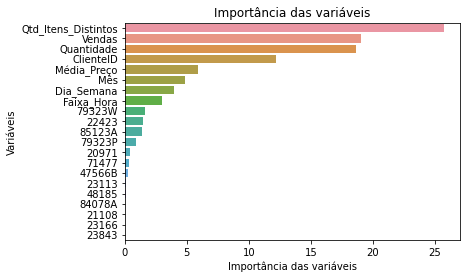

In [84]:
# previsão com os dados de teste
y_pred = modelo.predict(X_test)

# Calcular e printar métricas
# métricas
print("Acurácia no conjunto de treino: {:.3f}".format(modelo.score(X_train, y_train)))
print("Acurácia no conjunto de teste: {:.3f}".format(modelo.score(X_test, y_test)))
print()

# O classification report traz diversas métricas interessantes, en formato de tabela, de forma simples
print(classification_report(y_test, y_pred))
print()

# A matriz de confusão mostra de forma fácil os dados
# Verdadeiros Positivos | Falsos Positivos
# Falsos Negativos | Verdadeiros Negativos
print(confusion_matrix(y_test, y_pred))

# Plotar importância das features
# Avalia quão importante é cada variável para as decisões que a árvore fornece
print()
feature_scores = pd.Series(modelo.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_scores)

# plot
sns.barplot(x=feature_scores, y=feature_scores.index)

# labels
plt.xlabel('Importância das variáveis')
plt.ylabel('Variáveis')

# título
plt.title("Importância das variáveis")

# visualização
plt.show()

### 8.0 Modelo serializado

In [85]:
# Salve o modelo em um arquivo pickle
with open('modelo.pkl', 'wb') as f:
    pickle.dump(modelo, f)